In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


###  Датчики

In [2]:
values = pd.read_csv('temp_ds/Power-Networks-LCL-June2015(withAcornGps)v2_2.csv', delimiter=',')
print(values.keys())
#print(values['KWH/hh (per half hour) '])

values = np.asarray(values['KWH/hh (per half hour) '].dropna(how='any',axis=0))
values[np.where(values== 'Null')]=-1
values = values.astype(np.float32)
#print(values)

Index(['LCLid', 'stdorToU', 'DateTime', 'KWH/hh (per half hour) ', 'Acorn',
       'Acorn_grouped'],
      dtype='object')


### Температура

In [49]:
values = pd.read_csv('temp_ds/temp_arct.csv', delimiter=',')
print(values.keys())
#print(values['KWH/hh (per half hour) '])

values = np.asarray(values['temp'].dropna(how='any',axis=0))
#values[np.where(values== 'Null')]=-1
#values = values.astype(np.float32)

Index(['time', 'temp'], dtype='object')


### Cмотрим данные

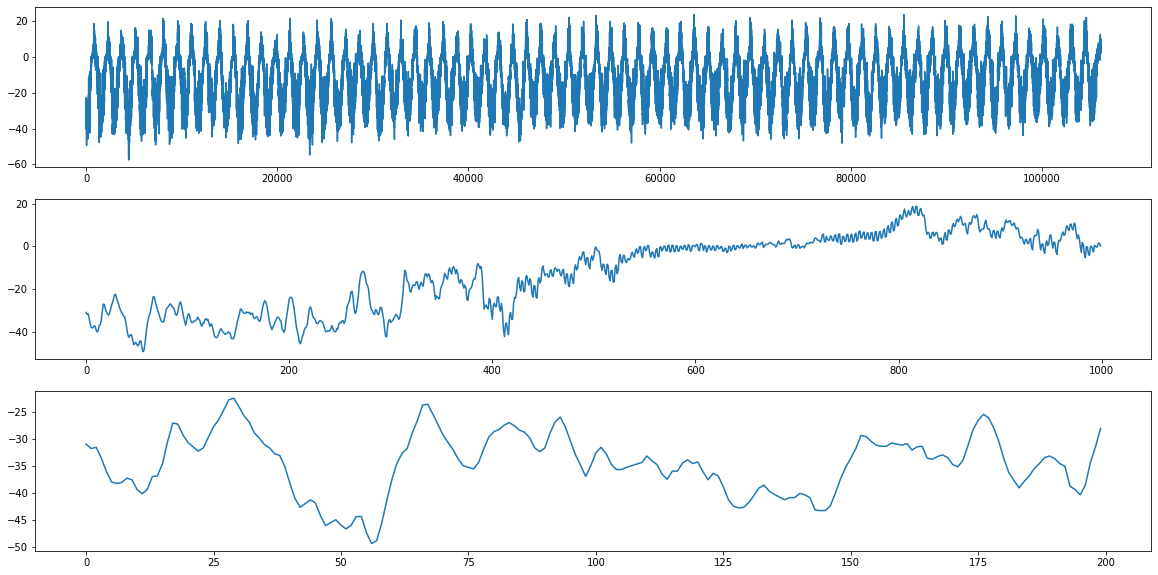

In [50]:
plt.figure(figsize = (20,10))
plt.subplot(3,1,1)
plt.plot(values)
plt.subplot(3,1,2)
plt.plot(values[:1000])  
plt.subplot(3,1,3)
plt.plot(values[:200]) 

### Предобработка

In [51]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

test_data_size = int(len(values[12000:42000])*0.4)
test_data_sv = values[12000:42000].copy()[-test_data_size:]

# Усреднение
values_mean = moving_average(np.asarray(values), n= 30)

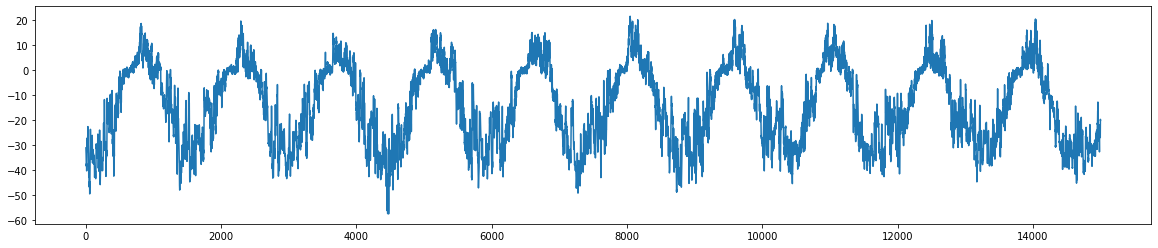

In [52]:

plt.figure(figsize = (20,4))
values =  values[:15000]
plt.plot(values)

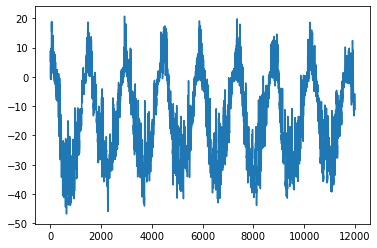

In [53]:
plt.plot(test_data_sv)

In [54]:
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
import torch

In [58]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#### Разделение выбоки

In [59]:
test_data_size = int(len(values)*0.4)
train_data = values[:-test_data_size]
test_data = values[-test_data_size:]

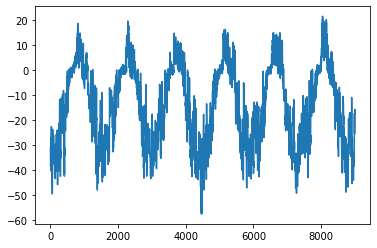

In [60]:
plt.plot(train_data)

In [61]:
scaler_orig = MinMaxScaler()
scaler_orig = scaler_orig.fit(np.expand_dims(values.ravel(), axis=1))
train_data = scaler_orig.transform(np.expand_dims(train_data, axis=1)) 
test_data = scaler_orig.transform(np.expand_dims(test_data, axis=1)) 

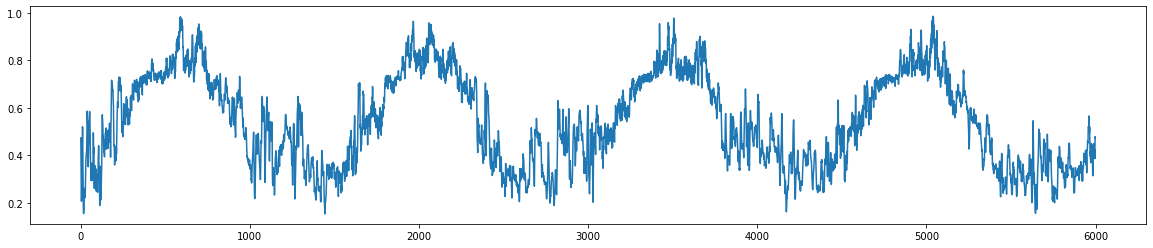

In [62]:
plt.figure(figsize = (20, 4))
plt.plot(test_data)

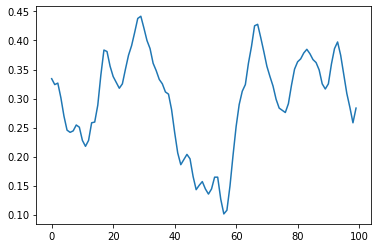

In [63]:
plt.plot(train_data[:100])

In [64]:
def create_sequences(data, seq_length, t = 1):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-t):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length:i+seq_length+t]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [177]:
seq_length = 30

X_train, y_train = create_sequences(train_data, seq_length, 1)

indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train, y_train = X_train[indices], y_train[indices]

X_test, y_test = create_sequences(test_data, seq_length, 1)

# indices = np.arange(len(X_test))
# np.random.shuffle(indices)
# X_test, y_test = X_test[indices], y_test[indices]

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [178]:
# train_count, test_count = 60000, 10000

# X_test, y_test = X_test[:test_count], y_test[:test_count]
# X_train, y_train = X_train[:train_count], y_train[:train_count]

# len(X_test)

In [179]:
len(X_test), len(y_test), len(X_train), len(y_train)

(5969, 5969, 8969, 8969)

y_train = torch.reshape(y_train,( 5,len(y_train),1))
y_test = torch.reshape(y_test,(5,len(y_test),1))

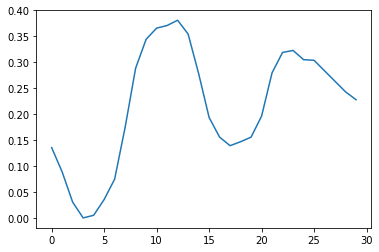

In [180]:
plt.plot(X_train[3].detach().numpy().ravel())

### Моделька и обучение

In [181]:
class TempNN(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(TempNN, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        self.activate = nn.Tanh()
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
      #  y_pred = self.activate(last_time_step)
        y_pred = self.linear(last_time_step) 
        return y_pred
    

In [212]:
def train_model( model, train_data, train_labels,test_data=None, test_labels=None ):
    loss_fn = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    model.reset_hidden_state()
 
    for t in range(num_epochs):
        
        print(t)
        y_pred = model(X_train)
        #print("ueueu")
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
        if t % 2 == 0:
            print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 2 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
        train_hist[t] = loss.item()
        if t!= 0 and train_hist[t-1]<train_hist[t]:
            break
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [219]:
model = TempNN( n_features=1, n_hidden= 64, seq_len=seq_length, n_layers=1)

In [220]:
print(X_train.shape)
y_train = torch.reshape(y_train,(-1, 1))
y_test = torch.reshape(y_test,(-1, 1))
model, train_hist, test_hist = train_model( model, X_train, y_train, X_test, y_test)

torch.Size([8969, 30, 1])
0
Epoch 0 train loss: 0.33998560905456543 test loss: 0.33455148339271545
1
2
Epoch 2 train loss: 0.3035600185394287 test loss: 0.3010599911212921
3
4
Epoch 4 train loss: 0.2682512402534485 test loss: 0.26846420764923096
5
6
Epoch 6 train loss: 0.23339851200580597 test loss: 0.23617646098136902
7
8
Epoch 8 train loss: 0.19825053215026855 test loss: 0.20347243547439575
9
10
Epoch 10 train loss: 0.16228029131889343 test loss: 0.1697443723678589
11
12
Epoch 12 train loss: 0.12535017728805542 test loss: 0.13460367918014526
13
14
Epoch 14 train loss: 0.0883219763636589 test loss: 0.09822060912847519
15
16
Epoch 16 train loss: 0.05534611642360687 test loss: 0.06275902688503265
17
18
Epoch 18 train loss: 0.04198681190609932 test loss: 0.03798920661211014
19


In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")

plt.legend();

### Предсказываем тренд

In [239]:
i = 1
test_seq = X_test[i-1:i]
preds = []
seqs = []
for _ in range(len(X_test)):
    y_test_pred = model(X_test[i-1:i])
    i+=1
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    seqs.append(test_seq)
    
    print(test_seq)

RuntimeError: shape '[1, 20, 1]' is invalid for input of size 30

[]

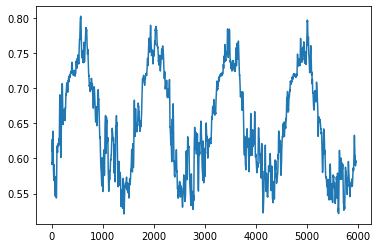

In [222]:

plt.plot(preds)
plt.plot()

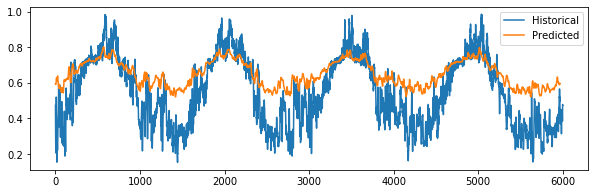

In [223]:
plt.figure(figsize = (10,3))
plt.plot((test_data),  label='Historical')

plt.plot(  preds,  label='Predicted')
plt.legend();

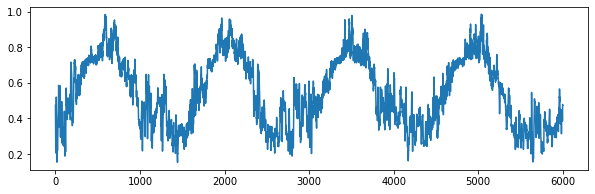

In [224]:
plt.figure(figsize = (10,3))
plt.plot((test_data),  label='Historical')


In [225]:
preds_minus_mean = preds.copy()

### Вторая LSTM

In [240]:
def get_trend_data(data):
    series = []
    predicted = []
    for i in range(0, len(data) - 31):
        seq = torch.from_numpy(data[i:i+30]).float()
        a = model(seq.reshape(1,-1,1))[0,0].item()
        predicted.append(a)
        y_test_pred =  data[i+30+1][0].item() - a
        series.append(y_test_pred)
    series = np.asarray(series).reshape(-1,1)
    return predicted, series
    
  
predicted_trend_tr, train_data_2 = get_trend_data(train_data)
predicted_trend_test, test_data_2 = get_trend_data(test_data)

In [241]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data_2.ravel(), axis=1))
train_data_2_sc = scaler.transform(np.expand_dims(train_data_2.ravel(), axis=1))
test_data_2_sc = scaler.transform(np.expand_dims(test_data_2.ravel(), axis=1))

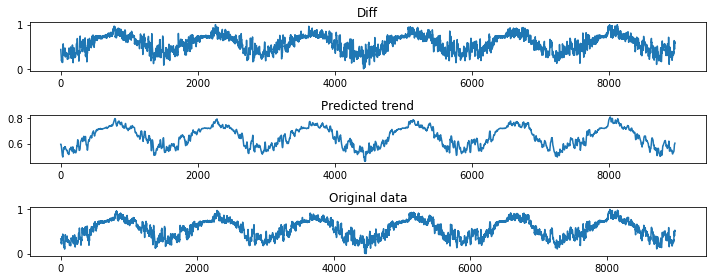

In [242]:
plt.figure(figsize = (10,4))
plt.subplot(311)
plt.plot(train_data_2_sc)
plt.title("Diff")

plt.subplot(312)
plt.plot(predicted_trend_tr)
plt.title("Predicted trend")

plt.subplot(313)
plt.plot(train_data)
plt.title("Original data")

plt.tight_layout()

In [243]:
seq_length = 30

X_train_2, y_train_2 = create_sequences(train_data_2_sc, seq_length)
#X_train_2, y_train_2 = X_train_2[indices], y_train_2[indices]

X_test_2, y_test_2 = create_sequences(test_data_2_sc, seq_length)
X_train_2 = torch.from_numpy(X_train_2).float()
y_train_2 = torch.from_numpy(y_train_2).float()
X_test_2 = torch.from_numpy(X_test_2).float()
y_test_2 = torch.from_numpy(y_test_2).float()

In [231]:
model_2 = TempNN( n_features=1, n_hidden= 100, seq_len=seq_length, n_layers=1)

In [232]:
model_2, train_hist, test_hist = train_model( model_2, X_train_2, y_train_2, X_test_2, y_test_2)

0


RuntimeError: shape '[8969, 20, -1]' is invalid for input of size 269070

### Предсказываем разницу

In [244]:
i = 1
test_seq = X_test_2[i-1:i]
preds = []
seqs = []
for _ in range(len(X_test_2)):
    y_test_pred = model(X_test_2[i-1:i])
    i+=1
    pred = torch.flatten(y_test_pred).item()
   # print(pred)
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    seqs.append(test_seq)
    
    print(test_seq)

tensor([[[0.4353],
         [0.4431],
         [0.4515],
         [0.4915],
         [0.5633],
         [0.6422],
         [0.6927],
         [0.6569],
         [0.6153],
         [0.5648],
         [0.4668],
         [0.3576],
         [0.3234],
         [0.4006],
         [0.4602],
         [0.4947],
         [0.5686],
         [0.6187],
         [0.6238],
         [0.6443],
         [0.6609],
         [0.6375],
         [0.5905],
         [0.5288],
         [0.4268],
         [0.3622],
         [0.3117],
         [0.2628],
         [0.2504],
         [0.5895]]])
tensor([[[0.4431],
         [0.4515],
         [0.4915],
         [0.5633],
         [0.6422],
         [0.6927],
         [0.6569],
         [0.6153],
         [0.5648],
         [0.4668],
         [0.3576],
         [0.3234],
         [0.4006],
         [0.4602],
         [0.4947],
         [0.5686],
         [0.6187],
         [0.6238],
         [0.6443],
         [0.6609],
         [0.6375],
         [0.5905],
         [

         [0.5940]]])
tensor([[[0.4947],
         [0.5686],
         [0.6187],
         [0.6238],
         [0.6443],
         [0.6609],
         [0.6375],
         [0.5905],
         [0.5288],
         [0.4268],
         [0.3622],
         [0.3117],
         [0.2628],
         [0.2504],
         [0.5895],
         [0.5848],
         [0.5824],
         [0.5805],
         [0.5764],
         [0.5768],
         [0.5787],
         [0.5795],
         [0.5790],
         [0.5791],
         [0.5775],
         [0.5751],
         [0.5754],
         [0.5824],
         [0.5940],
         [0.6037]]])
tensor([[[0.5686],
         [0.6187],
         [0.6238],
         [0.6443],
         [0.6609],
         [0.6375],
         [0.5905],
         [0.5288],
         [0.4268],
         [0.3622],
         [0.3117],
         [0.2628],
         [0.2504],
         [0.5895],
         [0.5848],
         [0.5824],
         [0.5805],
         [0.5764],
         [0.5768],
         [0.5787],
         [0.5795],
        

         [0.5829]]])
tensor([[[0.5848],
         [0.5824],
         [0.5805],
         [0.5764],
         [0.5768],
         [0.5787],
         [0.5795],
         [0.5790],
         [0.5791],
         [0.5775],
         [0.5751],
         [0.5754],
         [0.5824],
         [0.5940],
         [0.6037],
         [0.6077],
         [0.6112],
         [0.6115],
         [0.6043],
         [0.5945],
         [0.5889],
         [0.5866],
         [0.5867],
         [0.5863],
         [0.5859],
         [0.5856],
         [0.5851],
         [0.5828],
         [0.5829],
         [0.5809]]])
tensor([[[0.5824],
         [0.5805],
         [0.5764],
         [0.5768],
         [0.5787],
         [0.5795],
         [0.5790],
         [0.5791],
         [0.5775],
         [0.5751],
         [0.5754],
         [0.5824],
         [0.5940],
         [0.6037],
         [0.6077],
         [0.6112],
         [0.6115],
         [0.6043],
         [0.5945],
         [0.5889],
         [0.5866],
        

         [0.5819]]])
tensor([[[0.6077],
         [0.6112],
         [0.6115],
         [0.6043],
         [0.5945],
         [0.5889],
         [0.5866],
         [0.5867],
         [0.5863],
         [0.5859],
         [0.5856],
         [0.5851],
         [0.5828],
         [0.5829],
         [0.5809],
         [0.5756],
         [0.5702],
         [0.5686],
         [0.5697],
         [0.5705],
         [0.5691],
         [0.5679],
         [0.5661],
         [0.5631],
         [0.5611],
         [0.5635],
         [0.5683],
         [0.5749],
         [0.5819],
         [0.5913]]])
tensor([[[0.6112],
         [0.6115],
         [0.6043],
         [0.5945],
         [0.5889],
         [0.5866],
         [0.5867],
         [0.5863],
         [0.5859],
         [0.5856],
         [0.5851],
         [0.5828],
         [0.5829],
         [0.5809],
         [0.5756],
         [0.5702],
         [0.5686],
         [0.5697],
         [0.5705],
         [0.5691],
         [0.5679],
        

         [0.5667]]])
tensor([[[0.5756],
         [0.5702],
         [0.5686],
         [0.5697],
         [0.5705],
         [0.5691],
         [0.5679],
         [0.5661],
         [0.5631],
         [0.5611],
         [0.5635],
         [0.5683],
         [0.5749],
         [0.5819],
         [0.5913],
         [0.5997],
         [0.6026],
         [0.6000],
         [0.5964],
         [0.5908],
         [0.5817],
         [0.5708],
         [0.5656],
         [0.5665],
         [0.5710],
         [0.5742],
         [0.5752],
         [0.5724],
         [0.5667],
         [0.5607]]])
tensor([[[0.5702],
         [0.5686],
         [0.5697],
         [0.5705],
         [0.5691],
         [0.5679],
         [0.5661],
         [0.5631],
         [0.5611],
         [0.5635],
         [0.5683],
         [0.5749],
         [0.5819],
         [0.5913],
         [0.5997],
         [0.6026],
         [0.6000],
         [0.5964],
         [0.5908],
         [0.5817],
         [0.5708],
        

         [0.6475]]])
tensor([[[0.5997],
         [0.6026],
         [0.6000],
         [0.5964],
         [0.5908],
         [0.5817],
         [0.5708],
         [0.5656],
         [0.5665],
         [0.5710],
         [0.5742],
         [0.5752],
         [0.5724],
         [0.5667],
         [0.5607],
         [0.5595],
         [0.5620],
         [0.5667],
         [0.5744],
         [0.5878],
         [0.6044],
         [0.6210],
         [0.6340],
         [0.6438],
         [0.6501],
         [0.6523],
         [0.6511],
         [0.6498],
         [0.6475],
         [0.6432]]])
tensor([[[0.6026],
         [0.6000],
         [0.5964],
         [0.5908],
         [0.5817],
         [0.5708],
         [0.5656],
         [0.5665],
         [0.5710],
         [0.5742],
         [0.5752],
         [0.5724],
         [0.5667],
         [0.5607],
         [0.5595],
         [0.5620],
         [0.5667],
         [0.5744],
         [0.5878],
         [0.6044],
         [0.6210],
        

         [0.6323]]])
tensor([[[0.5595],
         [0.5620],
         [0.5667],
         [0.5744],
         [0.5878],
         [0.6044],
         [0.6210],
         [0.6340],
         [0.6438],
         [0.6501],
         [0.6523],
         [0.6511],
         [0.6498],
         [0.6475],
         [0.6432],
         [0.6374],
         [0.6351],
         [0.6340],
         [0.6305],
         [0.6255],
         [0.6246],
         [0.6253],
         [0.6246],
         [0.6230],
         [0.6247],
         [0.6280],
         [0.6295],
         [0.6294],
         [0.6323],
         [0.6360]]])
tensor([[[0.5620],
         [0.5667],
         [0.5744],
         [0.5878],
         [0.6044],
         [0.6210],
         [0.6340],
         [0.6438],
         [0.6501],
         [0.6523],
         [0.6511],
         [0.6498],
         [0.6475],
         [0.6432],
         [0.6374],
         [0.6351],
         [0.6340],
         [0.6305],
         [0.6255],
         [0.6246],
         [0.6253],
        

         [0.6337]]])
tensor([[[0.6374],
         [0.6351],
         [0.6340],
         [0.6305],
         [0.6255],
         [0.6246],
         [0.6253],
         [0.6246],
         [0.6230],
         [0.6247],
         [0.6280],
         [0.6295],
         [0.6294],
         [0.6323],
         [0.6360],
         [0.6364],
         [0.6333],
         [0.6346],
         [0.6364],
         [0.6358],
         [0.6332],
         [0.6332],
         [0.6347],
         [0.6341],
         [0.6311],
         [0.6321],
         [0.6344],
         [0.6348],
         [0.6337],
         [0.6350]]])
tensor([[[0.6351],
         [0.6340],
         [0.6305],
         [0.6255],
         [0.6246],
         [0.6253],
         [0.6246],
         [0.6230],
         [0.6247],
         [0.6280],
         [0.6295],
         [0.6294],
         [0.6323],
         [0.6360],
         [0.6364],
         [0.6333],
         [0.6346],
         [0.6364],
         [0.6358],
         [0.6332],
         [0.6332],
        

         [0.6370]]])
tensor([[[0.6364],
         [0.6333],
         [0.6346],
         [0.6364],
         [0.6358],
         [0.6332],
         [0.6332],
         [0.6347],
         [0.6341],
         [0.6311],
         [0.6321],
         [0.6344],
         [0.6348],
         [0.6337],
         [0.6350],
         [0.6371],
         [0.6378],
         [0.6362],
         [0.6381],
         [0.6415],
         [0.6428],
         [0.6420],
         [0.6425],
         [0.6420],
         [0.6369],
         [0.6299],
         [0.6286],
         [0.6314],
         [0.6370],
         [0.6459]]])
tensor([[[0.6333],
         [0.6346],
         [0.6364],
         [0.6358],
         [0.6332],
         [0.6332],
         [0.6347],
         [0.6341],
         [0.6311],
         [0.6321],
         [0.6344],
         [0.6348],
         [0.6337],
         [0.6350],
         [0.6371],
         [0.6378],
         [0.6362],
         [0.6381],
         [0.6415],
         [0.6428],
         [0.6420],
        

         [0.6929]]])
tensor([[[0.6371],
         [0.6378],
         [0.6362],
         [0.6381],
         [0.6415],
         [0.6428],
         [0.6420],
         [0.6425],
         [0.6420],
         [0.6369],
         [0.6299],
         [0.6286],
         [0.6314],
         [0.6370],
         [0.6459],
         [0.6585],
         [0.6727],
         [0.6847],
         [0.6942],
         [0.7011],
         [0.7061],
         [0.7091],
         [0.7104],
         [0.7104],
         [0.7101],
         [0.7083],
         [0.7055],
         [0.7007],
         [0.6929],
         [0.6812]]])
tensor([[[0.6378],
         [0.6362],
         [0.6381],
         [0.6415],
         [0.6428],
         [0.6420],
         [0.6425],
         [0.6420],
         [0.6369],
         [0.6299],
         [0.6286],
         [0.6314],
         [0.6370],
         [0.6459],
         [0.6585],
         [0.6727],
         [0.6847],
         [0.6942],
         [0.7011],
         [0.7061],
         [0.7091],
        

         [0.6028]]])
tensor([[[0.6585],
         [0.6727],
         [0.6847],
         [0.6942],
         [0.7011],
         [0.7061],
         [0.7091],
         [0.7104],
         [0.7104],
         [0.7101],
         [0.7083],
         [0.7055],
         [0.7007],
         [0.6929],
         [0.6812],
         [0.6672],
         [0.6549],
         [0.6443],
         [0.6323],
         [0.6206],
         [0.6130],
         [0.6086],
         [0.6046],
         [0.6018],
         [0.6024],
         [0.6042],
         [0.6041],
         [0.6021],
         [0.6028],
         [0.6048]]])
tensor([[[0.6727],
         [0.6847],
         [0.6942],
         [0.7011],
         [0.7061],
         [0.7091],
         [0.7104],
         [0.7104],
         [0.7101],
         [0.7083],
         [0.7055],
         [0.7007],
         [0.6929],
         [0.6812],
         [0.6672],
         [0.6549],
         [0.6443],
         [0.6323],
         [0.6206],
         [0.6130],
         [0.6086],
        

         [0.7048]]])
tensor([[[0.6672],
         [0.6549],
         [0.6443],
         [0.6323],
         [0.6206],
         [0.6130],
         [0.6086],
         [0.6046],
         [0.6018],
         [0.6024],
         [0.6042],
         [0.6041],
         [0.6021],
         [0.6028],
         [0.6048],
         [0.6053],
         [0.6084],
         [0.6167],
         [0.6268],
         [0.6370],
         [0.6468],
         [0.6566],
         [0.6652],
         [0.6705],
         [0.6757],
         [0.6825],
         [0.6908],
         [0.6986],
         [0.7048],
         [0.7104]]])
tensor([[[0.6549],
         [0.6443],
         [0.6323],
         [0.6206],
         [0.6130],
         [0.6086],
         [0.6046],
         [0.6018],
         [0.6024],
         [0.6042],
         [0.6041],
         [0.6021],
         [0.6028],
         [0.6048],
         [0.6053],
         [0.6084],
         [0.6167],
         [0.6268],
         [0.6370],
         [0.6468],
         [0.6566],
        

         [0.7085]]])
tensor([[[0.6053],
         [0.6084],
         [0.6167],
         [0.6268],
         [0.6370],
         [0.6468],
         [0.6566],
         [0.6652],
         [0.6705],
         [0.6757],
         [0.6825],
         [0.6908],
         [0.6986],
         [0.7048],
         [0.7104],
         [0.7152],
         [0.7176],
         [0.7168],
         [0.7170],
         [0.7188],
         [0.7203],
         [0.7205],
         [0.7201],
         [0.7194],
         [0.7172],
         [0.7143],
         [0.7129],
         [0.7118],
         [0.7085],
         [0.7025]]])
tensor([[[0.6084],
         [0.6167],
         [0.6268],
         [0.6370],
         [0.6468],
         [0.6566],
         [0.6652],
         [0.6705],
         [0.6757],
         [0.6825],
         [0.6908],
         [0.6986],
         [0.7048],
         [0.7104],
         [0.7152],
         [0.7176],
         [0.7168],
         [0.7170],
         [0.7188],
         [0.7203],
         [0.7205],
        

         [0.6557]]])
tensor([[[0.7152],
         [0.7176],
         [0.7168],
         [0.7170],
         [0.7188],
         [0.7203],
         [0.7205],
         [0.7201],
         [0.7194],
         [0.7172],
         [0.7143],
         [0.7129],
         [0.7118],
         [0.7085],
         [0.7025],
         [0.6941],
         [0.6849],
         [0.6743],
         [0.6646],
         [0.6584],
         [0.6549],
         [0.6499],
         [0.6446],
         [0.6436],
         [0.6441],
         [0.6433],
         [0.6440],
         [0.6493],
         [0.6557],
         [0.6589]]])
tensor([[[0.7176],
         [0.7168],
         [0.7170],
         [0.7188],
         [0.7203],
         [0.7205],
         [0.7201],
         [0.7194],
         [0.7172],
         [0.7143],
         [0.7129],
         [0.7118],
         [0.7085],
         [0.7025],
         [0.6941],
         [0.6849],
         [0.6743],
         [0.6646],
         [0.6584],
         [0.6549],
         [0.6499],
        

         [0.6735]]])
tensor([[[0.6941],
         [0.6849],
         [0.6743],
         [0.6646],
         [0.6584],
         [0.6549],
         [0.6499],
         [0.6446],
         [0.6436],
         [0.6441],
         [0.6433],
         [0.6440],
         [0.6493],
         [0.6557],
         [0.6589],
         [0.6597],
         [0.6611],
         [0.6630],
         [0.6621],
         [0.6600],
         [0.6606],
         [0.6625],
         [0.6617],
         [0.6598],
         [0.6620],
         [0.6658],
         [0.6677],
         [0.6692],
         [0.6735],
         [0.6781]]])
tensor([[[0.6849],
         [0.6743],
         [0.6646],
         [0.6584],
         [0.6549],
         [0.6499],
         [0.6446],
         [0.6436],
         [0.6441],
         [0.6433],
         [0.6440],
         [0.6493],
         [0.6557],
         [0.6589],
         [0.6597],
         [0.6611],
         [0.6630],
         [0.6621],
         [0.6600],
         [0.6606],
         [0.6625],
        

         [0.6608]]])
tensor([[[0.6597],
         [0.6611],
         [0.6630],
         [0.6621],
         [0.6600],
         [0.6606],
         [0.6625],
         [0.6617],
         [0.6598],
         [0.6620],
         [0.6658],
         [0.6677],
         [0.6692],
         [0.6735],
         [0.6781],
         [0.6780],
         [0.6757],
         [0.6771],
         [0.6795],
         [0.6799],
         [0.6788],
         [0.6781],
         [0.6772],
         [0.6733],
         [0.6683],
         [0.6657],
         [0.6652],
         [0.6633],
         [0.6608],
         [0.6598]]])
tensor([[[0.6611],
         [0.6630],
         [0.6621],
         [0.6600],
         [0.6606],
         [0.6625],
         [0.6617],
         [0.6598],
         [0.6620],
         [0.6658],
         [0.6677],
         [0.6692],
         [0.6735],
         [0.6781],
         [0.6780],
         [0.6757],
         [0.6771],
         [0.6795],
         [0.6799],
         [0.6788],
         [0.6781],
        

         [0.6835]]])
tensor([[[0.6780],
         [0.6757],
         [0.6771],
         [0.6795],
         [0.6799],
         [0.6788],
         [0.6781],
         [0.6772],
         [0.6733],
         [0.6683],
         [0.6657],
         [0.6652],
         [0.6633],
         [0.6608],
         [0.6598],
         [0.6602],
         [0.6589],
         [0.6571],
         [0.6580],
         [0.6604],
         [0.6615],
         [0.6623],
         [0.6660],
         [0.6715],
         [0.6746],
         [0.6764],
         [0.6800],
         [0.6837],
         [0.6835],
         [0.6818]]])
tensor([[[0.6757],
         [0.6771],
         [0.6795],
         [0.6799],
         [0.6788],
         [0.6781],
         [0.6772],
         [0.6733],
         [0.6683],
         [0.6657],
         [0.6652],
         [0.6633],
         [0.6608],
         [0.6598],
         [0.6602],
         [0.6589],
         [0.6571],
         [0.6580],
         [0.6604],
         [0.6615],
         [0.6623],
        

         [0.7004]]])
tensor([[[0.6602],
         [0.6589],
         [0.6571],
         [0.6580],
         [0.6604],
         [0.6615],
         [0.6623],
         [0.6660],
         [0.6715],
         [0.6746],
         [0.6764],
         [0.6800],
         [0.6837],
         [0.6835],
         [0.6818],
         [0.6820],
         [0.6840],
         [0.6858],
         [0.6879],
         [0.6920],
         [0.6968],
         [0.6995],
         [0.7003],
         [0.7016],
         [0.7020],
         [0.7004],
         [0.6980],
         [0.6985],
         [0.7004],
         [0.7017]]])
tensor([[[0.6589],
         [0.6571],
         [0.6580],
         [0.6604],
         [0.6615],
         [0.6623],
         [0.6660],
         [0.6715],
         [0.6746],
         [0.6764],
         [0.6800],
         [0.6837],
         [0.6835],
         [0.6818],
         [0.6820],
         [0.6840],
         [0.6858],
         [0.6879],
         [0.6920],
         [0.6968],
         [0.6995],
        

         [0.7077]]])
tensor([[[0.6820],
         [0.6840],
         [0.6858],
         [0.6879],
         [0.6920],
         [0.6968],
         [0.6995],
         [0.7003],
         [0.7016],
         [0.7020],
         [0.7004],
         [0.6980],
         [0.6985],
         [0.7004],
         [0.7017],
         [0.7019],
         [0.7044],
         [0.7073],
         [0.7080],
         [0.7083],
         [0.7095],
         [0.7108],
         [0.7108],
         [0.7093],
         [0.7097],
         [0.7106],
         [0.7088],
         [0.7069],
         [0.7077],
         [0.7095]]])
tensor([[[0.6840],
         [0.6858],
         [0.6879],
         [0.6920],
         [0.6968],
         [0.6995],
         [0.7003],
         [0.7016],
         [0.7020],
         [0.7004],
         [0.6980],
         [0.6985],
         [0.7004],
         [0.7017],
         [0.7019],
         [0.7044],
         [0.7073],
         [0.7080],
         [0.7083],
         [0.7095],
         [0.7108],
        

         [0.6919]]])
tensor([[[0.7019],
         [0.7044],
         [0.7073],
         [0.7080],
         [0.7083],
         [0.7095],
         [0.7108],
         [0.7108],
         [0.7093],
         [0.7097],
         [0.7106],
         [0.7088],
         [0.7069],
         [0.7077],
         [0.7095],
         [0.7097],
         [0.7090],
         [0.7097],
         [0.7105],
         [0.7087],
         [0.7054],
         [0.7037],
         [0.7028],
         [0.7002],
         [0.6965],
         [0.6947],
         [0.6942],
         [0.6924],
         [0.6919],
         [0.6939]]])
tensor([[[0.7044],
         [0.7073],
         [0.7080],
         [0.7083],
         [0.7095],
         [0.7108],
         [0.7108],
         [0.7093],
         [0.7097],
         [0.7106],
         [0.7088],
         [0.7069],
         [0.7077],
         [0.7095],
         [0.7097],
         [0.7090],
         [0.7097],
         [0.7105],
         [0.7087],
         [0.7054],
         [0.7037],
        

         [0.7166]]])
tensor([[[0.7097],
         [0.7090],
         [0.7097],
         [0.7105],
         [0.7087],
         [0.7054],
         [0.7037],
         [0.7028],
         [0.7002],
         [0.6965],
         [0.6947],
         [0.6942],
         [0.6924],
         [0.6919],
         [0.6939],
         [0.6975],
         [0.6996],
         [0.7015],
         [0.7048],
         [0.7081],
         [0.7101],
         [0.7122],
         [0.7141],
         [0.7158],
         [0.7148],
         [0.7138],
         [0.7149],
         [0.7162],
         [0.7166],
         [0.7164]]])
tensor([[[0.7090],
         [0.7097],
         [0.7105],
         [0.7087],
         [0.7054],
         [0.7037],
         [0.7028],
         [0.7002],
         [0.6965],
         [0.6947],
         [0.6942],
         [0.6924],
         [0.6919],
         [0.6939],
         [0.6975],
         [0.6996],
         [0.7015],
         [0.7048],
         [0.7081],
         [0.7101],
         [0.7122],
        

         [0.7182]]])
tensor([[[0.6975],
         [0.6996],
         [0.7015],
         [0.7048],
         [0.7081],
         [0.7101],
         [0.7122],
         [0.7141],
         [0.7158],
         [0.7148],
         [0.7138],
         [0.7149],
         [0.7162],
         [0.7166],
         [0.7164],
         [0.7160],
         [0.7150],
         [0.7117],
         [0.7077],
         [0.7080],
         [0.7102],
         [0.7125],
         [0.7143],
         [0.7161],
         [0.7176],
         [0.7174],
         [0.7163],
         [0.7171],
         [0.7182],
         [0.7179]]])
tensor([[[0.6996],
         [0.7015],
         [0.7048],
         [0.7081],
         [0.7101],
         [0.7122],
         [0.7141],
         [0.7158],
         [0.7148],
         [0.7138],
         [0.7149],
         [0.7162],
         [0.7166],
         [0.7164],
         [0.7160],
         [0.7150],
         [0.7117],
         [0.7077],
         [0.7080],
         [0.7102],
         [0.7125],
        

         [0.7150]]])
tensor([[[0.7160],
         [0.7150],
         [0.7117],
         [0.7077],
         [0.7080],
         [0.7102],
         [0.7125],
         [0.7143],
         [0.7161],
         [0.7176],
         [0.7174],
         [0.7163],
         [0.7171],
         [0.7182],
         [0.7179],
         [0.7171],
         [0.7176],
         [0.7181],
         [0.7176],
         [0.7175],
         [0.7184],
         [0.7195],
         [0.7187],
         [0.7176],
         [0.7179],
         [0.7182],
         [0.7166],
         [0.7147],
         [0.7150],
         [0.7152]]])
tensor([[[0.7150],
         [0.7117],
         [0.7077],
         [0.7080],
         [0.7102],
         [0.7125],
         [0.7143],
         [0.7161],
         [0.7176],
         [0.7174],
         [0.7163],
         [0.7171],
         [0.7182],
         [0.7179],
         [0.7171],
         [0.7176],
         [0.7181],
         [0.7176],
         [0.7175],
         [0.7184],
         [0.7195],
        

         [0.7216]]])
tensor([[[0.7171],
         [0.7176],
         [0.7181],
         [0.7176],
         [0.7175],
         [0.7184],
         [0.7195],
         [0.7187],
         [0.7176],
         [0.7179],
         [0.7182],
         [0.7166],
         [0.7147],
         [0.7150],
         [0.7152],
         [0.7140],
         [0.7134],
         [0.7151],
         [0.7178],
         [0.7191],
         [0.7204],
         [0.7217],
         [0.7229],
         [0.7232],
         [0.7232],
         [0.7232],
         [0.7229],
         [0.7220],
         [0.7216],
         [0.7224]]])
tensor([[[0.7176],
         [0.7181],
         [0.7176],
         [0.7175],
         [0.7184],
         [0.7195],
         [0.7187],
         [0.7176],
         [0.7179],
         [0.7182],
         [0.7166],
         [0.7147],
         [0.7150],
         [0.7152],
         [0.7140],
         [0.7134],
         [0.7151],
         [0.7178],
         [0.7191],
         [0.7204],
         [0.7217],
        

         [0.7272]]])
tensor([[[0.7140],
         [0.7134],
         [0.7151],
         [0.7178],
         [0.7191],
         [0.7204],
         [0.7217],
         [0.7229],
         [0.7232],
         [0.7232],
         [0.7232],
         [0.7229],
         [0.7220],
         [0.7216],
         [0.7224],
         [0.7232],
         [0.7227],
         [0.7219],
         [0.7215],
         [0.7211],
         [0.7201],
         [0.7195],
         [0.7202],
         [0.7206],
         [0.7194],
         [0.7191],
         [0.7203],
         [0.7235],
         [0.7272],
         [0.7312]]])
tensor([[[0.7134],
         [0.7151],
         [0.7178],
         [0.7191],
         [0.7204],
         [0.7217],
         [0.7229],
         [0.7232],
         [0.7232],
         [0.7232],
         [0.7229],
         [0.7220],
         [0.7216],
         [0.7224],
         [0.7232],
         [0.7227],
         [0.7219],
         [0.7215],
         [0.7211],
         [0.7201],
         [0.7195],
        

         [0.7251]]])
tensor([[[0.7232],
         [0.7227],
         [0.7219],
         [0.7215],
         [0.7211],
         [0.7201],
         [0.7195],
         [0.7202],
         [0.7206],
         [0.7194],
         [0.7191],
         [0.7203],
         [0.7235],
         [0.7272],
         [0.7312],
         [0.7350],
         [0.7380],
         [0.7380],
         [0.7371],
         [0.7371],
         [0.7377],
         [0.7367],
         [0.7351],
         [0.7338],
         [0.7329],
         [0.7307],
         [0.7284],
         [0.7265],
         [0.7251],
         [0.7227]]])
tensor([[[0.7227],
         [0.7219],
         [0.7215],
         [0.7211],
         [0.7201],
         [0.7195],
         [0.7202],
         [0.7206],
         [0.7194],
         [0.7191],
         [0.7203],
         [0.7235],
         [0.7272],
         [0.7312],
         [0.7350],
         [0.7380],
         [0.7380],
         [0.7371],
         [0.7371],
         [0.7377],
         [0.7367],
        

         [0.7171]]])
tensor([[[0.7350],
         [0.7380],
         [0.7380],
         [0.7371],
         [0.7371],
         [0.7377],
         [0.7367],
         [0.7351],
         [0.7338],
         [0.7329],
         [0.7307],
         [0.7284],
         [0.7265],
         [0.7251],
         [0.7227],
         [0.7211],
         [0.7206],
         [0.7209],
         [0.7199],
         [0.7192],
         [0.7194],
         [0.7202],
         [0.7195],
         [0.7191],
         [0.7195],
         [0.7198],
         [0.7187],
         [0.7178],
         [0.7171],
         [0.7167]]])
tensor([[[0.7380],
         [0.7380],
         [0.7371],
         [0.7371],
         [0.7377],
         [0.7367],
         [0.7351],
         [0.7338],
         [0.7329],
         [0.7307],
         [0.7284],
         [0.7265],
         [0.7251],
         [0.7227],
         [0.7211],
         [0.7206],
         [0.7209],
         [0.7199],
         [0.7192],
         [0.7194],
         [0.7202],
        

         [0.7232]]])
tensor([[[0.7211],
         [0.7206],
         [0.7209],
         [0.7199],
         [0.7192],
         [0.7194],
         [0.7202],
         [0.7195],
         [0.7191],
         [0.7195],
         [0.7198],
         [0.7187],
         [0.7178],
         [0.7171],
         [0.7167],
         [0.7155],
         [0.7148],
         [0.7150],
         [0.7155],
         [0.7155],
         [0.7161],
         [0.7173],
         [0.7189],
         [0.7196],
         [0.7201],
         [0.7212],
         [0.7225],
         [0.7232],
         [0.7232],
         [0.7232]]])
tensor([[[0.7206],
         [0.7209],
         [0.7199],
         [0.7192],
         [0.7194],
         [0.7202],
         [0.7195],
         [0.7191],
         [0.7195],
         [0.7198],
         [0.7187],
         [0.7178],
         [0.7171],
         [0.7167],
         [0.7155],
         [0.7148],
         [0.7150],
         [0.7155],
         [0.7155],
         [0.7161],
         [0.7173],
        

         [0.7218]]])
tensor([[[0.7155],
         [0.7148],
         [0.7150],
         [0.7155],
         [0.7155],
         [0.7161],
         [0.7173],
         [0.7189],
         [0.7196],
         [0.7201],
         [0.7212],
         [0.7225],
         [0.7232],
         [0.7232],
         [0.7232],
         [0.7227],
         [0.7220],
         [0.7214],
         [0.7212],
         [0.7215],
         [0.7210],
         [0.7200],
         [0.7205],
         [0.7219],
         [0.7230],
         [0.7243],
         [0.7248],
         [0.7244],
         [0.7218],
         [0.7194]]])
tensor([[[0.7148],
         [0.7150],
         [0.7155],
         [0.7155],
         [0.7161],
         [0.7173],
         [0.7189],
         [0.7196],
         [0.7201],
         [0.7212],
         [0.7225],
         [0.7232],
         [0.7232],
         [0.7232],
         [0.7227],
         [0.7220],
         [0.7214],
         [0.7212],
         [0.7215],
         [0.7210],
         [0.7200],
        

         [0.7199]]])
tensor([[[0.7227],
         [0.7220],
         [0.7214],
         [0.7212],
         [0.7215],
         [0.7210],
         [0.7200],
         [0.7205],
         [0.7219],
         [0.7230],
         [0.7243],
         [0.7248],
         [0.7244],
         [0.7218],
         [0.7194],
         [0.7183],
         [0.7178],
         [0.7161],
         [0.7147],
         [0.7148],
         [0.7155],
         [0.7146],
         [0.7140],
         [0.7146],
         [0.7157],
         [0.7157],
         [0.7161],
         [0.7179],
         [0.7199],
         [0.7197]]])
tensor([[[0.7220],
         [0.7214],
         [0.7212],
         [0.7215],
         [0.7210],
         [0.7200],
         [0.7205],
         [0.7219],
         [0.7230],
         [0.7243],
         [0.7248],
         [0.7244],
         [0.7218],
         [0.7194],
         [0.7183],
         [0.7178],
         [0.7161],
         [0.7147],
         [0.7148],
         [0.7155],
         [0.7146],
        

         [0.7401]]])
tensor([[[0.7183],
         [0.7178],
         [0.7161],
         [0.7147],
         [0.7148],
         [0.7155],
         [0.7146],
         [0.7140],
         [0.7146],
         [0.7157],
         [0.7157],
         [0.7161],
         [0.7179],
         [0.7199],
         [0.7197],
         [0.7196],
         [0.7203],
         [0.7217],
         [0.7215],
         [0.7212],
         [0.7224],
         [0.7248],
         [0.7264],
         [0.7262],
         [0.7289],
         [0.7328],
         [0.7355],
         [0.7377],
         [0.7401],
         [0.7415]]])
tensor([[[0.7178],
         [0.7161],
         [0.7147],
         [0.7148],
         [0.7155],
         [0.7146],
         [0.7140],
         [0.7146],
         [0.7157],
         [0.7157],
         [0.7161],
         [0.7179],
         [0.7199],
         [0.7197],
         [0.7196],
         [0.7203],
         [0.7217],
         [0.7215],
         [0.7212],
         [0.7224],
         [0.7248],
        

         [0.7269]]])
tensor([[[0.7196],
         [0.7203],
         [0.7217],
         [0.7215],
         [0.7212],
         [0.7224],
         [0.7248],
         [0.7264],
         [0.7262],
         [0.7289],
         [0.7328],
         [0.7355],
         [0.7377],
         [0.7401],
         [0.7415],
         [0.7405],
         [0.7379],
         [0.7352],
         [0.7329],
         [0.7297],
         [0.7269],
         [0.7259],
         [0.7257],
         [0.7248],
         [0.7237],
         [0.7238],
         [0.7249],
         [0.7260],
         [0.7269],
         [0.7288]]])
tensor([[[0.7203],
         [0.7217],
         [0.7215],
         [0.7212],
         [0.7224],
         [0.7248],
         [0.7264],
         [0.7262],
         [0.7289],
         [0.7328],
         [0.7355],
         [0.7377],
         [0.7401],
         [0.7415],
         [0.7405],
         [0.7379],
         [0.7352],
         [0.7329],
         [0.7297],
         [0.7269],
         [0.7259],
        

         [0.7341]]])
tensor([[[0.7405],
         [0.7379],
         [0.7352],
         [0.7329],
         [0.7297],
         [0.7269],
         [0.7259],
         [0.7257],
         [0.7248],
         [0.7237],
         [0.7238],
         [0.7249],
         [0.7260],
         [0.7269],
         [0.7288],
         [0.7328],
         [0.7368],
         [0.7388],
         [0.7406],
         [0.7425],
         [0.7423],
         [0.7415],
         [0.7414],
         [0.7416],
         [0.7394],
         [0.7362],
         [0.7350],
         [0.7351],
         [0.7341],
         [0.7333]]])
tensor([[[0.7379],
         [0.7352],
         [0.7329],
         [0.7297],
         [0.7269],
         [0.7259],
         [0.7257],
         [0.7248],
         [0.7237],
         [0.7238],
         [0.7249],
         [0.7260],
         [0.7269],
         [0.7288],
         [0.7328],
         [0.7368],
         [0.7388],
         [0.7406],
         [0.7425],
         [0.7423],
         [0.7415],
        

         [0.7376]]])
tensor([[[0.7328],
         [0.7368],
         [0.7388],
         [0.7406],
         [0.7425],
         [0.7423],
         [0.7415],
         [0.7414],
         [0.7416],
         [0.7394],
         [0.7362],
         [0.7350],
         [0.7351],
         [0.7341],
         [0.7333],
         [0.7352],
         [0.7384],
         [0.7410],
         [0.7424],
         [0.7444],
         [0.7464],
         [0.7458],
         [0.7442],
         [0.7445],
         [0.7453],
         [0.7442],
         [0.7419],
         [0.7397],
         [0.7376],
         [0.7334]]])
tensor([[[0.7368],
         [0.7388],
         [0.7406],
         [0.7425],
         [0.7423],
         [0.7415],
         [0.7414],
         [0.7416],
         [0.7394],
         [0.7362],
         [0.7350],
         [0.7351],
         [0.7341],
         [0.7333],
         [0.7352],
         [0.7384],
         [0.7410],
         [0.7424],
         [0.7444],
         [0.7464],
         [0.7458],
        

         [0.7595]]])
tensor([[[0.7352],
         [0.7384],
         [0.7410],
         [0.7424],
         [0.7444],
         [0.7464],
         [0.7458],
         [0.7442],
         [0.7445],
         [0.7453],
         [0.7442],
         [0.7419],
         [0.7397],
         [0.7376],
         [0.7334],
         [0.7292],
         [0.7279],
         [0.7285],
         [0.7278],
         [0.7275],
         [0.7306],
         [0.7355],
         [0.7386],
         [0.7412],
         [0.7459],
         [0.7513],
         [0.7545],
         [0.7558],
         [0.7595],
         [0.7633]]])
tensor([[[0.7384],
         [0.7410],
         [0.7424],
         [0.7444],
         [0.7464],
         [0.7458],
         [0.7442],
         [0.7445],
         [0.7453],
         [0.7442],
         [0.7419],
         [0.7397],
         [0.7376],
         [0.7334],
         [0.7292],
         [0.7279],
         [0.7285],
         [0.7278],
         [0.7275],
         [0.7306],
         [0.7355],
        

         [0.7755]]])
tensor([[[0.7292],
         [0.7279],
         [0.7285],
         [0.7278],
         [0.7275],
         [0.7306],
         [0.7355],
         [0.7386],
         [0.7412],
         [0.7459],
         [0.7513],
         [0.7545],
         [0.7558],
         [0.7595],
         [0.7633],
         [0.7641],
         [0.7640],
         [0.7663],
         [0.7692],
         [0.7696],
         [0.7680],
         [0.7679],
         [0.7685],
         [0.7672],
         [0.7662],
         [0.7683],
         [0.7718],
         [0.7736],
         [0.7755],
         [0.7805]]])
tensor([[[0.7279],
         [0.7285],
         [0.7278],
         [0.7275],
         [0.7306],
         [0.7355],
         [0.7386],
         [0.7412],
         [0.7459],
         [0.7513],
         [0.7545],
         [0.7558],
         [0.7595],
         [0.7633],
         [0.7641],
         [0.7640],
         [0.7663],
         [0.7692],
         [0.7696],
         [0.7680],
         [0.7679],
        

         [0.7959]]])
tensor([[[0.7641],
         [0.7640],
         [0.7663],
         [0.7692],
         [0.7696],
         [0.7680],
         [0.7679],
         [0.7685],
         [0.7672],
         [0.7662],
         [0.7683],
         [0.7718],
         [0.7736],
         [0.7755],
         [0.7805],
         [0.7862],
         [0.7891],
         [0.7894],
         [0.7925],
         [0.7959],
         [0.7968],
         [0.7963],
         [0.7964],
         [0.7966],
         [0.7953],
         [0.7940],
         [0.7951],
         [0.7966],
         [0.7959],
         [0.7941]]])
tensor([[[0.7640],
         [0.7663],
         [0.7692],
         [0.7696],
         [0.7680],
         [0.7679],
         [0.7685],
         [0.7672],
         [0.7662],
         [0.7683],
         [0.7718],
         [0.7736],
         [0.7755],
         [0.7805],
         [0.7862],
         [0.7891],
         [0.7894],
         [0.7925],
         [0.7959],
         [0.7968],
         [0.7963],
        

         [0.7344]]])
tensor([[[0.7862],
         [0.7891],
         [0.7894],
         [0.7925],
         [0.7959],
         [0.7968],
         [0.7963],
         [0.7964],
         [0.7966],
         [0.7953],
         [0.7940],
         [0.7951],
         [0.7966],
         [0.7959],
         [0.7941],
         [0.7934],
         [0.7926],
         [0.7886],
         [0.7827],
         [0.7773],
         [0.7713],
         [0.7627],
         [0.7537],
         [0.7481],
         [0.7453],
         [0.7412],
         [0.7369],
         [0.7350],
         [0.7344],
         [0.7318]]])
tensor([[[0.7891],
         [0.7894],
         [0.7925],
         [0.7959],
         [0.7968],
         [0.7963],
         [0.7964],
         [0.7966],
         [0.7953],
         [0.7940],
         [0.7951],
         [0.7966],
         [0.7959],
         [0.7941],
         [0.7934],
         [0.7926],
         [0.7886],
         [0.7827],
         [0.7773],
         [0.7713],
         [0.7627],
        

         [0.7385]]])
tensor([[[0.7934],
         [0.7926],
         [0.7886],
         [0.7827],
         [0.7773],
         [0.7713],
         [0.7627],
         [0.7537],
         [0.7481],
         [0.7453],
         [0.7412],
         [0.7369],
         [0.7350],
         [0.7344],
         [0.7318],
         [0.7289],
         [0.7294],
         [0.7314],
         [0.7309],
         [0.7297],
         [0.7321],
         [0.7353],
         [0.7358],
         [0.7354],
         [0.7364],
         [0.7379],
         [0.7374],
         [0.7367],
         [0.7385],
         [0.7421]]])
tensor([[[0.7926],
         [0.7886],
         [0.7827],
         [0.7773],
         [0.7713],
         [0.7627],
         [0.7537],
         [0.7481],
         [0.7453],
         [0.7412],
         [0.7369],
         [0.7350],
         [0.7344],
         [0.7318],
         [0.7289],
         [0.7294],
         [0.7314],
         [0.7309],
         [0.7297],
         [0.7321],
         [0.7353],
        

         [0.7317]]])
tensor([[[0.7289],
         [0.7294],
         [0.7314],
         [0.7309],
         [0.7297],
         [0.7321],
         [0.7353],
         [0.7358],
         [0.7354],
         [0.7364],
         [0.7379],
         [0.7374],
         [0.7367],
         [0.7385],
         [0.7421],
         [0.7443],
         [0.7465],
         [0.7494],
         [0.7514],
         [0.7501],
         [0.7472],
         [0.7453],
         [0.7436],
         [0.7389],
         [0.7340],
         [0.7332],
         [0.7341],
         [0.7333],
         [0.7317],
         [0.7319]]])
tensor([[[0.7294],
         [0.7314],
         [0.7309],
         [0.7297],
         [0.7321],
         [0.7353],
         [0.7358],
         [0.7354],
         [0.7364],
         [0.7379],
         [0.7374],
         [0.7367],
         [0.7385],
         [0.7421],
         [0.7443],
         [0.7465],
         [0.7494],
         [0.7514],
         [0.7501],
         [0.7472],
         [0.7453],
        

         [0.7558]]])
tensor([[[0.7443],
         [0.7465],
         [0.7494],
         [0.7514],
         [0.7501],
         [0.7472],
         [0.7453],
         [0.7436],
         [0.7389],
         [0.7340],
         [0.7332],
         [0.7341],
         [0.7333],
         [0.7317],
         [0.7319],
         [0.7332],
         [0.7319],
         [0.7300],
         [0.7300],
         [0.7313],
         [0.7310],
         [0.7304],
         [0.7318],
         [0.7346],
         [0.7362],
         [0.7383],
         [0.7431],
         [0.7496],
         [0.7558],
         [0.7621]]])
tensor([[[0.7465],
         [0.7494],
         [0.7514],
         [0.7501],
         [0.7472],
         [0.7453],
         [0.7436],
         [0.7389],
         [0.7340],
         [0.7332],
         [0.7341],
         [0.7333],
         [0.7317],
         [0.7319],
         [0.7332],
         [0.7319],
         [0.7300],
         [0.7300],
         [0.7313],
         [0.7310],
         [0.7304],
        

         [0.7301]]])
tensor([[[0.7332],
         [0.7319],
         [0.7300],
         [0.7300],
         [0.7313],
         [0.7310],
         [0.7304],
         [0.7318],
         [0.7346],
         [0.7362],
         [0.7383],
         [0.7431],
         [0.7496],
         [0.7558],
         [0.7621],
         [0.7666],
         [0.7691],
         [0.7675],
         [0.7630],
         [0.7582],
         [0.7529],
         [0.7450],
         [0.7369],
         [0.7336],
         [0.7322],
         [0.7290],
         [0.7261],
         [0.7271],
         [0.7301],
         [0.7319]]])
tensor([[[0.7319],
         [0.7300],
         [0.7300],
         [0.7313],
         [0.7310],
         [0.7304],
         [0.7318],
         [0.7346],
         [0.7362],
         [0.7383],
         [0.7431],
         [0.7496],
         [0.7558],
         [0.7621],
         [0.7666],
         [0.7691],
         [0.7675],
         [0.7630],
         [0.7582],
         [0.7529],
         [0.7450],
        

         [0.7659]]])
tensor([[[0.7666],
         [0.7691],
         [0.7675],
         [0.7630],
         [0.7582],
         [0.7529],
         [0.7450],
         [0.7369],
         [0.7336],
         [0.7322],
         [0.7290],
         [0.7261],
         [0.7271],
         [0.7301],
         [0.7319],
         [0.7327],
         [0.7372],
         [0.7429],
         [0.7450],
         [0.7448],
         [0.7485],
         [0.7530],
         [0.7554],
         [0.7566],
         [0.7602],
         [0.7643],
         [0.7652],
         [0.7642],
         [0.7659],
         [0.7691]]])
tensor([[[0.7691],
         [0.7675],
         [0.7630],
         [0.7582],
         [0.7529],
         [0.7450],
         [0.7369],
         [0.7336],
         [0.7322],
         [0.7290],
         [0.7261],
         [0.7271],
         [0.7301],
         [0.7319],
         [0.7327],
         [0.7372],
         [0.7429],
         [0.7450],
         [0.7448],
         [0.7485],
         [0.7530],
        

         [0.7757]]])
tensor([[[0.7327],
         [0.7372],
         [0.7429],
         [0.7450],
         [0.7448],
         [0.7485],
         [0.7530],
         [0.7554],
         [0.7566],
         [0.7602],
         [0.7643],
         [0.7652],
         [0.7642],
         [0.7659],
         [0.7691],
         [0.7707],
         [0.7709],
         [0.7735],
         [0.7773],
         [0.7792],
         [0.7783],
         [0.7814],
         [0.7848],
         [0.7848],
         [0.7818],
         [0.7813],
         [0.7815],
         [0.7793],
         [0.7757],
         [0.7749]]])
tensor([[[0.7372],
         [0.7429],
         [0.7450],
         [0.7448],
         [0.7485],
         [0.7530],
         [0.7554],
         [0.7566],
         [0.7602],
         [0.7643],
         [0.7652],
         [0.7642],
         [0.7659],
         [0.7691],
         [0.7707],
         [0.7709],
         [0.7735],
         [0.7773],
         [0.7792],
         [0.7783],
         [0.7814],
        

         [0.7634]]])
tensor([[[0.7707],
         [0.7709],
         [0.7735],
         [0.7773],
         [0.7792],
         [0.7783],
         [0.7814],
         [0.7848],
         [0.7848],
         [0.7818],
         [0.7813],
         [0.7815],
         [0.7793],
         [0.7757],
         [0.7749],
         [0.7755],
         [0.7739],
         [0.7709],
         [0.7719],
         [0.7742],
         [0.7742],
         [0.7730],
         [0.7742],
         [0.7758],
         [0.7750],
         [0.7725],
         [0.7706],
         [0.7686],
         [0.7634],
         [0.7569]]])
tensor([[[0.7709],
         [0.7735],
         [0.7773],
         [0.7792],
         [0.7783],
         [0.7814],
         [0.7848],
         [0.7848],
         [0.7818],
         [0.7813],
         [0.7815],
         [0.7793],
         [0.7757],
         [0.7749],
         [0.7755],
         [0.7739],
         [0.7709],
         [0.7719],
         [0.7742],
         [0.7742],
         [0.7730],
        

         [0.7399]]])
tensor([[[0.7755],
         [0.7739],
         [0.7709],
         [0.7719],
         [0.7742],
         [0.7742],
         [0.7730],
         [0.7742],
         [0.7758],
         [0.7750],
         [0.7725],
         [0.7706],
         [0.7686],
         [0.7634],
         [0.7569],
         [0.7540],
         [0.7526],
         [0.7497],
         [0.7456],
         [0.7457],
         [0.7466],
         [0.7463],
         [0.7433],
         [0.7422],
         [0.7416],
         [0.7388],
         [0.7355],
         [0.7368],
         [0.7399],
         [0.7422]]])
tensor([[[0.7739],
         [0.7709],
         [0.7719],
         [0.7742],
         [0.7742],
         [0.7730],
         [0.7742],
         [0.7758],
         [0.7750],
         [0.7725],
         [0.7706],
         [0.7686],
         [0.7634],
         [0.7569],
         [0.7540],
         [0.7526],
         [0.7497],
         [0.7456],
         [0.7457],
         [0.7466],
         [0.7463],
        

         [0.7181]]])
tensor([[[0.7540],
         [0.7526],
         [0.7497],
         [0.7456],
         [0.7457],
         [0.7466],
         [0.7463],
         [0.7433],
         [0.7422],
         [0.7416],
         [0.7388],
         [0.7355],
         [0.7368],
         [0.7399],
         [0.7422],
         [0.7436],
         [0.7470],
         [0.7495],
         [0.7487],
         [0.7450],
         [0.7435],
         [0.7426],
         [0.7393],
         [0.7340],
         [0.7313],
         [0.7292],
         [0.7255],
         [0.7211],
         [0.7181],
         [0.7168]]])
tensor([[[0.7526],
         [0.7497],
         [0.7456],
         [0.7457],
         [0.7466],
         [0.7463],
         [0.7433],
         [0.7422],
         [0.7416],
         [0.7388],
         [0.7355],
         [0.7368],
         [0.7399],
         [0.7422],
         [0.7436],
         [0.7470],
         [0.7495],
         [0.7487],
         [0.7450],
         [0.7435],
         [0.7426],
        

         [0.6993]]])
tensor([[[0.7436],
         [0.7470],
         [0.7495],
         [0.7487],
         [0.7450],
         [0.7435],
         [0.7426],
         [0.7393],
         [0.7340],
         [0.7313],
         [0.7292],
         [0.7255],
         [0.7211],
         [0.7181],
         [0.7168],
         [0.7146],
         [0.7109],
         [0.7101],
         [0.7108],
         [0.7102],
         [0.7079],
         [0.7096],
         [0.7117],
         [0.7110],
         [0.7083],
         [0.7076],
         [0.7067],
         [0.7033],
         [0.6993],
         [0.6990]]])
tensor([[[0.7470],
         [0.7495],
         [0.7487],
         [0.7450],
         [0.7435],
         [0.7426],
         [0.7393],
         [0.7340],
         [0.7313],
         [0.7292],
         [0.7255],
         [0.7211],
         [0.7181],
         [0.7168],
         [0.7146],
         [0.7109],
         [0.7101],
         [0.7108],
         [0.7102],
         [0.7079],
         [0.7096],
        

         [0.7026]]])
tensor([[[0.7146],
         [0.7109],
         [0.7101],
         [0.7108],
         [0.7102],
         [0.7079],
         [0.7096],
         [0.7117],
         [0.7110],
         [0.7083],
         [0.7076],
         [0.7067],
         [0.7033],
         [0.6993],
         [0.6990],
         [0.6999],
         [0.6993],
         [0.6975],
         [0.6990],
         [0.7010],
         [0.7009],
         [0.6999],
         [0.7014],
         [0.7034],
         [0.7041],
         [0.7040],
         [0.7048],
         [0.7049],
         [0.7026],
         [0.6990]]])
tensor([[[0.7109],
         [0.7101],
         [0.7108],
         [0.7102],
         [0.7079],
         [0.7096],
         [0.7117],
         [0.7110],
         [0.7083],
         [0.7076],
         [0.7067],
         [0.7033],
         [0.6993],
         [0.6990],
         [0.6999],
         [0.6993],
         [0.6975],
         [0.6990],
         [0.7010],
         [0.7009],
         [0.6999],
        

         [0.7087]]])
tensor([[[0.6999],
         [0.6993],
         [0.6975],
         [0.6990],
         [0.7010],
         [0.7009],
         [0.6999],
         [0.7014],
         [0.7034],
         [0.7041],
         [0.7040],
         [0.7048],
         [0.7049],
         [0.7026],
         [0.6990],
         [0.6974],
         [0.6963],
         [0.6945],
         [0.6926],
         [0.6936],
         [0.6953],
         [0.6970],
         [0.6991],
         [0.7025],
         [0.7058],
         [0.7069],
         [0.7065],
         [0.7076],
         [0.7087],
         [0.7088]]])
tensor([[[0.6993],
         [0.6975],
         [0.6990],
         [0.7010],
         [0.7009],
         [0.6999],
         [0.7014],
         [0.7034],
         [0.7041],
         [0.7040],
         [0.7048],
         [0.7049],
         [0.7026],
         [0.6990],
         [0.6974],
         [0.6963],
         [0.6945],
         [0.6926],
         [0.6936],
         [0.6953],
         [0.6970],
        

         [0.7150]]])
tensor([[[0.6974],
         [0.6963],
         [0.6945],
         [0.6926],
         [0.6936],
         [0.6953],
         [0.6970],
         [0.6991],
         [0.7025],
         [0.7058],
         [0.7069],
         [0.7065],
         [0.7076],
         [0.7087],
         [0.7088],
         [0.7079],
         [0.7091],
         [0.7099],
         [0.7092],
         [0.7080],
         [0.7093],
         [0.7115],
         [0.7132],
         [0.7137],
         [0.7155],
         [0.7169],
         [0.7165],
         [0.7152],
         [0.7150],
         [0.7152]]])
tensor([[[0.6963],
         [0.6945],
         [0.6926],
         [0.6936],
         [0.6953],
         [0.6970],
         [0.6991],
         [0.7025],
         [0.7058],
         [0.7069],
         [0.7065],
         [0.7076],
         [0.7087],
         [0.7088],
         [0.7079],
         [0.7091],
         [0.7099],
         [0.7092],
         [0.7080],
         [0.7093],
         [0.7115],
        

         [0.6994]]])
tensor([[[0.7079],
         [0.7091],
         [0.7099],
         [0.7092],
         [0.7080],
         [0.7093],
         [0.7115],
         [0.7132],
         [0.7137],
         [0.7155],
         [0.7169],
         [0.7165],
         [0.7152],
         [0.7150],
         [0.7152],
         [0.7146],
         [0.7133],
         [0.7130],
         [0.7127],
         [0.7114],
         [0.7088],
         [0.7073],
         [0.7051],
         [0.7009],
         [0.6954],
         [0.6933],
         [0.6928],
         [0.6946],
         [0.6994],
         [0.7048]]])
tensor([[[0.7091],
         [0.7099],
         [0.7092],
         [0.7080],
         [0.7093],
         [0.7115],
         [0.7132],
         [0.7137],
         [0.7155],
         [0.7169],
         [0.7165],
         [0.7152],
         [0.7150],
         [0.7152],
         [0.7146],
         [0.7133],
         [0.7130],
         [0.7127],
         [0.7114],
         [0.7088],
         [0.7073],
        

         [0.6759]]])
tensor([[[0.7146],
         [0.7133],
         [0.7130],
         [0.7127],
         [0.7114],
         [0.7088],
         [0.7073],
         [0.7051],
         [0.7009],
         [0.6954],
         [0.6933],
         [0.6928],
         [0.6946],
         [0.6994],
         [0.7048],
         [0.7082],
         [0.7079],
         [0.7044],
         [0.7017],
         [0.6989],
         [0.6960],
         [0.6931],
         [0.6908],
         [0.6884],
         [0.6860],
         [0.6833],
         [0.6809],
         [0.6789],
         [0.6759],
         [0.6731]]])
tensor([[[0.7133],
         [0.7130],
         [0.7127],
         [0.7114],
         [0.7088],
         [0.7073],
         [0.7051],
         [0.7009],
         [0.6954],
         [0.6933],
         [0.6928],
         [0.6946],
         [0.6994],
         [0.7048],
         [0.7082],
         [0.7079],
         [0.7044],
         [0.7017],
         [0.6989],
         [0.6960],
         [0.6931],
        

         [0.6919]]])
tensor([[[0.7082],
         [0.7079],
         [0.7044],
         [0.7017],
         [0.6989],
         [0.6960],
         [0.6931],
         [0.6908],
         [0.6884],
         [0.6860],
         [0.6833],
         [0.6809],
         [0.6789],
         [0.6759],
         [0.6731],
         [0.6721],
         [0.6713],
         [0.6707],
         [0.6696],
         [0.6699],
         [0.6708],
         [0.6727],
         [0.6760],
         [0.6801],
         [0.6835],
         [0.6849],
         [0.6857],
         [0.6882],
         [0.6919],
         [0.6962]]])
tensor([[[0.7079],
         [0.7044],
         [0.7017],
         [0.6989],
         [0.6960],
         [0.6931],
         [0.6908],
         [0.6884],
         [0.6860],
         [0.6833],
         [0.6809],
         [0.6789],
         [0.6759],
         [0.6731],
         [0.6721],
         [0.6713],
         [0.6707],
         [0.6696],
         [0.6699],
         [0.6708],
         [0.6727],
        

         [0.6950]]])
tensor([[[0.6721],
         [0.6713],
         [0.6707],
         [0.6696],
         [0.6699],
         [0.6708],
         [0.6727],
         [0.6760],
         [0.6801],
         [0.6835],
         [0.6849],
         [0.6857],
         [0.6882],
         [0.6919],
         [0.6962],
         [0.7009],
         [0.7058],
         [0.7088],
         [0.7097],
         [0.7100],
         [0.7097],
         [0.7097],
         [0.7080],
         [0.7068],
         [0.7063],
         [0.7052],
         [0.7025],
         [0.6982],
         [0.6950],
         [0.6930]]])
tensor([[[0.6713],
         [0.6707],
         [0.6696],
         [0.6699],
         [0.6708],
         [0.6727],
         [0.6760],
         [0.6801],
         [0.6835],
         [0.6849],
         [0.6857],
         [0.6882],
         [0.6919],
         [0.6962],
         [0.7009],
         [0.7058],
         [0.7088],
         [0.7097],
         [0.7100],
         [0.7097],
         [0.7097],
        

         [0.6609]]])
tensor([[[0.7009],
         [0.7058],
         [0.7088],
         [0.7097],
         [0.7100],
         [0.7097],
         [0.7097],
         [0.7080],
         [0.7068],
         [0.7063],
         [0.7052],
         [0.7025],
         [0.6982],
         [0.6950],
         [0.6930],
         [0.6912],
         [0.6891],
         [0.6870],
         [0.6855],
         [0.6850],
         [0.6842],
         [0.6838],
         [0.6838],
         [0.6821],
         [0.6782],
         [0.6743],
         [0.6699],
         [0.6648],
         [0.6609],
         [0.6593]]])
tensor([[[0.7058],
         [0.7088],
         [0.7097],
         [0.7100],
         [0.7097],
         [0.7097],
         [0.7080],
         [0.7068],
         [0.7063],
         [0.7052],
         [0.7025],
         [0.6982],
         [0.6950],
         [0.6930],
         [0.6912],
         [0.6891],
         [0.6870],
         [0.6855],
         [0.6850],
         [0.6842],
         [0.6838],
        

         [0.6832]]])
tensor([[[0.6912],
         [0.6891],
         [0.6870],
         [0.6855],
         [0.6850],
         [0.6842],
         [0.6838],
         [0.6838],
         [0.6821],
         [0.6782],
         [0.6743],
         [0.6699],
         [0.6648],
         [0.6609],
         [0.6593],
         [0.6582],
         [0.6563],
         [0.6536],
         [0.6520],
         [0.6514],
         [0.6513],
         [0.6517],
         [0.6542],
         [0.6592],
         [0.6657],
         [0.6717],
         [0.6770],
         [0.6808],
         [0.6832],
         [0.6844]]])
tensor([[[0.6891],
         [0.6870],
         [0.6855],
         [0.6850],
         [0.6842],
         [0.6838],
         [0.6838],
         [0.6821],
         [0.6782],
         [0.6743],
         [0.6699],
         [0.6648],
         [0.6609],
         [0.6593],
         [0.6582],
         [0.6563],
         [0.6536],
         [0.6520],
         [0.6514],
         [0.6513],
         [0.6517],
        

         [0.6551]]])
tensor([[[0.6582],
         [0.6563],
         [0.6536],
         [0.6520],
         [0.6514],
         [0.6513],
         [0.6517],
         [0.6542],
         [0.6592],
         [0.6657],
         [0.6717],
         [0.6770],
         [0.6808],
         [0.6832],
         [0.6844],
         [0.6836],
         [0.6797],
         [0.6738],
         [0.6689],
         [0.6692],
         [0.6727],
         [0.6766],
         [0.6798],
         [0.6819],
         [0.6796],
         [0.6743],
         [0.6678],
         [0.6615],
         [0.6551],
         [0.6489]]])
tensor([[[0.6563],
         [0.6536],
         [0.6520],
         [0.6514],
         [0.6513],
         [0.6517],
         [0.6542],
         [0.6592],
         [0.6657],
         [0.6717],
         [0.6770],
         [0.6808],
         [0.6832],
         [0.6844],
         [0.6836],
         [0.6797],
         [0.6738],
         [0.6689],
         [0.6692],
         [0.6727],
         [0.6766],
        

         [0.6874]]])
tensor([[[0.6836],
         [0.6797],
         [0.6738],
         [0.6689],
         [0.6692],
         [0.6727],
         [0.6766],
         [0.6798],
         [0.6819],
         [0.6796],
         [0.6743],
         [0.6678],
         [0.6615],
         [0.6551],
         [0.6489],
         [0.6445],
         [0.6455],
         [0.6491],
         [0.6537],
         [0.6585],
         [0.6631],
         [0.6668],
         [0.6696],
         [0.6740],
         [0.6796],
         [0.6845],
         [0.6872],
         [0.6877],
         [0.6874],
         [0.6878]]])
tensor([[[0.6797],
         [0.6738],
         [0.6689],
         [0.6692],
         [0.6727],
         [0.6766],
         [0.6798],
         [0.6819],
         [0.6796],
         [0.6743],
         [0.6678],
         [0.6615],
         [0.6551],
         [0.6489],
         [0.6445],
         [0.6455],
         [0.6491],
         [0.6537],
         [0.6585],
         [0.6631],
         [0.6668],
        

         [0.6973]]])
tensor([[[0.6445],
         [0.6455],
         [0.6491],
         [0.6537],
         [0.6585],
         [0.6631],
         [0.6668],
         [0.6696],
         [0.6740],
         [0.6796],
         [0.6845],
         [0.6872],
         [0.6877],
         [0.6874],
         [0.6878],
         [0.6895],
         [0.6923],
         [0.6951],
         [0.6963],
         [0.6970],
         [0.6958],
         [0.6948],
         [0.6970],
         [0.7021],
         [0.7068],
         [0.7080],
         [0.7062],
         [0.7029],
         [0.6973],
         [0.6927]]])
tensor([[[0.6455],
         [0.6491],
         [0.6537],
         [0.6585],
         [0.6631],
         [0.6668],
         [0.6696],
         [0.6740],
         [0.6796],
         [0.6845],
         [0.6872],
         [0.6877],
         [0.6874],
         [0.6878],
         [0.6895],
         [0.6923],
         [0.6951],
         [0.6963],
         [0.6970],
         [0.6958],
         [0.6948],
        

         [0.6604]]])
tensor([[[0.6895],
         [0.6923],
         [0.6951],
         [0.6963],
         [0.6970],
         [0.6958],
         [0.6948],
         [0.6970],
         [0.7021],
         [0.7068],
         [0.7080],
         [0.7062],
         [0.7029],
         [0.6973],
         [0.6927],
         [0.6895],
         [0.6868],
         [0.6844],
         [0.6836],
         [0.6843],
         [0.6855],
         [0.6864],
         [0.6863],
         [0.6848],
         [0.6816],
         [0.6767],
         [0.6707],
         [0.6644],
         [0.6604],
         [0.6586]]])
tensor([[[0.6923],
         [0.6951],
         [0.6963],
         [0.6970],
         [0.6958],
         [0.6948],
         [0.6970],
         [0.7021],
         [0.7068],
         [0.7080],
         [0.7062],
         [0.7029],
         [0.6973],
         [0.6927],
         [0.6895],
         [0.6868],
         [0.6844],
         [0.6836],
         [0.6843],
         [0.6855],
         [0.6864],
        

         [0.6318]]])
tensor([[[0.6895],
         [0.6868],
         [0.6844],
         [0.6836],
         [0.6843],
         [0.6855],
         [0.6864],
         [0.6863],
         [0.6848],
         [0.6816],
         [0.6767],
         [0.6707],
         [0.6644],
         [0.6604],
         [0.6586],
         [0.6568],
         [0.6531],
         [0.6483],
         [0.6436],
         [0.6407],
         [0.6380],
         [0.6358],
         [0.6337],
         [0.6326],
         [0.6310],
         [0.6301],
         [0.6304],
         [0.6309],
         [0.6318],
         [0.6331]]])
tensor([[[0.6868],
         [0.6844],
         [0.6836],
         [0.6843],
         [0.6855],
         [0.6864],
         [0.6863],
         [0.6848],
         [0.6816],
         [0.6767],
         [0.6707],
         [0.6644],
         [0.6604],
         [0.6586],
         [0.6568],
         [0.6531],
         [0.6483],
         [0.6436],
         [0.6407],
         [0.6380],
         [0.6358],
        

         [0.6016]]])
tensor([[[0.6568],
         [0.6531],
         [0.6483],
         [0.6436],
         [0.6407],
         [0.6380],
         [0.6358],
         [0.6337],
         [0.6326],
         [0.6310],
         [0.6301],
         [0.6304],
         [0.6309],
         [0.6318],
         [0.6331],
         [0.6355],
         [0.6377],
         [0.6387],
         [0.6384],
         [0.6357],
         [0.6315],
         [0.6268],
         [0.6211],
         [0.6162],
         [0.6121],
         [0.6081],
         [0.6050],
         [0.6030],
         [0.6016],
         [0.5995]]])
tensor([[[0.6531],
         [0.6483],
         [0.6436],
         [0.6407],
         [0.6380],
         [0.6358],
         [0.6337],
         [0.6326],
         [0.6310],
         [0.6301],
         [0.6304],
         [0.6309],
         [0.6318],
         [0.6331],
         [0.6355],
         [0.6377],
         [0.6387],
         [0.6384],
         [0.6357],
         [0.6315],
         [0.6268],
        

         [0.5901]]])
tensor([[[0.6355],
         [0.6377],
         [0.6387],
         [0.6384],
         [0.6357],
         [0.6315],
         [0.6268],
         [0.6211],
         [0.6162],
         [0.6121],
         [0.6081],
         [0.6050],
         [0.6030],
         [0.6016],
         [0.5995],
         [0.5977],
         [0.5965],
         [0.5948],
         [0.5936],
         [0.5926],
         [0.5927],
         [0.5936],
         [0.5947],
         [0.5945],
         [0.5937],
         [0.5920],
         [0.5906],
         [0.5899],
         [0.5901],
         [0.5896]]])
tensor([[[0.6377],
         [0.6387],
         [0.6384],
         [0.6357],
         [0.6315],
         [0.6268],
         [0.6211],
         [0.6162],
         [0.6121],
         [0.6081],
         [0.6050],
         [0.6030],
         [0.6016],
         [0.5995],
         [0.5977],
         [0.5965],
         [0.5948],
         [0.5936],
         [0.5926],
         [0.5927],
         [0.5936],
        

         [0.6076]]])
tensor([[[0.5977],
         [0.5965],
         [0.5948],
         [0.5936],
         [0.5926],
         [0.5927],
         [0.5936],
         [0.5947],
         [0.5945],
         [0.5937],
         [0.5920],
         [0.5906],
         [0.5899],
         [0.5901],
         [0.5896],
         [0.5879],
         [0.5842],
         [0.5809],
         [0.5777],
         [0.5745],
         [0.5724],
         [0.5735],
         [0.5771],
         [0.5811],
         [0.5859],
         [0.5908],
         [0.5954],
         [0.6012],
         [0.6076],
         [0.6144]]])
tensor([[[0.5965],
         [0.5948],
         [0.5936],
         [0.5926],
         [0.5927],
         [0.5936],
         [0.5947],
         [0.5945],
         [0.5937],
         [0.5920],
         [0.5906],
         [0.5899],
         [0.5901],
         [0.5896],
         [0.5879],
         [0.5842],
         [0.5809],
         [0.5777],
         [0.5745],
         [0.5724],
         [0.5735],
        

         [0.5713]]])
tensor([[[0.5879],
         [0.5842],
         [0.5809],
         [0.5777],
         [0.5745],
         [0.5724],
         [0.5735],
         [0.5771],
         [0.5811],
         [0.5859],
         [0.5908],
         [0.5954],
         [0.6012],
         [0.6076],
         [0.6144],
         [0.6213],
         [0.6277],
         [0.6294],
         [0.6251],
         [0.6158],
         [0.6038],
         [0.5906],
         [0.5790],
         [0.5690],
         [0.5625],
         [0.5597],
         [0.5606],
         [0.5642],
         [0.5713],
         [0.5811]]])
tensor([[[0.5842],
         [0.5809],
         [0.5777],
         [0.5745],
         [0.5724],
         [0.5735],
         [0.5771],
         [0.5811],
         [0.5859],
         [0.5908],
         [0.5954],
         [0.6012],
         [0.6076],
         [0.6144],
         [0.6213],
         [0.6277],
         [0.6294],
         [0.6251],
         [0.6158],
         [0.6038],
         [0.5906],
        

         [0.6318]]])
tensor([[[0.6213],
         [0.6277],
         [0.6294],
         [0.6251],
         [0.6158],
         [0.6038],
         [0.5906],
         [0.5790],
         [0.5690],
         [0.5625],
         [0.5597],
         [0.5606],
         [0.5642],
         [0.5713],
         [0.5811],
         [0.5920],
         [0.6022],
         [0.6119],
         [0.6186],
         [0.6228],
         [0.6243],
         [0.6238],
         [0.6220],
         [0.6201],
         [0.6192],
         [0.6205],
         [0.6238],
         [0.6279],
         [0.6318],
         [0.6346]]])
tensor([[[0.6277],
         [0.6294],
         [0.6251],
         [0.6158],
         [0.6038],
         [0.5906],
         [0.5790],
         [0.5690],
         [0.5625],
         [0.5597],
         [0.5606],
         [0.5642],
         [0.5713],
         [0.5811],
         [0.5920],
         [0.6022],
         [0.6119],
         [0.6186],
         [0.6228],
         [0.6243],
         [0.6238],
        

         [0.5838]]])
tensor([[[0.5920],
         [0.6022],
         [0.6119],
         [0.6186],
         [0.6228],
         [0.6243],
         [0.6238],
         [0.6220],
         [0.6201],
         [0.6192],
         [0.6205],
         [0.6238],
         [0.6279],
         [0.6318],
         [0.6346],
         [0.6352],
         [0.6337],
         [0.6308],
         [0.6267],
         [0.6217],
         [0.6163],
         [0.6115],
         [0.6062],
         [0.6015],
         [0.5967],
         [0.5913],
         [0.5858],
         [0.5827],
         [0.5838],
         [0.5886]]])
tensor([[[0.6022],
         [0.6119],
         [0.6186],
         [0.6228],
         [0.6243],
         [0.6238],
         [0.6220],
         [0.6201],
         [0.6192],
         [0.6205],
         [0.6238],
         [0.6279],
         [0.6318],
         [0.6346],
         [0.6352],
         [0.6337],
         [0.6308],
         [0.6267],
         [0.6217],
         [0.6163],
         [0.6115],
        

         [0.6743]]])
tensor([[[0.6352],
         [0.6337],
         [0.6308],
         [0.6267],
         [0.6217],
         [0.6163],
         [0.6115],
         [0.6062],
         [0.6015],
         [0.5967],
         [0.5913],
         [0.5858],
         [0.5827],
         [0.5838],
         [0.5886],
         [0.5963],
         [0.6040],
         [0.6099],
         [0.6157],
         [0.6258],
         [0.6387],
         [0.6518],
         [0.6639],
         [0.6715],
         [0.6729],
         [0.6720],
         [0.6722],
         [0.6735],
         [0.6743],
         [0.6757]]])
tensor([[[0.6337],
         [0.6308],
         [0.6267],
         [0.6217],
         [0.6163],
         [0.6115],
         [0.6062],
         [0.6015],
         [0.5967],
         [0.5913],
         [0.5858],
         [0.5827],
         [0.5838],
         [0.5886],
         [0.5963],
         [0.6040],
         [0.6099],
         [0.6157],
         [0.6258],
         [0.6387],
         [0.6518],
        

         [0.6089]]])
tensor([[[0.5963],
         [0.6040],
         [0.6099],
         [0.6157],
         [0.6258],
         [0.6387],
         [0.6518],
         [0.6639],
         [0.6715],
         [0.6729],
         [0.6720],
         [0.6722],
         [0.6735],
         [0.6743],
         [0.6757],
         [0.6776],
         [0.6785],
         [0.6788],
         [0.6786],
         [0.6783],
         [0.6737],
         [0.6612],
         [0.6433],
         [0.6245],
         [0.6108],
         [0.6035],
         [0.6021],
         [0.6042],
         [0.6089],
         [0.6155]]])
tensor([[[0.6040],
         [0.6099],
         [0.6157],
         [0.6258],
         [0.6387],
         [0.6518],
         [0.6639],
         [0.6715],
         [0.6729],
         [0.6720],
         [0.6722],
         [0.6735],
         [0.6743],
         [0.6757],
         [0.6776],
         [0.6785],
         [0.6788],
         [0.6786],
         [0.6783],
         [0.6737],
         [0.6612],
        

         [0.6635]]])
tensor([[[0.6776],
         [0.6785],
         [0.6788],
         [0.6786],
         [0.6783],
         [0.6737],
         [0.6612],
         [0.6433],
         [0.6245],
         [0.6108],
         [0.6035],
         [0.6021],
         [0.6042],
         [0.6089],
         [0.6155],
         [0.6241],
         [0.6338],
         [0.6446],
         [0.6558],
         [0.6658],
         [0.6740],
         [0.6798],
         [0.6809],
         [0.6779],
         [0.6718],
         [0.6667],
         [0.6646],
         [0.6637],
         [0.6635],
         [0.6640]]])
tensor([[[0.6785],
         [0.6788],
         [0.6786],
         [0.6783],
         [0.6737],
         [0.6612],
         [0.6433],
         [0.6245],
         [0.6108],
         [0.6035],
         [0.6021],
         [0.6042],
         [0.6089],
         [0.6155],
         [0.6241],
         [0.6338],
         [0.6446],
         [0.6558],
         [0.6658],
         [0.6740],
         [0.6798],
        

         [0.6367]]])
tensor([[[0.6241],
         [0.6338],
         [0.6446],
         [0.6558],
         [0.6658],
         [0.6740],
         [0.6798],
         [0.6809],
         [0.6779],
         [0.6718],
         [0.6667],
         [0.6646],
         [0.6637],
         [0.6635],
         [0.6640],
         [0.6653],
         [0.6648],
         [0.6595],
         [0.6486],
         [0.6369],
         [0.6262],
         [0.6199],
         [0.6201],
         [0.6251],
         [0.6312],
         [0.6354],
         [0.6372],
         [0.6371],
         [0.6367],
         [0.6363]]])
tensor([[[0.6338],
         [0.6446],
         [0.6558],
         [0.6658],
         [0.6740],
         [0.6798],
         [0.6809],
         [0.6779],
         [0.6718],
         [0.6667],
         [0.6646],
         [0.6637],
         [0.6635],
         [0.6640],
         [0.6653],
         [0.6648],
         [0.6595],
         [0.6486],
         [0.6369],
         [0.6262],
         [0.6199],
        

         [0.5812]]])
tensor([[[0.6653],
         [0.6648],
         [0.6595],
         [0.6486],
         [0.6369],
         [0.6262],
         [0.6199],
         [0.6201],
         [0.6251],
         [0.6312],
         [0.6354],
         [0.6372],
         [0.6371],
         [0.6367],
         [0.6363],
         [0.6360],
         [0.6343],
         [0.6330],
         [0.6341],
         [0.6380],
         [0.6411],
         [0.6370],
         [0.6255],
         [0.6115],
         [0.5982],
         [0.5889],
         [0.5837],
         [0.5817],
         [0.5812],
         [0.5802]]])
tensor([[[0.6648],
         [0.6595],
         [0.6486],
         [0.6369],
         [0.6262],
         [0.6199],
         [0.6201],
         [0.6251],
         [0.6312],
         [0.6354],
         [0.6372],
         [0.6371],
         [0.6367],
         [0.6363],
         [0.6360],
         [0.6343],
         [0.6330],
         [0.6341],
         [0.6380],
         [0.6411],
         [0.6370],
        

         [0.5998]]])
tensor([[[0.6360],
         [0.6343],
         [0.6330],
         [0.6341],
         [0.6380],
         [0.6411],
         [0.6370],
         [0.6255],
         [0.6115],
         [0.5982],
         [0.5889],
         [0.5837],
         [0.5817],
         [0.5812],
         [0.5802],
         [0.5782],
         [0.5764],
         [0.5738],
         [0.5699],
         [0.5643],
         [0.5601],
         [0.5592],
         [0.5607],
         [0.5659],
         [0.5732],
         [0.5805],
         [0.5875],
         [0.5944],
         [0.5998],
         [0.6040]]])
tensor([[[0.6343],
         [0.6330],
         [0.6341],
         [0.6380],
         [0.6411],
         [0.6370],
         [0.6255],
         [0.6115],
         [0.5982],
         [0.5889],
         [0.5837],
         [0.5817],
         [0.5812],
         [0.5802],
         [0.5782],
         [0.5764],
         [0.5738],
         [0.5699],
         [0.5643],
         [0.5601],
         [0.5592],
        

         [0.5901]]])
tensor([[[0.5782],
         [0.5764],
         [0.5738],
         [0.5699],
         [0.5643],
         [0.5601],
         [0.5592],
         [0.5607],
         [0.5659],
         [0.5732],
         [0.5805],
         [0.5875],
         [0.5944],
         [0.5998],
         [0.6040],
         [0.6061],
         [0.6070],
         [0.6049],
         [0.6010],
         [0.5965],
         [0.5925],
         [0.5895],
         [0.5876],
         [0.5872],
         [0.5872],
         [0.5875],
         [0.5868],
         [0.5877],
         [0.5901],
         [0.5939]]])
tensor([[[0.5764],
         [0.5738],
         [0.5699],
         [0.5643],
         [0.5601],
         [0.5592],
         [0.5607],
         [0.5659],
         [0.5732],
         [0.5805],
         [0.5875],
         [0.5944],
         [0.5998],
         [0.6040],
         [0.6061],
         [0.6070],
         [0.6049],
         [0.6010],
         [0.5965],
         [0.5925],
         [0.5895],
        

         [0.6194]]])
tensor([[[0.6061],
         [0.6070],
         [0.6049],
         [0.6010],
         [0.5965],
         [0.5925],
         [0.5895],
         [0.5876],
         [0.5872],
         [0.5872],
         [0.5875],
         [0.5868],
         [0.5877],
         [0.5901],
         [0.5939],
         [0.5990],
         [0.6034],
         [0.6056],
         [0.6054],
         [0.6034],
         [0.6028],
         [0.6053],
         [0.6091],
         [0.6124],
         [0.6145],
         [0.6155],
         [0.6160],
         [0.6175],
         [0.6194],
         [0.6202]]])
tensor([[[0.6070],
         [0.6049],
         [0.6010],
         [0.5965],
         [0.5925],
         [0.5895],
         [0.5876],
         [0.5872],
         [0.5872],
         [0.5875],
         [0.5868],
         [0.5877],
         [0.5901],
         [0.5939],
         [0.5990],
         [0.6034],
         [0.6056],
         [0.6054],
         [0.6034],
         [0.6028],
         [0.6053],
        

         [0.6244]]])
tensor([[[0.5990],
         [0.6034],
         [0.6056],
         [0.6054],
         [0.6034],
         [0.6028],
         [0.6053],
         [0.6091],
         [0.6124],
         [0.6145],
         [0.6155],
         [0.6160],
         [0.6175],
         [0.6194],
         [0.6202],
         [0.6195],
         [0.6177],
         [0.6164],
         [0.6163],
         [0.6163],
         [0.6169],
         [0.6175],
         [0.6191],
         [0.6214],
         [0.6230],
         [0.6233],
         [0.6227],
         [0.6222],
         [0.6244],
         [0.6277]]])
tensor([[[0.6034],
         [0.6056],
         [0.6054],
         [0.6034],
         [0.6028],
         [0.6053],
         [0.6091],
         [0.6124],
         [0.6145],
         [0.6155],
         [0.6160],
         [0.6175],
         [0.6194],
         [0.6202],
         [0.6195],
         [0.6177],
         [0.6164],
         [0.6163],
         [0.6163],
         [0.6169],
         [0.6175],
        

         [0.6626]]])
tensor([[[0.6195],
         [0.6177],
         [0.6164],
         [0.6163],
         [0.6163],
         [0.6169],
         [0.6175],
         [0.6191],
         [0.6214],
         [0.6230],
         [0.6233],
         [0.6227],
         [0.6222],
         [0.6244],
         [0.6277],
         [0.6299],
         [0.6312],
         [0.6314],
         [0.6312],
         [0.6323],
         [0.6338],
         [0.6358],
         [0.6387],
         [0.6431],
         [0.6488],
         [0.6541],
         [0.6583],
         [0.6613],
         [0.6626],
         [0.6627]]])
tensor([[[0.6177],
         [0.6164],
         [0.6163],
         [0.6163],
         [0.6169],
         [0.6175],
         [0.6191],
         [0.6214],
         [0.6230],
         [0.6233],
         [0.6227],
         [0.6222],
         [0.6244],
         [0.6277],
         [0.6299],
         [0.6312],
         [0.6314],
         [0.6312],
         [0.6323],
         [0.6338],
         [0.6358],
        

         [0.6396]]])
tensor([[[0.6299],
         [0.6312],
         [0.6314],
         [0.6312],
         [0.6323],
         [0.6338],
         [0.6358],
         [0.6387],
         [0.6431],
         [0.6488],
         [0.6541],
         [0.6583],
         [0.6613],
         [0.6626],
         [0.6627],
         [0.6613],
         [0.6589],
         [0.6567],
         [0.6547],
         [0.6534],
         [0.6516],
         [0.6500],
         [0.6483],
         [0.6466],
         [0.6447],
         [0.6425],
         [0.6408],
         [0.6402],
         [0.6396],
         [0.6383]]])
tensor([[[0.6312],
         [0.6314],
         [0.6312],
         [0.6323],
         [0.6338],
         [0.6358],
         [0.6387],
         [0.6431],
         [0.6488],
         [0.6541],
         [0.6583],
         [0.6613],
         [0.6626],
         [0.6627],
         [0.6613],
         [0.6589],
         [0.6567],
         [0.6547],
         [0.6534],
         [0.6516],
         [0.6500],
        

         [0.6324]]])
tensor([[[0.6613],
         [0.6589],
         [0.6567],
         [0.6547],
         [0.6534],
         [0.6516],
         [0.6500],
         [0.6483],
         [0.6466],
         [0.6447],
         [0.6425],
         [0.6408],
         [0.6402],
         [0.6396],
         [0.6383],
         [0.6371],
         [0.6370],
         [0.6358],
         [0.6344],
         [0.6337],
         [0.6348],
         [0.6373],
         [0.6395],
         [0.6407],
         [0.6407],
         [0.6397],
         [0.6373],
         [0.6346],
         [0.6324],
         [0.6298]]])
tensor([[[0.6589],
         [0.6567],
         [0.6547],
         [0.6534],
         [0.6516],
         [0.6500],
         [0.6483],
         [0.6466],
         [0.6447],
         [0.6425],
         [0.6408],
         [0.6402],
         [0.6396],
         [0.6383],
         [0.6371],
         [0.6370],
         [0.6358],
         [0.6344],
         [0.6337],
         [0.6348],
         [0.6373],
        

         [0.6272]]])
tensor([[[0.6371],
         [0.6370],
         [0.6358],
         [0.6344],
         [0.6337],
         [0.6348],
         [0.6373],
         [0.6395],
         [0.6407],
         [0.6407],
         [0.6397],
         [0.6373],
         [0.6346],
         [0.6324],
         [0.6298],
         [0.6249],
         [0.6178],
         [0.6108],
         [0.6070],
         [0.6036],
         [0.5982],
         [0.5903],
         [0.5824],
         [0.5801],
         [0.5846],
         [0.5942],
         [0.6060],
         [0.6175],
         [0.6272],
         [0.6348]]])
tensor([[[0.6370],
         [0.6358],
         [0.6344],
         [0.6337],
         [0.6348],
         [0.6373],
         [0.6395],
         [0.6407],
         [0.6407],
         [0.6397],
         [0.6373],
         [0.6346],
         [0.6324],
         [0.6298],
         [0.6249],
         [0.6178],
         [0.6108],
         [0.6070],
         [0.6036],
         [0.5982],
         [0.5903],
        

         [0.5949]]])
tensor([[[0.6249],
         [0.6178],
         [0.6108],
         [0.6070],
         [0.6036],
         [0.5982],
         [0.5903],
         [0.5824],
         [0.5801],
         [0.5846],
         [0.5942],
         [0.6060],
         [0.6175],
         [0.6272],
         [0.6348],
         [0.6403],
         [0.6419],
         [0.6373],
         [0.6260],
         [0.6100],
         [0.5935],
         [0.5804],
         [0.5719],
         [0.5692],
         [0.5700],
         [0.5739],
         [0.5793],
         [0.5870],
         [0.5949],
         [0.6009]]])
tensor([[[0.6178],
         [0.6108],
         [0.6070],
         [0.6036],
         [0.5982],
         [0.5903],
         [0.5824],
         [0.5801],
         [0.5846],
         [0.5942],
         [0.6060],
         [0.6175],
         [0.6272],
         [0.6348],
         [0.6403],
         [0.6419],
         [0.6373],
         [0.6260],
         [0.6100],
         [0.5935],
         [0.5804],
        

         [0.6547]]])
tensor([[[0.6403],
         [0.6419],
         [0.6373],
         [0.6260],
         [0.6100],
         [0.5935],
         [0.5804],
         [0.5719],
         [0.5692],
         [0.5700],
         [0.5739],
         [0.5793],
         [0.5870],
         [0.5949],
         [0.6009],
         [0.6060],
         [0.6113],
         [0.6190],
         [0.6293],
         [0.6397],
         [0.6493],
         [0.6581],
         [0.6661],
         [0.6746],
         [0.6786],
         [0.6745],
         [0.6652],
         [0.6564],
         [0.6547],
         [0.6589]]])
tensor([[[0.6419],
         [0.6373],
         [0.6260],
         [0.6100],
         [0.5935],
         [0.5804],
         [0.5719],
         [0.5692],
         [0.5700],
         [0.5739],
         [0.5793],
         [0.5870],
         [0.5949],
         [0.6009],
         [0.6060],
         [0.6113],
         [0.6190],
         [0.6293],
         [0.6397],
         [0.6493],
         [0.6581],
        

         [0.6518]]])
tensor([[[0.6060],
         [0.6113],
         [0.6190],
         [0.6293],
         [0.6397],
         [0.6493],
         [0.6581],
         [0.6661],
         [0.6746],
         [0.6786],
         [0.6745],
         [0.6652],
         [0.6564],
         [0.6547],
         [0.6589],
         [0.6647],
         [0.6682],
         [0.6686],
         [0.6685],
         [0.6705],
         [0.6734],
         [0.6754],
         [0.6768],
         [0.6763],
         [0.6728],
         [0.6671],
         [0.6615],
         [0.6554],
         [0.6518],
         [0.6520]]])
tensor([[[0.6113],
         [0.6190],
         [0.6293],
         [0.6397],
         [0.6493],
         [0.6581],
         [0.6661],
         [0.6746],
         [0.6786],
         [0.6745],
         [0.6652],
         [0.6564],
         [0.6547],
         [0.6589],
         [0.6647],
         [0.6682],
         [0.6686],
         [0.6685],
         [0.6705],
         [0.6734],
         [0.6754],
        

         [0.6003]]])
tensor([[[0.6647],
         [0.6682],
         [0.6686],
         [0.6685],
         [0.6705],
         [0.6734],
         [0.6754],
         [0.6768],
         [0.6763],
         [0.6728],
         [0.6671],
         [0.6615],
         [0.6554],
         [0.6518],
         [0.6520],
         [0.6549],
         [0.6581],
         [0.6594],
         [0.6581],
         [0.6545],
         [0.6506],
         [0.6467],
         [0.6412],
         [0.6324],
         [0.6221],
         [0.6137],
         [0.6082],
         [0.6041],
         [0.6003],
         [0.5962]]])
tensor([[[0.6682],
         [0.6686],
         [0.6685],
         [0.6705],
         [0.6734],
         [0.6754],
         [0.6768],
         [0.6763],
         [0.6728],
         [0.6671],
         [0.6615],
         [0.6554],
         [0.6518],
         [0.6520],
         [0.6549],
         [0.6581],
         [0.6594],
         [0.6581],
         [0.6545],
         [0.6506],
         [0.6467],
        

         [0.5714]]])
tensor([[[0.6549],
         [0.6581],
         [0.6594],
         [0.6581],
         [0.6545],
         [0.6506],
         [0.6467],
         [0.6412],
         [0.6324],
         [0.6221],
         [0.6137],
         [0.6082],
         [0.6041],
         [0.6003],
         [0.5962],
         [0.5903],
         [0.5844],
         [0.5797],
         [0.5769],
         [0.5756],
         [0.5755],
         [0.5760],
         [0.5759],
         [0.5744],
         [0.5714],
         [0.5684],
         [0.5677],
         [0.5691],
         [0.5714],
         [0.5745]]])
tensor([[[0.6581],
         [0.6594],
         [0.6581],
         [0.6545],
         [0.6506],
         [0.6467],
         [0.6412],
         [0.6324],
         [0.6221],
         [0.6137],
         [0.6082],
         [0.6041],
         [0.6003],
         [0.5962],
         [0.5903],
         [0.5844],
         [0.5797],
         [0.5769],
         [0.5756],
         [0.5755],
         [0.5760],
        

         [0.6088]]])
tensor([[[0.5903],
         [0.5844],
         [0.5797],
         [0.5769],
         [0.5756],
         [0.5755],
         [0.5760],
         [0.5759],
         [0.5744],
         [0.5714],
         [0.5684],
         [0.5677],
         [0.5691],
         [0.5714],
         [0.5745],
         [0.5789],
         [0.5844],
         [0.5905],
         [0.5967],
         [0.6025],
         [0.6079],
         [0.6121],
         [0.6153],
         [0.6183],
         [0.6207],
         [0.6210],
         [0.6189],
         [0.6145],
         [0.6088],
         [0.6017]]])
tensor([[[0.5844],
         [0.5797],
         [0.5769],
         [0.5756],
         [0.5755],
         [0.5760],
         [0.5759],
         [0.5744],
         [0.5714],
         [0.5684],
         [0.5677],
         [0.5691],
         [0.5714],
         [0.5745],
         [0.5789],
         [0.5844],
         [0.5905],
         [0.5967],
         [0.6025],
         [0.6079],
         [0.6121],
        

         [0.5905]]])
tensor([[[0.5789],
         [0.5844],
         [0.5905],
         [0.5967],
         [0.6025],
         [0.6079],
         [0.6121],
         [0.6153],
         [0.6183],
         [0.6207],
         [0.6210],
         [0.6189],
         [0.6145],
         [0.6088],
         [0.6017],
         [0.5943],
         [0.5875],
         [0.5824],
         [0.5785],
         [0.5761],
         [0.5750],
         [0.5749],
         [0.5752],
         [0.5749],
         [0.5761],
         [0.5786],
         [0.5823],
         [0.5864],
         [0.5905],
         [0.5943]]])
tensor([[[0.5844],
         [0.5905],
         [0.5967],
         [0.6025],
         [0.6079],
         [0.6121],
         [0.6153],
         [0.6183],
         [0.6207],
         [0.6210],
         [0.6189],
         [0.6145],
         [0.6088],
         [0.6017],
         [0.5943],
         [0.5875],
         [0.5824],
         [0.5785],
         [0.5761],
         [0.5750],
         [0.5749],
        

         [0.5869]]])
tensor([[[0.5943],
         [0.5875],
         [0.5824],
         [0.5785],
         [0.5761],
         [0.5750],
         [0.5749],
         [0.5752],
         [0.5749],
         [0.5761],
         [0.5786],
         [0.5823],
         [0.5864],
         [0.5905],
         [0.5943],
         [0.5967],
         [0.5976],
         [0.5978],
         [0.5983],
         [0.5992],
         [0.6005],
         [0.6022],
         [0.6012],
         [0.6000],
         [0.5980],
         [0.5963],
         [0.5943],
         [0.5914],
         [0.5869],
         [0.5807]]])
tensor([[[0.5875],
         [0.5824],
         [0.5785],
         [0.5761],
         [0.5750],
         [0.5749],
         [0.5752],
         [0.5749],
         [0.5761],
         [0.5786],
         [0.5823],
         [0.5864],
         [0.5905],
         [0.5943],
         [0.5967],
         [0.5976],
         [0.5978],
         [0.5983],
         [0.5992],
         [0.6005],
         [0.6022],
        

         [0.5519]]])
tensor([[[0.5967],
         [0.5976],
         [0.5978],
         [0.5983],
         [0.5992],
         [0.6005],
         [0.6022],
         [0.6012],
         [0.6000],
         [0.5980],
         [0.5963],
         [0.5943],
         [0.5914],
         [0.5869],
         [0.5807],
         [0.5741],
         [0.5688],
         [0.5647],
         [0.5624],
         [0.5607],
         [0.5581],
         [0.5552],
         [0.5525],
         [0.5500],
         [0.5474],
         [0.5454],
         [0.5453],
         [0.5476],
         [0.5519],
         [0.5578]]])
tensor([[[0.5976],
         [0.5978],
         [0.5983],
         [0.5992],
         [0.6005],
         [0.6022],
         [0.6012],
         [0.6000],
         [0.5980],
         [0.5963],
         [0.5943],
         [0.5914],
         [0.5869],
         [0.5807],
         [0.5741],
         [0.5688],
         [0.5647],
         [0.5624],
         [0.5607],
         [0.5581],
         [0.5552],
        

         [0.5623]]])
tensor([[[0.5741],
         [0.5688],
         [0.5647],
         [0.5624],
         [0.5607],
         [0.5581],
         [0.5552],
         [0.5525],
         [0.5500],
         [0.5474],
         [0.5454],
         [0.5453],
         [0.5476],
         [0.5519],
         [0.5578],
         [0.5648],
         [0.5729],
         [0.5804],
         [0.5836],
         [0.5831],
         [0.5822],
         [0.5811],
         [0.5787],
         [0.5757],
         [0.5718],
         [0.5683],
         [0.5656],
         [0.5635],
         [0.5623],
         [0.5606]]])
tensor([[[0.5688],
         [0.5647],
         [0.5624],
         [0.5607],
         [0.5581],
         [0.5552],
         [0.5525],
         [0.5500],
         [0.5474],
         [0.5454],
         [0.5453],
         [0.5476],
         [0.5519],
         [0.5578],
         [0.5648],
         [0.5729],
         [0.5804],
         [0.5836],
         [0.5831],
         [0.5822],
         [0.5811],
        

         [0.5708]]])
tensor([[[0.5648],
         [0.5729],
         [0.5804],
         [0.5836],
         [0.5831],
         [0.5822],
         [0.5811],
         [0.5787],
         [0.5757],
         [0.5718],
         [0.5683],
         [0.5656],
         [0.5635],
         [0.5623],
         [0.5606],
         [0.5591],
         [0.5580],
         [0.5576],
         [0.5583],
         [0.5592],
         [0.5587],
         [0.5572],
         [0.5539],
         [0.5504],
         [0.5478],
         [0.5482],
         [0.5527],
         [0.5602],
         [0.5708],
         [0.5821]]])
tensor([[[0.5729],
         [0.5804],
         [0.5836],
         [0.5831],
         [0.5822],
         [0.5811],
         [0.5787],
         [0.5757],
         [0.5718],
         [0.5683],
         [0.5656],
         [0.5635],
         [0.5623],
         [0.5606],
         [0.5591],
         [0.5580],
         [0.5576],
         [0.5583],
         [0.5592],
         [0.5587],
         [0.5572],
        

         [0.5737]]])
tensor([[[0.5591],
         [0.5580],
         [0.5576],
         [0.5583],
         [0.5592],
         [0.5587],
         [0.5572],
         [0.5539],
         [0.5504],
         [0.5478],
         [0.5482],
         [0.5527],
         [0.5602],
         [0.5708],
         [0.5821],
         [0.5904],
         [0.5962],
         [0.6002],
         [0.6024],
         [0.6031],
         [0.6021],
         [0.5997],
         [0.5959],
         [0.5925],
         [0.5904],
         [0.5891],
         [0.5855],
         [0.5806],
         [0.5737],
         [0.5658]]])
tensor([[[0.5580],
         [0.5576],
         [0.5583],
         [0.5592],
         [0.5587],
         [0.5572],
         [0.5539],
         [0.5504],
         [0.5478],
         [0.5482],
         [0.5527],
         [0.5602],
         [0.5708],
         [0.5821],
         [0.5904],
         [0.5962],
         [0.6002],
         [0.6024],
         [0.6031],
         [0.6021],
         [0.5997],
        

         [0.5608]]])
tensor([[[0.5904],
         [0.5962],
         [0.6002],
         [0.6024],
         [0.6031],
         [0.6021],
         [0.5997],
         [0.5959],
         [0.5925],
         [0.5904],
         [0.5891],
         [0.5855],
         [0.5806],
         [0.5737],
         [0.5658],
         [0.5580],
         [0.5504],
         [0.5435],
         [0.5370],
         [0.5349],
         [0.5342],
         [0.5341],
         [0.5350],
         [0.5368],
         [0.5387],
         [0.5420],
         [0.5464],
         [0.5533],
         [0.5608],
         [0.5686]]])
tensor([[[0.5962],
         [0.6002],
         [0.6024],
         [0.6031],
         [0.6021],
         [0.5997],
         [0.5959],
         [0.5925],
         [0.5904],
         [0.5891],
         [0.5855],
         [0.5806],
         [0.5737],
         [0.5658],
         [0.5580],
         [0.5504],
         [0.5435],
         [0.5370],
         [0.5349],
         [0.5342],
         [0.5341],
        

         [0.5847]]])
tensor([[[0.5580],
         [0.5504],
         [0.5435],
         [0.5370],
         [0.5349],
         [0.5342],
         [0.5341],
         [0.5350],
         [0.5368],
         [0.5387],
         [0.5420],
         [0.5464],
         [0.5533],
         [0.5608],
         [0.5686],
         [0.5758],
         [0.5819],
         [0.5853],
         [0.5862],
         [0.5866],
         [0.5864],
         [0.5867],
         [0.5869],
         [0.5867],
         [0.5860],
         [0.5840],
         [0.5829],
         [0.5823],
         [0.5847],
         [0.5859]]])
tensor([[[0.5504],
         [0.5435],
         [0.5370],
         [0.5349],
         [0.5342],
         [0.5341],
         [0.5350],
         [0.5368],
         [0.5387],
         [0.5420],
         [0.5464],
         [0.5533],
         [0.5608],
         [0.5686],
         [0.5758],
         [0.5819],
         [0.5853],
         [0.5862],
         [0.5866],
         [0.5864],
         [0.5867],
        

         [0.5805]]])
tensor([[[0.5758],
         [0.5819],
         [0.5853],
         [0.5862],
         [0.5866],
         [0.5864],
         [0.5867],
         [0.5869],
         [0.5867],
         [0.5860],
         [0.5840],
         [0.5829],
         [0.5823],
         [0.5847],
         [0.5859],
         [0.5856],
         [0.5849],
         [0.5854],
         [0.5862],
         [0.5868],
         [0.5871],
         [0.5882],
         [0.5877],
         [0.5858],
         [0.5838],
         [0.5829],
         [0.5831],
         [0.5818],
         [0.5805],
         [0.5812]]])
tensor([[[0.5819],
         [0.5853],
         [0.5862],
         [0.5866],
         [0.5864],
         [0.5867],
         [0.5869],
         [0.5867],
         [0.5860],
         [0.5840],
         [0.5829],
         [0.5823],
         [0.5847],
         [0.5859],
         [0.5856],
         [0.5849],
         [0.5854],
         [0.5862],
         [0.5868],
         [0.5871],
         [0.5882],
        

         [0.5920]]])
tensor([[[0.5856],
         [0.5849],
         [0.5854],
         [0.5862],
         [0.5868],
         [0.5871],
         [0.5882],
         [0.5877],
         [0.5858],
         [0.5838],
         [0.5829],
         [0.5831],
         [0.5818],
         [0.5805],
         [0.5812],
         [0.5842],
         [0.5863],
         [0.5874],
         [0.5888],
         [0.5895],
         [0.5900],
         [0.5910],
         [0.5928],
         [0.5941],
         [0.5948],
         [0.5949],
         [0.5953],
         [0.5946],
         [0.5920],
         [0.5883]]])
tensor([[[0.5849],
         [0.5854],
         [0.5862],
         [0.5868],
         [0.5871],
         [0.5882],
         [0.5877],
         [0.5858],
         [0.5838],
         [0.5829],
         [0.5831],
         [0.5818],
         [0.5805],
         [0.5812],
         [0.5842],
         [0.5863],
         [0.5874],
         [0.5888],
         [0.5895],
         [0.5900],
         [0.5910],
        

         [0.5815]]])
tensor([[[0.5842],
         [0.5863],
         [0.5874],
         [0.5888],
         [0.5895],
         [0.5900],
         [0.5910],
         [0.5928],
         [0.5941],
         [0.5948],
         [0.5949],
         [0.5953],
         [0.5946],
         [0.5920],
         [0.5883],
         [0.5865],
         [0.5848],
         [0.5829],
         [0.5806],
         [0.5796],
         [0.5780],
         [0.5744],
         [0.5709],
         [0.5702],
         [0.5719],
         [0.5738],
         [0.5764],
         [0.5793],
         [0.5815],
         [0.5832]]])
tensor([[[0.5863],
         [0.5874],
         [0.5888],
         [0.5895],
         [0.5900],
         [0.5910],
         [0.5928],
         [0.5941],
         [0.5948],
         [0.5949],
         [0.5953],
         [0.5946],
         [0.5920],
         [0.5883],
         [0.5865],
         [0.5848],
         [0.5829],
         [0.5806],
         [0.5796],
         [0.5780],
         [0.5744],
        

         [0.5733]]])
tensor([[[0.5865],
         [0.5848],
         [0.5829],
         [0.5806],
         [0.5796],
         [0.5780],
         [0.5744],
         [0.5709],
         [0.5702],
         [0.5719],
         [0.5738],
         [0.5764],
         [0.5793],
         [0.5815],
         [0.5832],
         [0.5837],
         [0.5844],
         [0.5860],
         [0.5869],
         [0.5864],
         [0.5836],
         [0.5784],
         [0.5715],
         [0.5671],
         [0.5676],
         [0.5706],
         [0.5727],
         [0.5723],
         [0.5733],
         [0.5740]]])
tensor([[[0.5848],
         [0.5829],
         [0.5806],
         [0.5796],
         [0.5780],
         [0.5744],
         [0.5709],
         [0.5702],
         [0.5719],
         [0.5738],
         [0.5764],
         [0.5793],
         [0.5815],
         [0.5832],
         [0.5837],
         [0.5844],
         [0.5860],
         [0.5869],
         [0.5864],
         [0.5836],
         [0.5784],
        

         [0.5618]]])
tensor([[[0.5837],
         [0.5844],
         [0.5860],
         [0.5869],
         [0.5864],
         [0.5836],
         [0.5784],
         [0.5715],
         [0.5671],
         [0.5676],
         [0.5706],
         [0.5727],
         [0.5723],
         [0.5733],
         [0.5740],
         [0.5733],
         [0.5721],
         [0.5733],
         [0.5746],
         [0.5744],
         [0.5733],
         [0.5748],
         [0.5754],
         [0.5733],
         [0.5692],
         [0.5673],
         [0.5659],
         [0.5635],
         [0.5618],
         [0.5628]]])
tensor([[[0.5844],
         [0.5860],
         [0.5869],
         [0.5864],
         [0.5836],
         [0.5784],
         [0.5715],
         [0.5671],
         [0.5676],
         [0.5706],
         [0.5727],
         [0.5723],
         [0.5733],
         [0.5740],
         [0.5733],
         [0.5721],
         [0.5733],
         [0.5746],
         [0.5744],
         [0.5733],
         [0.5748],
        

         [0.5957]]])
tensor([[[0.5733],
         [0.5721],
         [0.5733],
         [0.5746],
         [0.5744],
         [0.5733],
         [0.5748],
         [0.5754],
         [0.5733],
         [0.5692],
         [0.5673],
         [0.5659],
         [0.5635],
         [0.5618],
         [0.5628],
         [0.5652],
         [0.5681],
         [0.5714],
         [0.5770],
         [0.5822],
         [0.5856],
         [0.5868],
         [0.5893],
         [0.5921],
         [0.5939],
         [0.5943],
         [0.5955],
         [0.5968],
         [0.5957],
         [0.5913]]])
tensor([[[0.5721],
         [0.5733],
         [0.5746],
         [0.5744],
         [0.5733],
         [0.5748],
         [0.5754],
         [0.5733],
         [0.5692],
         [0.5673],
         [0.5659],
         [0.5635],
         [0.5618],
         [0.5628],
         [0.5652],
         [0.5681],
         [0.5714],
         [0.5770],
         [0.5822],
         [0.5856],
         [0.5868],
        

         [0.5901]]])
tensor([[[0.5652],
         [0.5681],
         [0.5714],
         [0.5770],
         [0.5822],
         [0.5856],
         [0.5868],
         [0.5893],
         [0.5921],
         [0.5939],
         [0.5943],
         [0.5955],
         [0.5968],
         [0.5957],
         [0.5913],
         [0.5881],
         [0.5860],
         [0.5838],
         [0.5817],
         [0.5816],
         [0.5828],
         [0.5833],
         [0.5829],
         [0.5856],
         [0.5891],
         [0.5903],
         [0.5886],
         [0.5887],
         [0.5901],
         [0.5922]]])
tensor([[[0.5681],
         [0.5714],
         [0.5770],
         [0.5822],
         [0.5856],
         [0.5868],
         [0.5893],
         [0.5921],
         [0.5939],
         [0.5943],
         [0.5955],
         [0.5968],
         [0.5957],
         [0.5913],
         [0.5881],
         [0.5860],
         [0.5838],
         [0.5817],
         [0.5816],
         [0.5828],
         [0.5833],
        

         [0.6082]]])
tensor([[[0.5881],
         [0.5860],
         [0.5838],
         [0.5817],
         [0.5816],
         [0.5828],
         [0.5833],
         [0.5829],
         [0.5856],
         [0.5891],
         [0.5903],
         [0.5886],
         [0.5887],
         [0.5901],
         [0.5922],
         [0.5952],
         [0.6008],
         [0.6065],
         [0.6085],
         [0.6073],
         [0.6074],
         [0.6076],
         [0.6062],
         [0.6026],
         [0.6019],
         [0.6022],
         [0.6026],
         [0.6039],
         [0.6082],
         [0.6135]]])
tensor([[[0.5860],
         [0.5838],
         [0.5817],
         [0.5816],
         [0.5828],
         [0.5833],
         [0.5829],
         [0.5856],
         [0.5891],
         [0.5903],
         [0.5886],
         [0.5887],
         [0.5901],
         [0.5922],
         [0.5952],
         [0.6008],
         [0.6065],
         [0.6085],
         [0.6073],
         [0.6074],
         [0.6076],
        

         [0.6133]]])
tensor([[[0.5952],
         [0.6008],
         [0.6065],
         [0.6085],
         [0.6073],
         [0.6074],
         [0.6076],
         [0.6062],
         [0.6026],
         [0.6019],
         [0.6022],
         [0.6026],
         [0.6039],
         [0.6082],
         [0.6135],
         [0.6168],
         [0.6187],
         [0.6210],
         [0.6247],
         [0.6276],
         [0.6302],
         [0.6340],
         [0.6362],
         [0.6356],
         [0.6331],
         [0.6309],
         [0.6276],
         [0.6211],
         [0.6133],
         [0.6098]]])
tensor([[[0.6008],
         [0.6065],
         [0.6085],
         [0.6073],
         [0.6074],
         [0.6076],
         [0.6062],
         [0.6026],
         [0.6019],
         [0.6022],
         [0.6026],
         [0.6039],
         [0.6082],
         [0.6135],
         [0.6168],
         [0.6187],
         [0.6210],
         [0.6247],
         [0.6276],
         [0.6302],
         [0.6340],
        

         [0.6385]]])
tensor([[[0.6168],
         [0.6187],
         [0.6210],
         [0.6247],
         [0.6276],
         [0.6302],
         [0.6340],
         [0.6362],
         [0.6356],
         [0.6331],
         [0.6309],
         [0.6276],
         [0.6211],
         [0.6133],
         [0.6098],
         [0.6073],
         [0.6023],
         [0.5962],
         [0.5949],
         [0.5946],
         [0.5920],
         [0.5904],
         [0.5941],
         [0.6009],
         [0.6072],
         [0.6126],
         [0.6207],
         [0.6292],
         [0.6385],
         [0.6456]]])
tensor([[[0.6187],
         [0.6210],
         [0.6247],
         [0.6276],
         [0.6302],
         [0.6340],
         [0.6362],
         [0.6356],
         [0.6331],
         [0.6309],
         [0.6276],
         [0.6211],
         [0.6133],
         [0.6098],
         [0.6073],
         [0.6023],
         [0.5962],
         [0.5949],
         [0.5946],
         [0.5920],
         [0.5904],
        

         [0.6045]]])
tensor([[[0.6073],
         [0.6023],
         [0.5962],
         [0.5949],
         [0.5946],
         [0.5920],
         [0.5904],
         [0.5941],
         [0.6009],
         [0.6072],
         [0.6126],
         [0.6207],
         [0.6292],
         [0.6385],
         [0.6456],
         [0.6469],
         [0.6418],
         [0.6313],
         [0.6196],
         [0.6119],
         [0.6068],
         [0.6007],
         [0.5957],
         [0.5955],
         [0.5978],
         [0.5989],
         [0.5984],
         [0.6010],
         [0.6045],
         [0.6065]]])
tensor([[[0.6023],
         [0.5962],
         [0.5949],
         [0.5946],
         [0.5920],
         [0.5904],
         [0.5941],
         [0.6009],
         [0.6072],
         [0.6126],
         [0.6207],
         [0.6292],
         [0.6385],
         [0.6456],
         [0.6469],
         [0.6418],
         [0.6313],
         [0.6196],
         [0.6119],
         [0.6068],
         [0.6007],
        

         [0.7071]]])
tensor([[[0.6469],
         [0.6418],
         [0.6313],
         [0.6196],
         [0.6119],
         [0.6068],
         [0.6007],
         [0.5957],
         [0.5955],
         [0.5978],
         [0.5989],
         [0.5984],
         [0.6010],
         [0.6045],
         [0.6065],
         [0.6083],
         [0.6133],
         [0.6218],
         [0.6322],
         [0.6425],
         [0.6554],
         [0.6699],
         [0.6816],
         [0.6897],
         [0.6953],
         [0.6990],
         [0.7008],
         [0.7033],
         [0.7071],
         [0.7085]]])
tensor([[[0.6418],
         [0.6313],
         [0.6196],
         [0.6119],
         [0.6068],
         [0.6007],
         [0.5957],
         [0.5955],
         [0.5978],
         [0.5989],
         [0.5984],
         [0.6010],
         [0.6045],
         [0.6065],
         [0.6083],
         [0.6133],
         [0.6218],
         [0.6322],
         [0.6425],
         [0.6554],
         [0.6699],
        

         [0.6339]]])
tensor([[[0.6083],
         [0.6133],
         [0.6218],
         [0.6322],
         [0.6425],
         [0.6554],
         [0.6699],
         [0.6816],
         [0.6897],
         [0.6953],
         [0.6990],
         [0.7008],
         [0.7033],
         [0.7071],
         [0.7085],
         [0.7031],
         [0.6930],
         [0.6839],
         [0.6737],
         [0.6608],
         [0.6485],
         [0.6434],
         [0.6406],
         [0.6362],
         [0.6317],
         [0.6313],
         [0.6331],
         [0.6336],
         [0.6339],
         [0.6373]]])
tensor([[[0.6133],
         [0.6218],
         [0.6322],
         [0.6425],
         [0.6554],
         [0.6699],
         [0.6816],
         [0.6897],
         [0.6953],
         [0.6990],
         [0.7008],
         [0.7033],
         [0.7071],
         [0.7085],
         [0.7031],
         [0.6930],
         [0.6839],
         [0.6737],
         [0.6608],
         [0.6485],
         [0.6434],
        

         [0.6650]]])
tensor([[[0.7031],
         [0.6930],
         [0.6839],
         [0.6737],
         [0.6608],
         [0.6485],
         [0.6434],
         [0.6406],
         [0.6362],
         [0.6317],
         [0.6313],
         [0.6331],
         [0.6336],
         [0.6339],
         [0.6373],
         [0.6427],
         [0.6473],
         [0.6518],
         [0.6598],
         [0.6694],
         [0.6769],
         [0.6830],
         [0.6876],
         [0.6892],
         [0.6858],
         [0.6783],
         [0.6729],
         [0.6691],
         [0.6650],
         [0.6588]]])
tensor([[[0.6930],
         [0.6839],
         [0.6737],
         [0.6608],
         [0.6485],
         [0.6434],
         [0.6406],
         [0.6362],
         [0.6317],
         [0.6313],
         [0.6331],
         [0.6336],
         [0.6339],
         [0.6373],
         [0.6427],
         [0.6473],
         [0.6518],
         [0.6598],
         [0.6694],
         [0.6769],
         [0.6830],
        

         [0.6556]]])
tensor([[[0.6427],
         [0.6473],
         [0.6518],
         [0.6598],
         [0.6694],
         [0.6769],
         [0.6830],
         [0.6876],
         [0.6892],
         [0.6858],
         [0.6783],
         [0.6729],
         [0.6691],
         [0.6650],
         [0.6588],
         [0.6560],
         [0.6553],
         [0.6539],
         [0.6525],
         [0.6531],
         [0.6542],
         [0.6528],
         [0.6522],
         [0.6536],
         [0.6557],
         [0.6552],
         [0.6539],
         [0.6551],
         [0.6556],
         [0.6517]]])
tensor([[[0.6473],
         [0.6518],
         [0.6598],
         [0.6694],
         [0.6769],
         [0.6830],
         [0.6876],
         [0.6892],
         [0.6858],
         [0.6783],
         [0.6729],
         [0.6691],
         [0.6650],
         [0.6588],
         [0.6560],
         [0.6553],
         [0.6539],
         [0.6525],
         [0.6531],
         [0.6542],
         [0.6528],
        

         [0.6591]]])
tensor([[[0.6560],
         [0.6553],
         [0.6539],
         [0.6525],
         [0.6531],
         [0.6542],
         [0.6528],
         [0.6522],
         [0.6536],
         [0.6557],
         [0.6552],
         [0.6539],
         [0.6551],
         [0.6556],
         [0.6517],
         [0.6453],
         [0.6418],
         [0.6420],
         [0.6429],
         [0.6444],
         [0.6482],
         [0.6518],
         [0.6523],
         [0.6522],
         [0.6540],
         [0.6568],
         [0.6581],
         [0.6578],
         [0.6591],
         [0.6608]]])
tensor([[[0.6553],
         [0.6539],
         [0.6525],
         [0.6531],
         [0.6542],
         [0.6528],
         [0.6522],
         [0.6536],
         [0.6557],
         [0.6552],
         [0.6539],
         [0.6551],
         [0.6556],
         [0.6517],
         [0.6453],
         [0.6418],
         [0.6420],
         [0.6429],
         [0.6444],
         [0.6482],
         [0.6518],
        

         [0.6836]]])
tensor([[[0.6453],
         [0.6418],
         [0.6420],
         [0.6429],
         [0.6444],
         [0.6482],
         [0.6518],
         [0.6523],
         [0.6522],
         [0.6540],
         [0.6568],
         [0.6581],
         [0.6578],
         [0.6591],
         [0.6608],
         [0.6588],
         [0.6547],
         [0.6547],
         [0.6570],
         [0.6585],
         [0.6607],
         [0.6640],
         [0.6679],
         [0.6695],
         [0.6700],
         [0.6723],
         [0.6766],
         [0.6804],
         [0.6836],
         [0.6892]]])
tensor([[[0.6418],
         [0.6420],
         [0.6429],
         [0.6444],
         [0.6482],
         [0.6518],
         [0.6523],
         [0.6522],
         [0.6540],
         [0.6568],
         [0.6581],
         [0.6578],
         [0.6591],
         [0.6608],
         [0.6588],
         [0.6547],
         [0.6547],
         [0.6570],
         [0.6585],
         [0.6607],
         [0.6640],
        

         [0.6728]]])
tensor([[[0.6588],
         [0.6547],
         [0.6547],
         [0.6570],
         [0.6585],
         [0.6607],
         [0.6640],
         [0.6679],
         [0.6695],
         [0.6700],
         [0.6723],
         [0.6766],
         [0.6804],
         [0.6836],
         [0.6892],
         [0.6939],
         [0.6933],
         [0.6885],
         [0.6860],
         [0.6854],
         [0.6827],
         [0.6800],
         [0.6798],
         [0.6805],
         [0.6799],
         [0.6784],
         [0.6770],
         [0.6756],
         [0.6728],
         [0.6688]]])
tensor([[[0.6547],
         [0.6547],
         [0.6570],
         [0.6585],
         [0.6607],
         [0.6640],
         [0.6679],
         [0.6695],
         [0.6700],
         [0.6723],
         [0.6766],
         [0.6804],
         [0.6836],
         [0.6892],
         [0.6939],
         [0.6933],
         [0.6885],
         [0.6860],
         [0.6854],
         [0.6827],
         [0.6800],
        

         [0.6545]]])
tensor([[[0.6939],
         [0.6933],
         [0.6885],
         [0.6860],
         [0.6854],
         [0.6827],
         [0.6800],
         [0.6798],
         [0.6805],
         [0.6799],
         [0.6784],
         [0.6770],
         [0.6756],
         [0.6728],
         [0.6688],
         [0.6685],
         [0.6691],
         [0.6665],
         [0.6621],
         [0.6607],
         [0.6603],
         [0.6576],
         [0.6549],
         [0.6549],
         [0.6563],
         [0.6553],
         [0.6533],
         [0.6536],
         [0.6545],
         [0.6520]]])
tensor([[[0.6933],
         [0.6885],
         [0.6860],
         [0.6854],
         [0.6827],
         [0.6800],
         [0.6798],
         [0.6805],
         [0.6799],
         [0.6784],
         [0.6770],
         [0.6756],
         [0.6728],
         [0.6688],
         [0.6685],
         [0.6691],
         [0.6665],
         [0.6621],
         [0.6607],
         [0.6603],
         [0.6576],
        

         [0.6583]]])
tensor([[[0.6685],
         [0.6691],
         [0.6665],
         [0.6621],
         [0.6607],
         [0.6603],
         [0.6576],
         [0.6549],
         [0.6549],
         [0.6563],
         [0.6553],
         [0.6533],
         [0.6536],
         [0.6545],
         [0.6520],
         [0.6486],
         [0.6479],
         [0.6480],
         [0.6450],
         [0.6413],
         [0.6427],
         [0.6460],
         [0.6476],
         [0.6469],
         [0.6495],
         [0.6529],
         [0.6546],
         [0.6553],
         [0.6583],
         [0.6624]]])
tensor([[[0.6691],
         [0.6665],
         [0.6621],
         [0.6607],
         [0.6603],
         [0.6576],
         [0.6549],
         [0.6549],
         [0.6563],
         [0.6553],
         [0.6533],
         [0.6536],
         [0.6545],
         [0.6520],
         [0.6486],
         [0.6479],
         [0.6480],
         [0.6450],
         [0.6413],
         [0.6427],
         [0.6460],
        

         [0.6606]]])
tensor([[[0.6486],
         [0.6479],
         [0.6480],
         [0.6450],
         [0.6413],
         [0.6427],
         [0.6460],
         [0.6476],
         [0.6469],
         [0.6495],
         [0.6529],
         [0.6546],
         [0.6553],
         [0.6583],
         [0.6624],
         [0.6634],
         [0.6629],
         [0.6636],
         [0.6647],
         [0.6618],
         [0.6567],
         [0.6544],
         [0.6538],
         [0.6526],
         [0.6519],
         [0.6536],
         [0.6570],
         [0.6588],
         [0.6606],
         [0.6648]]])
tensor([[[0.6479],
         [0.6480],
         [0.6450],
         [0.6413],
         [0.6427],
         [0.6460],
         [0.6476],
         [0.6469],
         [0.6495],
         [0.6529],
         [0.6546],
         [0.6553],
         [0.6583],
         [0.6624],
         [0.6634],
         [0.6629],
         [0.6636],
         [0.6647],
         [0.6618],
         [0.6567],
         [0.6544],
        

         [0.6982]]])
tensor([[[0.6634],
         [0.6629],
         [0.6636],
         [0.6647],
         [0.6618],
         [0.6567],
         [0.6544],
         [0.6538],
         [0.6526],
         [0.6519],
         [0.6536],
         [0.6570],
         [0.6588],
         [0.6606],
         [0.6648],
         [0.6686],
         [0.6697],
         [0.6693],
         [0.6700],
         [0.6720],
         [0.6733],
         [0.6749],
         [0.6773],
         [0.6808],
         [0.6828],
         [0.6844],
         [0.6888],
         [0.6943],
         [0.6982],
         [0.7017]]])
tensor([[[0.6629],
         [0.6636],
         [0.6647],
         [0.6618],
         [0.6567],
         [0.6544],
         [0.6538],
         [0.6526],
         [0.6519],
         [0.6536],
         [0.6570],
         [0.6588],
         [0.6606],
         [0.6648],
         [0.6686],
         [0.6697],
         [0.6693],
         [0.6700],
         [0.6720],
         [0.6733],
         [0.6749],
        

         [0.7195]]])
tensor([[[0.6686],
         [0.6697],
         [0.6693],
         [0.6700],
         [0.6720],
         [0.6733],
         [0.6749],
         [0.6773],
         [0.6808],
         [0.6828],
         [0.6844],
         [0.6888],
         [0.6943],
         [0.6982],
         [0.7017],
         [0.7065],
         [0.7107],
         [0.7125],
         [0.7131],
         [0.7151],
         [0.7175],
         [0.7187],
         [0.7198],
         [0.7212],
         [0.7221],
         [0.7210],
         [0.7186],
         [0.7187],
         [0.7195],
         [0.7175]]])
tensor([[[0.6697],
         [0.6693],
         [0.6700],
         [0.6720],
         [0.6733],
         [0.6749],
         [0.6773],
         [0.6808],
         [0.6828],
         [0.6844],
         [0.6888],
         [0.6943],
         [0.6982],
         [0.7017],
         [0.7065],
         [0.7107],
         [0.7125],
         [0.7131],
         [0.7151],
         [0.7175],
         [0.7187],
        

         [0.7177]]])
tensor([[[0.7065],
         [0.7107],
         [0.7125],
         [0.7131],
         [0.7151],
         [0.7175],
         [0.7187],
         [0.7198],
         [0.7212],
         [0.7221],
         [0.7210],
         [0.7186],
         [0.7187],
         [0.7195],
         [0.7175],
         [0.7148],
         [0.7151],
         [0.7165],
         [0.7161],
         [0.7156],
         [0.7161],
         [0.7170],
         [0.7164],
         [0.7161],
         [0.7167],
         [0.7172],
         [0.7170],
         [0.7170],
         [0.7177],
         [0.7186]]])
tensor([[[0.7107],
         [0.7125],
         [0.7131],
         [0.7151],
         [0.7175],
         [0.7187],
         [0.7198],
         [0.7212],
         [0.7221],
         [0.7210],
         [0.7186],
         [0.7187],
         [0.7195],
         [0.7175],
         [0.7148],
         [0.7151],
         [0.7165],
         [0.7161],
         [0.7156],
         [0.7161],
         [0.7170],
        

         [0.7063]]])
tensor([[[0.7148],
         [0.7151],
         [0.7165],
         [0.7161],
         [0.7156],
         [0.7161],
         [0.7170],
         [0.7164],
         [0.7161],
         [0.7167],
         [0.7172],
         [0.7170],
         [0.7170],
         [0.7177],
         [0.7186],
         [0.7190],
         [0.7190],
         [0.7181],
         [0.7170],
         [0.7144],
         [0.7114],
         [0.7105],
         [0.7106],
         [0.7097],
         [0.7073],
         [0.7072],
         [0.7078],
         [0.7074],
         [0.7063],
         [0.7066]]])
tensor([[[0.7151],
         [0.7165],
         [0.7161],
         [0.7156],
         [0.7161],
         [0.7170],
         [0.7164],
         [0.7161],
         [0.7167],
         [0.7172],
         [0.7170],
         [0.7170],
         [0.7177],
         [0.7186],
         [0.7190],
         [0.7190],
         [0.7181],
         [0.7170],
         [0.7144],
         [0.7114],
         [0.7105],
        

         [0.7125]]])
tensor([[[0.7190],
         [0.7190],
         [0.7181],
         [0.7170],
         [0.7144],
         [0.7114],
         [0.7105],
         [0.7106],
         [0.7097],
         [0.7073],
         [0.7072],
         [0.7078],
         [0.7074],
         [0.7063],
         [0.7066],
         [0.7073],
         [0.7067],
         [0.7046],
         [0.7040],
         [0.7039],
         [0.7025],
         [0.7022],
         [0.7036],
         [0.7057],
         [0.7070],
         [0.7080],
         [0.7097],
         [0.7117],
         [0.7125],
         [0.7140]]])
tensor([[[0.7190],
         [0.7181],
         [0.7170],
         [0.7144],
         [0.7114],
         [0.7105],
         [0.7106],
         [0.7097],
         [0.7073],
         [0.7072],
         [0.7078],
         [0.7074],
         [0.7063],
         [0.7066],
         [0.7073],
         [0.7067],
         [0.7046],
         [0.7040],
         [0.7039],
         [0.7025],
         [0.7022],
        

         [0.7202]]])
tensor([[[0.7073],
         [0.7067],
         [0.7046],
         [0.7040],
         [0.7039],
         [0.7025],
         [0.7022],
         [0.7036],
         [0.7057],
         [0.7070],
         [0.7080],
         [0.7097],
         [0.7117],
         [0.7125],
         [0.7140],
         [0.7152],
         [0.7161],
         [0.7149],
         [0.7138],
         [0.7143],
         [0.7155],
         [0.7166],
         [0.7176],
         [0.7185],
         [0.7191],
         [0.7190],
         [0.7194],
         [0.7200],
         [0.7202],
         [0.7197]]])
tensor([[[0.7067],
         [0.7046],
         [0.7040],
         [0.7039],
         [0.7025],
         [0.7022],
         [0.7036],
         [0.7057],
         [0.7070],
         [0.7080],
         [0.7097],
         [0.7117],
         [0.7125],
         [0.7140],
         [0.7152],
         [0.7161],
         [0.7149],
         [0.7138],
         [0.7143],
         [0.7155],
         [0.7166],
        

         [0.7167]]])
tensor([[[0.7152],
         [0.7161],
         [0.7149],
         [0.7138],
         [0.7143],
         [0.7155],
         [0.7166],
         [0.7176],
         [0.7185],
         [0.7191],
         [0.7190],
         [0.7194],
         [0.7200],
         [0.7202],
         [0.7197],
         [0.7191],
         [0.7195],
         [0.7213],
         [0.7216],
         [0.7210],
         [0.7204],
         [0.7197],
         [0.7190],
         [0.7182],
         [0.7177],
         [0.7175],
         [0.7168],
         [0.7165],
         [0.7167],
         [0.7173]]])
tensor([[[0.7161],
         [0.7149],
         [0.7138],
         [0.7143],
         [0.7155],
         [0.7166],
         [0.7176],
         [0.7185],
         [0.7191],
         [0.7190],
         [0.7194],
         [0.7200],
         [0.7202],
         [0.7197],
         [0.7191],
         [0.7195],
         [0.7213],
         [0.7216],
         [0.7210],
         [0.7204],
         [0.7197],
        

         [0.7385]]])
tensor([[[0.7191],
         [0.7195],
         [0.7213],
         [0.7216],
         [0.7210],
         [0.7204],
         [0.7197],
         [0.7190],
         [0.7182],
         [0.7177],
         [0.7175],
         [0.7168],
         [0.7165],
         [0.7167],
         [0.7173],
         [0.7170],
         [0.7169],
         [0.7176],
         [0.7190],
         [0.7206],
         [0.7222],
         [0.7238],
         [0.7259],
         [0.7273],
         [0.7285],
         [0.7307],
         [0.7347],
         [0.7369],
         [0.7385],
         [0.7407]]])
tensor([[[0.7195],
         [0.7213],
         [0.7216],
         [0.7210],
         [0.7204],
         [0.7197],
         [0.7190],
         [0.7182],
         [0.7177],
         [0.7175],
         [0.7168],
         [0.7165],
         [0.7167],
         [0.7173],
         [0.7170],
         [0.7169],
         [0.7176],
         [0.7190],
         [0.7206],
         [0.7222],
         [0.7238],
        

         [0.7267]]])
tensor([[[0.7170],
         [0.7169],
         [0.7176],
         [0.7190],
         [0.7206],
         [0.7222],
         [0.7238],
         [0.7259],
         [0.7273],
         [0.7285],
         [0.7307],
         [0.7347],
         [0.7369],
         [0.7385],
         [0.7407],
         [0.7430],
         [0.7440],
         [0.7438],
         [0.7435],
         [0.7433],
         [0.7409],
         [0.7386],
         [0.7379],
         [0.7369],
         [0.7335],
         [0.7296],
         [0.7274],
         [0.7265],
         [0.7267],
         [0.7296]]])
tensor([[[0.7169],
         [0.7176],
         [0.7190],
         [0.7206],
         [0.7222],
         [0.7238],
         [0.7259],
         [0.7273],
         [0.7285],
         [0.7307],
         [0.7347],
         [0.7369],
         [0.7385],
         [0.7407],
         [0.7430],
         [0.7440],
         [0.7438],
         [0.7435],
         [0.7433],
         [0.7409],
         [0.7386],
        

         [0.7633]]])
tensor([[[0.7430],
         [0.7440],
         [0.7438],
         [0.7435],
         [0.7433],
         [0.7409],
         [0.7386],
         [0.7379],
         [0.7369],
         [0.7335],
         [0.7296],
         [0.7274],
         [0.7265],
         [0.7267],
         [0.7296],
         [0.7344],
         [0.7396],
         [0.7435],
         [0.7481],
         [0.7532],
         [0.7574],
         [0.7576],
         [0.7569],
         [0.7584],
         [0.7604],
         [0.7599],
         [0.7589],
         [0.7602],
         [0.7633],
         [0.7644]]])
tensor([[[0.7440],
         [0.7438],
         [0.7435],
         [0.7433],
         [0.7409],
         [0.7386],
         [0.7379],
         [0.7369],
         [0.7335],
         [0.7296],
         [0.7274],
         [0.7265],
         [0.7267],
         [0.7296],
         [0.7344],
         [0.7396],
         [0.7435],
         [0.7481],
         [0.7532],
         [0.7574],
         [0.7576],
        

         [0.7411]]])
tensor([[[0.7344],
         [0.7396],
         [0.7435],
         [0.7481],
         [0.7532],
         [0.7574],
         [0.7576],
         [0.7569],
         [0.7584],
         [0.7604],
         [0.7599],
         [0.7589],
         [0.7602],
         [0.7633],
         [0.7644],
         [0.7653],
         [0.7680],
         [0.7708],
         [0.7694],
         [0.7657],
         [0.7626],
         [0.7599],
         [0.7544],
         [0.7490],
         [0.7470],
         [0.7467],
         [0.7438],
         [0.7408],
         [0.7411],
         [0.7427]]])
tensor([[[0.7396],
         [0.7435],
         [0.7481],
         [0.7532],
         [0.7574],
         [0.7576],
         [0.7569],
         [0.7584],
         [0.7604],
         [0.7599],
         [0.7589],
         [0.7602],
         [0.7633],
         [0.7644],
         [0.7653],
         [0.7680],
         [0.7708],
         [0.7694],
         [0.7657],
         [0.7626],
         [0.7599],
        

         [0.7777]]])
tensor([[[0.7653],
         [0.7680],
         [0.7708],
         [0.7694],
         [0.7657],
         [0.7626],
         [0.7599],
         [0.7544],
         [0.7490],
         [0.7470],
         [0.7467],
         [0.7438],
         [0.7408],
         [0.7411],
         [0.7427],
         [0.7427],
         [0.7432],
         [0.7460],
         [0.7503],
         [0.7523],
         [0.7543],
         [0.7586],
         [0.7633],
         [0.7659],
         [0.7679],
         [0.7714],
         [0.7754],
         [0.7770],
         [0.7777],
         [0.7802]]])
tensor([[[0.7680],
         [0.7708],
         [0.7694],
         [0.7657],
         [0.7626],
         [0.7599],
         [0.7544],
         [0.7490],
         [0.7470],
         [0.7467],
         [0.7438],
         [0.7408],
         [0.7411],
         [0.7427],
         [0.7427],
         [0.7432],
         [0.7460],
         [0.7503],
         [0.7523],
         [0.7543],
         [0.7586],
        

         [0.7495]]])
tensor([[[0.7427],
         [0.7432],
         [0.7460],
         [0.7503],
         [0.7523],
         [0.7543],
         [0.7586],
         [0.7633],
         [0.7659],
         [0.7679],
         [0.7714],
         [0.7754],
         [0.7770],
         [0.7777],
         [0.7802],
         [0.7845],
         [0.7880],
         [0.7894],
         [0.7881],
         [0.7850],
         [0.7787],
         [0.7716],
         [0.7668],
         [0.7634],
         [0.7584],
         [0.7539],
         [0.7525],
         [0.7522],
         [0.7495],
         [0.7462]]])
tensor([[[0.7432],
         [0.7460],
         [0.7503],
         [0.7523],
         [0.7543],
         [0.7586],
         [0.7633],
         [0.7659],
         [0.7679],
         [0.7714],
         [0.7754],
         [0.7770],
         [0.7777],
         [0.7802],
         [0.7845],
         [0.7880],
         [0.7894],
         [0.7881],
         [0.7850],
         [0.7787],
         [0.7716],
        

         [0.7435]]])
tensor([[[0.7845],
         [0.7880],
         [0.7894],
         [0.7881],
         [0.7850],
         [0.7787],
         [0.7716],
         [0.7668],
         [0.7634],
         [0.7584],
         [0.7539],
         [0.7525],
         [0.7522],
         [0.7495],
         [0.7462],
         [0.7437],
         [0.7421],
         [0.7384],
         [0.7354],
         [0.7354],
         [0.7371],
         [0.7360],
         [0.7348],
         [0.7365],
         [0.7394],
         [0.7399],
         [0.7399],
         [0.7415],
         [0.7435],
         [0.7428]]])
tensor([[[0.7880],
         [0.7894],
         [0.7881],
         [0.7850],
         [0.7787],
         [0.7716],
         [0.7668],
         [0.7634],
         [0.7584],
         [0.7539],
         [0.7525],
         [0.7522],
         [0.7495],
         [0.7462],
         [0.7437],
         [0.7421],
         [0.7384],
         [0.7354],
         [0.7354],
         [0.7371],
         [0.7360],
        

         [0.7426]]])
tensor([[[0.7437],
         [0.7421],
         [0.7384],
         [0.7354],
         [0.7354],
         [0.7371],
         [0.7360],
         [0.7348],
         [0.7365],
         [0.7394],
         [0.7399],
         [0.7399],
         [0.7415],
         [0.7435],
         [0.7428],
         [0.7413],
         [0.7416],
         [0.7424],
         [0.7414],
         [0.7404],
         [0.7426],
         [0.7459],
         [0.7472],
         [0.7480],
         [0.7498],
         [0.7512],
         [0.7501],
         [0.7460],
         [0.7426],
         [0.7402]]])
tensor([[[0.7421],
         [0.7384],
         [0.7354],
         [0.7354],
         [0.7371],
         [0.7360],
         [0.7348],
         [0.7365],
         [0.7394],
         [0.7399],
         [0.7399],
         [0.7415],
         [0.7435],
         [0.7428],
         [0.7413],
         [0.7416],
         [0.7424],
         [0.7414],
         [0.7404],
         [0.7426],
         [0.7459],
        

         [0.7502]]])
tensor([[[0.7413],
         [0.7416],
         [0.7424],
         [0.7414],
         [0.7404],
         [0.7426],
         [0.7459],
         [0.7472],
         [0.7480],
         [0.7498],
         [0.7512],
         [0.7501],
         [0.7460],
         [0.7426],
         [0.7402],
         [0.7357],
         [0.7308],
         [0.7282],
         [0.7279],
         [0.7262],
         [0.7253],
         [0.7277],
         [0.7316],
         [0.7345],
         [0.7367],
         [0.7400],
         [0.7446],
         [0.7475],
         [0.7502],
         [0.7530]]])
tensor([[[0.7416],
         [0.7424],
         [0.7414],
         [0.7404],
         [0.7426],
         [0.7459],
         [0.7472],
         [0.7480],
         [0.7498],
         [0.7512],
         [0.7501],
         [0.7460],
         [0.7426],
         [0.7402],
         [0.7357],
         [0.7308],
         [0.7282],
         [0.7279],
         [0.7262],
         [0.7253],
         [0.7277],
        

         [0.7451]]])
tensor([[[0.7357],
         [0.7308],
         [0.7282],
         [0.7279],
         [0.7262],
         [0.7253],
         [0.7277],
         [0.7316],
         [0.7345],
         [0.7367],
         [0.7400],
         [0.7446],
         [0.7475],
         [0.7502],
         [0.7530],
         [0.7531],
         [0.7492],
         [0.7439],
         [0.7408],
         [0.7403],
         [0.7397],
         [0.7396],
         [0.7429],
         [0.7462],
         [0.7454],
         [0.7429],
         [0.7441],
         [0.7466],
         [0.7451],
         [0.7430]]])
tensor([[[0.7308],
         [0.7282],
         [0.7279],
         [0.7262],
         [0.7253],
         [0.7277],
         [0.7316],
         [0.7345],
         [0.7367],
         [0.7400],
         [0.7446],
         [0.7475],
         [0.7502],
         [0.7530],
         [0.7531],
         [0.7492],
         [0.7439],
         [0.7408],
         [0.7403],
         [0.7397],
         [0.7396],
        

         [0.7575]]])
tensor([[[0.7531],
         [0.7492],
         [0.7439],
         [0.7408],
         [0.7403],
         [0.7397],
         [0.7396],
         [0.7429],
         [0.7462],
         [0.7454],
         [0.7429],
         [0.7441],
         [0.7466],
         [0.7451],
         [0.7430],
         [0.7452],
         [0.7490],
         [0.7507],
         [0.7518],
         [0.7560],
         [0.7605],
         [0.7629],
         [0.7638],
         [0.7655],
         [0.7664],
         [0.7631],
         [0.7584],
         [0.7571],
         [0.7575],
         [0.7564]]])
tensor([[[0.7492],
         [0.7439],
         [0.7408],
         [0.7403],
         [0.7397],
         [0.7396],
         [0.7429],
         [0.7462],
         [0.7454],
         [0.7429],
         [0.7441],
         [0.7466],
         [0.7451],
         [0.7430],
         [0.7452],
         [0.7490],
         [0.7507],
         [0.7518],
         [0.7560],
         [0.7605],
         [0.7629],
        

         [0.7801]]])
tensor([[[0.7452],
         [0.7490],
         [0.7507],
         [0.7518],
         [0.7560],
         [0.7605],
         [0.7629],
         [0.7638],
         [0.7655],
         [0.7664],
         [0.7631],
         [0.7584],
         [0.7571],
         [0.7575],
         [0.7564],
         [0.7572],
         [0.7635],
         [0.7709],
         [0.7746],
         [0.7762],
         [0.7799],
         [0.7829],
         [0.7814],
         [0.7787],
         [0.7798],
         [0.7819],
         [0.7806],
         [0.7783],
         [0.7801],
         [0.7831]]])
tensor([[[0.7490],
         [0.7507],
         [0.7518],
         [0.7560],
         [0.7605],
         [0.7629],
         [0.7638],
         [0.7655],
         [0.7664],
         [0.7631],
         [0.7584],
         [0.7571],
         [0.7575],
         [0.7564],
         [0.7572],
         [0.7635],
         [0.7709],
         [0.7746],
         [0.7762],
         [0.7799],
         [0.7829],
        

         [0.7719]]])
tensor([[[0.7572],
         [0.7635],
         [0.7709],
         [0.7746],
         [0.7762],
         [0.7799],
         [0.7829],
         [0.7814],
         [0.7787],
         [0.7798],
         [0.7819],
         [0.7806],
         [0.7783],
         [0.7801],
         [0.7831],
         [0.7822],
         [0.7801],
         [0.7804],
         [0.7813],
         [0.7798],
         [0.7781],
         [0.7783],
         [0.7783],
         [0.7762],
         [0.7735],
         [0.7730],
         [0.7737],
         [0.7731],
         [0.7719],
         [0.7726]]])
tensor([[[0.7635],
         [0.7709],
         [0.7746],
         [0.7762],
         [0.7799],
         [0.7829],
         [0.7814],
         [0.7787],
         [0.7798],
         [0.7819],
         [0.7806],
         [0.7783],
         [0.7801],
         [0.7831],
         [0.7822],
         [0.7801],
         [0.7804],
         [0.7813],
         [0.7798],
         [0.7781],
         [0.7783],
        

         [0.7486]]])
tensor([[[0.7822],
         [0.7801],
         [0.7804],
         [0.7813],
         [0.7798],
         [0.7781],
         [0.7783],
         [0.7783],
         [0.7762],
         [0.7735],
         [0.7730],
         [0.7737],
         [0.7731],
         [0.7719],
         [0.7726],
         [0.7733],
         [0.7722],
         [0.7700],
         [0.7697],
         [0.7690],
         [0.7652],
         [0.7601],
         [0.7577],
         [0.7561],
         [0.7523],
         [0.7487],
         [0.7484],
         [0.7495],
         [0.7486],
         [0.7476]]])
tensor([[[0.7801],
         [0.7804],
         [0.7813],
         [0.7798],
         [0.7781],
         [0.7783],
         [0.7783],
         [0.7762],
         [0.7735],
         [0.7730],
         [0.7737],
         [0.7731],
         [0.7719],
         [0.7726],
         [0.7733],
         [0.7722],
         [0.7700],
         [0.7697],
         [0.7690],
         [0.7652],
         [0.7601],
        

         [0.7489]]])
tensor([[[0.7733],
         [0.7722],
         [0.7700],
         [0.7697],
         [0.7690],
         [0.7652],
         [0.7601],
         [0.7577],
         [0.7561],
         [0.7523],
         [0.7487],
         [0.7484],
         [0.7495],
         [0.7486],
         [0.7476],
         [0.7487],
         [0.7500],
         [0.7504],
         [0.7507],
         [0.7514],
         [0.7517],
         [0.7504],
         [0.7484],
         [0.7490],
         [0.7500],
         [0.7497],
         [0.7487],
         [0.7490],
         [0.7489],
         [0.7467]]])
tensor([[[0.7722],
         [0.7700],
         [0.7697],
         [0.7690],
         [0.7652],
         [0.7601],
         [0.7577],
         [0.7561],
         [0.7523],
         [0.7487],
         [0.7484],
         [0.7495],
         [0.7486],
         [0.7476],
         [0.7487],
         [0.7500],
         [0.7504],
         [0.7507],
         [0.7514],
         [0.7517],
         [0.7504],
        

         [0.7325]]])
tensor([[[0.7487],
         [0.7500],
         [0.7504],
         [0.7507],
         [0.7514],
         [0.7517],
         [0.7504],
         [0.7484],
         [0.7490],
         [0.7500],
         [0.7497],
         [0.7487],
         [0.7490],
         [0.7489],
         [0.7467],
         [0.7432],
         [0.7403],
         [0.7376],
         [0.7334],
         [0.7291],
         [0.7277],
         [0.7286],
         [0.7282],
         [0.7276],
         [0.7303],
         [0.7339],
         [0.7343],
         [0.7327],
         [0.7325],
         [0.7324]]])
tensor([[[0.7500],
         [0.7504],
         [0.7507],
         [0.7514],
         [0.7517],
         [0.7504],
         [0.7484],
         [0.7490],
         [0.7500],
         [0.7497],
         [0.7487],
         [0.7490],
         [0.7489],
         [0.7467],
         [0.7432],
         [0.7403],
         [0.7376],
         [0.7334],
         [0.7291],
         [0.7277],
         [0.7286],
        

         [0.7445]]])
tensor([[[0.7432],
         [0.7403],
         [0.7376],
         [0.7334],
         [0.7291],
         [0.7277],
         [0.7286],
         [0.7282],
         [0.7276],
         [0.7303],
         [0.7339],
         [0.7343],
         [0.7327],
         [0.7325],
         [0.7324],
         [0.7296],
         [0.7262],
         [0.7257],
         [0.7271],
         [0.7280],
         [0.7275],
         [0.7301],
         [0.7336],
         [0.7359],
         [0.7382],
         [0.7425],
         [0.7465],
         [0.7468],
         [0.7445],
         [0.7432]]])
tensor([[[0.7403],
         [0.7376],
         [0.7334],
         [0.7291],
         [0.7277],
         [0.7286],
         [0.7282],
         [0.7276],
         [0.7303],
         [0.7339],
         [0.7343],
         [0.7327],
         [0.7325],
         [0.7324],
         [0.7296],
         [0.7262],
         [0.7257],
         [0.7271],
         [0.7280],
         [0.7275],
         [0.7301],
        

         [0.7193]]])
tensor([[[0.7296],
         [0.7262],
         [0.7257],
         [0.7271],
         [0.7280],
         [0.7275],
         [0.7301],
         [0.7336],
         [0.7359],
         [0.7382],
         [0.7425],
         [0.7465],
         [0.7468],
         [0.7445],
         [0.7432],
         [0.7417],
         [0.7376],
         [0.7331],
         [0.7316],
         [0.7312],
         [0.7290],
         [0.7258],
         [0.7247],
         [0.7248],
         [0.7227],
         [0.7197],
         [0.7192],
         [0.7199],
         [0.7193],
         [0.7179]]])
tensor([[[0.7262],
         [0.7257],
         [0.7271],
         [0.7280],
         [0.7275],
         [0.7301],
         [0.7336],
         [0.7359],
         [0.7382],
         [0.7425],
         [0.7465],
         [0.7468],
         [0.7445],
         [0.7432],
         [0.7417],
         [0.7376],
         [0.7331],
         [0.7316],
         [0.7312],
         [0.7290],
         [0.7258],
        

         [0.7423]]])
tensor([[[0.7417],
         [0.7376],
         [0.7331],
         [0.7316],
         [0.7312],
         [0.7290],
         [0.7258],
         [0.7247],
         [0.7248],
         [0.7227],
         [0.7197],
         [0.7192],
         [0.7199],
         [0.7193],
         [0.7179],
         [0.7193],
         [0.7214],
         [0.7225],
         [0.7231],
         [0.7261],
         [0.7297],
         [0.7306],
         [0.7301],
         [0.7323],
         [0.7351],
         [0.7359],
         [0.7353],
         [0.7382],
         [0.7423],
         [0.7444]]])
tensor([[[0.7376],
         [0.7331],
         [0.7316],
         [0.7312],
         [0.7290],
         [0.7258],
         [0.7247],
         [0.7248],
         [0.7227],
         [0.7197],
         [0.7192],
         [0.7199],
         [0.7193],
         [0.7179],
         [0.7193],
         [0.7214],
         [0.7225],
         [0.7231],
         [0.7261],
         [0.7297],
         [0.7306],
        

         [0.7445]]])
tensor([[[0.7193],
         [0.7214],
         [0.7225],
         [0.7231],
         [0.7261],
         [0.7297],
         [0.7306],
         [0.7301],
         [0.7323],
         [0.7351],
         [0.7359],
         [0.7353],
         [0.7382],
         [0.7423],
         [0.7444],
         [0.7448],
         [0.7466],
         [0.7473],
         [0.7457],
         [0.7441],
         [0.7453],
         [0.7483],
         [0.7507],
         [0.7520],
         [0.7545],
         [0.7556],
         [0.7533],
         [0.7480],
         [0.7445],
         [0.7420]]])
tensor([[[0.7214],
         [0.7225],
         [0.7231],
         [0.7261],
         [0.7297],
         [0.7306],
         [0.7301],
         [0.7323],
         [0.7351],
         [0.7359],
         [0.7353],
         [0.7382],
         [0.7423],
         [0.7444],
         [0.7448],
         [0.7466],
         [0.7473],
         [0.7457],
         [0.7441],
         [0.7453],
         [0.7483],
        

         [0.7572]]])
tensor([[[0.7448],
         [0.7466],
         [0.7473],
         [0.7457],
         [0.7441],
         [0.7453],
         [0.7483],
         [0.7507],
         [0.7520],
         [0.7545],
         [0.7556],
         [0.7533],
         [0.7480],
         [0.7445],
         [0.7420],
         [0.7379],
         [0.7337],
         [0.7332],
         [0.7350],
         [0.7370],
         [0.7396],
         [0.7442],
         [0.7492],
         [0.7516],
         [0.7520],
         [0.7542],
         [0.7575],
         [0.7583],
         [0.7572],
         [0.7577]]])
tensor([[[0.7466],
         [0.7473],
         [0.7457],
         [0.7441],
         [0.7453],
         [0.7483],
         [0.7507],
         [0.7520],
         [0.7545],
         [0.7556],
         [0.7533],
         [0.7480],
         [0.7445],
         [0.7420],
         [0.7379],
         [0.7337],
         [0.7332],
         [0.7350],
         [0.7370],
         [0.7396],
         [0.7442],
        

         [0.7402]]])
tensor([[[0.7379],
         [0.7337],
         [0.7332],
         [0.7350],
         [0.7370],
         [0.7396],
         [0.7442],
         [0.7492],
         [0.7516],
         [0.7520],
         [0.7542],
         [0.7575],
         [0.7583],
         [0.7572],
         [0.7577],
         [0.7578],
         [0.7556],
         [0.7524],
         [0.7511],
         [0.7512],
         [0.7501],
         [0.7471],
         [0.7466],
         [0.7468],
         [0.7459],
         [0.7442],
         [0.7435],
         [0.7428],
         [0.7402],
         [0.7362]]])
tensor([[[0.7337],
         [0.7332],
         [0.7350],
         [0.7370],
         [0.7396],
         [0.7442],
         [0.7492],
         [0.7516],
         [0.7520],
         [0.7542],
         [0.7575],
         [0.7583],
         [0.7572],
         [0.7577],
         [0.7578],
         [0.7556],
         [0.7524],
         [0.7511],
         [0.7512],
         [0.7501],
         [0.7471],
        

         [0.7082]]])
tensor([[[0.7578],
         [0.7556],
         [0.7524],
         [0.7511],
         [0.7512],
         [0.7501],
         [0.7471],
         [0.7466],
         [0.7468],
         [0.7459],
         [0.7442],
         [0.7435],
         [0.7428],
         [0.7402],
         [0.7362],
         [0.7352],
         [0.7359],
         [0.7359],
         [0.7339],
         [0.7321],
         [0.7299],
         [0.7258],
         [0.7202],
         [0.7177],
         [0.7160],
         [0.7132],
         [0.7098],
         [0.7084],
         [0.7082],
         [0.7068]]])
tensor([[[0.7556],
         [0.7524],
         [0.7511],
         [0.7512],
         [0.7501],
         [0.7471],
         [0.7466],
         [0.7468],
         [0.7459],
         [0.7442],
         [0.7435],
         [0.7428],
         [0.7402],
         [0.7362],
         [0.7352],
         [0.7359],
         [0.7359],
         [0.7339],
         [0.7321],
         [0.7299],
         [0.7258],
        

         [0.7188]]])
tensor([[[0.7352],
         [0.7359],
         [0.7359],
         [0.7339],
         [0.7321],
         [0.7299],
         [0.7258],
         [0.7202],
         [0.7177],
         [0.7160],
         [0.7132],
         [0.7098],
         [0.7084],
         [0.7082],
         [0.7068],
         [0.7044],
         [0.7051],
         [0.7073],
         [0.7087],
         [0.7091],
         [0.7128],
         [0.7175],
         [0.7200],
         [0.7201],
         [0.7223],
         [0.7238],
         [0.7229],
         [0.7204],
         [0.7188],
         [0.7161]]])
tensor([[[0.7359],
         [0.7359],
         [0.7339],
         [0.7321],
         [0.7299],
         [0.7258],
         [0.7202],
         [0.7177],
         [0.7160],
         [0.7132],
         [0.7098],
         [0.7084],
         [0.7082],
         [0.7068],
         [0.7044],
         [0.7051],
         [0.7073],
         [0.7087],
         [0.7091],
         [0.7128],
         [0.7175],
        

         [0.7018]]])
tensor([[[0.7044],
         [0.7051],
         [0.7073],
         [0.7087],
         [0.7091],
         [0.7128],
         [0.7175],
         [0.7200],
         [0.7201],
         [0.7223],
         [0.7238],
         [0.7229],
         [0.7204],
         [0.7188],
         [0.7161],
         [0.7112],
         [0.7047],
         [0.7012],
         [0.6983],
         [0.6946],
         [0.6909],
         [0.6922],
         [0.6951],
         [0.6970],
         [0.6977],
         [0.6998],
         [0.7018],
         [0.7024],
         [0.7018],
         [0.7031]]])
tensor([[[0.7051],
         [0.7073],
         [0.7087],
         [0.7091],
         [0.7128],
         [0.7175],
         [0.7200],
         [0.7201],
         [0.7223],
         [0.7238],
         [0.7229],
         [0.7204],
         [0.7188],
         [0.7161],
         [0.7112],
         [0.7047],
         [0.7012],
         [0.6983],
         [0.6946],
         [0.6909],
         [0.6922],
        

         [0.7053]]])
tensor([[[0.7112],
         [0.7047],
         [0.7012],
         [0.6983],
         [0.6946],
         [0.6909],
         [0.6922],
         [0.6951],
         [0.6970],
         [0.6977],
         [0.6998],
         [0.7018],
         [0.7024],
         [0.7018],
         [0.7031],
         [0.7049],
         [0.7063],
         [0.7068],
         [0.7082],
         [0.7087],
         [0.7073],
         [0.7049],
         [0.7037],
         [0.7031],
         [0.7023],
         [0.7007],
         [0.7014],
         [0.7032],
         [0.7053],
         [0.7073]]])
tensor([[[0.7047],
         [0.7012],
         [0.6983],
         [0.6946],
         [0.6909],
         [0.6922],
         [0.6951],
         [0.6970],
         [0.6977],
         [0.6998],
         [0.7018],
         [0.7024],
         [0.7018],
         [0.7031],
         [0.7049],
         [0.7063],
         [0.7068],
         [0.7082],
         [0.7087],
         [0.7073],
         [0.7049],
        

         [0.6873]]])
tensor([[[0.7049],
         [0.7063],
         [0.7068],
         [0.7082],
         [0.7087],
         [0.7073],
         [0.7049],
         [0.7037],
         [0.7031],
         [0.7023],
         [0.7007],
         [0.7014],
         [0.7032],
         [0.7053],
         [0.7073],
         [0.7110],
         [0.7141],
         [0.7147],
         [0.7128],
         [0.7110],
         [0.7087],
         [0.7051],
         [0.7003],
         [0.6968],
         [0.6936],
         [0.6908],
         [0.6885],
         [0.6878],
         [0.6873],
         [0.6860]]])
tensor([[[0.7063],
         [0.7068],
         [0.7082],
         [0.7087],
         [0.7073],
         [0.7049],
         [0.7037],
         [0.7031],
         [0.7023],
         [0.7007],
         [0.7014],
         [0.7032],
         [0.7053],
         [0.7073],
         [0.7110],
         [0.7141],
         [0.7147],
         [0.7128],
         [0.7110],
         [0.7087],
         [0.7051],
        

         [0.6849]]])
tensor([[[0.7110],
         [0.7141],
         [0.7147],
         [0.7128],
         [0.7110],
         [0.7087],
         [0.7051],
         [0.7003],
         [0.6968],
         [0.6936],
         [0.6908],
         [0.6885],
         [0.6878],
         [0.6873],
         [0.6860],
         [0.6842],
         [0.6842],
         [0.6853],
         [0.6876],
         [0.6909],
         [0.6957],
         [0.7006],
         [0.7038],
         [0.7039],
         [0.7007],
         [0.6961],
         [0.6910],
         [0.6863],
         [0.6849],
         [0.6861]]])
tensor([[[0.7141],
         [0.7147],
         [0.7128],
         [0.7110],
         [0.7087],
         [0.7051],
         [0.7003],
         [0.6968],
         [0.6936],
         [0.6908],
         [0.6885],
         [0.6878],
         [0.6873],
         [0.6860],
         [0.6842],
         [0.6842],
         [0.6853],
         [0.6876],
         [0.6909],
         [0.6957],
         [0.7006],
        

         [0.6887]]])
tensor([[[0.6842],
         [0.6842],
         [0.6853],
         [0.6876],
         [0.6909],
         [0.6957],
         [0.7006],
         [0.7038],
         [0.7039],
         [0.7007],
         [0.6961],
         [0.6910],
         [0.6863],
         [0.6849],
         [0.6861],
         [0.6887],
         [0.6915],
         [0.6944],
         [0.6964],
         [0.6968],
         [0.6966],
         [0.6969],
         [0.6962],
         [0.6946],
         [0.6932],
         [0.6923],
         [0.6912],
         [0.6899],
         [0.6887],
         [0.6899]]])
tensor([[[0.6842],
         [0.6853],
         [0.6876],
         [0.6909],
         [0.6957],
         [0.7006],
         [0.7038],
         [0.7039],
         [0.7007],
         [0.6961],
         [0.6910],
         [0.6863],
         [0.6849],
         [0.6861],
         [0.6887],
         [0.6915],
         [0.6944],
         [0.6964],
         [0.6968],
         [0.6966],
         [0.6969],
        

         [0.7173]]])
tensor([[[0.6887],
         [0.6915],
         [0.6944],
         [0.6964],
         [0.6968],
         [0.6966],
         [0.6969],
         [0.6962],
         [0.6946],
         [0.6932],
         [0.6923],
         [0.6912],
         [0.6899],
         [0.6887],
         [0.6899],
         [0.6918],
         [0.6939],
         [0.6963],
         [0.6999],
         [0.7040],
         [0.7075],
         [0.7104],
         [0.7134],
         [0.7151],
         [0.7157],
         [0.7164],
         [0.7172],
         [0.7174],
         [0.7173],
         [0.7153]]])
tensor([[[0.6915],
         [0.6944],
         [0.6964],
         [0.6968],
         [0.6966],
         [0.6969],
         [0.6962],
         [0.6946],
         [0.6932],
         [0.6923],
         [0.6912],
         [0.6899],
         [0.6887],
         [0.6899],
         [0.6918],
         [0.6939],
         [0.6963],
         [0.6999],
         [0.7040],
         [0.7075],
         [0.7104],
        

         [0.6406]]])
tensor([[[0.6918],
         [0.6939],
         [0.6963],
         [0.6999],
         [0.7040],
         [0.7075],
         [0.7104],
         [0.7134],
         [0.7151],
         [0.7157],
         [0.7164],
         [0.7172],
         [0.7174],
         [0.7173],
         [0.7153],
         [0.7108],
         [0.7021],
         [0.6894],
         [0.6747],
         [0.6607],
         [0.6480],
         [0.6362],
         [0.6294],
         [0.6294],
         [0.6331],
         [0.6361],
         [0.6377],
         [0.6395],
         [0.6406],
         [0.6405]]])
tensor([[[0.6939],
         [0.6963],
         [0.6999],
         [0.7040],
         [0.7075],
         [0.7104],
         [0.7134],
         [0.7151],
         [0.7157],
         [0.7164],
         [0.7172],
         [0.7174],
         [0.7173],
         [0.7153],
         [0.7108],
         [0.7021],
         [0.6894],
         [0.6747],
         [0.6607],
         [0.6480],
         [0.6362],
        

         [0.6306]]])
tensor([[[0.7108],
         [0.7021],
         [0.6894],
         [0.6747],
         [0.6607],
         [0.6480],
         [0.6362],
         [0.6294],
         [0.6294],
         [0.6331],
         [0.6361],
         [0.6377],
         [0.6395],
         [0.6406],
         [0.6405],
         [0.6385],
         [0.6361],
         [0.6329],
         [0.6303],
         [0.6279],
         [0.6265],
         [0.6249],
         [0.6235],
         [0.6223],
         [0.6230],
         [0.6239],
         [0.6251],
         [0.6274],
         [0.6306],
         [0.6349]]])
tensor([[[0.7021],
         [0.6894],
         [0.6747],
         [0.6607],
         [0.6480],
         [0.6362],
         [0.6294],
         [0.6294],
         [0.6331],
         [0.6361],
         [0.6377],
         [0.6395],
         [0.6406],
         [0.6405],
         [0.6385],
         [0.6361],
         [0.6329],
         [0.6303],
         [0.6279],
         [0.6265],
         [0.6249],
        

         [0.6034]]])
tensor([[[0.6385],
         [0.6361],
         [0.6329],
         [0.6303],
         [0.6279],
         [0.6265],
         [0.6249],
         [0.6235],
         [0.6223],
         [0.6230],
         [0.6239],
         [0.6251],
         [0.6274],
         [0.6306],
         [0.6349],
         [0.6379],
         [0.6384],
         [0.6365],
         [0.6328],
         [0.6274],
         [0.6222],
         [0.6180],
         [0.6138],
         [0.6088],
         [0.6044],
         [0.6035],
         [0.6020],
         [0.6015],
         [0.6034],
         [0.6094]]])
tensor([[[0.6361],
         [0.6329],
         [0.6303],
         [0.6279],
         [0.6265],
         [0.6249],
         [0.6235],
         [0.6223],
         [0.6230],
         [0.6239],
         [0.6251],
         [0.6274],
         [0.6306],
         [0.6349],
         [0.6379],
         [0.6384],
         [0.6365],
         [0.6328],
         [0.6274],
         [0.6222],
         [0.6180],
        

         [0.6451]]])
tensor([[[0.6379],
         [0.6384],
         [0.6365],
         [0.6328],
         [0.6274],
         [0.6222],
         [0.6180],
         [0.6138],
         [0.6088],
         [0.6044],
         [0.6035],
         [0.6020],
         [0.6015],
         [0.6034],
         [0.6094],
         [0.6168],
         [0.6221],
         [0.6255],
         [0.6306],
         [0.6397],
         [0.6534],
         [0.6683],
         [0.6811],
         [0.6860],
         [0.6809],
         [0.6677],
         [0.6553],
         [0.6473],
         [0.6451],
         [0.6483]]])
tensor([[[0.6384],
         [0.6365],
         [0.6328],
         [0.6274],
         [0.6222],
         [0.6180],
         [0.6138],
         [0.6088],
         [0.6044],
         [0.6035],
         [0.6020],
         [0.6015],
         [0.6034],
         [0.6094],
         [0.6168],
         [0.6221],
         [0.6255],
         [0.6306],
         [0.6397],
         [0.6534],
         [0.6683],
        

         [0.6749]]])
tensor([[[0.6168],
         [0.6221],
         [0.6255],
         [0.6306],
         [0.6397],
         [0.6534],
         [0.6683],
         [0.6811],
         [0.6860],
         [0.6809],
         [0.6677],
         [0.6553],
         [0.6473],
         [0.6451],
         [0.6483],
         [0.6573],
         [0.6677],
         [0.6764],
         [0.6825],
         [0.6863],
         [0.6891],
         [0.6918],
         [0.6938],
         [0.6952],
         [0.6937],
         [0.6899],
         [0.6851],
         [0.6801],
         [0.6749],
         [0.6687]]])
tensor([[[0.6221],
         [0.6255],
         [0.6306],
         [0.6397],
         [0.6534],
         [0.6683],
         [0.6811],
         [0.6860],
         [0.6809],
         [0.6677],
         [0.6553],
         [0.6473],
         [0.6451],
         [0.6483],
         [0.6573],
         [0.6677],
         [0.6764],
         [0.6825],
         [0.6863],
         [0.6891],
         [0.6918],
        

         [0.5997]]])
tensor([[[0.6573],
         [0.6677],
         [0.6764],
         [0.6825],
         [0.6863],
         [0.6891],
         [0.6918],
         [0.6938],
         [0.6952],
         [0.6937],
         [0.6899],
         [0.6851],
         [0.6801],
         [0.6749],
         [0.6687],
         [0.6610],
         [0.6523],
         [0.6415],
         [0.6310],
         [0.6209],
         [0.6118],
         [0.6043],
         [0.5979],
         [0.5926],
         [0.5904],
         [0.5904],
         [0.5928],
         [0.5967],
         [0.5997],
         [0.6002]]])
tensor([[[0.6677],
         [0.6764],
         [0.6825],
         [0.6863],
         [0.6891],
         [0.6918],
         [0.6938],
         [0.6952],
         [0.6937],
         [0.6899],
         [0.6851],
         [0.6801],
         [0.6749],
         [0.6687],
         [0.6610],
         [0.6523],
         [0.6415],
         [0.6310],
         [0.6209],
         [0.6118],
         [0.6043],
        

         [0.5917]]])
tensor([[[0.6610],
         [0.6523],
         [0.6415],
         [0.6310],
         [0.6209],
         [0.6118],
         [0.6043],
         [0.5979],
         [0.5926],
         [0.5904],
         [0.5904],
         [0.5928],
         [0.5967],
         [0.5997],
         [0.6002],
         [0.5976],
         [0.5939],
         [0.5893],
         [0.5855],
         [0.5826],
         [0.5815],
         [0.5829],
         [0.5848],
         [0.5872],
         [0.5881],
         [0.5873],
         [0.5862],
         [0.5872],
         [0.5917],
         [0.5995]]])
tensor([[[0.6523],
         [0.6415],
         [0.6310],
         [0.6209],
         [0.6118],
         [0.6043],
         [0.5979],
         [0.5926],
         [0.5904],
         [0.5904],
         [0.5928],
         [0.5967],
         [0.5997],
         [0.6002],
         [0.5976],
         [0.5939],
         [0.5893],
         [0.5855],
         [0.5826],
         [0.5815],
         [0.5829],
        

         [0.6030]]])
tensor([[[0.5976],
         [0.5939],
         [0.5893],
         [0.5855],
         [0.5826],
         [0.5815],
         [0.5829],
         [0.5848],
         [0.5872],
         [0.5881],
         [0.5873],
         [0.5862],
         [0.5872],
         [0.5917],
         [0.5995],
         [0.6072],
         [0.6124],
         [0.6152],
         [0.6170],
         [0.6164],
         [0.6137],
         [0.6103],
         [0.6076],
         [0.6047],
         [0.6019],
         [0.5989],
         [0.5982],
         [0.5998],
         [0.6030],
         [0.6074]]])
tensor([[[0.5939],
         [0.5893],
         [0.5855],
         [0.5826],
         [0.5815],
         [0.5829],
         [0.5848],
         [0.5872],
         [0.5881],
         [0.5873],
         [0.5862],
         [0.5872],
         [0.5917],
         [0.5995],
         [0.6072],
         [0.6124],
         [0.6152],
         [0.6170],
         [0.6164],
         [0.6137],
         [0.6103],
        

         [0.6317]]])
tensor([[[0.6072],
         [0.6124],
         [0.6152],
         [0.6170],
         [0.6164],
         [0.6137],
         [0.6103],
         [0.6076],
         [0.6047],
         [0.6019],
         [0.5989],
         [0.5982],
         [0.5998],
         [0.6030],
         [0.6074],
         [0.6121],
         [0.6144],
         [0.6142],
         [0.6133],
         [0.6122],
         [0.6133],
         [0.6160],
         [0.6206],
         [0.6264],
         [0.6309],
         [0.6335],
         [0.6336],
         [0.6331],
         [0.6317],
         [0.6295]]])
tensor([[[0.6124],
         [0.6152],
         [0.6170],
         [0.6164],
         [0.6137],
         [0.6103],
         [0.6076],
         [0.6047],
         [0.6019],
         [0.5989],
         [0.5982],
         [0.5998],
         [0.6030],
         [0.6074],
         [0.6121],
         [0.6144],
         [0.6142],
         [0.6133],
         [0.6122],
         [0.6133],
         [0.6160],
        

         [0.5843]]])
tensor([[[0.6121],
         [0.6144],
         [0.6142],
         [0.6133],
         [0.6122],
         [0.6133],
         [0.6160],
         [0.6206],
         [0.6264],
         [0.6309],
         [0.6335],
         [0.6336],
         [0.6331],
         [0.6317],
         [0.6295],
         [0.6256],
         [0.6194],
         [0.6118],
         [0.6046],
         [0.5996],
         [0.5953],
         [0.5918],
         [0.5898],
         [0.5894],
         [0.5916],
         [0.5934],
         [0.5926],
         [0.5890],
         [0.5843],
         [0.5786]]])
tensor([[[0.6144],
         [0.6142],
         [0.6133],
         [0.6122],
         [0.6133],
         [0.6160],
         [0.6206],
         [0.6264],
         [0.6309],
         [0.6335],
         [0.6336],
         [0.6331],
         [0.6317],
         [0.6295],
         [0.6256],
         [0.6194],
         [0.6118],
         [0.6046],
         [0.5996],
         [0.5953],
         [0.5918],
        

         [0.5706]]])
tensor([[[0.6256],
         [0.6194],
         [0.6118],
         [0.6046],
         [0.5996],
         [0.5953],
         [0.5918],
         [0.5898],
         [0.5894],
         [0.5916],
         [0.5934],
         [0.5926],
         [0.5890],
         [0.5843],
         [0.5786],
         [0.5733],
         [0.5695],
         [0.5673],
         [0.5668],
         [0.5677],
         [0.5691],
         [0.5714],
         [0.5732],
         [0.5740],
         [0.5746],
         [0.5746],
         [0.5732],
         [0.5716],
         [0.5706],
         [0.5707]]])
tensor([[[0.6194],
         [0.6118],
         [0.6046],
         [0.5996],
         [0.5953],
         [0.5918],
         [0.5898],
         [0.5894],
         [0.5916],
         [0.5934],
         [0.5926],
         [0.5890],
         [0.5843],
         [0.5786],
         [0.5733],
         [0.5695],
         [0.5673],
         [0.5668],
         [0.5677],
         [0.5691],
         [0.5714],
        

         [0.5778]]])
tensor([[[0.5733],
         [0.5695],
         [0.5673],
         [0.5668],
         [0.5677],
         [0.5691],
         [0.5714],
         [0.5732],
         [0.5740],
         [0.5746],
         [0.5746],
         [0.5732],
         [0.5716],
         [0.5706],
         [0.5707],
         [0.5711],
         [0.5687],
         [0.5644],
         [0.5600],
         [0.5597],
         [0.5641],
         [0.5709],
         [0.5767],
         [0.5799],
         [0.5791],
         [0.5763],
         [0.5760],
         [0.5769],
         [0.5778],
         [0.5786]]])
tensor([[[0.5695],
         [0.5673],
         [0.5668],
         [0.5677],
         [0.5691],
         [0.5714],
         [0.5732],
         [0.5740],
         [0.5746],
         [0.5746],
         [0.5732],
         [0.5716],
         [0.5706],
         [0.5707],
         [0.5711],
         [0.5687],
         [0.5644],
         [0.5600],
         [0.5597],
         [0.5641],
         [0.5709],
        

         [0.5861]]])
tensor([[[0.5711],
         [0.5687],
         [0.5644],
         [0.5600],
         [0.5597],
         [0.5641],
         [0.5709],
         [0.5767],
         [0.5799],
         [0.5791],
         [0.5763],
         [0.5760],
         [0.5769],
         [0.5778],
         [0.5786],
         [0.5802],
         [0.5823],
         [0.5829],
         [0.5828],
         [0.5832],
         [0.5831],
         [0.5824],
         [0.5822],
         [0.5828],
         [0.5842],
         [0.5846],
         [0.5845],
         [0.5847],
         [0.5861],
         [0.5878]]])
tensor([[[0.5687],
         [0.5644],
         [0.5600],
         [0.5597],
         [0.5641],
         [0.5709],
         [0.5767],
         [0.5799],
         [0.5791],
         [0.5763],
         [0.5760],
         [0.5769],
         [0.5778],
         [0.5786],
         [0.5802],
         [0.5823],
         [0.5829],
         [0.5828],
         [0.5832],
         [0.5831],
         [0.5824],
        

         [0.5633]]])
tensor([[[0.5802],
         [0.5823],
         [0.5829],
         [0.5828],
         [0.5832],
         [0.5831],
         [0.5824],
         [0.5822],
         [0.5828],
         [0.5842],
         [0.5846],
         [0.5845],
         [0.5847],
         [0.5861],
         [0.5878],
         [0.5895],
         [0.5901],
         [0.5885],
         [0.5852],
         [0.5835],
         [0.5847],
         [0.5856],
         [0.5840],
         [0.5817],
         [0.5801],
         [0.5779],
         [0.5743],
         [0.5692],
         [0.5633],
         [0.5599]]])
tensor([[[0.5823],
         [0.5829],
         [0.5828],
         [0.5832],
         [0.5831],
         [0.5824],
         [0.5822],
         [0.5828],
         [0.5842],
         [0.5846],
         [0.5845],
         [0.5847],
         [0.5861],
         [0.5878],
         [0.5895],
         [0.5901],
         [0.5885],
         [0.5852],
         [0.5835],
         [0.5847],
         [0.5856],
        

         [0.5801]]])
tensor([[[0.5895],
         [0.5901],
         [0.5885],
         [0.5852],
         [0.5835],
         [0.5847],
         [0.5856],
         [0.5840],
         [0.5817],
         [0.5801],
         [0.5779],
         [0.5743],
         [0.5692],
         [0.5633],
         [0.5599],
         [0.5597],
         [0.5618],
         [0.5644],
         [0.5681],
         [0.5725],
         [0.5773],
         [0.5808],
         [0.5841],
         [0.5856],
         [0.5860],
         [0.5850],
         [0.5835],
         [0.5820],
         [0.5801],
         [0.5789]]])
tensor([[[0.5901],
         [0.5885],
         [0.5852],
         [0.5835],
         [0.5847],
         [0.5856],
         [0.5840],
         [0.5817],
         [0.5801],
         [0.5779],
         [0.5743],
         [0.5692],
         [0.5633],
         [0.5599],
         [0.5597],
         [0.5618],
         [0.5644],
         [0.5681],
         [0.5725],
         [0.5773],
         [0.5808],
        

         [0.5684]]])
tensor([[[0.5597],
         [0.5618],
         [0.5644],
         [0.5681],
         [0.5725],
         [0.5773],
         [0.5808],
         [0.5841],
         [0.5856],
         [0.5860],
         [0.5850],
         [0.5835],
         [0.5820],
         [0.5801],
         [0.5789],
         [0.5782],
         [0.5768],
         [0.5753],
         [0.5755],
         [0.5764],
         [0.5768],
         [0.5769],
         [0.5775],
         [0.5769],
         [0.5752],
         [0.5729],
         [0.5718],
         [0.5701],
         [0.5684],
         [0.5667]]])
tensor([[[0.5618],
         [0.5644],
         [0.5681],
         [0.5725],
         [0.5773],
         [0.5808],
         [0.5841],
         [0.5856],
         [0.5860],
         [0.5850],
         [0.5835],
         [0.5820],
         [0.5801],
         [0.5789],
         [0.5782],
         [0.5768],
         [0.5753],
         [0.5755],
         [0.5764],
         [0.5768],
         [0.5769],
        

         [0.5487]]])
tensor([[[0.5782],
         [0.5768],
         [0.5753],
         [0.5755],
         [0.5764],
         [0.5768],
         [0.5769],
         [0.5775],
         [0.5769],
         [0.5752],
         [0.5729],
         [0.5718],
         [0.5701],
         [0.5684],
         [0.5667],
         [0.5664],
         [0.5665],
         [0.5657],
         [0.5646],
         [0.5628],
         [0.5605],
         [0.5590],
         [0.5594],
         [0.5597],
         [0.5587],
         [0.5575],
         [0.5547],
         [0.5513],
         [0.5487],
         [0.5494]]])
tensor([[[0.5768],
         [0.5753],
         [0.5755],
         [0.5764],
         [0.5768],
         [0.5769],
         [0.5775],
         [0.5769],
         [0.5752],
         [0.5729],
         [0.5718],
         [0.5701],
         [0.5684],
         [0.5667],
         [0.5664],
         [0.5665],
         [0.5657],
         [0.5646],
         [0.5628],
         [0.5605],
         [0.5590],
        

         [0.5838]]])
tensor([[[0.5664],
         [0.5665],
         [0.5657],
         [0.5646],
         [0.5628],
         [0.5605],
         [0.5590],
         [0.5594],
         [0.5597],
         [0.5587],
         [0.5575],
         [0.5547],
         [0.5513],
         [0.5487],
         [0.5494],
         [0.5546],
         [0.5620],
         [0.5675],
         [0.5703],
         [0.5716],
         [0.5730],
         [0.5745],
         [0.5753],
         [0.5767],
         [0.5790],
         [0.5818],
         [0.5835],
         [0.5844],
         [0.5838],
         [0.5827]]])
tensor([[[0.5665],
         [0.5657],
         [0.5646],
         [0.5628],
         [0.5605],
         [0.5590],
         [0.5594],
         [0.5597],
         [0.5587],
         [0.5575],
         [0.5547],
         [0.5513],
         [0.5487],
         [0.5494],
         [0.5546],
         [0.5620],
         [0.5675],
         [0.5703],
         [0.5716],
         [0.5730],
         [0.5745],
        

         [0.5851]]])
tensor([[[0.5546],
         [0.5620],
         [0.5675],
         [0.5703],
         [0.5716],
         [0.5730],
         [0.5745],
         [0.5753],
         [0.5767],
         [0.5790],
         [0.5818],
         [0.5835],
         [0.5844],
         [0.5838],
         [0.5827],
         [0.5818],
         [0.5818],
         [0.5831],
         [0.5863],
         [0.5915],
         [0.5968],
         [0.6005],
         [0.6026],
         [0.6037],
         [0.6024],
         [0.5982],
         [0.5932],
         [0.5883],
         [0.5851],
         [0.5837]]])
tensor([[[0.5620],
         [0.5675],
         [0.5703],
         [0.5716],
         [0.5730],
         [0.5745],
         [0.5753],
         [0.5767],
         [0.5790],
         [0.5818],
         [0.5835],
         [0.5844],
         [0.5838],
         [0.5827],
         [0.5818],
         [0.5818],
         [0.5831],
         [0.5863],
         [0.5915],
         [0.5968],
         [0.6005],
        

         [0.5562]]])
tensor([[[0.5818],
         [0.5818],
         [0.5831],
         [0.5863],
         [0.5915],
         [0.5968],
         [0.6005],
         [0.6026],
         [0.6037],
         [0.6024],
         [0.5982],
         [0.5932],
         [0.5883],
         [0.5851],
         [0.5837],
         [0.5827],
         [0.5818],
         [0.5811],
         [0.5800],
         [0.5781],
         [0.5738],
         [0.5688],
         [0.5653],
         [0.5629],
         [0.5608],
         [0.5597],
         [0.5586],
         [0.5576],
         [0.5562],
         [0.5552]]])
tensor([[[0.5818],
         [0.5831],
         [0.5863],
         [0.5915],
         [0.5968],
         [0.6005],
         [0.6026],
         [0.6037],
         [0.6024],
         [0.5982],
         [0.5932],
         [0.5883],
         [0.5851],
         [0.5837],
         [0.5827],
         [0.5818],
         [0.5811],
         [0.5800],
         [0.5781],
         [0.5738],
         [0.5688],
        

         [0.5739]]])
tensor([[[0.5827],
         [0.5818],
         [0.5811],
         [0.5800],
         [0.5781],
         [0.5738],
         [0.5688],
         [0.5653],
         [0.5629],
         [0.5608],
         [0.5597],
         [0.5586],
         [0.5576],
         [0.5562],
         [0.5552],
         [0.5557],
         [0.5570],
         [0.5579],
         [0.5588],
         [0.5610],
         [0.5635],
         [0.5659],
         [0.5680],
         [0.5691],
         [0.5690],
         [0.5686],
         [0.5686],
         [0.5694],
         [0.5739],
         [0.5824]]])
tensor([[[0.5818],
         [0.5811],
         [0.5800],
         [0.5781],
         [0.5738],
         [0.5688],
         [0.5653],
         [0.5629],
         [0.5608],
         [0.5597],
         [0.5586],
         [0.5576],
         [0.5562],
         [0.5552],
         [0.5557],
         [0.5570],
         [0.5579],
         [0.5588],
         [0.5610],
         [0.5635],
         [0.5659],
        

         [0.6361]]])
tensor([[[0.5557],
         [0.5570],
         [0.5579],
         [0.5588],
         [0.5610],
         [0.5635],
         [0.5659],
         [0.5680],
         [0.5691],
         [0.5690],
         [0.5686],
         [0.5686],
         [0.5694],
         [0.5739],
         [0.5824],
         [0.5932],
         [0.6034],
         [0.6115],
         [0.6173],
         [0.6208],
         [0.6214],
         [0.6218],
         [0.6261],
         [0.6322],
         [0.6367],
         [0.6384],
         [0.6385],
         [0.6383],
         [0.6361],
         [0.6311]]])
tensor([[[0.5570],
         [0.5579],
         [0.5588],
         [0.5610],
         [0.5635],
         [0.5659],
         [0.5680],
         [0.5691],
         [0.5690],
         [0.5686],
         [0.5686],
         [0.5694],
         [0.5739],
         [0.5824],
         [0.5932],
         [0.6034],
         [0.6115],
         [0.6173],
         [0.6208],
         [0.6214],
         [0.6218],
        

         [0.5811]]])
tensor([[[0.5932],
         [0.6034],
         [0.6115],
         [0.6173],
         [0.6208],
         [0.6214],
         [0.6218],
         [0.6261],
         [0.6322],
         [0.6367],
         [0.6384],
         [0.6385],
         [0.6383],
         [0.6361],
         [0.6311],
         [0.6253],
         [0.6196],
         [0.6152],
         [0.6119],
         [0.6089],
         [0.6061],
         [0.6033],
         [0.5990],
         [0.5956],
         [0.5914],
         [0.5853],
         [0.5789],
         [0.5774],
         [0.5811],
         [0.5904]]])
tensor([[[0.6034],
         [0.6115],
         [0.6173],
         [0.6208],
         [0.6214],
         [0.6218],
         [0.6261],
         [0.6322],
         [0.6367],
         [0.6384],
         [0.6385],
         [0.6383],
         [0.6361],
         [0.6311],
         [0.6253],
         [0.6196],
         [0.6152],
         [0.6119],
         [0.6089],
         [0.6061],
         [0.6033],
        

         [0.6492]]])
tensor([[[0.6253],
         [0.6196],
         [0.6152],
         [0.6119],
         [0.6089],
         [0.6061],
         [0.6033],
         [0.5990],
         [0.5956],
         [0.5914],
         [0.5853],
         [0.5789],
         [0.5774],
         [0.5811],
         [0.5904],
         [0.6024],
         [0.6118],
         [0.6196],
         [0.6268],
         [0.6326],
         [0.6374],
         [0.6404],
         [0.6448],
         [0.6499],
         [0.6541],
         [0.6560],
         [0.6553],
         [0.6526],
         [0.6492],
         [0.6460]]])
tensor([[[0.6196],
         [0.6152],
         [0.6119],
         [0.6089],
         [0.6061],
         [0.6033],
         [0.5990],
         [0.5956],
         [0.5914],
         [0.5853],
         [0.5789],
         [0.5774],
         [0.5811],
         [0.5904],
         [0.6024],
         [0.6118],
         [0.6196],
         [0.6268],
         [0.6326],
         [0.6374],
         [0.6404],
        

         [0.6275]]])
tensor([[[0.6024],
         [0.6118],
         [0.6196],
         [0.6268],
         [0.6326],
         [0.6374],
         [0.6404],
         [0.6448],
         [0.6499],
         [0.6541],
         [0.6560],
         [0.6553],
         [0.6526],
         [0.6492],
         [0.6460],
         [0.6437],
         [0.6430],
         [0.6423],
         [0.6403],
         [0.6372],
         [0.6338],
         [0.6307],
         [0.6283],
         [0.6268],
         [0.6263],
         [0.6260],
         [0.6248],
         [0.6251],
         [0.6275],
         [0.6294]]])
tensor([[[0.6118],
         [0.6196],
         [0.6268],
         [0.6326],
         [0.6374],
         [0.6404],
         [0.6448],
         [0.6499],
         [0.6541],
         [0.6560],
         [0.6553],
         [0.6526],
         [0.6492],
         [0.6460],
         [0.6437],
         [0.6430],
         [0.6423],
         [0.6403],
         [0.6372],
         [0.6338],
         [0.6307],
        

         [0.5876]]])
tensor([[[0.6437],
         [0.6430],
         [0.6423],
         [0.6403],
         [0.6372],
         [0.6338],
         [0.6307],
         [0.6283],
         [0.6268],
         [0.6263],
         [0.6260],
         [0.6248],
         [0.6251],
         [0.6275],
         [0.6294],
         [0.6297],
         [0.6290],
         [0.6282],
         [0.6277],
         [0.6273],
         [0.6264],
         [0.6248],
         [0.6205],
         [0.6140],
         [0.6062],
         [0.5979],
         [0.5919],
         [0.5885],
         [0.5876],
         [0.5861]]])
tensor([[[0.6430],
         [0.6423],
         [0.6403],
         [0.6372],
         [0.6338],
         [0.6307],
         [0.6283],
         [0.6268],
         [0.6263],
         [0.6260],
         [0.6248],
         [0.6251],
         [0.6275],
         [0.6294],
         [0.6297],
         [0.6290],
         [0.6282],
         [0.6277],
         [0.6273],
         [0.6264],
         [0.6248],
        

         [0.5671]]])
tensor([[[0.6297],
         [0.6290],
         [0.6282],
         [0.6277],
         [0.6273],
         [0.6264],
         [0.6248],
         [0.6205],
         [0.6140],
         [0.6062],
         [0.5979],
         [0.5919],
         [0.5885],
         [0.5876],
         [0.5861],
         [0.5843],
         [0.5824],
         [0.5811],
         [0.5797],
         [0.5782],
         [0.5767],
         [0.5760],
         [0.5743],
         [0.5725],
         [0.5716],
         [0.5707],
         [0.5689],
         [0.5677],
         [0.5671],
         [0.5665]]])
tensor([[[0.6290],
         [0.6282],
         [0.6277],
         [0.6273],
         [0.6264],
         [0.6248],
         [0.6205],
         [0.6140],
         [0.6062],
         [0.5979],
         [0.5919],
         [0.5885],
         [0.5876],
         [0.5861],
         [0.5843],
         [0.5824],
         [0.5811],
         [0.5797],
         [0.5782],
         [0.5767],
         [0.5760],
        

         [0.5529]]])
tensor([[[0.5843],
         [0.5824],
         [0.5811],
         [0.5797],
         [0.5782],
         [0.5767],
         [0.5760],
         [0.5743],
         [0.5725],
         [0.5716],
         [0.5707],
         [0.5689],
         [0.5677],
         [0.5671],
         [0.5665],
         [0.5662],
         [0.5663],
         [0.5661],
         [0.5655],
         [0.5656],
         [0.5643],
         [0.5623],
         [0.5588],
         [0.5550],
         [0.5518],
         [0.5501],
         [0.5494],
         [0.5503],
         [0.5529],
         [0.5576]]])
tensor([[[0.5824],
         [0.5811],
         [0.5797],
         [0.5782],
         [0.5767],
         [0.5760],
         [0.5743],
         [0.5725],
         [0.5716],
         [0.5707],
         [0.5689],
         [0.5677],
         [0.5671],
         [0.5665],
         [0.5662],
         [0.5663],
         [0.5661],
         [0.5655],
         [0.5656],
         [0.5643],
         [0.5623],
        

         [0.5644]]])
tensor([[[0.5662],
         [0.5663],
         [0.5661],
         [0.5655],
         [0.5656],
         [0.5643],
         [0.5623],
         [0.5588],
         [0.5550],
         [0.5518],
         [0.5501],
         [0.5494],
         [0.5503],
         [0.5529],
         [0.5576],
         [0.5637],
         [0.5713],
         [0.5807],
         [0.5908],
         [0.6008],
         [0.6079],
         [0.6114],
         [0.6106],
         [0.6063],
         [0.6002],
         [0.5927],
         [0.5835],
         [0.5736],
         [0.5644],
         [0.5570]]])
tensor([[[0.5663],
         [0.5661],
         [0.5655],
         [0.5656],
         [0.5643],
         [0.5623],
         [0.5588],
         [0.5550],
         [0.5518],
         [0.5501],
         [0.5494],
         [0.5503],
         [0.5529],
         [0.5576],
         [0.5637],
         [0.5713],
         [0.5807],
         [0.5908],
         [0.6008],
         [0.6079],
         [0.6114],
        

         [0.5771]]])
tensor([[[0.5637],
         [0.5713],
         [0.5807],
         [0.5908],
         [0.6008],
         [0.6079],
         [0.6114],
         [0.6106],
         [0.6063],
         [0.6002],
         [0.5927],
         [0.5835],
         [0.5736],
         [0.5644],
         [0.5570],
         [0.5514],
         [0.5487],
         [0.5472],
         [0.5463],
         [0.5473],
         [0.5507],
         [0.5546],
         [0.5584],
         [0.5621],
         [0.5657],
         [0.5688],
         [0.5717],
         [0.5749],
         [0.5771],
         [0.5788]]])
tensor([[[0.5713],
         [0.5807],
         [0.5908],
         [0.6008],
         [0.6079],
         [0.6114],
         [0.6106],
         [0.6063],
         [0.6002],
         [0.5927],
         [0.5835],
         [0.5736],
         [0.5644],
         [0.5570],
         [0.5514],
         [0.5487],
         [0.5472],
         [0.5463],
         [0.5473],
         [0.5507],
         [0.5546],
        

         [0.5485]]])
tensor([[[0.5514],
         [0.5487],
         [0.5472],
         [0.5463],
         [0.5473],
         [0.5507],
         [0.5546],
         [0.5584],
         [0.5621],
         [0.5657],
         [0.5688],
         [0.5717],
         [0.5749],
         [0.5771],
         [0.5788],
         [0.5790],
         [0.5783],
         [0.5767],
         [0.5739],
         [0.5698],
         [0.5643],
         [0.5589],
         [0.5537],
         [0.5486],
         [0.5451],
         [0.5435],
         [0.5443],
         [0.5457],
         [0.5485],
         [0.5536]]])
tensor([[[0.5487],
         [0.5472],
         [0.5463],
         [0.5473],
         [0.5507],
         [0.5546],
         [0.5584],
         [0.5621],
         [0.5657],
         [0.5688],
         [0.5717],
         [0.5749],
         [0.5771],
         [0.5788],
         [0.5790],
         [0.5783],
         [0.5767],
         [0.5739],
         [0.5698],
         [0.5643],
         [0.5589],
        

         [0.5961]]])
tensor([[[0.5790],
         [0.5783],
         [0.5767],
         [0.5739],
         [0.5698],
         [0.5643],
         [0.5589],
         [0.5537],
         [0.5486],
         [0.5451],
         [0.5435],
         [0.5443],
         [0.5457],
         [0.5485],
         [0.5536],
         [0.5603],
         [0.5671],
         [0.5722],
         [0.5754],
         [0.5758],
         [0.5736],
         [0.5699],
         [0.5658],
         [0.5625],
         [0.5628],
         [0.5669],
         [0.5745],
         [0.5842],
         [0.5961],
         [0.6124]]])
tensor([[[0.5783],
         [0.5767],
         [0.5739],
         [0.5698],
         [0.5643],
         [0.5589],
         [0.5537],
         [0.5486],
         [0.5451],
         [0.5435],
         [0.5443],
         [0.5457],
         [0.5485],
         [0.5536],
         [0.5603],
         [0.5671],
         [0.5722],
         [0.5754],
         [0.5758],
         [0.5736],
         [0.5699],
        

         [0.6649]]])
tensor([[[0.5603],
         [0.5671],
         [0.5722],
         [0.5754],
         [0.5758],
         [0.5736],
         [0.5699],
         [0.5658],
         [0.5625],
         [0.5628],
         [0.5669],
         [0.5745],
         [0.5842],
         [0.5961],
         [0.6124],
         [0.6314],
         [0.6456],
         [0.6531],
         [0.6561],
         [0.6578],
         [0.6599],
         [0.6622],
         [0.6646],
         [0.6662],
         [0.6697],
         [0.6727],
         [0.6722],
         [0.6698],
         [0.6649],
         [0.6591]]])
tensor([[[0.5671],
         [0.5722],
         [0.5754],
         [0.5758],
         [0.5736],
         [0.5699],
         [0.5658],
         [0.5625],
         [0.5628],
         [0.5669],
         [0.5745],
         [0.5842],
         [0.5961],
         [0.6124],
         [0.6314],
         [0.6456],
         [0.6531],
         [0.6561],
         [0.6578],
         [0.6599],
         [0.6622],
        

         [0.6333]]])
tensor([[[0.6314],
         [0.6456],
         [0.6531],
         [0.6561],
         [0.6578],
         [0.6599],
         [0.6622],
         [0.6646],
         [0.6662],
         [0.6697],
         [0.6727],
         [0.6722],
         [0.6698],
         [0.6649],
         [0.6591],
         [0.6545],
         [0.6508],
         [0.6477],
         [0.6441],
         [0.6415],
         [0.6387],
         [0.6376],
         [0.6368],
         [0.6359],
         [0.6341],
         [0.6322],
         [0.6301],
         [0.6299],
         [0.6333],
         [0.6401]]])
tensor([[[0.6456],
         [0.6531],
         [0.6561],
         [0.6578],
         [0.6599],
         [0.6622],
         [0.6646],
         [0.6662],
         [0.6697],
         [0.6727],
         [0.6722],
         [0.6698],
         [0.6649],
         [0.6591],
         [0.6545],
         [0.6508],
         [0.6477],
         [0.6441],
         [0.6415],
         [0.6387],
         [0.6376],
        

         [0.6208]]])
tensor([[[0.6545],
         [0.6508],
         [0.6477],
         [0.6441],
         [0.6415],
         [0.6387],
         [0.6376],
         [0.6368],
         [0.6359],
         [0.6341],
         [0.6322],
         [0.6301],
         [0.6299],
         [0.6333],
         [0.6401],
         [0.6480],
         [0.6533],
         [0.6533],
         [0.6487],
         [0.6422],
         [0.6346],
         [0.6275],
         [0.6218],
         [0.6179],
         [0.6176],
         [0.6211],
         [0.6242],
         [0.6235],
         [0.6208],
         [0.6173]]])
tensor([[[0.6508],
         [0.6477],
         [0.6441],
         [0.6415],
         [0.6387],
         [0.6376],
         [0.6368],
         [0.6359],
         [0.6341],
         [0.6322],
         [0.6301],
         [0.6299],
         [0.6333],
         [0.6401],
         [0.6480],
         [0.6533],
         [0.6533],
         [0.6487],
         [0.6422],
         [0.6346],
         [0.6275],
        

         [0.6195]]])
tensor([[[0.6480],
         [0.6533],
         [0.6533],
         [0.6487],
         [0.6422],
         [0.6346],
         [0.6275],
         [0.6218],
         [0.6179],
         [0.6176],
         [0.6211],
         [0.6242],
         [0.6235],
         [0.6208],
         [0.6173],
         [0.6141],
         [0.6143],
         [0.6201],
         [0.6291],
         [0.6361],
         [0.6374],
         [0.6336],
         [0.6289],
         [0.6253],
         [0.6228],
         [0.6204],
         [0.6181],
         [0.6175],
         [0.6195],
         [0.6233]]])
tensor([[[0.6533],
         [0.6533],
         [0.6487],
         [0.6422],
         [0.6346],
         [0.6275],
         [0.6218],
         [0.6179],
         [0.6176],
         [0.6211],
         [0.6242],
         [0.6235],
         [0.6208],
         [0.6173],
         [0.6141],
         [0.6143],
         [0.6201],
         [0.6291],
         [0.6361],
         [0.6374],
         [0.6336],
        

         [0.5893]]])
tensor([[[0.6141],
         [0.6143],
         [0.6201],
         [0.6291],
         [0.6361],
         [0.6374],
         [0.6336],
         [0.6289],
         [0.6253],
         [0.6228],
         [0.6204],
         [0.6181],
         [0.6175],
         [0.6195],
         [0.6233],
         [0.6281],
         [0.6329],
         [0.6377],
         [0.6433],
         [0.6509],
         [0.6563],
         [0.6539],
         [0.6423],
         [0.6274],
         [0.6135],
         [0.6017],
         [0.5928],
         [0.5895],
         [0.5893],
         [0.5879]]])
tensor([[[0.6143],
         [0.6201],
         [0.6291],
         [0.6361],
         [0.6374],
         [0.6336],
         [0.6289],
         [0.6253],
         [0.6228],
         [0.6204],
         [0.6181],
         [0.6175],
         [0.6195],
         [0.6233],
         [0.6281],
         [0.6329],
         [0.6377],
         [0.6433],
         [0.6509],
         [0.6563],
         [0.6539],
        

         [0.5775]]])
tensor([[[0.6281],
         [0.6329],
         [0.6377],
         [0.6433],
         [0.6509],
         [0.6563],
         [0.6539],
         [0.6423],
         [0.6274],
         [0.6135],
         [0.6017],
         [0.5928],
         [0.5895],
         [0.5893],
         [0.5879],
         [0.5851],
         [0.5807],
         [0.5750],
         [0.5699],
         [0.5661],
         [0.5646],
         [0.5644],
         [0.5646],
         [0.5648],
         [0.5645],
         [0.5645],
         [0.5662],
         [0.5705],
         [0.5775],
         [0.5870]]])
tensor([[[0.6329],
         [0.6377],
         [0.6433],
         [0.6509],
         [0.6563],
         [0.6539],
         [0.6423],
         [0.6274],
         [0.6135],
         [0.6017],
         [0.5928],
         [0.5895],
         [0.5893],
         [0.5879],
         [0.5851],
         [0.5807],
         [0.5750],
         [0.5699],
         [0.5661],
         [0.5646],
         [0.5644],
        

         [0.6282]]])
tensor([[[0.5851],
         [0.5807],
         [0.5750],
         [0.5699],
         [0.5661],
         [0.5646],
         [0.5644],
         [0.5646],
         [0.5648],
         [0.5645],
         [0.5645],
         [0.5662],
         [0.5705],
         [0.5775],
         [0.5870],
         [0.5978],
         [0.6089],
         [0.6196],
         [0.6291],
         [0.6366],
         [0.6414],
         [0.6458],
         [0.6497],
         [0.6522],
         [0.6517],
         [0.6486],
         [0.6439],
         [0.6375],
         [0.6282],
         [0.6205]]])
tensor([[[0.5807],
         [0.5750],
         [0.5699],
         [0.5661],
         [0.5646],
         [0.5644],
         [0.5646],
         [0.5648],
         [0.5645],
         [0.5645],
         [0.5662],
         [0.5705],
         [0.5775],
         [0.5870],
         [0.5978],
         [0.6089],
         [0.6196],
         [0.6291],
         [0.6366],
         [0.6414],
         [0.6458],
        

         [0.6394]]])
tensor([[[0.5978],
         [0.6089],
         [0.6196],
         [0.6291],
         [0.6366],
         [0.6414],
         [0.6458],
         [0.6497],
         [0.6522],
         [0.6517],
         [0.6486],
         [0.6439],
         [0.6375],
         [0.6282],
         [0.6205],
         [0.6170],
         [0.6183],
         [0.6213],
         [0.6235],
         [0.6238],
         [0.6223],
         [0.6211],
         [0.6217],
         [0.6242],
         [0.6290],
         [0.6341],
         [0.6375],
         [0.6386],
         [0.6394],
         [0.6397]]])
tensor([[[0.6089],
         [0.6196],
         [0.6291],
         [0.6366],
         [0.6414],
         [0.6458],
         [0.6497],
         [0.6522],
         [0.6517],
         [0.6486],
         [0.6439],
         [0.6375],
         [0.6282],
         [0.6205],
         [0.6170],
         [0.6183],
         [0.6213],
         [0.6235],
         [0.6238],
         [0.6223],
         [0.6211],
        

         [0.6710]]])
tensor([[[0.6170],
         [0.6183],
         [0.6213],
         [0.6235],
         [0.6238],
         [0.6223],
         [0.6211],
         [0.6217],
         [0.6242],
         [0.6290],
         [0.6341],
         [0.6375],
         [0.6386],
         [0.6394],
         [0.6397],
         [0.6396],
         [0.6383],
         [0.6365],
         [0.6365],
         [0.6400],
         [0.6454],
         [0.6512],
         [0.6562],
         [0.6609],
         [0.6647],
         [0.6679],
         [0.6696],
         [0.6711],
         [0.6710],
         [0.6693]]])
tensor([[[0.6183],
         [0.6213],
         [0.6235],
         [0.6238],
         [0.6223],
         [0.6211],
         [0.6217],
         [0.6242],
         [0.6290],
         [0.6341],
         [0.6375],
         [0.6386],
         [0.6394],
         [0.6397],
         [0.6396],
         [0.6383],
         [0.6365],
         [0.6365],
         [0.6400],
         [0.6454],
         [0.6512],
        

         [0.6320]]])
tensor([[[0.6396],
         [0.6383],
         [0.6365],
         [0.6365],
         [0.6400],
         [0.6454],
         [0.6512],
         [0.6562],
         [0.6609],
         [0.6647],
         [0.6679],
         [0.6696],
         [0.6711],
         [0.6710],
         [0.6693],
         [0.6667],
         [0.6645],
         [0.6627],
         [0.6597],
         [0.6547],
         [0.6502],
         [0.6461],
         [0.6424],
         [0.6385],
         [0.6369],
         [0.6363],
         [0.6357],
         [0.6339],
         [0.6320],
         [0.6288]]])
tensor([[[0.6383],
         [0.6365],
         [0.6365],
         [0.6400],
         [0.6454],
         [0.6512],
         [0.6562],
         [0.6609],
         [0.6647],
         [0.6679],
         [0.6696],
         [0.6711],
         [0.6710],
         [0.6693],
         [0.6667],
         [0.6645],
         [0.6627],
         [0.6597],
         [0.6547],
         [0.6502],
         [0.6461],
        

         [0.5907]]])
tensor([[[0.6667],
         [0.6645],
         [0.6627],
         [0.6597],
         [0.6547],
         [0.6502],
         [0.6461],
         [0.6424],
         [0.6385],
         [0.6369],
         [0.6363],
         [0.6357],
         [0.6339],
         [0.6320],
         [0.6288],
         [0.6235],
         [0.6185],
         [0.6155],
         [0.6127],
         [0.6063],
         [0.5992],
         [0.5955],
         [0.5931],
         [0.5925],
         [0.5912],
         [0.5924],
         [0.5935],
         [0.5928],
         [0.5907],
         [0.5905]]])
tensor([[[0.6645],
         [0.6627],
         [0.6597],
         [0.6547],
         [0.6502],
         [0.6461],
         [0.6424],
         [0.6385],
         [0.6369],
         [0.6363],
         [0.6357],
         [0.6339],
         [0.6320],
         [0.6288],
         [0.6235],
         [0.6185],
         [0.6155],
         [0.6127],
         [0.6063],
         [0.5992],
         [0.5955],
        

         [0.6551]]])
tensor([[[0.6235],
         [0.6185],
         [0.6155],
         [0.6127],
         [0.6063],
         [0.5992],
         [0.5955],
         [0.5931],
         [0.5925],
         [0.5912],
         [0.5924],
         [0.5935],
         [0.5928],
         [0.5907],
         [0.5905],
         [0.5912],
         [0.5914],
         [0.5892],
         [0.5874],
         [0.5846],
         [0.5808],
         [0.5794],
         [0.5847],
         [0.5957],
         [0.6083],
         [0.6202],
         [0.6333],
         [0.6461],
         [0.6551],
         [0.6561]]])
tensor([[[0.6185],
         [0.6155],
         [0.6127],
         [0.6063],
         [0.5992],
         [0.5955],
         [0.5931],
         [0.5925],
         [0.5912],
         [0.5924],
         [0.5935],
         [0.5928],
         [0.5907],
         [0.5905],
         [0.5912],
         [0.5914],
         [0.5892],
         [0.5874],
         [0.5846],
         [0.5808],
         [0.5794],
        

         [0.6044]]])
tensor([[[0.5912],
         [0.5914],
         [0.5892],
         [0.5874],
         [0.5846],
         [0.5808],
         [0.5794],
         [0.5847],
         [0.5957],
         [0.6083],
         [0.6202],
         [0.6333],
         [0.6461],
         [0.6551],
         [0.6561],
         [0.6503],
         [0.6403],
         [0.6278],
         [0.6156],
         [0.6050],
         [0.5953],
         [0.5855],
         [0.5758],
         [0.5709],
         [0.5690],
         [0.5705],
         [0.5783],
         [0.5918],
         [0.6044],
         [0.6136]]])
tensor([[[0.5914],
         [0.5892],
         [0.5874],
         [0.5846],
         [0.5808],
         [0.5794],
         [0.5847],
         [0.5957],
         [0.6083],
         [0.6202],
         [0.6333],
         [0.6461],
         [0.6551],
         [0.6561],
         [0.6503],
         [0.6403],
         [0.6278],
         [0.6156],
         [0.6050],
         [0.5953],
         [0.5855],
        

         [0.5881]]])
tensor([[[0.6503],
         [0.6403],
         [0.6278],
         [0.6156],
         [0.6050],
         [0.5953],
         [0.5855],
         [0.5758],
         [0.5709],
         [0.5690],
         [0.5705],
         [0.5783],
         [0.5918],
         [0.6044],
         [0.6136],
         [0.6183],
         [0.6209],
         [0.6212],
         [0.6175],
         [0.6127],
         [0.6154],
         [0.6224],
         [0.6305],
         [0.6365],
         [0.6382],
         [0.6330],
         [0.6205],
         [0.6026],
         [0.5881],
         [0.5798]]])
tensor([[[0.6403],
         [0.6278],
         [0.6156],
         [0.6050],
         [0.5953],
         [0.5855],
         [0.5758],
         [0.5709],
         [0.5690],
         [0.5705],
         [0.5783],
         [0.5918],
         [0.6044],
         [0.6136],
         [0.6183],
         [0.6209],
         [0.6212],
         [0.6175],
         [0.6127],
         [0.6154],
         [0.6224],
        

         [0.6252]]])
tensor([[[0.6183],
         [0.6209],
         [0.6212],
         [0.6175],
         [0.6127],
         [0.6154],
         [0.6224],
         [0.6305],
         [0.6365],
         [0.6382],
         [0.6330],
         [0.6205],
         [0.6026],
         [0.5881],
         [0.5798],
         [0.5790],
         [0.5836],
         [0.5912],
         [0.5998],
         [0.6082],
         [0.6152],
         [0.6219],
         [0.6268],
         [0.6291],
         [0.6286],
         [0.6298],
         [0.6303],
         [0.6287],
         [0.6252],
         [0.6267]]])
tensor([[[0.6209],
         [0.6212],
         [0.6175],
         [0.6127],
         [0.6154],
         [0.6224],
         [0.6305],
         [0.6365],
         [0.6382],
         [0.6330],
         [0.6205],
         [0.6026],
         [0.5881],
         [0.5798],
         [0.5790],
         [0.5836],
         [0.5912],
         [0.5998],
         [0.6082],
         [0.6152],
         [0.6219],
        

         [0.6645]]])
tensor([[[0.5790],
         [0.5836],
         [0.5912],
         [0.5998],
         [0.6082],
         [0.6152],
         [0.6219],
         [0.6268],
         [0.6291],
         [0.6286],
         [0.6298],
         [0.6303],
         [0.6287],
         [0.6252],
         [0.6267],
         [0.6323],
         [0.6391],
         [0.6445],
         [0.6512],
         [0.6589],
         [0.6651],
         [0.6670],
         [0.6687],
         [0.6698],
         [0.6696],
         [0.6681],
         [0.6681],
         [0.6678],
         [0.6645],
         [0.6594]]])
tensor([[[0.5836],
         [0.5912],
         [0.5998],
         [0.6082],
         [0.6152],
         [0.6219],
         [0.6268],
         [0.6291],
         [0.6286],
         [0.6298],
         [0.6303],
         [0.6287],
         [0.6252],
         [0.6267],
         [0.6323],
         [0.6391],
         [0.6445],
         [0.6512],
         [0.6589],
         [0.6651],
         [0.6670],
        

         [0.6358]]])
tensor([[[0.6323],
         [0.6391],
         [0.6445],
         [0.6512],
         [0.6589],
         [0.6651],
         [0.6670],
         [0.6687],
         [0.6698],
         [0.6696],
         [0.6681],
         [0.6681],
         [0.6678],
         [0.6645],
         [0.6594],
         [0.6568],
         [0.6546],
         [0.6519],
         [0.6483],
         [0.6470],
         [0.6457],
         [0.6412],
         [0.6351],
         [0.6324],
         [0.6316],
         [0.6313],
         [0.6306],
         [0.6329],
         [0.6358],
         [0.6375]]])
tensor([[[0.6391],
         [0.6445],
         [0.6512],
         [0.6589],
         [0.6651],
         [0.6670],
         [0.6687],
         [0.6698],
         [0.6696],
         [0.6681],
         [0.6681],
         [0.6678],
         [0.6645],
         [0.6594],
         [0.6568],
         [0.6546],
         [0.6519],
         [0.6483],
         [0.6470],
         [0.6457],
         [0.6412],
        

         [0.6037]]])
tensor([[[0.6568],
         [0.6546],
         [0.6519],
         [0.6483],
         [0.6470],
         [0.6457],
         [0.6412],
         [0.6351],
         [0.6324],
         [0.6316],
         [0.6313],
         [0.6306],
         [0.6329],
         [0.6358],
         [0.6375],
         [0.6383],
         [0.6406],
         [0.6425],
         [0.6425],
         [0.6403],
         [0.6385],
         [0.6361],
         [0.6320],
         [0.6252],
         [0.6208],
         [0.6171],
         [0.6107],
         [0.6043],
         [0.6037],
         [0.6057]]])
tensor([[[0.6546],
         [0.6519],
         [0.6483],
         [0.6470],
         [0.6457],
         [0.6412],
         [0.6351],
         [0.6324],
         [0.6316],
         [0.6313],
         [0.6306],
         [0.6329],
         [0.6358],
         [0.6375],
         [0.6383],
         [0.6406],
         [0.6425],
         [0.6425],
         [0.6403],
         [0.6385],
         [0.6361],
        

         [0.6381]]])
tensor([[[0.6383],
         [0.6406],
         [0.6425],
         [0.6425],
         [0.6403],
         [0.6385],
         [0.6361],
         [0.6320],
         [0.6252],
         [0.6208],
         [0.6171],
         [0.6107],
         [0.6043],
         [0.6037],
         [0.6057],
         [0.6073],
         [0.6092],
         [0.6138],
         [0.6185],
         [0.6221],
         [0.6253],
         [0.6294],
         [0.6339],
         [0.6375],
         [0.6400],
         [0.6437],
         [0.6459],
         [0.6434],
         [0.6381],
         [0.6369]]])
tensor([[[0.6406],
         [0.6425],
         [0.6425],
         [0.6403],
         [0.6385],
         [0.6361],
         [0.6320],
         [0.6252],
         [0.6208],
         [0.6171],
         [0.6107],
         [0.6043],
         [0.6037],
         [0.6057],
         [0.6073],
         [0.6092],
         [0.6138],
         [0.6185],
         [0.6221],
         [0.6253],
         [0.6294],
        

         [0.6418]]])
tensor([[[0.6073],
         [0.6092],
         [0.6138],
         [0.6185],
         [0.6221],
         [0.6253],
         [0.6294],
         [0.6339],
         [0.6375],
         [0.6400],
         [0.6437],
         [0.6459],
         [0.6434],
         [0.6381],
         [0.6369],
         [0.6365],
         [0.6323],
         [0.6272],
         [0.6279],
         [0.6298],
         [0.6292],
         [0.6282],
         [0.6311],
         [0.6348],
         [0.6364],
         [0.6362],
         [0.6388],
         [0.6422],
         [0.6418],
         [0.6388]]])
tensor([[[0.6092],
         [0.6138],
         [0.6185],
         [0.6221],
         [0.6253],
         [0.6294],
         [0.6339],
         [0.6375],
         [0.6400],
         [0.6437],
         [0.6459],
         [0.6434],
         [0.6381],
         [0.6369],
         [0.6365],
         [0.6323],
         [0.6272],
         [0.6279],
         [0.6298],
         [0.6292],
         [0.6282],
        

         [0.6403]]])
tensor([[[0.6365],
         [0.6323],
         [0.6272],
         [0.6279],
         [0.6298],
         [0.6292],
         [0.6282],
         [0.6311],
         [0.6348],
         [0.6364],
         [0.6362],
         [0.6388],
         [0.6422],
         [0.6418],
         [0.6388],
         [0.6389],
         [0.6398],
         [0.6386],
         [0.6375],
         [0.6386],
         [0.6401],
         [0.6390],
         [0.6369],
         [0.6371],
         [0.6384],
         [0.6381],
         [0.6370],
         [0.6384],
         [0.6403],
         [0.6400]]])
tensor([[[0.6323],
         [0.6272],
         [0.6279],
         [0.6298],
         [0.6292],
         [0.6282],
         [0.6311],
         [0.6348],
         [0.6364],
         [0.6362],
         [0.6388],
         [0.6422],
         [0.6418],
         [0.6388],
         [0.6389],
         [0.6398],
         [0.6386],
         [0.6375],
         [0.6386],
         [0.6401],
         [0.6390],
        

         [0.6347]]])
tensor([[[0.6389],
         [0.6398],
         [0.6386],
         [0.6375],
         [0.6386],
         [0.6401],
         [0.6390],
         [0.6369],
         [0.6371],
         [0.6384],
         [0.6381],
         [0.6370],
         [0.6384],
         [0.6403],
         [0.6400],
         [0.6381],
         [0.6392],
         [0.6406],
         [0.6381],
         [0.6339],
         [0.6340],
         [0.6354],
         [0.6338],
         [0.6308],
         [0.6310],
         [0.6326],
         [0.6325],
         [0.6318],
         [0.6347],
         [0.6390]]])
tensor([[[0.6398],
         [0.6386],
         [0.6375],
         [0.6386],
         [0.6401],
         [0.6390],
         [0.6369],
         [0.6371],
         [0.6384],
         [0.6381],
         [0.6370],
         [0.6384],
         [0.6403],
         [0.6400],
         [0.6381],
         [0.6392],
         [0.6406],
         [0.6381],
         [0.6339],
         [0.6340],
         [0.6354],
        

         [0.6666]]])
tensor([[[0.6381],
         [0.6392],
         [0.6406],
         [0.6381],
         [0.6339],
         [0.6340],
         [0.6354],
         [0.6338],
         [0.6308],
         [0.6310],
         [0.6326],
         [0.6325],
         [0.6318],
         [0.6347],
         [0.6390],
         [0.6404],
         [0.6401],
         [0.6417],
         [0.6435],
         [0.6419],
         [0.6389],
         [0.6403],
         [0.6431],
         [0.6446],
         [0.6468],
         [0.6516],
         [0.6582],
         [0.6633],
         [0.6666],
         [0.6697]]])
tensor([[[0.6392],
         [0.6406],
         [0.6381],
         [0.6339],
         [0.6340],
         [0.6354],
         [0.6338],
         [0.6308],
         [0.6310],
         [0.6326],
         [0.6325],
         [0.6318],
         [0.6347],
         [0.6390],
         [0.6404],
         [0.6401],
         [0.6417],
         [0.6435],
         [0.6419],
         [0.6389],
         [0.6403],
        

         [0.6735]]])
tensor([[[0.6404],
         [0.6401],
         [0.6417],
         [0.6435],
         [0.6419],
         [0.6389],
         [0.6403],
         [0.6431],
         [0.6446],
         [0.6468],
         [0.6516],
         [0.6582],
         [0.6633],
         [0.6666],
         [0.6697],
         [0.6725],
         [0.6734],
         [0.6734],
         [0.6742],
         [0.6748],
         [0.6724],
         [0.6684],
         [0.6663],
         [0.6657],
         [0.6657],
         [0.6665],
         [0.6694],
         [0.6727],
         [0.6735],
         [0.6739]]])
tensor([[[0.6401],
         [0.6417],
         [0.6435],
         [0.6419],
         [0.6389],
         [0.6403],
         [0.6431],
         [0.6446],
         [0.6468],
         [0.6516],
         [0.6582],
         [0.6633],
         [0.6666],
         [0.6697],
         [0.6725],
         [0.6734],
         [0.6734],
         [0.6742],
         [0.6748],
         [0.6724],
         [0.6684],
        

         [0.6719]]])
tensor([[[0.6725],
         [0.6734],
         [0.6734],
         [0.6742],
         [0.6748],
         [0.6724],
         [0.6684],
         [0.6663],
         [0.6657],
         [0.6657],
         [0.6665],
         [0.6694],
         [0.6727],
         [0.6735],
         [0.6739],
         [0.6761],
         [0.6791],
         [0.6809],
         [0.6820],
         [0.6836],
         [0.6852],
         [0.6837],
         [0.6795],
         [0.6778],
         [0.6769],
         [0.6736],
         [0.6697],
         [0.6700],
         [0.6719],
         [0.6712]]])
tensor([[[0.6734],
         [0.6734],
         [0.6742],
         [0.6748],
         [0.6724],
         [0.6684],
         [0.6663],
         [0.6657],
         [0.6657],
         [0.6665],
         [0.6694],
         [0.6727],
         [0.6735],
         [0.6739],
         [0.6761],
         [0.6791],
         [0.6809],
         [0.6820],
         [0.6836],
         [0.6852],
         [0.6837],
        

         [0.6941]]])
tensor([[[0.6761],
         [0.6791],
         [0.6809],
         [0.6820],
         [0.6836],
         [0.6852],
         [0.6837],
         [0.6795],
         [0.6778],
         [0.6769],
         [0.6736],
         [0.6697],
         [0.6700],
         [0.6719],
         [0.6712],
         [0.6697],
         [0.6704],
         [0.6720],
         [0.6709],
         [0.6683],
         [0.6698],
         [0.6742],
         [0.6779],
         [0.6810],
         [0.6848],
         [0.6890],
         [0.6923],
         [0.6938],
         [0.6941],
         [0.6933]]])
tensor([[[0.6791],
         [0.6809],
         [0.6820],
         [0.6836],
         [0.6852],
         [0.6837],
         [0.6795],
         [0.6778],
         [0.6769],
         [0.6736],
         [0.6697],
         [0.6700],
         [0.6719],
         [0.6712],
         [0.6697],
         [0.6704],
         [0.6720],
         [0.6709],
         [0.6683],
         [0.6698],
         [0.6742],
        

         [0.6658]]])
tensor([[[0.6697],
         [0.6704],
         [0.6720],
         [0.6709],
         [0.6683],
         [0.6698],
         [0.6742],
         [0.6779],
         [0.6810],
         [0.6848],
         [0.6890],
         [0.6923],
         [0.6938],
         [0.6941],
         [0.6933],
         [0.6900],
         [0.6861],
         [0.6838],
         [0.6823],
         [0.6785],
         [0.6750],
         [0.6750],
         [0.6763],
         [0.6754],
         [0.6726],
         [0.6710],
         [0.6701],
         [0.6677],
         [0.6658],
         [0.6660]]])
tensor([[[0.6704],
         [0.6720],
         [0.6709],
         [0.6683],
         [0.6698],
         [0.6742],
         [0.6779],
         [0.6810],
         [0.6848],
         [0.6890],
         [0.6923],
         [0.6938],
         [0.6941],
         [0.6933],
         [0.6900],
         [0.6861],
         [0.6838],
         [0.6823],
         [0.6785],
         [0.6750],
         [0.6750],
        

         [0.6710]]])
tensor([[[0.6900],
         [0.6861],
         [0.6838],
         [0.6823],
         [0.6785],
         [0.6750],
         [0.6750],
         [0.6763],
         [0.6754],
         [0.6726],
         [0.6710],
         [0.6701],
         [0.6677],
         [0.6658],
         [0.6660],
         [0.6674],
         [0.6667],
         [0.6643],
         [0.6650],
         [0.6669],
         [0.6666],
         [0.6661],
         [0.6678],
         [0.6701],
         [0.6700],
         [0.6689],
         [0.6697],
         [0.6713],
         [0.6710],
         [0.6696]]])
tensor([[[0.6861],
         [0.6838],
         [0.6823],
         [0.6785],
         [0.6750],
         [0.6750],
         [0.6763],
         [0.6754],
         [0.6726],
         [0.6710],
         [0.6701],
         [0.6677],
         [0.6658],
         [0.6660],
         [0.6674],
         [0.6667],
         [0.6643],
         [0.6650],
         [0.6669],
         [0.6666],
         [0.6661],
        

         [0.6967]]])
tensor([[[0.6674],
         [0.6667],
         [0.6643],
         [0.6650],
         [0.6669],
         [0.6666],
         [0.6661],
         [0.6678],
         [0.6701],
         [0.6700],
         [0.6689],
         [0.6697],
         [0.6713],
         [0.6710],
         [0.6696],
         [0.6703],
         [0.6715],
         [0.6702],
         [0.6690],
         [0.6716],
         [0.6762],
         [0.6795],
         [0.6829],
         [0.6876],
         [0.6923],
         [0.6938],
         [0.6941],
         [0.6953],
         [0.6967],
         [0.6958]]])
tensor([[[0.6667],
         [0.6643],
         [0.6650],
         [0.6669],
         [0.6666],
         [0.6661],
         [0.6678],
         [0.6701],
         [0.6700],
         [0.6689],
         [0.6697],
         [0.6713],
         [0.6710],
         [0.6696],
         [0.6703],
         [0.6715],
         [0.6702],
         [0.6690],
         [0.6716],
         [0.6762],
         [0.6795],
        

         [0.7159]]])
tensor([[[0.6703],
         [0.6715],
         [0.6702],
         [0.6690],
         [0.6716],
         [0.6762],
         [0.6795],
         [0.6829],
         [0.6876],
         [0.6923],
         [0.6938],
         [0.6941],
         [0.6953],
         [0.6967],
         [0.6958],
         [0.6950],
         [0.6971],
         [0.7006],
         [0.7022],
         [0.7035],
         [0.7065],
         [0.7097],
         [0.7108],
         [0.7112],
         [0.7124],
         [0.7141],
         [0.7150],
         [0.7153],
         [0.7159],
         [0.7161]]])
tensor([[[0.6715],
         [0.6702],
         [0.6690],
         [0.6716],
         [0.6762],
         [0.6795],
         [0.6829],
         [0.6876],
         [0.6923],
         [0.6938],
         [0.6941],
         [0.6953],
         [0.6967],
         [0.6958],
         [0.6950],
         [0.6971],
         [0.7006],
         [0.7022],
         [0.7035],
         [0.7065],
         [0.7097],
        

         [0.6993]]])
tensor([[[0.6950],
         [0.6971],
         [0.7006],
         [0.7022],
         [0.7035],
         [0.7065],
         [0.7097],
         [0.7108],
         [0.7112],
         [0.7124],
         [0.7141],
         [0.7150],
         [0.7153],
         [0.7159],
         [0.7161],
         [0.7130],
         [0.7087],
         [0.7059],
         [0.7042],
         [0.7001],
         [0.6964],
         [0.6958],
         [0.6968],
         [0.6971],
         [0.6973],
         [0.6987],
         [0.7007],
         [0.7002],
         [0.6993],
         [0.7001]]])
tensor([[[0.6971],
         [0.7006],
         [0.7022],
         [0.7035],
         [0.7065],
         [0.7097],
         [0.7108],
         [0.7112],
         [0.7124],
         [0.7141],
         [0.7150],
         [0.7153],
         [0.7159],
         [0.7161],
         [0.7130],
         [0.7087],
         [0.7059],
         [0.7042],
         [0.7001],
         [0.6964],
         [0.6958],
        

         [0.7118]]])
tensor([[[0.7130],
         [0.7087],
         [0.7059],
         [0.7042],
         [0.7001],
         [0.6964],
         [0.6958],
         [0.6968],
         [0.6971],
         [0.6973],
         [0.6987],
         [0.7007],
         [0.7002],
         [0.6993],
         [0.7001],
         [0.7022],
         [0.7024],
         [0.7026],
         [0.7041],
         [0.7061],
         [0.7059],
         [0.7055],
         [0.7067],
         [0.7088],
         [0.7090],
         [0.7089],
         [0.7104],
         [0.7121],
         [0.7118],
         [0.7114]]])
tensor([[[0.7087],
         [0.7059],
         [0.7042],
         [0.7001],
         [0.6964],
         [0.6958],
         [0.6968],
         [0.6971],
         [0.6973],
         [0.6987],
         [0.7007],
         [0.7002],
         [0.6993],
         [0.7001],
         [0.7022],
         [0.7024],
         [0.7026],
         [0.7041],
         [0.7061],
         [0.7059],
         [0.7055],
        

         [0.7112]]])
tensor([[[0.7022],
         [0.7024],
         [0.7026],
         [0.7041],
         [0.7061],
         [0.7059],
         [0.7055],
         [0.7067],
         [0.7088],
         [0.7090],
         [0.7089],
         [0.7104],
         [0.7121],
         [0.7118],
         [0.7114],
         [0.7131],
         [0.7149],
         [0.7162],
         [0.7175],
         [0.7187],
         [0.7190],
         [0.7162],
         [0.7127],
         [0.7116],
         [0.7119],
         [0.7107],
         [0.7091],
         [0.7098],
         [0.7112],
         [0.7110]]])
tensor([[[0.7024],
         [0.7026],
         [0.7041],
         [0.7061],
         [0.7059],
         [0.7055],
         [0.7067],
         [0.7088],
         [0.7090],
         [0.7089],
         [0.7104],
         [0.7121],
         [0.7118],
         [0.7114],
         [0.7131],
         [0.7149],
         [0.7162],
         [0.7175],
         [0.7187],
         [0.7190],
         [0.7162],
        

         [0.7177]]])
tensor([[[0.7131],
         [0.7149],
         [0.7162],
         [0.7175],
         [0.7187],
         [0.7190],
         [0.7162],
         [0.7127],
         [0.7116],
         [0.7119],
         [0.7107],
         [0.7091],
         [0.7098],
         [0.7112],
         [0.7110],
         [0.7111],
         [0.7124],
         [0.7143],
         [0.7149],
         [0.7158],
         [0.7170],
         [0.7183],
         [0.7185],
         [0.7183],
         [0.7187],
         [0.7192],
         [0.7180],
         [0.7168],
         [0.7177],
         [0.7185]]])
tensor([[[0.7149],
         [0.7162],
         [0.7175],
         [0.7187],
         [0.7190],
         [0.7162],
         [0.7127],
         [0.7116],
         [0.7119],
         [0.7107],
         [0.7091],
         [0.7098],
         [0.7112],
         [0.7110],
         [0.7111],
         [0.7124],
         [0.7143],
         [0.7149],
         [0.7158],
         [0.7170],
         [0.7183],
        

         [0.7189]]])
tensor([[[0.7111],
         [0.7124],
         [0.7143],
         [0.7149],
         [0.7158],
         [0.7170],
         [0.7183],
         [0.7185],
         [0.7183],
         [0.7187],
         [0.7192],
         [0.7180],
         [0.7168],
         [0.7177],
         [0.7185],
         [0.7185],
         [0.7181],
         [0.7179],
         [0.7181],
         [0.7172],
         [0.7165],
         [0.7172],
         [0.7183],
         [0.7184],
         [0.7185],
         [0.7188],
         [0.7193],
         [0.7190],
         [0.7189],
         [0.7196]]])
tensor([[[0.7124],
         [0.7143],
         [0.7149],
         [0.7158],
         [0.7170],
         [0.7183],
         [0.7185],
         [0.7183],
         [0.7187],
         [0.7192],
         [0.7180],
         [0.7168],
         [0.7177],
         [0.7185],
         [0.7185],
         [0.7181],
         [0.7179],
         [0.7181],
         [0.7172],
         [0.7165],
         [0.7172],
        

         [0.7190]]])
tensor([[[0.7185],
         [0.7181],
         [0.7179],
         [0.7181],
         [0.7172],
         [0.7165],
         [0.7172],
         [0.7183],
         [0.7184],
         [0.7185],
         [0.7188],
         [0.7193],
         [0.7190],
         [0.7189],
         [0.7196],
         [0.7201],
         [0.7190],
         [0.7180],
         [0.7180],
         [0.7182],
         [0.7174],
         [0.7165],
         [0.7172],
         [0.7186],
         [0.7185],
         [0.7185],
         [0.7189],
         [0.7192],
         [0.7190],
         [0.7181]]])
tensor([[[0.7181],
         [0.7179],
         [0.7181],
         [0.7172],
         [0.7165],
         [0.7172],
         [0.7183],
         [0.7184],
         [0.7185],
         [0.7188],
         [0.7193],
         [0.7190],
         [0.7189],
         [0.7196],
         [0.7201],
         [0.7190],
         [0.7180],
         [0.7180],
         [0.7182],
         [0.7174],
         [0.7165],
        

         [0.7222]]])
tensor([[[0.7201],
         [0.7190],
         [0.7180],
         [0.7180],
         [0.7182],
         [0.7174],
         [0.7165],
         [0.7172],
         [0.7186],
         [0.7185],
         [0.7185],
         [0.7189],
         [0.7192],
         [0.7190],
         [0.7181],
         [0.7172],
         [0.7165],
         [0.7154],
         [0.7155],
         [0.7171],
         [0.7182],
         [0.7178],
         [0.7174],
         [0.7178],
         [0.7196],
         [0.7209],
         [0.7216],
         [0.7222],
         [0.7222],
         [0.7208]]])
tensor([[[0.7190],
         [0.7180],
         [0.7180],
         [0.7182],
         [0.7174],
         [0.7165],
         [0.7172],
         [0.7186],
         [0.7185],
         [0.7185],
         [0.7189],
         [0.7192],
         [0.7190],
         [0.7181],
         [0.7172],
         [0.7165],
         [0.7154],
         [0.7155],
         [0.7171],
         [0.7182],
         [0.7178],
        

         [0.7240]]])
tensor([[[0.7172],
         [0.7165],
         [0.7154],
         [0.7155],
         [0.7171],
         [0.7182],
         [0.7178],
         [0.7174],
         [0.7178],
         [0.7196],
         [0.7209],
         [0.7216],
         [0.7222],
         [0.7222],
         [0.7208],
         [0.7199],
         [0.7194],
         [0.7189],
         [0.7184],
         [0.7184],
         [0.7188],
         [0.7190],
         [0.7189],
         [0.7188],
         [0.7192],
         [0.7197],
         [0.7201],
         [0.7209],
         [0.7240],
         [0.7280]]])
tensor([[[0.7165],
         [0.7154],
         [0.7155],
         [0.7171],
         [0.7182],
         [0.7178],
         [0.7174],
         [0.7178],
         [0.7196],
         [0.7209],
         [0.7216],
         [0.7222],
         [0.7222],
         [0.7208],
         [0.7199],
         [0.7194],
         [0.7189],
         [0.7184],
         [0.7184],
         [0.7188],
         [0.7190],
        

         [0.7273]]])
tensor([[[0.7199],
         [0.7194],
         [0.7189],
         [0.7184],
         [0.7184],
         [0.7188],
         [0.7190],
         [0.7189],
         [0.7188],
         [0.7192],
         [0.7197],
         [0.7201],
         [0.7209],
         [0.7240],
         [0.7280],
         [0.7300],
         [0.7313],
         [0.7336],
         [0.7359],
         [0.7357],
         [0.7342],
         [0.7325],
         [0.7304],
         [0.7277],
         [0.7253],
         [0.7249],
         [0.7256],
         [0.7259],
         [0.7273],
         [0.7309]]])
tensor([[[0.7194],
         [0.7189],
         [0.7184],
         [0.7184],
         [0.7188],
         [0.7190],
         [0.7189],
         [0.7188],
         [0.7192],
         [0.7197],
         [0.7201],
         [0.7209],
         [0.7240],
         [0.7280],
         [0.7300],
         [0.7313],
         [0.7336],
         [0.7359],
         [0.7357],
         [0.7342],
         [0.7325],
        

         [0.7394]]])
tensor([[[0.7300],
         [0.7313],
         [0.7336],
         [0.7359],
         [0.7357],
         [0.7342],
         [0.7325],
         [0.7304],
         [0.7277],
         [0.7253],
         [0.7249],
         [0.7256],
         [0.7259],
         [0.7273],
         [0.7309],
         [0.7365],
         [0.7419],
         [0.7461],
         [0.7488],
         [0.7479],
         [0.7434],
         [0.7383],
         [0.7349],
         [0.7337],
         [0.7328],
         [0.7348],
         [0.7384],
         [0.7406],
         [0.7394],
         [0.7401]]])
tensor([[[0.7313],
         [0.7336],
         [0.7359],
         [0.7357],
         [0.7342],
         [0.7325],
         [0.7304],
         [0.7277],
         [0.7253],
         [0.7249],
         [0.7256],
         [0.7259],
         [0.7273],
         [0.7309],
         [0.7365],
         [0.7419],
         [0.7461],
         [0.7488],
         [0.7479],
         [0.7434],
         [0.7383],
        

         [0.7343]]])
tensor([[[0.7365],
         [0.7419],
         [0.7461],
         [0.7488],
         [0.7479],
         [0.7434],
         [0.7383],
         [0.7349],
         [0.7337],
         [0.7328],
         [0.7348],
         [0.7384],
         [0.7406],
         [0.7394],
         [0.7401],
         [0.7464],
         [0.7567],
         [0.7640],
         [0.7662],
         [0.7648],
         [0.7607],
         [0.7538],
         [0.7471],
         [0.7437],
         [0.7418],
         [0.7381],
         [0.7344],
         [0.7336],
         [0.7343],
         [0.7326]]])
tensor([[[0.7419],
         [0.7461],
         [0.7488],
         [0.7479],
         [0.7434],
         [0.7383],
         [0.7349],
         [0.7337],
         [0.7328],
         [0.7348],
         [0.7384],
         [0.7406],
         [0.7394],
         [0.7401],
         [0.7464],
         [0.7567],
         [0.7640],
         [0.7662],
         [0.7648],
         [0.7607],
         [0.7538],
        

         [0.7422]]])
tensor([[[0.7464],
         [0.7567],
         [0.7640],
         [0.7662],
         [0.7648],
         [0.7607],
         [0.7538],
         [0.7471],
         [0.7437],
         [0.7418],
         [0.7381],
         [0.7344],
         [0.7336],
         [0.7343],
         [0.7326],
         [0.7307],
         [0.7314],
         [0.7334],
         [0.7326],
         [0.7318],
         [0.7335],
         [0.7365],
         [0.7362],
         [0.7354],
         [0.7370],
         [0.7397],
         [0.7401],
         [0.7398],
         [0.7422],
         [0.7454]]])
tensor([[[0.7567],
         [0.7640],
         [0.7662],
         [0.7648],
         [0.7607],
         [0.7538],
         [0.7471],
         [0.7437],
         [0.7418],
         [0.7381],
         [0.7344],
         [0.7336],
         [0.7343],
         [0.7326],
         [0.7307],
         [0.7314],
         [0.7334],
         [0.7326],
         [0.7318],
         [0.7335],
         [0.7365],
        

         [0.7447]]])
tensor([[[0.7307],
         [0.7314],
         [0.7334],
         [0.7326],
         [0.7318],
         [0.7335],
         [0.7365],
         [0.7362],
         [0.7354],
         [0.7370],
         [0.7397],
         [0.7401],
         [0.7398],
         [0.7422],
         [0.7454],
         [0.7453],
         [0.7442],
         [0.7457],
         [0.7479],
         [0.7470],
         [0.7451],
         [0.7455],
         [0.7475],
         [0.7471],
         [0.7460],
         [0.7468],
         [0.7484],
         [0.7469],
         [0.7447],
         [0.7448]]])
tensor([[[0.7314],
         [0.7334],
         [0.7326],
         [0.7318],
         [0.7335],
         [0.7365],
         [0.7362],
         [0.7354],
         [0.7370],
         [0.7397],
         [0.7401],
         [0.7398],
         [0.7422],
         [0.7454],
         [0.7453],
         [0.7442],
         [0.7457],
         [0.7479],
         [0.7470],
         [0.7451],
         [0.7455],
        

         [0.7840]]])
tensor([[[0.7453],
         [0.7442],
         [0.7457],
         [0.7479],
         [0.7470],
         [0.7451],
         [0.7455],
         [0.7475],
         [0.7471],
         [0.7460],
         [0.7468],
         [0.7484],
         [0.7469],
         [0.7447],
         [0.7448],
         [0.7464],
         [0.7459],
         [0.7455],
         [0.7488],
         [0.7544],
         [0.7578],
         [0.7610],
         [0.7672],
         [0.7744],
         [0.7791],
         [0.7823],
         [0.7855],
         [0.7868],
         [0.7840],
         [0.7792]]])
tensor([[[0.7442],
         [0.7457],
         [0.7479],
         [0.7470],
         [0.7451],
         [0.7455],
         [0.7475],
         [0.7471],
         [0.7460],
         [0.7468],
         [0.7484],
         [0.7469],
         [0.7447],
         [0.7448],
         [0.7464],
         [0.7459],
         [0.7455],
         [0.7488],
         [0.7544],
         [0.7578],
         [0.7610],
        

         [0.7358]]])
tensor([[[0.7464],
         [0.7459],
         [0.7455],
         [0.7488],
         [0.7544],
         [0.7578],
         [0.7610],
         [0.7672],
         [0.7744],
         [0.7791],
         [0.7823],
         [0.7855],
         [0.7868],
         [0.7840],
         [0.7792],
         [0.7750],
         [0.7705],
         [0.7633],
         [0.7553],
         [0.7498],
         [0.7457],
         [0.7397],
         [0.7342],
         [0.7330],
         [0.7335],
         [0.7315],
         [0.7299],
         [0.7319],
         [0.7358],
         [0.7370]]])
tensor([[[0.7459],
         [0.7455],
         [0.7488],
         [0.7544],
         [0.7578],
         [0.7610],
         [0.7672],
         [0.7744],
         [0.7791],
         [0.7823],
         [0.7855],
         [0.7868],
         [0.7840],
         [0.7792],
         [0.7750],
         [0.7705],
         [0.7633],
         [0.7553],
         [0.7498],
         [0.7457],
         [0.7397],
        

         [0.7847]]])
tensor([[[0.7750],
         [0.7705],
         [0.7633],
         [0.7553],
         [0.7498],
         [0.7457],
         [0.7397],
         [0.7342],
         [0.7330],
         [0.7335],
         [0.7315],
         [0.7299],
         [0.7319],
         [0.7358],
         [0.7370],
         [0.7377],
         [0.7417],
         [0.7468],
         [0.7484],
         [0.7492],
         [0.7526],
         [0.7573],
         [0.7602],
         [0.7631],
         [0.7693],
         [0.7771],
         [0.7813],
         [0.7828],
         [0.7847],
         [0.7853]]])
tensor([[[0.7705],
         [0.7633],
         [0.7553],
         [0.7498],
         [0.7457],
         [0.7397],
         [0.7342],
         [0.7330],
         [0.7335],
         [0.7315],
         [0.7299],
         [0.7319],
         [0.7358],
         [0.7370],
         [0.7377],
         [0.7417],
         [0.7468],
         [0.7484],
         [0.7492],
         [0.7526],
         [0.7573],
        

         [0.7332]]])
tensor([[[0.7377],
         [0.7417],
         [0.7468],
         [0.7484],
         [0.7492],
         [0.7526],
         [0.7573],
         [0.7602],
         [0.7631],
         [0.7693],
         [0.7771],
         [0.7813],
         [0.7828],
         [0.7847],
         [0.7853],
         [0.7831],
         [0.7802],
         [0.7789],
         [0.7790],
         [0.7783],
         [0.7769],
         [0.7763],
         [0.7748],
         [0.7693],
         [0.7611],
         [0.7537],
         [0.7479],
         [0.7402],
         [0.7332],
         [0.7300]]])
tensor([[[0.7417],
         [0.7468],
         [0.7484],
         [0.7492],
         [0.7526],
         [0.7573],
         [0.7602],
         [0.7631],
         [0.7693],
         [0.7771],
         [0.7813],
         [0.7828],
         [0.7847],
         [0.7853],
         [0.7831],
         [0.7802],
         [0.7789],
         [0.7790],
         [0.7783],
         [0.7769],
         [0.7763],
        

         [0.7281]]])
tensor([[[0.7831],
         [0.7802],
         [0.7789],
         [0.7790],
         [0.7783],
         [0.7769],
         [0.7763],
         [0.7748],
         [0.7693],
         [0.7611],
         [0.7537],
         [0.7479],
         [0.7402],
         [0.7332],
         [0.7300],
         [0.7289],
         [0.7260],
         [0.7234],
         [0.7242],
         [0.7262],
         [0.7254],
         [0.7246],
         [0.7269],
         [0.7303],
         [0.7314],
         [0.7310],
         [0.7314],
         [0.7313],
         [0.7281],
         [0.7244]]])
tensor([[[0.7802],
         [0.7789],
         [0.7790],
         [0.7783],
         [0.7769],
         [0.7763],
         [0.7748],
         [0.7693],
         [0.7611],
         [0.7537],
         [0.7479],
         [0.7402],
         [0.7332],
         [0.7300],
         [0.7289],
         [0.7260],
         [0.7234],
         [0.7242],
         [0.7262],
         [0.7254],
         [0.7246],
        

         [0.7316]]])
tensor([[[0.7289],
         [0.7260],
         [0.7234],
         [0.7242],
         [0.7262],
         [0.7254],
         [0.7246],
         [0.7269],
         [0.7303],
         [0.7314],
         [0.7310],
         [0.7314],
         [0.7313],
         [0.7281],
         [0.7244],
         [0.7234],
         [0.7238],
         [0.7221],
         [0.7202],
         [0.7217],
         [0.7246],
         [0.7253],
         [0.7255],
         [0.7280],
         [0.7313],
         [0.7317],
         [0.7306],
         [0.7310],
         [0.7316],
         [0.7292]]])
tensor([[[0.7260],
         [0.7234],
         [0.7242],
         [0.7262],
         [0.7254],
         [0.7246],
         [0.7269],
         [0.7303],
         [0.7314],
         [0.7310],
         [0.7314],
         [0.7313],
         [0.7281],
         [0.7244],
         [0.7234],
         [0.7238],
         [0.7221],
         [0.7202],
         [0.7217],
         [0.7246],
         [0.7253],
        

         [0.7272]]])
tensor([[[0.7234],
         [0.7238],
         [0.7221],
         [0.7202],
         [0.7217],
         [0.7246],
         [0.7253],
         [0.7255],
         [0.7280],
         [0.7313],
         [0.7317],
         [0.7306],
         [0.7310],
         [0.7316],
         [0.7292],
         [0.7261],
         [0.7252],
         [0.7254],
         [0.7231],
         [0.7208],
         [0.7207],
         [0.7219],
         [0.7209],
         [0.7196],
         [0.7208],
         [0.7233],
         [0.7241],
         [0.7241],
         [0.7272],
         [0.7317]]])
tensor([[[0.7238],
         [0.7221],
         [0.7202],
         [0.7217],
         [0.7246],
         [0.7253],
         [0.7255],
         [0.7280],
         [0.7313],
         [0.7317],
         [0.7306],
         [0.7310],
         [0.7316],
         [0.7292],
         [0.7261],
         [0.7252],
         [0.7254],
         [0.7231],
         [0.7208],
         [0.7207],
         [0.7219],
        

         [0.7310]]])
tensor([[[0.7261],
         [0.7252],
         [0.7254],
         [0.7231],
         [0.7208],
         [0.7207],
         [0.7219],
         [0.7209],
         [0.7196],
         [0.7208],
         [0.7233],
         [0.7241],
         [0.7241],
         [0.7272],
         [0.7317],
         [0.7329],
         [0.7322],
         [0.7347],
         [0.7376],
         [0.7367],
         [0.7347],
         [0.7365],
         [0.7393],
         [0.7376],
         [0.7347],
         [0.7355],
         [0.7374],
         [0.7350],
         [0.7310],
         [0.7312]]])
tensor([[[0.7252],
         [0.7254],
         [0.7231],
         [0.7208],
         [0.7207],
         [0.7219],
         [0.7209],
         [0.7196],
         [0.7208],
         [0.7233],
         [0.7241],
         [0.7241],
         [0.7272],
         [0.7317],
         [0.7329],
         [0.7322],
         [0.7347],
         [0.7376],
         [0.7367],
         [0.7347],
         [0.7365],
        

         [0.7305]]])
tensor([[[0.7329],
         [0.7322],
         [0.7347],
         [0.7376],
         [0.7367],
         [0.7347],
         [0.7365],
         [0.7393],
         [0.7376],
         [0.7347],
         [0.7355],
         [0.7374],
         [0.7350],
         [0.7310],
         [0.7312],
         [0.7324],
         [0.7299],
         [0.7266],
         [0.7265],
         [0.7274],
         [0.7258],
         [0.7238],
         [0.7247],
         [0.7265],
         [0.7259],
         [0.7245],
         [0.7268],
         [0.7303],
         [0.7305],
         [0.7301]]])
tensor([[[0.7322],
         [0.7347],
         [0.7376],
         [0.7367],
         [0.7347],
         [0.7365],
         [0.7393],
         [0.7376],
         [0.7347],
         [0.7355],
         [0.7374],
         [0.7350],
         [0.7310],
         [0.7312],
         [0.7324],
         [0.7299],
         [0.7266],
         [0.7265],
         [0.7274],
         [0.7258],
         [0.7238],
        

         [0.7224]]])
tensor([[[0.7324],
         [0.7299],
         [0.7266],
         [0.7265],
         [0.7274],
         [0.7258],
         [0.7238],
         [0.7247],
         [0.7265],
         [0.7259],
         [0.7245],
         [0.7268],
         [0.7303],
         [0.7305],
         [0.7301],
         [0.7310],
         [0.7327],
         [0.7321],
         [0.7308],
         [0.7312],
         [0.7323],
         [0.7298],
         [0.7258],
         [0.7248],
         [0.7251],
         [0.7229],
         [0.7195],
         [0.7201],
         [0.7224],
         [0.7220]]])
tensor([[[0.7299],
         [0.7266],
         [0.7265],
         [0.7274],
         [0.7258],
         [0.7238],
         [0.7247],
         [0.7265],
         [0.7259],
         [0.7245],
         [0.7268],
         [0.7303],
         [0.7305],
         [0.7301],
         [0.7310],
         [0.7327],
         [0.7321],
         [0.7308],
         [0.7312],
         [0.7323],
         [0.7298],
        

         [0.7225]]])
tensor([[[0.7310],
         [0.7327],
         [0.7321],
         [0.7308],
         [0.7312],
         [0.7323],
         [0.7298],
         [0.7258],
         [0.7248],
         [0.7251],
         [0.7229],
         [0.7195],
         [0.7201],
         [0.7224],
         [0.7220],
         [0.7201],
         [0.7213],
         [0.7239],
         [0.7232],
         [0.7212],
         [0.7222],
         [0.7246],
         [0.7237],
         [0.7214],
         [0.7230],
         [0.7254],
         [0.7240],
         [0.7211],
         [0.7225],
         [0.7258]]])
tensor([[[0.7327],
         [0.7321],
         [0.7308],
         [0.7312],
         [0.7323],
         [0.7298],
         [0.7258],
         [0.7248],
         [0.7251],
         [0.7229],
         [0.7195],
         [0.7201],
         [0.7224],
         [0.7220],
         [0.7201],
         [0.7213],
         [0.7239],
         [0.7232],
         [0.7212],
         [0.7222],
         [0.7246],
        

         [0.7593]]])
tensor([[[0.7201],
         [0.7213],
         [0.7239],
         [0.7232],
         [0.7212],
         [0.7222],
         [0.7246],
         [0.7237],
         [0.7214],
         [0.7230],
         [0.7254],
         [0.7240],
         [0.7211],
         [0.7225],
         [0.7258],
         [0.7265],
         [0.7266],
         [0.7310],
         [0.7364],
         [0.7394],
         [0.7412],
         [0.7448],
         [0.7485],
         [0.7504],
         [0.7517],
         [0.7557],
         [0.7597],
         [0.7609],
         [0.7593],
         [0.7574]]])
tensor([[[0.7213],
         [0.7239],
         [0.7232],
         [0.7212],
         [0.7222],
         [0.7246],
         [0.7237],
         [0.7214],
         [0.7230],
         [0.7254],
         [0.7240],
         [0.7211],
         [0.7225],
         [0.7258],
         [0.7265],
         [0.7266],
         [0.7310],
         [0.7364],
         [0.7394],
         [0.7412],
         [0.7448],
        

         [0.7538]]])
tensor([[[0.7265],
         [0.7266],
         [0.7310],
         [0.7364],
         [0.7394],
         [0.7412],
         [0.7448],
         [0.7485],
         [0.7504],
         [0.7517],
         [0.7557],
         [0.7597],
         [0.7609],
         [0.7593],
         [0.7574],
         [0.7544],
         [0.7477],
         [0.7393],
         [0.7339],
         [0.7307],
         [0.7261],
         [0.7210],
         [0.7214],
         [0.7248],
         [0.7289],
         [0.7337],
         [0.7409],
         [0.7484],
         [0.7538],
         [0.7572]]])
tensor([[[0.7266],
         [0.7310],
         [0.7364],
         [0.7394],
         [0.7412],
         [0.7448],
         [0.7485],
         [0.7504],
         [0.7517],
         [0.7557],
         [0.7597],
         [0.7609],
         [0.7593],
         [0.7574],
         [0.7544],
         [0.7477],
         [0.7393],
         [0.7339],
         [0.7307],
         [0.7261],
         [0.7210],
        

         [0.7298]]])
tensor([[[0.7544],
         [0.7477],
         [0.7393],
         [0.7339],
         [0.7307],
         [0.7261],
         [0.7210],
         [0.7214],
         [0.7248],
         [0.7289],
         [0.7337],
         [0.7409],
         [0.7484],
         [0.7538],
         [0.7572],
         [0.7621],
         [0.7659],
         [0.7658],
         [0.7634],
         [0.7633],
         [0.7630],
         [0.7598],
         [0.7551],
         [0.7517],
         [0.7481],
         [0.7413],
         [0.7325],
         [0.7290],
         [0.7298],
         [0.7326]]])
tensor([[[0.7477],
         [0.7393],
         [0.7339],
         [0.7307],
         [0.7261],
         [0.7210],
         [0.7214],
         [0.7248],
         [0.7289],
         [0.7337],
         [0.7409],
         [0.7484],
         [0.7538],
         [0.7572],
         [0.7621],
         [0.7659],
         [0.7658],
         [0.7634],
         [0.7633],
         [0.7630],
         [0.7598],
        

         [0.7627]]])
tensor([[[0.7621],
         [0.7659],
         [0.7658],
         [0.7634],
         [0.7633],
         [0.7630],
         [0.7598],
         [0.7551],
         [0.7517],
         [0.7481],
         [0.7413],
         [0.7325],
         [0.7290],
         [0.7298],
         [0.7326],
         [0.7368],
         [0.7434],
         [0.7496],
         [0.7534],
         [0.7555],
         [0.7581],
         [0.7600],
         [0.7589],
         [0.7559],
         [0.7569],
         [0.7594],
         [0.7607],
         [0.7607],
         [0.7627],
         [0.7645]]])
tensor([[[0.7659],
         [0.7658],
         [0.7634],
         [0.7633],
         [0.7630],
         [0.7598],
         [0.7551],
         [0.7517],
         [0.7481],
         [0.7413],
         [0.7325],
         [0.7290],
         [0.7298],
         [0.7326],
         [0.7368],
         [0.7434],
         [0.7496],
         [0.7534],
         [0.7555],
         [0.7581],
         [0.7600],
        

         [0.7236]]])
tensor([[[0.7368],
         [0.7434],
         [0.7496],
         [0.7534],
         [0.7555],
         [0.7581],
         [0.7600],
         [0.7589],
         [0.7559],
         [0.7569],
         [0.7594],
         [0.7607],
         [0.7607],
         [0.7627],
         [0.7645],
         [0.7639],
         [0.7602],
         [0.7593],
         [0.7590],
         [0.7563],
         [0.7526],
         [0.7499],
         [0.7468],
         [0.7424],
         [0.7364],
         [0.7334],
         [0.7312],
         [0.7279],
         [0.7236],
         [0.7202]]])
tensor([[[0.7434],
         [0.7496],
         [0.7534],
         [0.7555],
         [0.7581],
         [0.7600],
         [0.7589],
         [0.7559],
         [0.7569],
         [0.7594],
         [0.7607],
         [0.7607],
         [0.7627],
         [0.7645],
         [0.7639],
         [0.7602],
         [0.7593],
         [0.7590],
         [0.7563],
         [0.7526],
         [0.7499],
        

         [0.7091]]])
tensor([[[0.7639],
         [0.7602],
         [0.7593],
         [0.7590],
         [0.7563],
         [0.7526],
         [0.7499],
         [0.7468],
         [0.7424],
         [0.7364],
         [0.7334],
         [0.7312],
         [0.7279],
         [0.7236],
         [0.7202],
         [0.7176],
         [0.7149],
         [0.7117],
         [0.7111],
         [0.7111],
         [0.7099],
         [0.7073],
         [0.7083],
         [0.7107],
         [0.7112],
         [0.7102],
         [0.7106],
         [0.7107],
         [0.7091],
         [0.7060]]])
tensor([[[0.7602],
         [0.7593],
         [0.7590],
         [0.7563],
         [0.7526],
         [0.7499],
         [0.7468],
         [0.7424],
         [0.7364],
         [0.7334],
         [0.7312],
         [0.7279],
         [0.7236],
         [0.7202],
         [0.7176],
         [0.7149],
         [0.7117],
         [0.7111],
         [0.7111],
         [0.7099],
         [0.7073],
        

         [0.6872]]])
tensor([[[0.7176],
         [0.7149],
         [0.7117],
         [0.7111],
         [0.7111],
         [0.7099],
         [0.7073],
         [0.7083],
         [0.7107],
         [0.7112],
         [0.7102],
         [0.7106],
         [0.7107],
         [0.7091],
         [0.7060],
         [0.7041],
         [0.7020],
         [0.6984],
         [0.6942],
         [0.6923],
         [0.6906],
         [0.6885],
         [0.6859],
         [0.6857],
         [0.6855],
         [0.6843],
         [0.6825],
         [0.6843],
         [0.6872],
         [0.6894]]])
tensor([[[0.7149],
         [0.7117],
         [0.7111],
         [0.7111],
         [0.7099],
         [0.7073],
         [0.7083],
         [0.7107],
         [0.7112],
         [0.7102],
         [0.7106],
         [0.7107],
         [0.7091],
         [0.7060],
         [0.7041],
         [0.7020],
         [0.6984],
         [0.6942],
         [0.6923],
         [0.6906],
         [0.6885],
        

         [0.6913]]])
tensor([[[0.7041],
         [0.7020],
         [0.6984],
         [0.6942],
         [0.6923],
         [0.6906],
         [0.6885],
         [0.6859],
         [0.6857],
         [0.6855],
         [0.6843],
         [0.6825],
         [0.6843],
         [0.6872],
         [0.6894],
         [0.6901],
         [0.6920],
         [0.6933],
         [0.6931],
         [0.6931],
         [0.6950],
         [0.6970],
         [0.6978],
         [0.6975],
         [0.6977],
         [0.6974],
         [0.6959],
         [0.6931],
         [0.6913],
         [0.6902]]])
tensor([[[0.7020],
         [0.6984],
         [0.6942],
         [0.6923],
         [0.6906],
         [0.6885],
         [0.6859],
         [0.6857],
         [0.6855],
         [0.6843],
         [0.6825],
         [0.6843],
         [0.6872],
         [0.6894],
         [0.6901],
         [0.6920],
         [0.6933],
         [0.6931],
         [0.6931],
         [0.6950],
         [0.6970],
        

         [0.6670]]])
tensor([[[0.6901],
         [0.6920],
         [0.6933],
         [0.6931],
         [0.6931],
         [0.6950],
         [0.6970],
         [0.6978],
         [0.6975],
         [0.6977],
         [0.6974],
         [0.6959],
         [0.6931],
         [0.6913],
         [0.6902],
         [0.6892],
         [0.6884],
         [0.6885],
         [0.6883],
         [0.6867],
         [0.6840],
         [0.6822],
         [0.6800],
         [0.6773],
         [0.6730],
         [0.6699],
         [0.6675],
         [0.6663],
         [0.6670],
         [0.6710]]])
tensor([[[0.6920],
         [0.6933],
         [0.6931],
         [0.6931],
         [0.6950],
         [0.6970],
         [0.6978],
         [0.6975],
         [0.6977],
         [0.6974],
         [0.6959],
         [0.6931],
         [0.6913],
         [0.6902],
         [0.6892],
         [0.6884],
         [0.6885],
         [0.6883],
         [0.6867],
         [0.6840],
         [0.6822],
        

         [0.6889]]])
tensor([[[0.6892],
         [0.6884],
         [0.6885],
         [0.6883],
         [0.6867],
         [0.6840],
         [0.6822],
         [0.6800],
         [0.6773],
         [0.6730],
         [0.6699],
         [0.6675],
         [0.6663],
         [0.6670],
         [0.6710],
         [0.6762],
         [0.6808],
         [0.6853],
         [0.6913],
         [0.6966],
         [0.6999],
         [0.7017],
         [0.7034],
         [0.7039],
         [0.7026],
         [0.7000],
         [0.6967],
         [0.6930],
         [0.6889],
         [0.6844]]])
tensor([[[0.6884],
         [0.6885],
         [0.6883],
         [0.6867],
         [0.6840],
         [0.6822],
         [0.6800],
         [0.6773],
         [0.6730],
         [0.6699],
         [0.6675],
         [0.6663],
         [0.6670],
         [0.6710],
         [0.6762],
         [0.6808],
         [0.6853],
         [0.6913],
         [0.6966],
         [0.6999],
         [0.7017],
        

         [0.6296]]])
tensor([[[0.6762],
         [0.6808],
         [0.6853],
         [0.6913],
         [0.6966],
         [0.6999],
         [0.7017],
         [0.7034],
         [0.7039],
         [0.7026],
         [0.7000],
         [0.6967],
         [0.6930],
         [0.6889],
         [0.6844],
         [0.6812],
         [0.6798],
         [0.6790],
         [0.6780],
         [0.6778],
         [0.6776],
         [0.6753],
         [0.6696],
         [0.6634],
         [0.6563],
         [0.6476],
         [0.6388],
         [0.6333],
         [0.6296],
         [0.6251]]])
tensor([[[0.6808],
         [0.6853],
         [0.6913],
         [0.6966],
         [0.6999],
         [0.7017],
         [0.7034],
         [0.7039],
         [0.7026],
         [0.7000],
         [0.6967],
         [0.6930],
         [0.6889],
         [0.6844],
         [0.6812],
         [0.6798],
         [0.6790],
         [0.6780],
         [0.6778],
         [0.6776],
         [0.6753],
        

         [0.6112]]])
tensor([[[0.6812],
         [0.6798],
         [0.6790],
         [0.6780],
         [0.6778],
         [0.6776],
         [0.6753],
         [0.6696],
         [0.6634],
         [0.6563],
         [0.6476],
         [0.6388],
         [0.6333],
         [0.6296],
         [0.6251],
         [0.6208],
         [0.6190],
         [0.6178],
         [0.6156],
         [0.6139],
         [0.6136],
         [0.6139],
         [0.6131],
         [0.6125],
         [0.6130],
         [0.6138],
         [0.6129],
         [0.6103],
         [0.6112],
         [0.6166]]])
tensor([[[0.6798],
         [0.6790],
         [0.6780],
         [0.6778],
         [0.6776],
         [0.6753],
         [0.6696],
         [0.6634],
         [0.6563],
         [0.6476],
         [0.6388],
         [0.6333],
         [0.6296],
         [0.6251],
         [0.6208],
         [0.6190],
         [0.6178],
         [0.6156],
         [0.6139],
         [0.6136],
         [0.6139],
        

         [0.6029]]])
tensor([[[0.6208],
         [0.6190],
         [0.6178],
         [0.6156],
         [0.6139],
         [0.6136],
         [0.6139],
         [0.6131],
         [0.6125],
         [0.6130],
         [0.6138],
         [0.6129],
         [0.6103],
         [0.6112],
         [0.6166],
         [0.6253],
         [0.6345],
         [0.6432],
         [0.6488],
         [0.6509],
         [0.6486],
         [0.6442],
         [0.6385],
         [0.6323],
         [0.6270],
         [0.6225],
         [0.6168],
         [0.6099],
         [0.6029],
         [0.5989]]])
tensor([[[0.6190],
         [0.6178],
         [0.6156],
         [0.6139],
         [0.6136],
         [0.6139],
         [0.6131],
         [0.6125],
         [0.6130],
         [0.6138],
         [0.6129],
         [0.6103],
         [0.6112],
         [0.6166],
         [0.6253],
         [0.6345],
         [0.6432],
         [0.6488],
         [0.6509],
         [0.6486],
         [0.6442],
        

         [0.6001]]])
tensor([[[0.6253],
         [0.6345],
         [0.6432],
         [0.6488],
         [0.6509],
         [0.6486],
         [0.6442],
         [0.6385],
         [0.6323],
         [0.6270],
         [0.6225],
         [0.6168],
         [0.6099],
         [0.6029],
         [0.5989],
         [0.5968],
         [0.5963],
         [0.5968],
         [0.5981],
         [0.5989],
         [0.5986],
         [0.5983],
         [0.5992],
         [0.6003],
         [0.5993],
         [0.5977],
         [0.5964],
         [0.5965],
         [0.6001],
         [0.6071]]])
tensor([[[0.6345],
         [0.6432],
         [0.6488],
         [0.6509],
         [0.6486],
         [0.6442],
         [0.6385],
         [0.6323],
         [0.6270],
         [0.6225],
         [0.6168],
         [0.6099],
         [0.6029],
         [0.5989],
         [0.5968],
         [0.5963],
         [0.5968],
         [0.5981],
         [0.5989],
         [0.5986],
         [0.5983],
        

         [0.6392]]])
tensor([[[0.5968],
         [0.5963],
         [0.5968],
         [0.5981],
         [0.5989],
         [0.5986],
         [0.5983],
         [0.5992],
         [0.6003],
         [0.5993],
         [0.5977],
         [0.5964],
         [0.5965],
         [0.6001],
         [0.6071],
         [0.6180],
         [0.6299],
         [0.6407],
         [0.6488],
         [0.6526],
         [0.6517],
         [0.6475],
         [0.6419],
         [0.6370],
         [0.6329],
         [0.6299],
         [0.6294],
         [0.6331],
         [0.6392],
         [0.6454]]])
tensor([[[0.5963],
         [0.5968],
         [0.5981],
         [0.5989],
         [0.5986],
         [0.5983],
         [0.5992],
         [0.6003],
         [0.5993],
         [0.5977],
         [0.5964],
         [0.5965],
         [0.6001],
         [0.6071],
         [0.6180],
         [0.6299],
         [0.6407],
         [0.6488],
         [0.6526],
         [0.6517],
         [0.6475],
        

         [0.6327]]])
tensor([[[0.6180],
         [0.6299],
         [0.6407],
         [0.6488],
         [0.6526],
         [0.6517],
         [0.6475],
         [0.6419],
         [0.6370],
         [0.6329],
         [0.6299],
         [0.6294],
         [0.6331],
         [0.6392],
         [0.6454],
         [0.6507],
         [0.6551],
         [0.6579],
         [0.6598],
         [0.6606],
         [0.6605],
         [0.6587],
         [0.6550],
         [0.6499],
         [0.6462],
         [0.6423],
         [0.6381],
         [0.6347],
         [0.6327],
         [0.6296]]])
tensor([[[0.6299],
         [0.6407],
         [0.6488],
         [0.6526],
         [0.6517],
         [0.6475],
         [0.6419],
         [0.6370],
         [0.6329],
         [0.6299],
         [0.6294],
         [0.6331],
         [0.6392],
         [0.6454],
         [0.6507],
         [0.6551],
         [0.6579],
         [0.6598],
         [0.6606],
         [0.6605],
         [0.6587],
        

         [0.6325]]])
tensor([[[0.6507],
         [0.6551],
         [0.6579],
         [0.6598],
         [0.6606],
         [0.6605],
         [0.6587],
         [0.6550],
         [0.6499],
         [0.6462],
         [0.6423],
         [0.6381],
         [0.6347],
         [0.6327],
         [0.6296],
         [0.6269],
         [0.6258],
         [0.6276],
         [0.6307],
         [0.6339],
         [0.6362],
         [0.6388],
         [0.6408],
         [0.6415],
         [0.6409],
         [0.6404],
         [0.6392],
         [0.6368],
         [0.6325],
         [0.6271]]])
tensor([[[0.6551],
         [0.6579],
         [0.6598],
         [0.6606],
         [0.6605],
         [0.6587],
         [0.6550],
         [0.6499],
         [0.6462],
         [0.6423],
         [0.6381],
         [0.6347],
         [0.6327],
         [0.6296],
         [0.6269],
         [0.6258],
         [0.6276],
         [0.6307],
         [0.6339],
         [0.6362],
         [0.6388],
        

         [0.5936]]])
tensor([[[0.6269],
         [0.6258],
         [0.6276],
         [0.6307],
         [0.6339],
         [0.6362],
         [0.6388],
         [0.6408],
         [0.6415],
         [0.6409],
         [0.6404],
         [0.6392],
         [0.6368],
         [0.6325],
         [0.6271],
         [0.6212],
         [0.6150],
         [0.6099],
         [0.6085],
         [0.6075],
         [0.6047],
         [0.6018],
         [0.5986],
         [0.5947],
         [0.5918],
         [0.5891],
         [0.5877],
         [0.5883],
         [0.5936],
         [0.6033]]])
tensor([[[0.6258],
         [0.6276],
         [0.6307],
         [0.6339],
         [0.6362],
         [0.6388],
         [0.6408],
         [0.6415],
         [0.6409],
         [0.6404],
         [0.6392],
         [0.6368],
         [0.6325],
         [0.6271],
         [0.6212],
         [0.6150],
         [0.6099],
         [0.6085],
         [0.6075],
         [0.6047],
         [0.6018],
        

         [0.6250]]])
tensor([[[0.6212],
         [0.6150],
         [0.6099],
         [0.6085],
         [0.6075],
         [0.6047],
         [0.6018],
         [0.5986],
         [0.5947],
         [0.5918],
         [0.5891],
         [0.5877],
         [0.5883],
         [0.5936],
         [0.6033],
         [0.6157],
         [0.6288],
         [0.6404],
         [0.6497],
         [0.6552],
         [0.6552],
         [0.6520],
         [0.6474],
         [0.6426],
         [0.6372],
         [0.6323],
         [0.6285],
         [0.6268],
         [0.6250],
         [0.6237]]])
tensor([[[0.6150],
         [0.6099],
         [0.6085],
         [0.6075],
         [0.6047],
         [0.6018],
         [0.5986],
         [0.5947],
         [0.5918],
         [0.5891],
         [0.5877],
         [0.5883],
         [0.5936],
         [0.6033],
         [0.6157],
         [0.6288],
         [0.6404],
         [0.6497],
         [0.6552],
         [0.6552],
         [0.6520],
        

         [0.6696]]])
tensor([[[0.6157],
         [0.6288],
         [0.6404],
         [0.6497],
         [0.6552],
         [0.6552],
         [0.6520],
         [0.6474],
         [0.6426],
         [0.6372],
         [0.6323],
         [0.6285],
         [0.6268],
         [0.6250],
         [0.6237],
         [0.6221],
         [0.6214],
         [0.6198],
         [0.6170],
         [0.6137],
         [0.6134],
         [0.6168],
         [0.6230],
         [0.6326],
         [0.6430],
         [0.6509],
         [0.6577],
         [0.6626],
         [0.6696],
         [0.6786]]])
tensor([[[0.6288],
         [0.6404],
         [0.6497],
         [0.6552],
         [0.6552],
         [0.6520],
         [0.6474],
         [0.6426],
         [0.6372],
         [0.6323],
         [0.6285],
         [0.6268],
         [0.6250],
         [0.6237],
         [0.6221],
         [0.6214],
         [0.6198],
         [0.6170],
         [0.6137],
         [0.6134],
         [0.6168],
        

         [0.6205]]])
tensor([[[0.6221],
         [0.6214],
         [0.6198],
         [0.6170],
         [0.6137],
         [0.6134],
         [0.6168],
         [0.6230],
         [0.6326],
         [0.6430],
         [0.6509],
         [0.6577],
         [0.6626],
         [0.6696],
         [0.6786],
         [0.6851],
         [0.6878],
         [0.6876],
         [0.6846],
         [0.6779],
         [0.6665],
         [0.6555],
         [0.6485],
         [0.6459],
         [0.6455],
         [0.6447],
         [0.6394],
         [0.6303],
         [0.6205],
         [0.6158]]])
tensor([[[0.6214],
         [0.6198],
         [0.6170],
         [0.6137],
         [0.6134],
         [0.6168],
         [0.6230],
         [0.6326],
         [0.6430],
         [0.6509],
         [0.6577],
         [0.6626],
         [0.6696],
         [0.6786],
         [0.6851],
         [0.6878],
         [0.6876],
         [0.6846],
         [0.6779],
         [0.6665],
         [0.6555],
        

         [0.6361]]])
tensor([[[0.6851],
         [0.6878],
         [0.6876],
         [0.6846],
         [0.6779],
         [0.6665],
         [0.6555],
         [0.6485],
         [0.6459],
         [0.6455],
         [0.6447],
         [0.6394],
         [0.6303],
         [0.6205],
         [0.6158],
         [0.6188],
         [0.6250],
         [0.6297],
         [0.6327],
         [0.6353],
         [0.6349],
         [0.6284],
         [0.6187],
         [0.6107],
         [0.6071],
         [0.6086],
         [0.6151],
         [0.6252],
         [0.6361],
         [0.6457]]])
tensor([[[0.6878],
         [0.6876],
         [0.6846],
         [0.6779],
         [0.6665],
         [0.6555],
         [0.6485],
         [0.6459],
         [0.6455],
         [0.6447],
         [0.6394],
         [0.6303],
         [0.6205],
         [0.6158],
         [0.6188],
         [0.6250],
         [0.6297],
         [0.6327],
         [0.6353],
         [0.6349],
         [0.6284],
        

         [0.6399]]])
tensor([[[0.6188],
         [0.6250],
         [0.6297],
         [0.6327],
         [0.6353],
         [0.6349],
         [0.6284],
         [0.6187],
         [0.6107],
         [0.6071],
         [0.6086],
         [0.6151],
         [0.6252],
         [0.6361],
         [0.6457],
         [0.6526],
         [0.6561],
         [0.6568],
         [0.6556],
         [0.6547],
         [0.6549],
         [0.6555],
         [0.6560],
         [0.6559],
         [0.6541],
         [0.6513],
         [0.6475],
         [0.6438],
         [0.6399],
         [0.6370]]])
tensor([[[0.6250],
         [0.6297],
         [0.6327],
         [0.6353],
         [0.6349],
         [0.6284],
         [0.6187],
         [0.6107],
         [0.6071],
         [0.6086],
         [0.6151],
         [0.6252],
         [0.6361],
         [0.6457],
         [0.6526],
         [0.6561],
         [0.6568],
         [0.6556],
         [0.6547],
         [0.6549],
         [0.6555],
        

         [0.6428]]])
tensor([[[0.6526],
         [0.6561],
         [0.6568],
         [0.6556],
         [0.6547],
         [0.6549],
         [0.6555],
         [0.6560],
         [0.6559],
         [0.6541],
         [0.6513],
         [0.6475],
         [0.6438],
         [0.6399],
         [0.6370],
         [0.6336],
         [0.6301],
         [0.6271],
         [0.6247],
         [0.6228],
         [0.6229],
         [0.6255],
         [0.6298],
         [0.6341],
         [0.6372],
         [0.6389],
         [0.6399],
         [0.6411],
         [0.6428],
         [0.6441]]])
tensor([[[0.6561],
         [0.6568],
         [0.6556],
         [0.6547],
         [0.6549],
         [0.6555],
         [0.6560],
         [0.6559],
         [0.6541],
         [0.6513],
         [0.6475],
         [0.6438],
         [0.6399],
         [0.6370],
         [0.6336],
         [0.6301],
         [0.6271],
         [0.6247],
         [0.6228],
         [0.6229],
         [0.6255],
        

         [0.6628]]])
tensor([[[0.6336],
         [0.6301],
         [0.6271],
         [0.6247],
         [0.6228],
         [0.6229],
         [0.6255],
         [0.6298],
         [0.6341],
         [0.6372],
         [0.6389],
         [0.6399],
         [0.6411],
         [0.6428],
         [0.6441],
         [0.6460],
         [0.6468],
         [0.6462],
         [0.6443],
         [0.6417],
         [0.6392],
         [0.6373],
         [0.6349],
         [0.6316],
         [0.6281],
         [0.6304],
         [0.6393],
         [0.6514],
         [0.6628],
         [0.6713]]])
tensor([[[0.6301],
         [0.6271],
         [0.6247],
         [0.6228],
         [0.6229],
         [0.6255],
         [0.6298],
         [0.6341],
         [0.6372],
         [0.6389],
         [0.6399],
         [0.6411],
         [0.6428],
         [0.6441],
         [0.6460],
         [0.6468],
         [0.6462],
         [0.6443],
         [0.6417],
         [0.6392],
         [0.6373],
        

         [0.6068]]])
tensor([[[0.6460],
         [0.6468],
         [0.6462],
         [0.6443],
         [0.6417],
         [0.6392],
         [0.6373],
         [0.6349],
         [0.6316],
         [0.6281],
         [0.6304],
         [0.6393],
         [0.6514],
         [0.6628],
         [0.6713],
         [0.6770],
         [0.6812],
         [0.6837],
         [0.6856],
         [0.6858],
         [0.6820],
         [0.6742],
         [0.6638],
         [0.6522],
         [0.6407],
         [0.6294],
         [0.6195],
         [0.6113],
         [0.6068],
         [0.6049]]])
tensor([[[0.6468],
         [0.6462],
         [0.6443],
         [0.6417],
         [0.6392],
         [0.6373],
         [0.6349],
         [0.6316],
         [0.6281],
         [0.6304],
         [0.6393],
         [0.6514],
         [0.6628],
         [0.6713],
         [0.6770],
         [0.6812],
         [0.6837],
         [0.6856],
         [0.6858],
         [0.6820],
         [0.6742],
        

         [0.6163]]])
tensor([[[0.6770],
         [0.6812],
         [0.6837],
         [0.6856],
         [0.6858],
         [0.6820],
         [0.6742],
         [0.6638],
         [0.6522],
         [0.6407],
         [0.6294],
         [0.6195],
         [0.6113],
         [0.6068],
         [0.6049],
         [0.6032],
         [0.6029],
         [0.6036],
         [0.6052],
         [0.6069],
         [0.6076],
         [0.6088],
         [0.6103],
         [0.6137],
         [0.6166],
         [0.6184],
         [0.6187],
         [0.6179],
         [0.6163],
         [0.6146]]])
tensor([[[0.6812],
         [0.6837],
         [0.6856],
         [0.6858],
         [0.6820],
         [0.6742],
         [0.6638],
         [0.6522],
         [0.6407],
         [0.6294],
         [0.6195],
         [0.6113],
         [0.6068],
         [0.6049],
         [0.6032],
         [0.6029],
         [0.6036],
         [0.6052],
         [0.6069],
         [0.6076],
         [0.6088],
        

         [0.5945]]])
tensor([[[0.6032],
         [0.6029],
         [0.6036],
         [0.6052],
         [0.6069],
         [0.6076],
         [0.6088],
         [0.6103],
         [0.6137],
         [0.6166],
         [0.6184],
         [0.6187],
         [0.6179],
         [0.6163],
         [0.6146],
         [0.6130],
         [0.6121],
         [0.6100],
         [0.6089],
         [0.6071],
         [0.6056],
         [0.6029],
         [0.6000],
         [0.5981],
         [0.5971],
         [0.5966],
         [0.5955],
         [0.5948],
         [0.5945],
         [0.5943]]])
tensor([[[0.6029],
         [0.6036],
         [0.6052],
         [0.6069],
         [0.6076],
         [0.6088],
         [0.6103],
         [0.6137],
         [0.6166],
         [0.6184],
         [0.6187],
         [0.6179],
         [0.6163],
         [0.6146],
         [0.6130],
         [0.6121],
         [0.6100],
         [0.6089],
         [0.6071],
         [0.6056],
         [0.6029],
        

         [0.6114]]])
tensor([[[0.6130],
         [0.6121],
         [0.6100],
         [0.6089],
         [0.6071],
         [0.6056],
         [0.6029],
         [0.6000],
         [0.5981],
         [0.5971],
         [0.5966],
         [0.5955],
         [0.5948],
         [0.5945],
         [0.5943],
         [0.5929],
         [0.5926],
         [0.5937],
         [0.5963],
         [0.5995],
         [0.6027],
         [0.6063],
         [0.6099],
         [0.6126],
         [0.6140],
         [0.6143],
         [0.6129],
         [0.6122],
         [0.6114],
         [0.6114]]])
tensor([[[0.6121],
         [0.6100],
         [0.6089],
         [0.6071],
         [0.6056],
         [0.6029],
         [0.6000],
         [0.5981],
         [0.5971],
         [0.5966],
         [0.5955],
         [0.5948],
         [0.5945],
         [0.5943],
         [0.5929],
         [0.5926],
         [0.5937],
         [0.5963],
         [0.5995],
         [0.6027],
         [0.6063],
        

         [0.6445]]])
tensor([[[0.5929],
         [0.5926],
         [0.5937],
         [0.5963],
         [0.5995],
         [0.6027],
         [0.6063],
         [0.6099],
         [0.6126],
         [0.6140],
         [0.6143],
         [0.6129],
         [0.6122],
         [0.6114],
         [0.6114],
         [0.6102],
         [0.6078],
         [0.6052],
         [0.6035],
         [0.6019],
         [0.6029],
         [0.6063],
         [0.6095],
         [0.6111],
         [0.6143],
         [0.6214],
         [0.6310],
         [0.6389],
         [0.6445],
         [0.6497]]])
tensor([[[0.5926],
         [0.5937],
         [0.5963],
         [0.5995],
         [0.6027],
         [0.6063],
         [0.6099],
         [0.6126],
         [0.6140],
         [0.6143],
         [0.6129],
         [0.6122],
         [0.6114],
         [0.6114],
         [0.6102],
         [0.6078],
         [0.6052],
         [0.6035],
         [0.6019],
         [0.6029],
         [0.6063],
        

         [0.6363]]])
tensor([[[0.6102],
         [0.6078],
         [0.6052],
         [0.6035],
         [0.6019],
         [0.6029],
         [0.6063],
         [0.6095],
         [0.6111],
         [0.6143],
         [0.6214],
         [0.6310],
         [0.6389],
         [0.6445],
         [0.6497],
         [0.6544],
         [0.6584],
         [0.6625],
         [0.6656],
         [0.6671],
         [0.6667],
         [0.6637],
         [0.6586],
         [0.6526],
         [0.6477],
         [0.6432],
         [0.6394],
         [0.6369],
         [0.6363],
         [0.6374]]])
tensor([[[0.6078],
         [0.6052],
         [0.6035],
         [0.6019],
         [0.6029],
         [0.6063],
         [0.6095],
         [0.6111],
         [0.6143],
         [0.6214],
         [0.6310],
         [0.6389],
         [0.6445],
         [0.6497],
         [0.6544],
         [0.6584],
         [0.6625],
         [0.6656],
         [0.6671],
         [0.6667],
         [0.6637],
        

         [0.6141]]])
tensor([[[0.6544],
         [0.6584],
         [0.6625],
         [0.6656],
         [0.6671],
         [0.6667],
         [0.6637],
         [0.6586],
         [0.6526],
         [0.6477],
         [0.6432],
         [0.6394],
         [0.6369],
         [0.6363],
         [0.6374],
         [0.6380],
         [0.6381],
         [0.6364],
         [0.6351],
         [0.6321],
         [0.6292],
         [0.6263],
         [0.6242],
         [0.6218],
         [0.6196],
         [0.6172],
         [0.6151],
         [0.6139],
         [0.6141],
         [0.6137]]])
tensor([[[0.6584],
         [0.6625],
         [0.6656],
         [0.6671],
         [0.6667],
         [0.6637],
         [0.6586],
         [0.6526],
         [0.6477],
         [0.6432],
         [0.6394],
         [0.6369],
         [0.6363],
         [0.6374],
         [0.6380],
         [0.6381],
         [0.6364],
         [0.6351],
         [0.6321],
         [0.6292],
         [0.6263],
        

         [0.6154]]])
tensor([[[0.6380],
         [0.6381],
         [0.6364],
         [0.6351],
         [0.6321],
         [0.6292],
         [0.6263],
         [0.6242],
         [0.6218],
         [0.6196],
         [0.6172],
         [0.6151],
         [0.6139],
         [0.6141],
         [0.6137],
         [0.6139],
         [0.6142],
         [0.6145],
         [0.6138],
         [0.6132],
         [0.6116],
         [0.6099],
         [0.6082],
         [0.6057],
         [0.6031],
         [0.6028],
         [0.6049],
         [0.6097],
         [0.6154],
         [0.6209]]])
tensor([[[0.6381],
         [0.6364],
         [0.6351],
         [0.6321],
         [0.6292],
         [0.6263],
         [0.6242],
         [0.6218],
         [0.6196],
         [0.6172],
         [0.6151],
         [0.6139],
         [0.6141],
         [0.6137],
         [0.6139],
         [0.6142],
         [0.6145],
         [0.6138],
         [0.6132],
         [0.6116],
         [0.6099],
        

         [0.5843]]])
tensor([[[0.6139],
         [0.6142],
         [0.6145],
         [0.6138],
         [0.6132],
         [0.6116],
         [0.6099],
         [0.6082],
         [0.6057],
         [0.6031],
         [0.6028],
         [0.6049],
         [0.6097],
         [0.6154],
         [0.6209],
         [0.6241],
         [0.6245],
         [0.6226],
         [0.6203],
         [0.6172],
         [0.6131],
         [0.6069],
         [0.5990],
         [0.5901],
         [0.5831],
         [0.5794],
         [0.5789],
         [0.5802],
         [0.5843],
         [0.5903]]])
tensor([[[0.6142],
         [0.6145],
         [0.6138],
         [0.6132],
         [0.6116],
         [0.6099],
         [0.6082],
         [0.6057],
         [0.6031],
         [0.6028],
         [0.6049],
         [0.6097],
         [0.6154],
         [0.6209],
         [0.6241],
         [0.6245],
         [0.6226],
         [0.6203],
         [0.6172],
         [0.6131],
         [0.6069],
        

         [0.6019]]])
tensor([[[0.6241],
         [0.6245],
         [0.6226],
         [0.6203],
         [0.6172],
         [0.6131],
         [0.6069],
         [0.5990],
         [0.5901],
         [0.5831],
         [0.5794],
         [0.5789],
         [0.5802],
         [0.5843],
         [0.5903],
         [0.5968],
         [0.6038],
         [0.6126],
         [0.6240],
         [0.6356],
         [0.6449],
         [0.6499],
         [0.6491],
         [0.6437],
         [0.6350],
         [0.6259],
         [0.6174],
         [0.6094],
         [0.6019],
         [0.5974]]])
tensor([[[0.6245],
         [0.6226],
         [0.6203],
         [0.6172],
         [0.6131],
         [0.6069],
         [0.5990],
         [0.5901],
         [0.5831],
         [0.5794],
         [0.5789],
         [0.5802],
         [0.5843],
         [0.5903],
         [0.5968],
         [0.6038],
         [0.6126],
         [0.6240],
         [0.6356],
         [0.6449],
         [0.6499],
        

         [0.5579]]])
tensor([[[0.5968],
         [0.6038],
         [0.6126],
         [0.6240],
         [0.6356],
         [0.6449],
         [0.6499],
         [0.6491],
         [0.6437],
         [0.6350],
         [0.6259],
         [0.6174],
         [0.6094],
         [0.6019],
         [0.5974],
         [0.5942],
         [0.5924],
         [0.5912],
         [0.5896],
         [0.5870],
         [0.5844],
         [0.5809],
         [0.5757],
         [0.5693],
         [0.5654],
         [0.5645],
         [0.5642],
         [0.5623],
         [0.5579],
         [0.5519]]])
tensor([[[0.6038],
         [0.6126],
         [0.6240],
         [0.6356],
         [0.6449],
         [0.6499],
         [0.6491],
         [0.6437],
         [0.6350],
         [0.6259],
         [0.6174],
         [0.6094],
         [0.6019],
         [0.5974],
         [0.5942],
         [0.5924],
         [0.5912],
         [0.5896],
         [0.5870],
         [0.5844],
         [0.5809],
        

         [0.5586]]])
tensor([[[0.5942],
         [0.5924],
         [0.5912],
         [0.5896],
         [0.5870],
         [0.5844],
         [0.5809],
         [0.5757],
         [0.5693],
         [0.5654],
         [0.5645],
         [0.5642],
         [0.5623],
         [0.5579],
         [0.5519],
         [0.5456],
         [0.5393],
         [0.5349],
         [0.5324],
         [0.5332],
         [0.5347],
         [0.5373],
         [0.5405],
         [0.5448],
         [0.5491],
         [0.5526],
         [0.5551],
         [0.5564],
         [0.5586],
         [0.5613]]])
tensor([[[0.5924],
         [0.5912],
         [0.5896],
         [0.5870],
         [0.5844],
         [0.5809],
         [0.5757],
         [0.5693],
         [0.5654],
         [0.5645],
         [0.5642],
         [0.5623],
         [0.5579],
         [0.5519],
         [0.5456],
         [0.5393],
         [0.5349],
         [0.5324],
         [0.5332],
         [0.5347],
         [0.5373],
        

         [0.6101]]])
tensor([[[0.5456],
         [0.5393],
         [0.5349],
         [0.5324],
         [0.5332],
         [0.5347],
         [0.5373],
         [0.5405],
         [0.5448],
         [0.5491],
         [0.5526],
         [0.5551],
         [0.5564],
         [0.5586],
         [0.5613],
         [0.5659],
         [0.5724],
         [0.5796],
         [0.5869],
         [0.5937],
         [0.5991],
         [0.6020],
         [0.6037],
         [0.6044],
         [0.6043],
         [0.6049],
         [0.6071],
         [0.6096],
         [0.6101],
         [0.6074]]])
tensor([[[0.5393],
         [0.5349],
         [0.5324],
         [0.5332],
         [0.5347],
         [0.5373],
         [0.5405],
         [0.5448],
         [0.5491],
         [0.5526],
         [0.5551],
         [0.5564],
         [0.5586],
         [0.5613],
         [0.5659],
         [0.5724],
         [0.5796],
         [0.5869],
         [0.5937],
         [0.5991],
         [0.6020],
        

         [0.6328]]])
tensor([[[0.5659],
         [0.5724],
         [0.5796],
         [0.5869],
         [0.5937],
         [0.5991],
         [0.6020],
         [0.6037],
         [0.6044],
         [0.6043],
         [0.6049],
         [0.6071],
         [0.6096],
         [0.6101],
         [0.6074],
         [0.6029],
         [0.5983],
         [0.5954],
         [0.5939],
         [0.5925],
         [0.5903],
         [0.5884],
         [0.5878],
         [0.5893],
         [0.5945],
         [0.6029],
         [0.6127],
         [0.6229],
         [0.6328],
         [0.6414]]])
tensor([[[0.5724],
         [0.5796],
         [0.5869],
         [0.5937],
         [0.5991],
         [0.6020],
         [0.6037],
         [0.6044],
         [0.6043],
         [0.6049],
         [0.6071],
         [0.6096],
         [0.6101],
         [0.6074],
         [0.6029],
         [0.5983],
         [0.5954],
         [0.5939],
         [0.5925],
         [0.5903],
         [0.5884],
        

         [0.5614]]])
tensor([[[0.6029],
         [0.5983],
         [0.5954],
         [0.5939],
         [0.5925],
         [0.5903],
         [0.5884],
         [0.5878],
         [0.5893],
         [0.5945],
         [0.6029],
         [0.6127],
         [0.6229],
         [0.6328],
         [0.6414],
         [0.6476],
         [0.6498],
         [0.6475],
         [0.6409],
         [0.6295],
         [0.6132],
         [0.5969],
         [0.5829],
         [0.5710],
         [0.5621],
         [0.5564],
         [0.5556],
         [0.5575],
         [0.5614],
         [0.5661]]])
tensor([[[0.5983],
         [0.5954],
         [0.5939],
         [0.5925],
         [0.5903],
         [0.5884],
         [0.5878],
         [0.5893],
         [0.5945],
         [0.6029],
         [0.6127],
         [0.6229],
         [0.6328],
         [0.6414],
         [0.6476],
         [0.6498],
         [0.6475],
         [0.6409],
         [0.6295],
         [0.6132],
         [0.5969],
        

         [0.5927]]])
tensor([[[0.6476],
         [0.6498],
         [0.6475],
         [0.6409],
         [0.6295],
         [0.6132],
         [0.5969],
         [0.5829],
         [0.5710],
         [0.5621],
         [0.5564],
         [0.5556],
         [0.5575],
         [0.5614],
         [0.5661],
         [0.5707],
         [0.5749],
         [0.5769],
         [0.5789],
         [0.5815],
         [0.5841],
         [0.5879],
         [0.5929],
         [0.5986],
         [0.6026],
         [0.6037],
         [0.6019],
         [0.5975],
         [0.5927],
         [0.5879]]])
tensor([[[0.6498],
         [0.6475],
         [0.6409],
         [0.6295],
         [0.6132],
         [0.5969],
         [0.5829],
         [0.5710],
         [0.5621],
         [0.5564],
         [0.5556],
         [0.5575],
         [0.5614],
         [0.5661],
         [0.5707],
         [0.5749],
         [0.5769],
         [0.5789],
         [0.5815],
         [0.5841],
         [0.5879],
        

         [0.5626]]])
tensor([[[0.5707],
         [0.5749],
         [0.5769],
         [0.5789],
         [0.5815],
         [0.5841],
         [0.5879],
         [0.5929],
         [0.5986],
         [0.6026],
         [0.6037],
         [0.6019],
         [0.5975],
         [0.5927],
         [0.5879],
         [0.5847],
         [0.5834],
         [0.5829],
         [0.5815],
         [0.5784],
         [0.5741],
         [0.5699],
         [0.5673],
         [0.5655],
         [0.5628],
         [0.5606],
         [0.5602],
         [0.5612],
         [0.5626],
         [0.5642]]])
tensor([[[0.5749],
         [0.5769],
         [0.5789],
         [0.5815],
         [0.5841],
         [0.5879],
         [0.5929],
         [0.5986],
         [0.6026],
         [0.6037],
         [0.6019],
         [0.5975],
         [0.5927],
         [0.5879],
         [0.5847],
         [0.5834],
         [0.5829],
         [0.5815],
         [0.5784],
         [0.5741],
         [0.5699],
        

         [0.6036]]])
tensor([[[0.5847],
         [0.5834],
         [0.5829],
         [0.5815],
         [0.5784],
         [0.5741],
         [0.5699],
         [0.5673],
         [0.5655],
         [0.5628],
         [0.5606],
         [0.5602],
         [0.5612],
         [0.5626],
         [0.5642],
         [0.5647],
         [0.5654],
         [0.5655],
         [0.5654],
         [0.5652],
         [0.5655],
         [0.5676],
         [0.5722],
         [0.5768],
         [0.5818],
         [0.5866],
         [0.5917],
         [0.5978],
         [0.6036],
         [0.6072]]])
tensor([[[0.5834],
         [0.5829],
         [0.5815],
         [0.5784],
         [0.5741],
         [0.5699],
         [0.5673],
         [0.5655],
         [0.5628],
         [0.5606],
         [0.5602],
         [0.5612],
         [0.5626],
         [0.5642],
         [0.5647],
         [0.5654],
         [0.5655],
         [0.5654],
         [0.5652],
         [0.5655],
         [0.5676],
        

         [0.5999]]])
tensor([[[0.5647],
         [0.5654],
         [0.5655],
         [0.5654],
         [0.5652],
         [0.5655],
         [0.5676],
         [0.5722],
         [0.5768],
         [0.5818],
         [0.5866],
         [0.5917],
         [0.5978],
         [0.6036],
         [0.6072],
         [0.6096],
         [0.6109],
         [0.6118],
         [0.6125],
         [0.6136],
         [0.6143],
         [0.6143],
         [0.6134],
         [0.6126],
         [0.6106],
         [0.6080],
         [0.6049],
         [0.6020],
         [0.5999],
         [0.5985]]])
tensor([[[0.5654],
         [0.5655],
         [0.5654],
         [0.5652],
         [0.5655],
         [0.5676],
         [0.5722],
         [0.5768],
         [0.5818],
         [0.5866],
         [0.5917],
         [0.5978],
         [0.6036],
         [0.6072],
         [0.6096],
         [0.6109],
         [0.6118],
         [0.6125],
         [0.6136],
         [0.6143],
         [0.6143],
        

         [0.6158]]])
tensor([[[0.6096],
         [0.6109],
         [0.6118],
         [0.6125],
         [0.6136],
         [0.6143],
         [0.6143],
         [0.6134],
         [0.6126],
         [0.6106],
         [0.6080],
         [0.6049],
         [0.6020],
         [0.5999],
         [0.5985],
         [0.5976],
         [0.5976],
         [0.5992],
         [0.6014],
         [0.6033],
         [0.6041],
         [0.6039],
         [0.6022],
         [0.6005],
         [0.6000],
         [0.6020],
         [0.6072],
         [0.6121],
         [0.6158],
         [0.6173]]])
tensor([[[0.6109],
         [0.6118],
         [0.6125],
         [0.6136],
         [0.6143],
         [0.6143],
         [0.6134],
         [0.6126],
         [0.6106],
         [0.6080],
         [0.6049],
         [0.6020],
         [0.5999],
         [0.5985],
         [0.5976],
         [0.5976],
         [0.5992],
         [0.6014],
         [0.6033],
         [0.6041],
         [0.6039],
        

         [0.6092]]])
tensor([[[0.5976],
         [0.5976],
         [0.5992],
         [0.6014],
         [0.6033],
         [0.6041],
         [0.6039],
         [0.6022],
         [0.6005],
         [0.6000],
         [0.6020],
         [0.6072],
         [0.6121],
         [0.6158],
         [0.6173],
         [0.6180],
         [0.6192],
         [0.6211],
         [0.6228],
         [0.6236],
         [0.6247],
         [0.6263],
         [0.6272],
         [0.6260],
         [0.6229],
         [0.6195],
         [0.6158],
         [0.6124],
         [0.6092],
         [0.6064]]])
tensor([[[0.5976],
         [0.5992],
         [0.6014],
         [0.6033],
         [0.6041],
         [0.6039],
         [0.6022],
         [0.6005],
         [0.6000],
         [0.6020],
         [0.6072],
         [0.6121],
         [0.6158],
         [0.6173],
         [0.6180],
         [0.6192],
         [0.6211],
         [0.6228],
         [0.6236],
         [0.6247],
         [0.6263],
        

         [0.5734]]])
tensor([[[0.6180],
         [0.6192],
         [0.6211],
         [0.6228],
         [0.6236],
         [0.6247],
         [0.6263],
         [0.6272],
         [0.6260],
         [0.6229],
         [0.6195],
         [0.6158],
         [0.6124],
         [0.6092],
         [0.6064],
         [0.6033],
         [0.5992],
         [0.5937],
         [0.5880],
         [0.5823],
         [0.5762],
         [0.5705],
         [0.5658],
         [0.5629],
         [0.5618],
         [0.5630],
         [0.5661],
         [0.5695],
         [0.5734],
         [0.5775]]])
tensor([[[0.6192],
         [0.6211],
         [0.6228],
         [0.6236],
         [0.6247],
         [0.6263],
         [0.6272],
         [0.6260],
         [0.6229],
         [0.6195],
         [0.6158],
         [0.6124],
         [0.6092],
         [0.6064],
         [0.6033],
         [0.5992],
         [0.5937],
         [0.5880],
         [0.5823],
         [0.5762],
         [0.5705],
        

         [0.5977]]])
tensor([[[0.6033],
         [0.5992],
         [0.5937],
         [0.5880],
         [0.5823],
         [0.5762],
         [0.5705],
         [0.5658],
         [0.5629],
         [0.5618],
         [0.5630],
         [0.5661],
         [0.5695],
         [0.5734],
         [0.5775],
         [0.5823],
         [0.5881],
         [0.5941],
         [0.5988],
         [0.6028],
         [0.6063],
         [0.6094],
         [0.6120],
         [0.6137],
         [0.6142],
         [0.6125],
         [0.6088],
         [0.6037],
         [0.5977],
         [0.5904]]])
tensor([[[0.5992],
         [0.5937],
         [0.5880],
         [0.5823],
         [0.5762],
         [0.5705],
         [0.5658],
         [0.5629],
         [0.5618],
         [0.5630],
         [0.5661],
         [0.5695],
         [0.5734],
         [0.5775],
         [0.5823],
         [0.5881],
         [0.5941],
         [0.5988],
         [0.6028],
         [0.6063],
         [0.6094],
        

         [0.5568]]])
tensor([[[0.5823],
         [0.5881],
         [0.5941],
         [0.5988],
         [0.6028],
         [0.6063],
         [0.6094],
         [0.6120],
         [0.6137],
         [0.6142],
         [0.6125],
         [0.6088],
         [0.6037],
         [0.5977],
         [0.5904],
         [0.5825],
         [0.5756],
         [0.5704],
         [0.5668],
         [0.5634],
         [0.5602],
         [0.5575],
         [0.5553],
         [0.5537],
         [0.5535],
         [0.5549],
         [0.5560],
         [0.5567],
         [0.5568],
         [0.5567]]])
tensor([[[0.5881],
         [0.5941],
         [0.5988],
         [0.6028],
         [0.6063],
         [0.6094],
         [0.6120],
         [0.6137],
         [0.6142],
         [0.6125],
         [0.6088],
         [0.6037],
         [0.5977],
         [0.5904],
         [0.5825],
         [0.5756],
         [0.5704],
         [0.5668],
         [0.5634],
         [0.5602],
         [0.5575],
        

         [0.5876]]])
tensor([[[0.5825],
         [0.5756],
         [0.5704],
         [0.5668],
         [0.5634],
         [0.5602],
         [0.5575],
         [0.5553],
         [0.5537],
         [0.5535],
         [0.5549],
         [0.5560],
         [0.5567],
         [0.5568],
         [0.5567],
         [0.5564],
         [0.5565],
         [0.5563],
         [0.5571],
         [0.5578],
         [0.5577],
         [0.5581],
         [0.5591],
         [0.5609],
         [0.5643],
         [0.5691],
         [0.5758],
         [0.5823],
         [0.5876],
         [0.5916]]])
tensor([[[0.5756],
         [0.5704],
         [0.5668],
         [0.5634],
         [0.5602],
         [0.5575],
         [0.5553],
         [0.5537],
         [0.5535],
         [0.5549],
         [0.5560],
         [0.5567],
         [0.5568],
         [0.5567],
         [0.5564],
         [0.5565],
         [0.5563],
         [0.5571],
         [0.5578],
         [0.5577],
         [0.5581],
        

         [0.5623]]])
tensor([[[0.5564],
         [0.5565],
         [0.5563],
         [0.5571],
         [0.5578],
         [0.5577],
         [0.5581],
         [0.5591],
         [0.5609],
         [0.5643],
         [0.5691],
         [0.5758],
         [0.5823],
         [0.5876],
         [0.5916],
         [0.5954],
         [0.5977],
         [0.5965],
         [0.5928],
         [0.5910],
         [0.5900],
         [0.5884],
         [0.5842],
         [0.5793],
         [0.5734],
         [0.5693],
         [0.5668],
         [0.5646],
         [0.5623],
         [0.5600]]])
tensor([[[0.5565],
         [0.5563],
         [0.5571],
         [0.5578],
         [0.5577],
         [0.5581],
         [0.5591],
         [0.5609],
         [0.5643],
         [0.5691],
         [0.5758],
         [0.5823],
         [0.5876],
         [0.5916],
         [0.5954],
         [0.5977],
         [0.5965],
         [0.5928],
         [0.5910],
         [0.5900],
         [0.5884],
        

         [0.6258]]])
tensor([[[0.5954],
         [0.5977],
         [0.5965],
         [0.5928],
         [0.5910],
         [0.5900],
         [0.5884],
         [0.5842],
         [0.5793],
         [0.5734],
         [0.5693],
         [0.5668],
         [0.5646],
         [0.5623],
         [0.5600],
         [0.5583],
         [0.5600],
         [0.5659],
         [0.5739],
         [0.5814],
         [0.5875],
         [0.5923],
         [0.5947],
         [0.5979],
         [0.6026],
         [0.6083],
         [0.6141],
         [0.6204],
         [0.6258],
         [0.6279]]])
tensor([[[0.5977],
         [0.5965],
         [0.5928],
         [0.5910],
         [0.5900],
         [0.5884],
         [0.5842],
         [0.5793],
         [0.5734],
         [0.5693],
         [0.5668],
         [0.5646],
         [0.5623],
         [0.5600],
         [0.5583],
         [0.5600],
         [0.5659],
         [0.5739],
         [0.5814],
         [0.5875],
         [0.5923],
        

         [0.6103]]])
tensor([[[0.5583],
         [0.5600],
         [0.5659],
         [0.5739],
         [0.5814],
         [0.5875],
         [0.5923],
         [0.5947],
         [0.5979],
         [0.6026],
         [0.6083],
         [0.6141],
         [0.6204],
         [0.6258],
         [0.6279],
         [0.6272],
         [0.6232],
         [0.6182],
         [0.6123],
         [0.6047],
         [0.6001],
         [0.6008],
         [0.6042],
         [0.6089],
         [0.6136],
         [0.6171],
         [0.6178],
         [0.6158],
         [0.6103],
         [0.6035]]])
tensor([[[0.5600],
         [0.5659],
         [0.5739],
         [0.5814],
         [0.5875],
         [0.5923],
         [0.5947],
         [0.5979],
         [0.6026],
         [0.6083],
         [0.6141],
         [0.6204],
         [0.6258],
         [0.6279],
         [0.6272],
         [0.6232],
         [0.6182],
         [0.6123],
         [0.6047],
         [0.6001],
         [0.6008],
        

         [0.5791]]])
tensor([[[0.6272],
         [0.6232],
         [0.6182],
         [0.6123],
         [0.6047],
         [0.6001],
         [0.6008],
         [0.6042],
         [0.6089],
         [0.6136],
         [0.6171],
         [0.6178],
         [0.6158],
         [0.6103],
         [0.6035],
         [0.5968],
         [0.5899],
         [0.5854],
         [0.5853],
         [0.5861],
         [0.5866],
         [0.5861],
         [0.5890],
         [0.5936],
         [0.5956],
         [0.5928],
         [0.5879],
         [0.5824],
         [0.5791],
         [0.5783]]])
tensor([[[0.6232],
         [0.6182],
         [0.6123],
         [0.6047],
         [0.6001],
         [0.6008],
         [0.6042],
         [0.6089],
         [0.6136],
         [0.6171],
         [0.6178],
         [0.6158],
         [0.6103],
         [0.6035],
         [0.5968],
         [0.5899],
         [0.5854],
         [0.5853],
         [0.5861],
         [0.5866],
         [0.5861],
        

         [0.5930]]])
tensor([[[0.5968],
         [0.5899],
         [0.5854],
         [0.5853],
         [0.5861],
         [0.5866],
         [0.5861],
         [0.5890],
         [0.5936],
         [0.5956],
         [0.5928],
         [0.5879],
         [0.5824],
         [0.5791],
         [0.5783],
         [0.5810],
         [0.5853],
         [0.5890],
         [0.5906],
         [0.5928],
         [0.5941],
         [0.5941],
         [0.5927],
         [0.5925],
         [0.5922],
         [0.5915],
         [0.5906],
         [0.5915],
         [0.5930],
         [0.5935]]])
tensor([[[0.5899],
         [0.5854],
         [0.5853],
         [0.5861],
         [0.5866],
         [0.5861],
         [0.5890],
         [0.5936],
         [0.5956],
         [0.5928],
         [0.5879],
         [0.5824],
         [0.5791],
         [0.5783],
         [0.5810],
         [0.5853],
         [0.5890],
         [0.5906],
         [0.5928],
         [0.5941],
         [0.5941],
        

         [0.6311]]])
tensor([[[0.5810],
         [0.5853],
         [0.5890],
         [0.5906],
         [0.5928],
         [0.5941],
         [0.5941],
         [0.5927],
         [0.5925],
         [0.5922],
         [0.5915],
         [0.5906],
         [0.5915],
         [0.5930],
         [0.5935],
         [0.5933],
         [0.5959],
         [0.5992],
         [0.6007],
         [0.5994],
         [0.5993],
         [0.6004],
         [0.6015],
         [0.6024],
         [0.6055],
         [0.6103],
         [0.6172],
         [0.6253],
         [0.6311],
         [0.6316]]])
tensor([[[0.5853],
         [0.5890],
         [0.5906],
         [0.5928],
         [0.5941],
         [0.5941],
         [0.5927],
         [0.5925],
         [0.5922],
         [0.5915],
         [0.5906],
         [0.5915],
         [0.5930],
         [0.5935],
         [0.5933],
         [0.5959],
         [0.5992],
         [0.6007],
         [0.5994],
         [0.5993],
         [0.6004],
        

         [0.6561]]])
tensor([[[0.5933],
         [0.5959],
         [0.5992],
         [0.6007],
         [0.5994],
         [0.5993],
         [0.6004],
         [0.6015],
         [0.6024],
         [0.6055],
         [0.6103],
         [0.6172],
         [0.6253],
         [0.6311],
         [0.6316],
         [0.6264],
         [0.6203],
         [0.6207],
         [0.6266],
         [0.6336],
         [0.6385],
         [0.6458],
         [0.6562],
         [0.6654],
         [0.6663],
         [0.6630],
         [0.6612],
         [0.6595],
         [0.6561],
         [0.6527]]])
tensor([[[0.5959],
         [0.5992],
         [0.6007],
         [0.5994],
         [0.5993],
         [0.6004],
         [0.6015],
         [0.6024],
         [0.6055],
         [0.6103],
         [0.6172],
         [0.6253],
         [0.6311],
         [0.6316],
         [0.6264],
         [0.6203],
         [0.6207],
         [0.6266],
         [0.6336],
         [0.6385],
         [0.6458],
        

         [0.6231]]])
tensor([[[0.6264],
         [0.6203],
         [0.6207],
         [0.6266],
         [0.6336],
         [0.6385],
         [0.6458],
         [0.6562],
         [0.6654],
         [0.6663],
         [0.6630],
         [0.6612],
         [0.6595],
         [0.6561],
         [0.6527],
         [0.6489],
         [0.6436],
         [0.6395],
         [0.6396],
         [0.6399],
         [0.6366],
         [0.6297],
         [0.6239],
         [0.6189],
         [0.6149],
         [0.6135],
         [0.6163],
         [0.6200],
         [0.6231],
         [0.6270]]])
tensor([[[0.6203],
         [0.6207],
         [0.6266],
         [0.6336],
         [0.6385],
         [0.6458],
         [0.6562],
         [0.6654],
         [0.6663],
         [0.6630],
         [0.6612],
         [0.6595],
         [0.6561],
         [0.6527],
         [0.6489],
         [0.6436],
         [0.6395],
         [0.6396],
         [0.6399],
         [0.6366],
         [0.6297],
        

         [0.6339]]])
tensor([[[0.6489],
         [0.6436],
         [0.6395],
         [0.6396],
         [0.6399],
         [0.6366],
         [0.6297],
         [0.6239],
         [0.6189],
         [0.6149],
         [0.6135],
         [0.6163],
         [0.6200],
         [0.6231],
         [0.6270],
         [0.6322],
         [0.6363],
         [0.6374],
         [0.6384],
         [0.6411],
         [0.6412],
         [0.6369],
         [0.6315],
         [0.6294],
         [0.6316],
         [0.6355],
         [0.6390],
         [0.6392],
         [0.6339],
         [0.6232]]])
tensor([[[0.6436],
         [0.6395],
         [0.6396],
         [0.6399],
         [0.6366],
         [0.6297],
         [0.6239],
         [0.6189],
         [0.6149],
         [0.6135],
         [0.6163],
         [0.6200],
         [0.6231],
         [0.6270],
         [0.6322],
         [0.6363],
         [0.6374],
         [0.6384],
         [0.6411],
         [0.6412],
         [0.6369],
        

         [0.5941]]])
tensor([[[0.6322],
         [0.6363],
         [0.6374],
         [0.6384],
         [0.6411],
         [0.6412],
         [0.6369],
         [0.6315],
         [0.6294],
         [0.6316],
         [0.6355],
         [0.6390],
         [0.6392],
         [0.6339],
         [0.6232],
         [0.6107],
         [0.6019],
         [0.5955],
         [0.5880],
         [0.5819],
         [0.5810],
         [0.5820],
         [0.5819],
         [0.5821],
         [0.5855],
         [0.5898],
         [0.5915],
         [0.5907],
         [0.5941],
         [0.5982]]])
tensor([[[0.6363],
         [0.6374],
         [0.6384],
         [0.6411],
         [0.6412],
         [0.6369],
         [0.6315],
         [0.6294],
         [0.6316],
         [0.6355],
         [0.6390],
         [0.6392],
         [0.6339],
         [0.6232],
         [0.6107],
         [0.6019],
         [0.5955],
         [0.5880],
         [0.5819],
         [0.5810],
         [0.5820],
        

         [0.6414]]])
tensor([[[0.6107],
         [0.6019],
         [0.5955],
         [0.5880],
         [0.5819],
         [0.5810],
         [0.5820],
         [0.5819],
         [0.5821],
         [0.5855],
         [0.5898],
         [0.5915],
         [0.5907],
         [0.5941],
         [0.5982],
         [0.5993],
         [0.5991],
         [0.6023],
         [0.6078],
         [0.6132],
         [0.6175],
         [0.6240],
         [0.6299],
         [0.6324],
         [0.6333],
         [0.6363],
         [0.6397],
         [0.6413],
         [0.6414],
         [0.6428]]])
tensor([[[0.6019],
         [0.5955],
         [0.5880],
         [0.5819],
         [0.5810],
         [0.5820],
         [0.5819],
         [0.5821],
         [0.5855],
         [0.5898],
         [0.5915],
         [0.5907],
         [0.5941],
         [0.5982],
         [0.5993],
         [0.5991],
         [0.6023],
         [0.6078],
         [0.6132],
         [0.6175],
         [0.6240],
        

         [0.6492]]])
tensor([[[0.5993],
         [0.5991],
         [0.6023],
         [0.6078],
         [0.6132],
         [0.6175],
         [0.6240],
         [0.6299],
         [0.6324],
         [0.6333],
         [0.6363],
         [0.6397],
         [0.6413],
         [0.6414],
         [0.6428],
         [0.6445],
         [0.6454],
         [0.6457],
         [0.6466],
         [0.6478],
         [0.6476],
         [0.6466],
         [0.6472],
         [0.6478],
         [0.6468],
         [0.6448],
         [0.6455],
         [0.6475],
         [0.6492],
         [0.6516]]])
tensor([[[0.5991],
         [0.6023],
         [0.6078],
         [0.6132],
         [0.6175],
         [0.6240],
         [0.6299],
         [0.6324],
         [0.6333],
         [0.6363],
         [0.6397],
         [0.6413],
         [0.6414],
         [0.6428],
         [0.6445],
         [0.6454],
         [0.6457],
         [0.6466],
         [0.6478],
         [0.6476],
         [0.6466],
        

         [0.6551]]])
tensor([[[0.6445],
         [0.6454],
         [0.6457],
         [0.6466],
         [0.6478],
         [0.6476],
         [0.6466],
         [0.6472],
         [0.6478],
         [0.6468],
         [0.6448],
         [0.6455],
         [0.6475],
         [0.6492],
         [0.6516],
         [0.6555],
         [0.6595],
         [0.6618],
         [0.6622],
         [0.6636],
         [0.6648],
         [0.6629],
         [0.6595],
         [0.6593],
         [0.6603],
         [0.6595],
         [0.6563],
         [0.6556],
         [0.6551],
         [0.6511]]])
tensor([[[0.6454],
         [0.6457],
         [0.6466],
         [0.6478],
         [0.6476],
         [0.6466],
         [0.6472],
         [0.6478],
         [0.6468],
         [0.6448],
         [0.6455],
         [0.6475],
         [0.6492],
         [0.6516],
         [0.6555],
         [0.6595],
         [0.6618],
         [0.6622],
         [0.6636],
         [0.6648],
         [0.6629],
        

         [0.6389]]])
tensor([[[0.6555],
         [0.6595],
         [0.6618],
         [0.6622],
         [0.6636],
         [0.6648],
         [0.6629],
         [0.6595],
         [0.6593],
         [0.6603],
         [0.6595],
         [0.6563],
         [0.6556],
         [0.6551],
         [0.6511],
         [0.6447],
         [0.6392],
         [0.6352],
         [0.6347],
         [0.6408],
         [0.6516],
         [0.6618],
         [0.6665],
         [0.6646],
         [0.6611],
         [0.6572],
         [0.6503],
         [0.6420],
         [0.6389],
         [0.6390]]])
tensor([[[0.6595],
         [0.6618],
         [0.6622],
         [0.6636],
         [0.6648],
         [0.6629],
         [0.6595],
         [0.6593],
         [0.6603],
         [0.6595],
         [0.6563],
         [0.6556],
         [0.6551],
         [0.6511],
         [0.6447],
         [0.6392],
         [0.6352],
         [0.6347],
         [0.6408],
         [0.6516],
         [0.6618],
        

         [0.6634]]])
tensor([[[0.6447],
         [0.6392],
         [0.6352],
         [0.6347],
         [0.6408],
         [0.6516],
         [0.6618],
         [0.6665],
         [0.6646],
         [0.6611],
         [0.6572],
         [0.6503],
         [0.6420],
         [0.6389],
         [0.6390],
         [0.6381],
         [0.6369],
         [0.6386],
         [0.6410],
         [0.6421],
         [0.6419],
         [0.6449],
         [0.6492],
         [0.6530],
         [0.6547],
         [0.6578],
         [0.6612],
         [0.6632],
         [0.6634],
         [0.6644]]])
tensor([[[0.6392],
         [0.6352],
         [0.6347],
         [0.6408],
         [0.6516],
         [0.6618],
         [0.6665],
         [0.6646],
         [0.6611],
         [0.6572],
         [0.6503],
         [0.6420],
         [0.6389],
         [0.6390],
         [0.6381],
         [0.6369],
         [0.6386],
         [0.6410],
         [0.6421],
         [0.6419],
         [0.6449],
        

         [0.6565]]])
tensor([[[0.6381],
         [0.6369],
         [0.6386],
         [0.6410],
         [0.6421],
         [0.6419],
         [0.6449],
         [0.6492],
         [0.6530],
         [0.6547],
         [0.6578],
         [0.6612],
         [0.6632],
         [0.6634],
         [0.6644],
         [0.6654],
         [0.6635],
         [0.6600],
         [0.6585],
         [0.6582],
         [0.6564],
         [0.6522],
         [0.6514],
         [0.6525],
         [0.6516],
         [0.6499],
         [0.6525],
         [0.6561],
         [0.6565],
         [0.6549]]])
tensor([[[0.6369],
         [0.6386],
         [0.6410],
         [0.6421],
         [0.6419],
         [0.6449],
         [0.6492],
         [0.6530],
         [0.6547],
         [0.6578],
         [0.6612],
         [0.6632],
         [0.6634],
         [0.6644],
         [0.6654],
         [0.6635],
         [0.6600],
         [0.6585],
         [0.6582],
         [0.6564],
         [0.6522],
        

         [0.6862]]])
tensor([[[0.6654],
         [0.6635],
         [0.6600],
         [0.6585],
         [0.6582],
         [0.6564],
         [0.6522],
         [0.6514],
         [0.6525],
         [0.6516],
         [0.6499],
         [0.6525],
         [0.6561],
         [0.6565],
         [0.6549],
         [0.6574],
         [0.6611],
         [0.6632],
         [0.6636],
         [0.6668],
         [0.6696],
         [0.6675],
         [0.6641],
         [0.6646],
         [0.6672],
         [0.6692],
         [0.6725],
         [0.6789],
         [0.6862],
         [0.6909]]])
tensor([[[0.6635],
         [0.6600],
         [0.6585],
         [0.6582],
         [0.6564],
         [0.6522],
         [0.6514],
         [0.6525],
         [0.6516],
         [0.6499],
         [0.6525],
         [0.6561],
         [0.6565],
         [0.6549],
         [0.6574],
         [0.6611],
         [0.6632],
         [0.6636],
         [0.6668],
         [0.6696],
         [0.6675],
        

         [0.6921]]])
tensor([[[0.6574],
         [0.6611],
         [0.6632],
         [0.6636],
         [0.6668],
         [0.6696],
         [0.6675],
         [0.6641],
         [0.6646],
         [0.6672],
         [0.6692],
         [0.6725],
         [0.6789],
         [0.6862],
         [0.6909],
         [0.6929],
         [0.6964],
         [0.6997],
         [0.7001],
         [0.6987],
         [0.6985],
         [0.6972],
         [0.6916],
         [0.6851],
         [0.6827],
         [0.6838],
         [0.6852],
         [0.6876],
         [0.6921],
         [0.6975]]])
tensor([[[0.6611],
         [0.6632],
         [0.6636],
         [0.6668],
         [0.6696],
         [0.6675],
         [0.6641],
         [0.6646],
         [0.6672],
         [0.6692],
         [0.6725],
         [0.6789],
         [0.6862],
         [0.6909],
         [0.6929],
         [0.6964],
         [0.6997],
         [0.7001],
         [0.6987],
         [0.6985],
         [0.6972],
        

         [0.6636]]])
tensor([[[0.6929],
         [0.6964],
         [0.6997],
         [0.7001],
         [0.6987],
         [0.6985],
         [0.6972],
         [0.6916],
         [0.6851],
         [0.6827],
         [0.6838],
         [0.6852],
         [0.6876],
         [0.6921],
         [0.6975],
         [0.7007],
         [0.7027],
         [0.7038],
         [0.7032],
         [0.6989],
         [0.6930],
         [0.6876],
         [0.6830],
         [0.6762],
         [0.6694],
         [0.6663],
         [0.6658],
         [0.6644],
         [0.6636],
         [0.6669]]])
tensor([[[0.6964],
         [0.6997],
         [0.7001],
         [0.6987],
         [0.6985],
         [0.6972],
         [0.6916],
         [0.6851],
         [0.6827],
         [0.6838],
         [0.6852],
         [0.6876],
         [0.6921],
         [0.6975],
         [0.7007],
         [0.7027],
         [0.7038],
         [0.7032],
         [0.6989],
         [0.6930],
         [0.6876],
        

         [0.6926]]])
tensor([[[0.7007],
         [0.7027],
         [0.7038],
         [0.7032],
         [0.6989],
         [0.6930],
         [0.6876],
         [0.6830],
         [0.6762],
         [0.6694],
         [0.6663],
         [0.6658],
         [0.6644],
         [0.6636],
         [0.6669],
         [0.6714],
         [0.6733],
         [0.6733],
         [0.6739],
         [0.6751],
         [0.6733],
         [0.6702],
         [0.6709],
         [0.6744],
         [0.6772],
         [0.6801],
         [0.6845],
         [0.6896],
         [0.6926],
         [0.6943]]])
tensor([[[0.7027],
         [0.7038],
         [0.7032],
         [0.6989],
         [0.6930],
         [0.6876],
         [0.6830],
         [0.6762],
         [0.6694],
         [0.6663],
         [0.6658],
         [0.6644],
         [0.6636],
         [0.6669],
         [0.6714],
         [0.6733],
         [0.6733],
         [0.6739],
         [0.6751],
         [0.6733],
         [0.6702],
        

         [0.7019]]])
tensor([[[0.6714],
         [0.6733],
         [0.6733],
         [0.6739],
         [0.6751],
         [0.6733],
         [0.6702],
         [0.6709],
         [0.6744],
         [0.6772],
         [0.6801],
         [0.6845],
         [0.6896],
         [0.6926],
         [0.6943],
         [0.6960],
         [0.6974],
         [0.6973],
         [0.6963],
         [0.6967],
         [0.6974],
         [0.6954],
         [0.6917],
         [0.6918],
         [0.6933],
         [0.6942],
         [0.6951],
         [0.6979],
         [0.7019],
         [0.7039]]])
tensor([[[0.6733],
         [0.6733],
         [0.6739],
         [0.6751],
         [0.6733],
         [0.6702],
         [0.6709],
         [0.6744],
         [0.6772],
         [0.6801],
         [0.6845],
         [0.6896],
         [0.6926],
         [0.6943],
         [0.6960],
         [0.6974],
         [0.6973],
         [0.6963],
         [0.6967],
         [0.6974],
         [0.6954],
        

         [0.7139]]])
tensor([[[0.6960],
         [0.6974],
         [0.6973],
         [0.6963],
         [0.6967],
         [0.6974],
         [0.6954],
         [0.6917],
         [0.6918],
         [0.6933],
         [0.6942],
         [0.6951],
         [0.6979],
         [0.7019],
         [0.7039],
         [0.7038],
         [0.7038],
         [0.7034],
         [0.7015],
         [0.6987],
         [0.6999],
         [0.7031],
         [0.7060],
         [0.7084],
         [0.7113],
         [0.7136],
         [0.7142],
         [0.7136],
         [0.7139],
         [0.7143]]])
tensor([[[0.6974],
         [0.6973],
         [0.6963],
         [0.6967],
         [0.6974],
         [0.6954],
         [0.6917],
         [0.6918],
         [0.6933],
         [0.6942],
         [0.6951],
         [0.6979],
         [0.7019],
         [0.7039],
         [0.7038],
         [0.7038],
         [0.7034],
         [0.7015],
         [0.6987],
         [0.6999],
         [0.7031],
        

         [0.7068]]])
tensor([[[0.7038],
         [0.7038],
         [0.7034],
         [0.7015],
         [0.6987],
         [0.6999],
         [0.7031],
         [0.7060],
         [0.7084],
         [0.7113],
         [0.7136],
         [0.7142],
         [0.7136],
         [0.7139],
         [0.7143],
         [0.7131],
         [0.7116],
         [0.7113],
         [0.7116],
         [0.7101],
         [0.7083],
         [0.7080],
         [0.7086],
         [0.7069],
         [0.7050],
         [0.7055],
         [0.7072],
         [0.7071],
         [0.7068],
         [0.7085]]])
tensor([[[0.7038],
         [0.7034],
         [0.7015],
         [0.6987],
         [0.6999],
         [0.7031],
         [0.7060],
         [0.7084],
         [0.7113],
         [0.7136],
         [0.7142],
         [0.7136],
         [0.7139],
         [0.7143],
         [0.7131],
         [0.7116],
         [0.7113],
         [0.7116],
         [0.7101],
         [0.7083],
         [0.7080],
        

         [0.7120]]])
tensor([[[0.7131],
         [0.7116],
         [0.7113],
         [0.7116],
         [0.7101],
         [0.7083],
         [0.7080],
         [0.7086],
         [0.7069],
         [0.7050],
         [0.7055],
         [0.7072],
         [0.7071],
         [0.7068],
         [0.7085],
         [0.7104],
         [0.7104],
         [0.7098],
         [0.7109],
         [0.7122],
         [0.7110],
         [0.7090],
         [0.7095],
         [0.7107],
         [0.7098],
         [0.7085],
         [0.7096],
         [0.7111],
         [0.7120],
         [0.7130]]])
tensor([[[0.7116],
         [0.7113],
         [0.7116],
         [0.7101],
         [0.7083],
         [0.7080],
         [0.7086],
         [0.7069],
         [0.7050],
         [0.7055],
         [0.7072],
         [0.7071],
         [0.7068],
         [0.7085],
         [0.7104],
         [0.7104],
         [0.7098],
         [0.7109],
         [0.7122],
         [0.7110],
         [0.7090],
        

         [0.7140]]])
tensor([[[0.7104],
         [0.7104],
         [0.7098],
         [0.7109],
         [0.7122],
         [0.7110],
         [0.7090],
         [0.7095],
         [0.7107],
         [0.7098],
         [0.7085],
         [0.7096],
         [0.7111],
         [0.7120],
         [0.7130],
         [0.7144],
         [0.7156],
         [0.7164],
         [0.7170],
         [0.7174],
         [0.7176],
         [0.7162],
         [0.7144],
         [0.7145],
         [0.7152],
         [0.7139],
         [0.7123],
         [0.7129],
         [0.7140],
         [0.7133]]])
tensor([[[0.7104],
         [0.7098],
         [0.7109],
         [0.7122],
         [0.7110],
         [0.7090],
         [0.7095],
         [0.7107],
         [0.7098],
         [0.7085],
         [0.7096],
         [0.7111],
         [0.7120],
         [0.7130],
         [0.7144],
         [0.7156],
         [0.7164],
         [0.7170],
         [0.7174],
         [0.7176],
         [0.7162],
        

         [0.7196]]])
tensor([[[0.7144],
         [0.7156],
         [0.7164],
         [0.7170],
         [0.7174],
         [0.7176],
         [0.7162],
         [0.7144],
         [0.7145],
         [0.7152],
         [0.7139],
         [0.7123],
         [0.7129],
         [0.7140],
         [0.7133],
         [0.7127],
         [0.7139],
         [0.7156],
         [0.7142],
         [0.7119],
         [0.7126],
         [0.7144],
         [0.7154],
         [0.7167],
         [0.7180],
         [0.7190],
         [0.7194],
         [0.7195],
         [0.7196],
         [0.7201]]])
tensor([[[0.7156],
         [0.7164],
         [0.7170],
         [0.7174],
         [0.7176],
         [0.7162],
         [0.7144],
         [0.7145],
         [0.7152],
         [0.7139],
         [0.7123],
         [0.7129],
         [0.7140],
         [0.7133],
         [0.7127],
         [0.7139],
         [0.7156],
         [0.7142],
         [0.7119],
         [0.7126],
         [0.7144],
        

         [0.7192]]])
tensor([[[0.7127],
         [0.7139],
         [0.7156],
         [0.7142],
         [0.7119],
         [0.7126],
         [0.7144],
         [0.7154],
         [0.7167],
         [0.7180],
         [0.7190],
         [0.7194],
         [0.7195],
         [0.7196],
         [0.7201],
         [0.7196],
         [0.7190],
         [0.7192],
         [0.7197],
         [0.7181],
         [0.7170],
         [0.7170],
         [0.7174],
         [0.7176],
         [0.7186],
         [0.7194],
         [0.7202],
         [0.7195],
         [0.7192],
         [0.7195]]])
tensor([[[0.7139],
         [0.7156],
         [0.7142],
         [0.7119],
         [0.7126],
         [0.7144],
         [0.7154],
         [0.7167],
         [0.7180],
         [0.7190],
         [0.7194],
         [0.7195],
         [0.7196],
         [0.7201],
         [0.7196],
         [0.7190],
         [0.7192],
         [0.7197],
         [0.7181],
         [0.7170],
         [0.7170],
        

         [0.7163]]])
tensor([[[0.7196],
         [0.7190],
         [0.7192],
         [0.7197],
         [0.7181],
         [0.7170],
         [0.7170],
         [0.7174],
         [0.7176],
         [0.7186],
         [0.7194],
         [0.7202],
         [0.7195],
         [0.7192],
         [0.7195],
         [0.7199],
         [0.7189],
         [0.7184],
         [0.7185],
         [0.7186],
         [0.7177],
         [0.7174],
         [0.7177],
         [0.7182],
         [0.7170],
         [0.7162],
         [0.7165],
         [0.7171],
         [0.7163],
         [0.7153]]])
tensor([[[0.7190],
         [0.7192],
         [0.7197],
         [0.7181],
         [0.7170],
         [0.7170],
         [0.7174],
         [0.7176],
         [0.7186],
         [0.7194],
         [0.7202],
         [0.7195],
         [0.7192],
         [0.7195],
         [0.7199],
         [0.7189],
         [0.7184],
         [0.7185],
         [0.7186],
         [0.7177],
         [0.7174],
        

         [0.7154]]])
tensor([[[0.7199],
         [0.7189],
         [0.7184],
         [0.7185],
         [0.7186],
         [0.7177],
         [0.7174],
         [0.7177],
         [0.7182],
         [0.7170],
         [0.7162],
         [0.7165],
         [0.7171],
         [0.7163],
         [0.7153],
         [0.7156],
         [0.7160],
         [0.7157],
         [0.7153],
         [0.7155],
         [0.7158],
         [0.7158],
         [0.7157],
         [0.7157],
         [0.7161],
         [0.7153],
         [0.7152],
         [0.7150],
         [0.7154],
         [0.7139]]])
tensor([[[0.7189],
         [0.7184],
         [0.7185],
         [0.7186],
         [0.7177],
         [0.7174],
         [0.7177],
         [0.7182],
         [0.7170],
         [0.7162],
         [0.7165],
         [0.7171],
         [0.7163],
         [0.7153],
         [0.7156],
         [0.7160],
         [0.7157],
         [0.7153],
         [0.7155],
         [0.7158],
         [0.7158],
        

         [0.7195]]])
tensor([[[0.7156],
         [0.7160],
         [0.7157],
         [0.7153],
         [0.7155],
         [0.7158],
         [0.7158],
         [0.7157],
         [0.7157],
         [0.7161],
         [0.7153],
         [0.7152],
         [0.7150],
         [0.7154],
         [0.7139],
         [0.7133],
         [0.7138],
         [0.7150],
         [0.7156],
         [0.7163],
         [0.7177],
         [0.7186],
         [0.7194],
         [0.7197],
         [0.7202],
         [0.7205],
         [0.7198],
         [0.7194],
         [0.7195],
         [0.7195]]])
tensor([[[0.7160],
         [0.7157],
         [0.7153],
         [0.7155],
         [0.7158],
         [0.7158],
         [0.7157],
         [0.7157],
         [0.7161],
         [0.7153],
         [0.7152],
         [0.7150],
         [0.7154],
         [0.7139],
         [0.7133],
         [0.7138],
         [0.7150],
         [0.7156],
         [0.7163],
         [0.7177],
         [0.7186],
        

         [0.7344]]])
tensor([[[0.7133],
         [0.7138],
         [0.7150],
         [0.7156],
         [0.7163],
         [0.7177],
         [0.7186],
         [0.7194],
         [0.7197],
         [0.7202],
         [0.7205],
         [0.7198],
         [0.7194],
         [0.7195],
         [0.7195],
         [0.7191],
         [0.7186],
         [0.7179],
         [0.7176],
         [0.7160],
         [0.7155],
         [0.7165],
         [0.7173],
         [0.7184],
         [0.7201],
         [0.7237],
         [0.7280],
         [0.7313],
         [0.7344],
         [0.7392]]])
tensor([[[0.7138],
         [0.7150],
         [0.7156],
         [0.7163],
         [0.7177],
         [0.7186],
         [0.7194],
         [0.7197],
         [0.7202],
         [0.7205],
         [0.7198],
         [0.7194],
         [0.7195],
         [0.7195],
         [0.7191],
         [0.7186],
         [0.7179],
         [0.7176],
         [0.7160],
         [0.7155],
         [0.7165],
        

         [0.7263]]])
tensor([[[0.7191],
         [0.7186],
         [0.7179],
         [0.7176],
         [0.7160],
         [0.7155],
         [0.7165],
         [0.7173],
         [0.7184],
         [0.7201],
         [0.7237],
         [0.7280],
         [0.7313],
         [0.7344],
         [0.7392],
         [0.7441],
         [0.7485],
         [0.7515],
         [0.7534],
         [0.7529],
         [0.7500],
         [0.7451],
         [0.7403],
         [0.7363],
         [0.7326],
         [0.7291],
         [0.7279],
         [0.7275],
         [0.7263],
         [0.7252]]])
tensor([[[0.7186],
         [0.7179],
         [0.7176],
         [0.7160],
         [0.7155],
         [0.7165],
         [0.7173],
         [0.7184],
         [0.7201],
         [0.7237],
         [0.7280],
         [0.7313],
         [0.7344],
         [0.7392],
         [0.7441],
         [0.7485],
         [0.7515],
         [0.7534],
         [0.7529],
         [0.7500],
         [0.7451],
        

         [0.7348]]])
tensor([[[0.7441],
         [0.7485],
         [0.7515],
         [0.7534],
         [0.7529],
         [0.7500],
         [0.7451],
         [0.7403],
         [0.7363],
         [0.7326],
         [0.7291],
         [0.7279],
         [0.7275],
         [0.7263],
         [0.7252],
         [0.7258],
         [0.7276],
         [0.7276],
         [0.7277],
         [0.7297],
         [0.7327],
         [0.7346],
         [0.7363],
         [0.7395],
         [0.7414],
         [0.7399],
         [0.7373],
         [0.7359],
         [0.7348],
         [0.7326]]])
tensor([[[0.7485],
         [0.7515],
         [0.7534],
         [0.7529],
         [0.7500],
         [0.7451],
         [0.7403],
         [0.7363],
         [0.7326],
         [0.7291],
         [0.7279],
         [0.7275],
         [0.7263],
         [0.7252],
         [0.7258],
         [0.7276],
         [0.7276],
         [0.7277],
         [0.7297],
         [0.7327],
         [0.7346],
        

         [0.7330]]])
tensor([[[0.7258],
         [0.7276],
         [0.7276],
         [0.7277],
         [0.7297],
         [0.7327],
         [0.7346],
         [0.7363],
         [0.7395],
         [0.7414],
         [0.7399],
         [0.7373],
         [0.7359],
         [0.7348],
         [0.7326],
         [0.7307],
         [0.7307],
         [0.7315],
         [0.7304],
         [0.7299],
         [0.7309],
         [0.7326],
         [0.7341],
         [0.7356],
         [0.7381],
         [0.7397],
         [0.7381],
         [0.7350],
         [0.7330],
         [0.7313]]])
tensor([[[0.7276],
         [0.7276],
         [0.7277],
         [0.7297],
         [0.7327],
         [0.7346],
         [0.7363],
         [0.7395],
         [0.7414],
         [0.7399],
         [0.7373],
         [0.7359],
         [0.7348],
         [0.7326],
         [0.7307],
         [0.7307],
         [0.7315],
         [0.7304],
         [0.7299],
         [0.7309],
         [0.7326],
        

         [0.7502]]])
tensor([[[0.7307],
         [0.7307],
         [0.7315],
         [0.7304],
         [0.7299],
         [0.7309],
         [0.7326],
         [0.7341],
         [0.7356],
         [0.7381],
         [0.7397],
         [0.7381],
         [0.7350],
         [0.7330],
         [0.7313],
         [0.7288],
         [0.7268],
         [0.7275],
         [0.7288],
         [0.7281],
         [0.7271],
         [0.7277],
         [0.7300],
         [0.7303],
         [0.7315],
         [0.7356],
         [0.7421],
         [0.7467],
         [0.7502],
         [0.7555]]])
tensor([[[0.7307],
         [0.7315],
         [0.7304],
         [0.7299],
         [0.7309],
         [0.7326],
         [0.7341],
         [0.7356],
         [0.7381],
         [0.7397],
         [0.7381],
         [0.7350],
         [0.7330],
         [0.7313],
         [0.7288],
         [0.7268],
         [0.7275],
         [0.7288],
         [0.7281],
         [0.7271],
         [0.7277],
        

         [0.7445]]])
tensor([[[0.7288],
         [0.7268],
         [0.7275],
         [0.7288],
         [0.7281],
         [0.7271],
         [0.7277],
         [0.7300],
         [0.7303],
         [0.7315],
         [0.7356],
         [0.7421],
         [0.7467],
         [0.7502],
         [0.7555],
         [0.7613],
         [0.7652],
         [0.7678],
         [0.7726],
         [0.7755],
         [0.7736],
         [0.7682],
         [0.7642],
         [0.7585],
         [0.7502],
         [0.7443],
         [0.7434],
         [0.7448],
         [0.7445],
         [0.7439]]])
tensor([[[0.7268],
         [0.7275],
         [0.7288],
         [0.7281],
         [0.7271],
         [0.7277],
         [0.7300],
         [0.7303],
         [0.7315],
         [0.7356],
         [0.7421],
         [0.7467],
         [0.7502],
         [0.7555],
         [0.7613],
         [0.7652],
         [0.7678],
         [0.7726],
         [0.7755],
         [0.7736],
         [0.7682],
        

         [0.7281]]])
tensor([[[0.7613],
         [0.7652],
         [0.7678],
         [0.7726],
         [0.7755],
         [0.7736],
         [0.7682],
         [0.7642],
         [0.7585],
         [0.7502],
         [0.7443],
         [0.7434],
         [0.7448],
         [0.7445],
         [0.7439],
         [0.7460],
         [0.7483],
         [0.7496],
         [0.7500],
         [0.7508],
         [0.7502],
         [0.7464],
         [0.7420],
         [0.7394],
         [0.7375],
         [0.7344],
         [0.7308],
         [0.7287],
         [0.7281],
         [0.7278]]])
tensor([[[0.7652],
         [0.7678],
         [0.7726],
         [0.7755],
         [0.7736],
         [0.7682],
         [0.7642],
         [0.7585],
         [0.7502],
         [0.7443],
         [0.7434],
         [0.7448],
         [0.7445],
         [0.7439],
         [0.7460],
         [0.7483],
         [0.7496],
         [0.7500],
         [0.7508],
         [0.7502],
         [0.7464],
        

         [0.7372]]])
tensor([[[0.7460],
         [0.7483],
         [0.7496],
         [0.7500],
         [0.7508],
         [0.7502],
         [0.7464],
         [0.7420],
         [0.7394],
         [0.7375],
         [0.7344],
         [0.7308],
         [0.7287],
         [0.7281],
         [0.7278],
         [0.7279],
         [0.7294],
         [0.7315],
         [0.7321],
         [0.7322],
         [0.7338],
         [0.7359],
         [0.7361],
         [0.7363],
         [0.7374],
         [0.7386],
         [0.7376],
         [0.7362],
         [0.7372],
         [0.7398]]])
tensor([[[0.7483],
         [0.7496],
         [0.7500],
         [0.7508],
         [0.7502],
         [0.7464],
         [0.7420],
         [0.7394],
         [0.7375],
         [0.7344],
         [0.7308],
         [0.7287],
         [0.7281],
         [0.7278],
         [0.7279],
         [0.7294],
         [0.7315],
         [0.7321],
         [0.7322],
         [0.7338],
         [0.7359],
        

         [0.7400]]])
tensor([[[0.7279],
         [0.7294],
         [0.7315],
         [0.7321],
         [0.7322],
         [0.7338],
         [0.7359],
         [0.7361],
         [0.7363],
         [0.7374],
         [0.7386],
         [0.7376],
         [0.7362],
         [0.7372],
         [0.7398],
         [0.7415],
         [0.7433],
         [0.7483],
         [0.7525],
         [0.7554],
         [0.7570],
         [0.7584],
         [0.7585],
         [0.7560],
         [0.7526],
         [0.7509],
         [0.7481],
         [0.7439],
         [0.7400],
         [0.7407]]])
tensor([[[0.7294],
         [0.7315],
         [0.7321],
         [0.7322],
         [0.7338],
         [0.7359],
         [0.7361],
         [0.7363],
         [0.7374],
         [0.7386],
         [0.7376],
         [0.7362],
         [0.7372],
         [0.7398],
         [0.7415],
         [0.7433],
         [0.7483],
         [0.7525],
         [0.7554],
         [0.7570],
         [0.7584],
        

         [0.7398]]])
tensor([[[0.7415],
         [0.7433],
         [0.7483],
         [0.7525],
         [0.7554],
         [0.7570],
         [0.7584],
         [0.7585],
         [0.7560],
         [0.7526],
         [0.7509],
         [0.7481],
         [0.7439],
         [0.7400],
         [0.7407],
         [0.7439],
         [0.7459],
         [0.7491],
         [0.7564],
         [0.7634],
         [0.7663],
         [0.7657],
         [0.7639],
         [0.7601],
         [0.7529],
         [0.7454],
         [0.7429],
         [0.7421],
         [0.7398],
         [0.7373]]])
tensor([[[0.7433],
         [0.7483],
         [0.7525],
         [0.7554],
         [0.7570],
         [0.7584],
         [0.7585],
         [0.7560],
         [0.7526],
         [0.7509],
         [0.7481],
         [0.7439],
         [0.7400],
         [0.7407],
         [0.7439],
         [0.7459],
         [0.7491],
         [0.7564],
         [0.7634],
         [0.7663],
         [0.7657],
        

         [0.7350]]])
tensor([[[0.7439],
         [0.7459],
         [0.7491],
         [0.7564],
         [0.7634],
         [0.7663],
         [0.7657],
         [0.7639],
         [0.7601],
         [0.7529],
         [0.7454],
         [0.7429],
         [0.7421],
         [0.7398],
         [0.7373],
         [0.7371],
         [0.7376],
         [0.7356],
         [0.7327],
         [0.7322],
         [0.7320],
         [0.7299],
         [0.7276],
         [0.7282],
         [0.7300],
         [0.7293],
         [0.7279],
         [0.7311],
         [0.7350],
         [0.7369]]])
tensor([[[0.7459],
         [0.7491],
         [0.7564],
         [0.7634],
         [0.7663],
         [0.7657],
         [0.7639],
         [0.7601],
         [0.7529],
         [0.7454],
         [0.7429],
         [0.7421],
         [0.7398],
         [0.7373],
         [0.7371],
         [0.7376],
         [0.7356],
         [0.7327],
         [0.7322],
         [0.7320],
         [0.7299],
        

         [0.7316]]])
tensor([[[0.7371],
         [0.7376],
         [0.7356],
         [0.7327],
         [0.7322],
         [0.7320],
         [0.7299],
         [0.7276],
         [0.7282],
         [0.7300],
         [0.7293],
         [0.7279],
         [0.7311],
         [0.7350],
         [0.7369],
         [0.7376],
         [0.7411],
         [0.7446],
         [0.7447],
         [0.7440],
         [0.7468],
         [0.7506],
         [0.7507],
         [0.7486],
         [0.7473],
         [0.7449],
         [0.7387],
         [0.7326],
         [0.7316],
         [0.7326]]])
tensor([[[0.7376],
         [0.7356],
         [0.7327],
         [0.7322],
         [0.7320],
         [0.7299],
         [0.7276],
         [0.7282],
         [0.7300],
         [0.7293],
         [0.7279],
         [0.7311],
         [0.7350],
         [0.7369],
         [0.7376],
         [0.7411],
         [0.7446],
         [0.7447],
         [0.7440],
         [0.7468],
         [0.7506],
        

         [0.7452]]])
tensor([[[0.7376],
         [0.7411],
         [0.7446],
         [0.7447],
         [0.7440],
         [0.7468],
         [0.7506],
         [0.7507],
         [0.7486],
         [0.7473],
         [0.7449],
         [0.7387],
         [0.7326],
         [0.7316],
         [0.7326],
         [0.7316],
         [0.7288],
         [0.7296],
         [0.7309],
         [0.7293],
         [0.7267],
         [0.7284],
         [0.7311],
         [0.7320],
         [0.7329],
         [0.7365],
         [0.7415],
         [0.7437],
         [0.7452],
         [0.7504]]])
tensor([[[0.7411],
         [0.7446],
         [0.7447],
         [0.7440],
         [0.7468],
         [0.7506],
         [0.7507],
         [0.7486],
         [0.7473],
         [0.7449],
         [0.7387],
         [0.7326],
         [0.7316],
         [0.7326],
         [0.7316],
         [0.7288],
         [0.7296],
         [0.7309],
         [0.7293],
         [0.7267],
         [0.7284],
        

         [0.7936]]])
tensor([[[0.7316],
         [0.7288],
         [0.7296],
         [0.7309],
         [0.7293],
         [0.7267],
         [0.7284],
         [0.7311],
         [0.7320],
         [0.7329],
         [0.7365],
         [0.7415],
         [0.7437],
         [0.7452],
         [0.7504],
         [0.7561],
         [0.7578],
         [0.7582],
         [0.7619],
         [0.7667],
         [0.7674],
         [0.7682],
         [0.7728],
         [0.7790],
         [0.7805],
         [0.7810],
         [0.7857],
         [0.7910],
         [0.7936],
         [0.7933]]])
tensor([[[0.7288],
         [0.7296],
         [0.7309],
         [0.7293],
         [0.7267],
         [0.7284],
         [0.7311],
         [0.7320],
         [0.7329],
         [0.7365],
         [0.7415],
         [0.7437],
         [0.7452],
         [0.7504],
         [0.7561],
         [0.7578],
         [0.7582],
         [0.7619],
         [0.7667],
         [0.7674],
         [0.7682],
        

         [0.7464]]])
tensor([[[0.7561],
         [0.7578],
         [0.7582],
         [0.7619],
         [0.7667],
         [0.7674],
         [0.7682],
         [0.7728],
         [0.7790],
         [0.7805],
         [0.7810],
         [0.7857],
         [0.7910],
         [0.7936],
         [0.7933],
         [0.7958],
         [0.7977],
         [0.7962],
         [0.7915],
         [0.7908],
         [0.7910],
         [0.7880],
         [0.7824],
         [0.7764],
         [0.7692],
         [0.7599],
         [0.7514],
         [0.7476],
         [0.7464],
         [0.7453]]])
tensor([[[0.7578],
         [0.7582],
         [0.7619],
         [0.7667],
         [0.7674],
         [0.7682],
         [0.7728],
         [0.7790],
         [0.7805],
         [0.7810],
         [0.7857],
         [0.7910],
         [0.7936],
         [0.7933],
         [0.7958],
         [0.7977],
         [0.7962],
         [0.7915],
         [0.7908],
         [0.7910],
         [0.7880],
        

         [0.7363]]])
tensor([[[0.7958],
         [0.7977],
         [0.7962],
         [0.7915],
         [0.7908],
         [0.7910],
         [0.7880],
         [0.7824],
         [0.7764],
         [0.7692],
         [0.7599],
         [0.7514],
         [0.7476],
         [0.7464],
         [0.7453],
         [0.7442],
         [0.7469],
         [0.7515],
         [0.7542],
         [0.7562],
         [0.7607],
         [0.7660],
         [0.7673],
         [0.7645],
         [0.7592],
         [0.7531],
         [0.7453],
         [0.7385],
         [0.7363],
         [0.7367]]])
tensor([[[0.7977],
         [0.7962],
         [0.7915],
         [0.7908],
         [0.7910],
         [0.7880],
         [0.7824],
         [0.7764],
         [0.7692],
         [0.7599],
         [0.7514],
         [0.7476],
         [0.7464],
         [0.7453],
         [0.7442],
         [0.7469],
         [0.7515],
         [0.7542],
         [0.7562],
         [0.7607],
         [0.7660],
        

         [0.7132]]])
tensor([[[0.7442],
         [0.7469],
         [0.7515],
         [0.7542],
         [0.7562],
         [0.7607],
         [0.7660],
         [0.7673],
         [0.7645],
         [0.7592],
         [0.7531],
         [0.7453],
         [0.7385],
         [0.7363],
         [0.7367],
         [0.7361],
         [0.7360],
         [0.7359],
         [0.7358],
         [0.7335],
         [0.7315],
         [0.7309],
         [0.7304],
         [0.7275],
         [0.7241],
         [0.7215],
         [0.7200],
         [0.7168],
         [0.7132],
         [0.7132]]])
tensor([[[0.7469],
         [0.7515],
         [0.7542],
         [0.7562],
         [0.7607],
         [0.7660],
         [0.7673],
         [0.7645],
         [0.7592],
         [0.7531],
         [0.7453],
         [0.7385],
         [0.7363],
         [0.7367],
         [0.7361],
         [0.7360],
         [0.7359],
         [0.7358],
         [0.7335],
         [0.7315],
         [0.7309],
        

         [0.7397]]])
tensor([[[0.7361],
         [0.7360],
         [0.7359],
         [0.7358],
         [0.7335],
         [0.7315],
         [0.7309],
         [0.7304],
         [0.7275],
         [0.7241],
         [0.7215],
         [0.7200],
         [0.7168],
         [0.7132],
         [0.7132],
         [0.7150],
         [0.7147],
         [0.7138],
         [0.7156],
         [0.7180],
         [0.7188],
         [0.7190],
         [0.7215],
         [0.7243],
         [0.7241],
         [0.7236],
         [0.7280],
         [0.7339],
         [0.7397],
         [0.7439]]])
tensor([[[0.7360],
         [0.7359],
         [0.7358],
         [0.7335],
         [0.7315],
         [0.7309],
         [0.7304],
         [0.7275],
         [0.7241],
         [0.7215],
         [0.7200],
         [0.7168],
         [0.7132],
         [0.7132],
         [0.7150],
         [0.7147],
         [0.7138],
         [0.7156],
         [0.7180],
         [0.7188],
         [0.7190],
        

         [0.7346]]])
tensor([[[0.7150],
         [0.7147],
         [0.7138],
         [0.7156],
         [0.7180],
         [0.7188],
         [0.7190],
         [0.7215],
         [0.7243],
         [0.7241],
         [0.7236],
         [0.7280],
         [0.7339],
         [0.7397],
         [0.7439],
         [0.7473],
         [0.7495],
         [0.7492],
         [0.7498],
         [0.7530],
         [0.7571],
         [0.7600],
         [0.7620],
         [0.7632],
         [0.7615],
         [0.7555],
         [0.7462],
         [0.7389],
         [0.7346],
         [0.7296]]])
tensor([[[0.7147],
         [0.7138],
         [0.7156],
         [0.7180],
         [0.7188],
         [0.7190],
         [0.7215],
         [0.7243],
         [0.7241],
         [0.7236],
         [0.7280],
         [0.7339],
         [0.7397],
         [0.7439],
         [0.7473],
         [0.7495],
         [0.7492],
         [0.7498],
         [0.7530],
         [0.7571],
         [0.7600],
        

         [0.7145]]])
tensor([[[0.7473],
         [0.7495],
         [0.7492],
         [0.7498],
         [0.7530],
         [0.7571],
         [0.7600],
         [0.7620],
         [0.7632],
         [0.7615],
         [0.7555],
         [0.7462],
         [0.7389],
         [0.7346],
         [0.7296],
         [0.7275],
         [0.7288],
         [0.7313],
         [0.7319],
         [0.7293],
         [0.7259],
         [0.7211],
         [0.7142],
         [0.7079],
         [0.7067],
         [0.7082],
         [0.7100],
         [0.7112],
         [0.7145],
         [0.7180]]])
tensor([[[0.7495],
         [0.7492],
         [0.7498],
         [0.7530],
         [0.7571],
         [0.7600],
         [0.7620],
         [0.7632],
         [0.7615],
         [0.7555],
         [0.7462],
         [0.7389],
         [0.7346],
         [0.7296],
         [0.7275],
         [0.7288],
         [0.7313],
         [0.7319],
         [0.7293],
         [0.7259],
         [0.7211],
        

         [0.6980]]])
tensor([[[0.7275],
         [0.7288],
         [0.7313],
         [0.7319],
         [0.7293],
         [0.7259],
         [0.7211],
         [0.7142],
         [0.7079],
         [0.7067],
         [0.7082],
         [0.7100],
         [0.7112],
         [0.7145],
         [0.7180],
         [0.7192],
         [0.7182],
         [0.7168],
         [0.7134],
         [0.7067],
         [0.6998],
         [0.6975],
         [0.6995],
         [0.7031],
         [0.7069],
         [0.7106],
         [0.7102],
         [0.7043],
         [0.6980],
         [0.6944]]])
tensor([[[0.7288],
         [0.7313],
         [0.7319],
         [0.7293],
         [0.7259],
         [0.7211],
         [0.7142],
         [0.7079],
         [0.7067],
         [0.7082],
         [0.7100],
         [0.7112],
         [0.7145],
         [0.7180],
         [0.7192],
         [0.7182],
         [0.7168],
         [0.7134],
         [0.7067],
         [0.6998],
         [0.6975],
        

         [0.6751]]])
tensor([[[0.7192],
         [0.7182],
         [0.7168],
         [0.7134],
         [0.7067],
         [0.6998],
         [0.6975],
         [0.6995],
         [0.7031],
         [0.7069],
         [0.7106],
         [0.7102],
         [0.7043],
         [0.6980],
         [0.6944],
         [0.6927],
         [0.6900],
         [0.6875],
         [0.6875],
         [0.6891],
         [0.6908],
         [0.6919],
         [0.6926],
         [0.6925],
         [0.6901],
         [0.6854],
         [0.6820],
         [0.6789],
         [0.6751],
         [0.6731]]])
tensor([[[0.7182],
         [0.7168],
         [0.7134],
         [0.7067],
         [0.6998],
         [0.6975],
         [0.6995],
         [0.7031],
         [0.7069],
         [0.7106],
         [0.7102],
         [0.7043],
         [0.6980],
         [0.6944],
         [0.6927],
         [0.6900],
         [0.6875],
         [0.6875],
         [0.6891],
         [0.6908],
         [0.6919],
        

         [0.6741]]])
tensor([[[0.6927],
         [0.6900],
         [0.6875],
         [0.6875],
         [0.6891],
         [0.6908],
         [0.6919],
         [0.6926],
         [0.6925],
         [0.6901],
         [0.6854],
         [0.6820],
         [0.6789],
         [0.6751],
         [0.6731],
         [0.6741],
         [0.6758],
         [0.6749],
         [0.6728],
         [0.6727],
         [0.6733],
         [0.6724],
         [0.6698],
         [0.6697],
         [0.6708],
         [0.6712],
         [0.6713],
         [0.6727],
         [0.6741],
         [0.6738]]])
tensor([[[0.6900],
         [0.6875],
         [0.6875],
         [0.6891],
         [0.6908],
         [0.6919],
         [0.6926],
         [0.6925],
         [0.6901],
         [0.6854],
         [0.6820],
         [0.6789],
         [0.6751],
         [0.6731],
         [0.6741],
         [0.6758],
         [0.6749],
         [0.6728],
         [0.6727],
         [0.6733],
         [0.6724],
        

         [0.7039]]])
tensor([[[0.6741],
         [0.6758],
         [0.6749],
         [0.6728],
         [0.6727],
         [0.6733],
         [0.6724],
         [0.6698],
         [0.6697],
         [0.6708],
         [0.6712],
         [0.6713],
         [0.6727],
         [0.6741],
         [0.6738],
         [0.6726],
         [0.6756],
         [0.6805],
         [0.6838],
         [0.6859],
         [0.6886],
         [0.6906],
         [0.6916],
         [0.6924],
         [0.6951],
         [0.6987],
         [0.7010],
         [0.7019],
         [0.7039],
         [0.7049]]])
tensor([[[0.6758],
         [0.6749],
         [0.6728],
         [0.6727],
         [0.6733],
         [0.6724],
         [0.6698],
         [0.6697],
         [0.6708],
         [0.6712],
         [0.6713],
         [0.6727],
         [0.6741],
         [0.6738],
         [0.6726],
         [0.6756],
         [0.6805],
         [0.6838],
         [0.6859],
         [0.6886],
         [0.6906],
        

         [0.6860]]])
tensor([[[0.6726],
         [0.6756],
         [0.6805],
         [0.6838],
         [0.6859],
         [0.6886],
         [0.6906],
         [0.6916],
         [0.6924],
         [0.6951],
         [0.6987],
         [0.7010],
         [0.7019],
         [0.7039],
         [0.7049],
         [0.7044],
         [0.7028],
         [0.7018],
         [0.7005],
         [0.6992],
         [0.6978],
         [0.6975],
         [0.6974],
         [0.6960],
         [0.6934],
         [0.6921],
         [0.6913],
         [0.6889],
         [0.6860],
         [0.6845]]])
tensor([[[0.6756],
         [0.6805],
         [0.6838],
         [0.6859],
         [0.6886],
         [0.6906],
         [0.6916],
         [0.6924],
         [0.6951],
         [0.6987],
         [0.7010],
         [0.7019],
         [0.7039],
         [0.7049],
         [0.7044],
         [0.7028],
         [0.7018],
         [0.7005],
         [0.6992],
         [0.6978],
         [0.6975],
        

         [0.7069]]])
tensor([[[0.7044],
         [0.7028],
         [0.7018],
         [0.7005],
         [0.6992],
         [0.6978],
         [0.6975],
         [0.6974],
         [0.6960],
         [0.6934],
         [0.6921],
         [0.6913],
         [0.6889],
         [0.6860],
         [0.6845],
         [0.6833],
         [0.6826],
         [0.6818],
         [0.6813],
         [0.6813],
         [0.6815],
         [0.6815],
         [0.6828],
         [0.6851],
         [0.6866],
         [0.6888],
         [0.6933],
         [0.6996],
         [0.7069],
         [0.7124]]])
tensor([[[0.7028],
         [0.7018],
         [0.7005],
         [0.6992],
         [0.6978],
         [0.6975],
         [0.6974],
         [0.6960],
         [0.6934],
         [0.6921],
         [0.6913],
         [0.6889],
         [0.6860],
         [0.6845],
         [0.6833],
         [0.6826],
         [0.6818],
         [0.6813],
         [0.6813],
         [0.6815],
         [0.6815],
        

         [0.6938]]])
tensor([[[0.6833],
         [0.6826],
         [0.6818],
         [0.6813],
         [0.6813],
         [0.6815],
         [0.6815],
         [0.6828],
         [0.6851],
         [0.6866],
         [0.6888],
         [0.6933],
         [0.6996],
         [0.7069],
         [0.7124],
         [0.7172],
         [0.7194],
         [0.7180],
         [0.7142],
         [0.7108],
         [0.7078],
         [0.7046],
         [0.7024],
         [0.7014],
         [0.7003],
         [0.6989],
         [0.6970],
         [0.6955],
         [0.6938],
         [0.6912]]])
tensor([[[0.6826],
         [0.6818],
         [0.6813],
         [0.6813],
         [0.6815],
         [0.6815],
         [0.6828],
         [0.6851],
         [0.6866],
         [0.6888],
         [0.6933],
         [0.6996],
         [0.7069],
         [0.7124],
         [0.7172],
         [0.7194],
         [0.7180],
         [0.7142],
         [0.7108],
         [0.7078],
         [0.7046],
        

         [0.6589]]])
tensor([[[0.7172],
         [0.7194],
         [0.7180],
         [0.7142],
         [0.7108],
         [0.7078],
         [0.7046],
         [0.7024],
         [0.7014],
         [0.7003],
         [0.6989],
         [0.6970],
         [0.6955],
         [0.6938],
         [0.6912],
         [0.6891],
         [0.6874],
         [0.6849],
         [0.6819],
         [0.6789],
         [0.6773],
         [0.6763],
         [0.6748],
         [0.6727],
         [0.6716],
         [0.6708],
         [0.6678],
         [0.6637],
         [0.6589],
         [0.6537]]])
tensor([[[0.7194],
         [0.7180],
         [0.7142],
         [0.7108],
         [0.7078],
         [0.7046],
         [0.7024],
         [0.7014],
         [0.7003],
         [0.6989],
         [0.6970],
         [0.6955],
         [0.6938],
         [0.6912],
         [0.6891],
         [0.6874],
         [0.6849],
         [0.6819],
         [0.6789],
         [0.6773],
         [0.6763],
        

         [0.6707]]])
tensor([[[0.6891],
         [0.6874],
         [0.6849],
         [0.6819],
         [0.6789],
         [0.6773],
         [0.6763],
         [0.6748],
         [0.6727],
         [0.6716],
         [0.6708],
         [0.6678],
         [0.6637],
         [0.6589],
         [0.6537],
         [0.6457],
         [0.6373],
         [0.6301],
         [0.6256],
         [0.6243],
         [0.6273],
         [0.6349],
         [0.6430],
         [0.6505],
         [0.6568],
         [0.6618],
         [0.6655],
         [0.6686],
         [0.6707],
         [0.6718]]])
tensor([[[0.6874],
         [0.6849],
         [0.6819],
         [0.6789],
         [0.6773],
         [0.6763],
         [0.6748],
         [0.6727],
         [0.6716],
         [0.6708],
         [0.6678],
         [0.6637],
         [0.6589],
         [0.6537],
         [0.6457],
         [0.6373],
         [0.6301],
         [0.6256],
         [0.6243],
         [0.6273],
         [0.6349],
        

         [0.6587]]])
tensor([[[0.6457],
         [0.6373],
         [0.6301],
         [0.6256],
         [0.6243],
         [0.6273],
         [0.6349],
         [0.6430],
         [0.6505],
         [0.6568],
         [0.6618],
         [0.6655],
         [0.6686],
         [0.6707],
         [0.6718],
         [0.6714],
         [0.6693],
         [0.6672],
         [0.6650],
         [0.6630],
         [0.6621],
         [0.6618],
         [0.6620],
         [0.6614],
         [0.6598],
         [0.6584],
         [0.6580],
         [0.6585],
         [0.6587],
         [0.6586]]])
tensor([[[0.6373],
         [0.6301],
         [0.6256],
         [0.6243],
         [0.6273],
         [0.6349],
         [0.6430],
         [0.6505],
         [0.6568],
         [0.6618],
         [0.6655],
         [0.6686],
         [0.6707],
         [0.6718],
         [0.6714],
         [0.6693],
         [0.6672],
         [0.6650],
         [0.6630],
         [0.6621],
         [0.6618],
        

         [0.6616]]])
tensor([[[0.6714],
         [0.6693],
         [0.6672],
         [0.6650],
         [0.6630],
         [0.6621],
         [0.6618],
         [0.6620],
         [0.6614],
         [0.6598],
         [0.6584],
         [0.6580],
         [0.6585],
         [0.6587],
         [0.6586],
         [0.6605],
         [0.6634],
         [0.6650],
         [0.6648],
         [0.6642],
         [0.6632],
         [0.6612],
         [0.6601],
         [0.6604],
         [0.6608],
         [0.6619],
         [0.6619],
         [0.6624],
         [0.6616],
         [0.6608]]])
tensor([[[0.6693],
         [0.6672],
         [0.6650],
         [0.6630],
         [0.6621],
         [0.6618],
         [0.6620],
         [0.6614],
         [0.6598],
         [0.6584],
         [0.6580],
         [0.6585],
         [0.6587],
         [0.6586],
         [0.6605],
         [0.6634],
         [0.6650],
         [0.6648],
         [0.6642],
         [0.6632],
         [0.6612],
        

         [0.6493]]])
tensor([[[0.6605],
         [0.6634],
         [0.6650],
         [0.6648],
         [0.6642],
         [0.6632],
         [0.6612],
         [0.6601],
         [0.6604],
         [0.6608],
         [0.6619],
         [0.6619],
         [0.6624],
         [0.6616],
         [0.6608],
         [0.6589],
         [0.6574],
         [0.6554],
         [0.6535],
         [0.6519],
         [0.6509],
         [0.6507],
         [0.6499],
         [0.6488],
         [0.6480],
         [0.6475],
         [0.6477],
         [0.6482],
         [0.6493],
         [0.6489]]])
tensor([[[0.6634],
         [0.6650],
         [0.6648],
         [0.6642],
         [0.6632],
         [0.6612],
         [0.6601],
         [0.6604],
         [0.6608],
         [0.6619],
         [0.6619],
         [0.6624],
         [0.6616],
         [0.6608],
         [0.6589],
         [0.6574],
         [0.6554],
         [0.6535],
         [0.6519],
         [0.6509],
         [0.6507],
        

         [0.6375]]])
tensor([[[0.6589],
         [0.6574],
         [0.6554],
         [0.6535],
         [0.6519],
         [0.6509],
         [0.6507],
         [0.6499],
         [0.6488],
         [0.6480],
         [0.6475],
         [0.6477],
         [0.6482],
         [0.6493],
         [0.6489],
         [0.6480],
         [0.6462],
         [0.6440],
         [0.6423],
         [0.6412],
         [0.6413],
         [0.6433],
         [0.6452],
         [0.6465],
         [0.6471],
         [0.6460],
         [0.6440],
         [0.6409],
         [0.6375],
         [0.6341]]])
tensor([[[0.6574],
         [0.6554],
         [0.6535],
         [0.6519],
         [0.6509],
         [0.6507],
         [0.6499],
         [0.6488],
         [0.6480],
         [0.6475],
         [0.6477],
         [0.6482],
         [0.6493],
         [0.6489],
         [0.6480],
         [0.6462],
         [0.6440],
         [0.6423],
         [0.6412],
         [0.6413],
         [0.6433],
        

         [0.5863]]])
tensor([[[0.6480],
         [0.6462],
         [0.6440],
         [0.6423],
         [0.6412],
         [0.6413],
         [0.6433],
         [0.6452],
         [0.6465],
         [0.6471],
         [0.6460],
         [0.6440],
         [0.6409],
         [0.6375],
         [0.6341],
         [0.6308],
         [0.6266],
         [0.6226],
         [0.6196],
         [0.6162],
         [0.6115],
         [0.6055],
         [0.6000],
         [0.5951],
         [0.5917],
         [0.5887],
         [0.5870],
         [0.5864],
         [0.5863],
         [0.5867]]])
tensor([[[0.6462],
         [0.6440],
         [0.6423],
         [0.6412],
         [0.6413],
         [0.6433],
         [0.6452],
         [0.6465],
         [0.6471],
         [0.6460],
         [0.6440],
         [0.6409],
         [0.6375],
         [0.6341],
         [0.6308],
         [0.6266],
         [0.6226],
         [0.6196],
         [0.6162],
         [0.6115],
         [0.6055],
        

         [0.6289]]])
tensor([[[0.6308],
         [0.6266],
         [0.6226],
         [0.6196],
         [0.6162],
         [0.6115],
         [0.6055],
         [0.6000],
         [0.5951],
         [0.5917],
         [0.5887],
         [0.5870],
         [0.5864],
         [0.5863],
         [0.5867],
         [0.5881],
         [0.5906],
         [0.5926],
         [0.5964],
         [0.6024],
         [0.6095],
         [0.6149],
         [0.6186],
         [0.6200],
         [0.6194],
         [0.6197],
         [0.6203],
         [0.6235],
         [0.6289],
         [0.6349]]])
tensor([[[0.6266],
         [0.6226],
         [0.6196],
         [0.6162],
         [0.6115],
         [0.6055],
         [0.6000],
         [0.5951],
         [0.5917],
         [0.5887],
         [0.5870],
         [0.5864],
         [0.5863],
         [0.5867],
         [0.5881],
         [0.5906],
         [0.5926],
         [0.5964],
         [0.6024],
         [0.6095],
         [0.6149],
        

         [0.6486]]])
tensor([[[0.5881],
         [0.5906],
         [0.5926],
         [0.5964],
         [0.6024],
         [0.6095],
         [0.6149],
         [0.6186],
         [0.6200],
         [0.6194],
         [0.6197],
         [0.6203],
         [0.6235],
         [0.6289],
         [0.6349],
         [0.6404],
         [0.6461],
         [0.6515],
         [0.6566],
         [0.6597],
         [0.6626],
         [0.6643],
         [0.6643],
         [0.6627],
         [0.6609],
         [0.6583],
         [0.6544],
         [0.6508],
         [0.6486],
         [0.6488]]])
tensor([[[0.5906],
         [0.5926],
         [0.5964],
         [0.6024],
         [0.6095],
         [0.6149],
         [0.6186],
         [0.6200],
         [0.6194],
         [0.6197],
         [0.6203],
         [0.6235],
         [0.6289],
         [0.6349],
         [0.6404],
         [0.6461],
         [0.6515],
         [0.6566],
         [0.6597],
         [0.6626],
         [0.6643],
        

         [0.6141]]])
tensor([[[0.6404],
         [0.6461],
         [0.6515],
         [0.6566],
         [0.6597],
         [0.6626],
         [0.6643],
         [0.6643],
         [0.6627],
         [0.6609],
         [0.6583],
         [0.6544],
         [0.6508],
         [0.6486],
         [0.6488],
         [0.6489],
         [0.6490],
         [0.6469],
         [0.6431],
         [0.6387],
         [0.6328],
         [0.6271],
         [0.6226],
         [0.6184],
         [0.6147],
         [0.6122],
         [0.6113],
         [0.6114],
         [0.6141],
         [0.6165]]])
tensor([[[0.6461],
         [0.6515],
         [0.6566],
         [0.6597],
         [0.6626],
         [0.6643],
         [0.6643],
         [0.6627],
         [0.6609],
         [0.6583],
         [0.6544],
         [0.6508],
         [0.6486],
         [0.6488],
         [0.6489],
         [0.6490],
         [0.6469],
         [0.6431],
         [0.6387],
         [0.6328],
         [0.6271],
        

         [0.5836]]])
tensor([[[0.6489],
         [0.6490],
         [0.6469],
         [0.6431],
         [0.6387],
         [0.6328],
         [0.6271],
         [0.6226],
         [0.6184],
         [0.6147],
         [0.6122],
         [0.6113],
         [0.6114],
         [0.6141],
         [0.6165],
         [0.6197],
         [0.6220],
         [0.6231],
         [0.6206],
         [0.6163],
         [0.6108],
         [0.6064],
         [0.6021],
         [0.5988],
         [0.5951],
         [0.5921],
         [0.5888],
         [0.5858],
         [0.5836],
         [0.5827]]])
tensor([[[0.6490],
         [0.6469],
         [0.6431],
         [0.6387],
         [0.6328],
         [0.6271],
         [0.6226],
         [0.6184],
         [0.6147],
         [0.6122],
         [0.6113],
         [0.6114],
         [0.6141],
         [0.6165],
         [0.6197],
         [0.6220],
         [0.6231],
         [0.6206],
         [0.6163],
         [0.6108],
         [0.6064],
        

         [0.5910]]])
tensor([[[0.6197],
         [0.6220],
         [0.6231],
         [0.6206],
         [0.6163],
         [0.6108],
         [0.6064],
         [0.6021],
         [0.5988],
         [0.5951],
         [0.5921],
         [0.5888],
         [0.5858],
         [0.5836],
         [0.5827],
         [0.5828],
         [0.5840],
         [0.5848],
         [0.5858],
         [0.5869],
         [0.5873],
         [0.5875],
         [0.5875],
         [0.5874],
         [0.5883],
         [0.5896],
         [0.5909],
         [0.5914],
         [0.5910],
         [0.5901]]])
tensor([[[0.6220],
         [0.6231],
         [0.6206],
         [0.6163],
         [0.6108],
         [0.6064],
         [0.6021],
         [0.5988],
         [0.5951],
         [0.5921],
         [0.5888],
         [0.5858],
         [0.5836],
         [0.5827],
         [0.5828],
         [0.5840],
         [0.5848],
         [0.5858],
         [0.5869],
         [0.5873],
         [0.5875],
        

         [0.5780]]])
tensor([[[0.5828],
         [0.5840],
         [0.5848],
         [0.5858],
         [0.5869],
         [0.5873],
         [0.5875],
         [0.5875],
         [0.5874],
         [0.5883],
         [0.5896],
         [0.5909],
         [0.5914],
         [0.5910],
         [0.5901],
         [0.5892],
         [0.5877],
         [0.5856],
         [0.5829],
         [0.5812],
         [0.5806],
         [0.5815],
         [0.5829],
         [0.5840],
         [0.5850],
         [0.5847],
         [0.5833],
         [0.5805],
         [0.5780],
         [0.5762]]])
tensor([[[0.5840],
         [0.5848],
         [0.5858],
         [0.5869],
         [0.5873],
         [0.5875],
         [0.5875],
         [0.5874],
         [0.5883],
         [0.5896],
         [0.5909],
         [0.5914],
         [0.5910],
         [0.5901],
         [0.5892],
         [0.5877],
         [0.5856],
         [0.5829],
         [0.5812],
         [0.5806],
         [0.5815],
        

         [0.5788]]])
tensor([[[0.5892],
         [0.5877],
         [0.5856],
         [0.5829],
         [0.5812],
         [0.5806],
         [0.5815],
         [0.5829],
         [0.5840],
         [0.5850],
         [0.5847],
         [0.5833],
         [0.5805],
         [0.5780],
         [0.5762],
         [0.5771],
         [0.5808],
         [0.5851],
         [0.5874],
         [0.5870],
         [0.5835],
         [0.5775],
         [0.5707],
         [0.5644],
         [0.5610],
         [0.5620],
         [0.5662],
         [0.5720],
         [0.5788],
         [0.5865]]])
tensor([[[0.5877],
         [0.5856],
         [0.5829],
         [0.5812],
         [0.5806],
         [0.5815],
         [0.5829],
         [0.5840],
         [0.5850],
         [0.5847],
         [0.5833],
         [0.5805],
         [0.5780],
         [0.5762],
         [0.5771],
         [0.5808],
         [0.5851],
         [0.5874],
         [0.5870],
         [0.5835],
         [0.5775],
        

         [0.5617]]])
tensor([[[0.5771],
         [0.5808],
         [0.5851],
         [0.5874],
         [0.5870],
         [0.5835],
         [0.5775],
         [0.5707],
         [0.5644],
         [0.5610],
         [0.5620],
         [0.5662],
         [0.5720],
         [0.5788],
         [0.5865],
         [0.5933],
         [0.5972],
         [0.5957],
         [0.5913],
         [0.5863],
         [0.5826],
         [0.5804],
         [0.5776],
         [0.5723],
         [0.5676],
         [0.5655],
         [0.5641],
         [0.5626],
         [0.5617],
         [0.5605]]])
tensor([[[0.5808],
         [0.5851],
         [0.5874],
         [0.5870],
         [0.5835],
         [0.5775],
         [0.5707],
         [0.5644],
         [0.5610],
         [0.5620],
         [0.5662],
         [0.5720],
         [0.5788],
         [0.5865],
         [0.5933],
         [0.5972],
         [0.5957],
         [0.5913],
         [0.5863],
         [0.5826],
         [0.5804],
        

         [0.5637]]])
tensor([[[0.5933],
         [0.5972],
         [0.5957],
         [0.5913],
         [0.5863],
         [0.5826],
         [0.5804],
         [0.5776],
         [0.5723],
         [0.5676],
         [0.5655],
         [0.5641],
         [0.5626],
         [0.5617],
         [0.5605],
         [0.5595],
         [0.5595],
         [0.5595],
         [0.5596],
         [0.5607],
         [0.5629],
         [0.5650],
         [0.5678],
         [0.5693],
         [0.5696],
         [0.5697],
         [0.5688],
         [0.5668],
         [0.5637],
         [0.5618]]])
tensor([[[0.5972],
         [0.5957],
         [0.5913],
         [0.5863],
         [0.5826],
         [0.5804],
         [0.5776],
         [0.5723],
         [0.5676],
         [0.5655],
         [0.5641],
         [0.5626],
         [0.5617],
         [0.5605],
         [0.5595],
         [0.5595],
         [0.5595],
         [0.5596],
         [0.5607],
         [0.5629],
         [0.5650],
        

         [0.6178]]])
tensor([[[0.5595],
         [0.5595],
         [0.5595],
         [0.5596],
         [0.5607],
         [0.5629],
         [0.5650],
         [0.5678],
         [0.5693],
         [0.5696],
         [0.5697],
         [0.5688],
         [0.5668],
         [0.5637],
         [0.5618],
         [0.5623],
         [0.5656],
         [0.5713],
         [0.5787],
         [0.5864],
         [0.5925],
         [0.5980],
         [0.6033],
         [0.6086],
         [0.6137],
         [0.6177],
         [0.6186],
         [0.6190],
         [0.6178],
         [0.6179]]])
tensor([[[0.5595],
         [0.5595],
         [0.5596],
         [0.5607],
         [0.5629],
         [0.5650],
         [0.5678],
         [0.5693],
         [0.5696],
         [0.5697],
         [0.5688],
         [0.5668],
         [0.5637],
         [0.5618],
         [0.5623],
         [0.5656],
         [0.5713],
         [0.5787],
         [0.5864],
         [0.5925],
         [0.5980],
        

         [0.5658]]])
tensor([[[0.5623],
         [0.5656],
         [0.5713],
         [0.5787],
         [0.5864],
         [0.5925],
         [0.5980],
         [0.6033],
         [0.6086],
         [0.6137],
         [0.6177],
         [0.6186],
         [0.6190],
         [0.6178],
         [0.6179],
         [0.6184],
         [0.6167],
         [0.6133],
         [0.6087],
         [0.6027],
         [0.5975],
         [0.5926],
         [0.5889],
         [0.5838],
         [0.5808],
         [0.5774],
         [0.5746],
         [0.5706],
         [0.5658],
         [0.5613]]])
tensor([[[0.5656],
         [0.5713],
         [0.5787],
         [0.5864],
         [0.5925],
         [0.5980],
         [0.6033],
         [0.6086],
         [0.6137],
         [0.6177],
         [0.6186],
         [0.6190],
         [0.6178],
         [0.6179],
         [0.6184],
         [0.6167],
         [0.6133],
         [0.6087],
         [0.6027],
         [0.5975],
         [0.5926],
        

         [0.5881]]])
tensor([[[0.6184],
         [0.6167],
         [0.6133],
         [0.6087],
         [0.6027],
         [0.5975],
         [0.5926],
         [0.5889],
         [0.5838],
         [0.5808],
         [0.5774],
         [0.5746],
         [0.5706],
         [0.5658],
         [0.5613],
         [0.5574],
         [0.5545],
         [0.5524],
         [0.5532],
         [0.5565],
         [0.5613],
         [0.5676],
         [0.5745],
         [0.5808],
         [0.5845],
         [0.5871],
         [0.5877],
         [0.5884],
         [0.5881],
         [0.5871]]])
tensor([[[0.6167],
         [0.6133],
         [0.6087],
         [0.6027],
         [0.5975],
         [0.5926],
         [0.5889],
         [0.5838],
         [0.5808],
         [0.5774],
         [0.5746],
         [0.5706],
         [0.5658],
         [0.5613],
         [0.5574],
         [0.5545],
         [0.5524],
         [0.5532],
         [0.5565],
         [0.5613],
         [0.5676],
        

         [0.5597]]])
tensor([[[0.5574],
         [0.5545],
         [0.5524],
         [0.5532],
         [0.5565],
         [0.5613],
         [0.5676],
         [0.5745],
         [0.5808],
         [0.5845],
         [0.5871],
         [0.5877],
         [0.5884],
         [0.5881],
         [0.5871],
         [0.5834],
         [0.5794],
         [0.5759],
         [0.5734],
         [0.5715],
         [0.5708],
         [0.5710],
         [0.5715],
         [0.5721],
         [0.5715],
         [0.5707],
         [0.5681],
         [0.5639],
         [0.5597],
         [0.5567]]])
tensor([[[0.5545],
         [0.5524],
         [0.5532],
         [0.5565],
         [0.5613],
         [0.5676],
         [0.5745],
         [0.5808],
         [0.5845],
         [0.5871],
         [0.5877],
         [0.5884],
         [0.5881],
         [0.5871],
         [0.5834],
         [0.5794],
         [0.5759],
         [0.5734],
         [0.5715],
         [0.5708],
         [0.5710],
        

         [0.6046]]])
tensor([[[0.5834],
         [0.5794],
         [0.5759],
         [0.5734],
         [0.5715],
         [0.5708],
         [0.5710],
         [0.5715],
         [0.5721],
         [0.5715],
         [0.5707],
         [0.5681],
         [0.5639],
         [0.5597],
         [0.5567],
         [0.5545],
         [0.5540],
         [0.5553],
         [0.5610],
         [0.5685],
         [0.5767],
         [0.5838],
         [0.5907],
         [0.5965],
         [0.6002],
         [0.6029],
         [0.6039],
         [0.6046],
         [0.6046],
         [0.6026]]])
tensor([[[0.5794],
         [0.5759],
         [0.5734],
         [0.5715],
         [0.5708],
         [0.5710],
         [0.5715],
         [0.5721],
         [0.5715],
         [0.5707],
         [0.5681],
         [0.5639],
         [0.5597],
         [0.5567],
         [0.5545],
         [0.5540],
         [0.5553],
         [0.5610],
         [0.5685],
         [0.5767],
         [0.5838],
        

         [0.5773]]])
tensor([[[0.5545],
         [0.5540],
         [0.5553],
         [0.5610],
         [0.5685],
         [0.5767],
         [0.5838],
         [0.5907],
         [0.5965],
         [0.6002],
         [0.6029],
         [0.6039],
         [0.6046],
         [0.6046],
         [0.6026],
         [0.6010],
         [0.5979],
         [0.5948],
         [0.5936],
         [0.5936],
         [0.5949],
         [0.5960],
         [0.5956],
         [0.5941],
         [0.5911],
         [0.5876],
         [0.5835],
         [0.5804],
         [0.5773],
         [0.5757]]])
tensor([[[0.5540],
         [0.5553],
         [0.5610],
         [0.5685],
         [0.5767],
         [0.5838],
         [0.5907],
         [0.5965],
         [0.6002],
         [0.6029],
         [0.6039],
         [0.6046],
         [0.6046],
         [0.6026],
         [0.6010],
         [0.5979],
         [0.5948],
         [0.5936],
         [0.5936],
         [0.5949],
         [0.5960],
        

         [0.5742]]])
tensor([[[0.6010],
         [0.5979],
         [0.5948],
         [0.5936],
         [0.5936],
         [0.5949],
         [0.5960],
         [0.5956],
         [0.5941],
         [0.5911],
         [0.5876],
         [0.5835],
         [0.5804],
         [0.5773],
         [0.5757],
         [0.5741],
         [0.5737],
         [0.5752],
         [0.5775],
         [0.5804],
         [0.5838],
         [0.5859],
         [0.5863],
         [0.5867],
         [0.5850],
         [0.5831],
         [0.5804],
         [0.5772],
         [0.5742],
         [0.5716]]])
tensor([[[0.5979],
         [0.5948],
         [0.5936],
         [0.5936],
         [0.5949],
         [0.5960],
         [0.5956],
         [0.5941],
         [0.5911],
         [0.5876],
         [0.5835],
         [0.5804],
         [0.5773],
         [0.5757],
         [0.5741],
         [0.5737],
         [0.5752],
         [0.5775],
         [0.5804],
         [0.5838],
         [0.5859],
        

         [0.5684]]])
tensor([[[0.5741],
         [0.5737],
         [0.5752],
         [0.5775],
         [0.5804],
         [0.5838],
         [0.5859],
         [0.5863],
         [0.5867],
         [0.5850],
         [0.5831],
         [0.5804],
         [0.5772],
         [0.5742],
         [0.5716],
         [0.5687],
         [0.5654],
         [0.5614],
         [0.5580],
         [0.5552],
         [0.5530],
         [0.5513],
         [0.5515],
         [0.5529],
         [0.5550],
         [0.5580],
         [0.5623],
         [0.5658],
         [0.5684],
         [0.5707]]])
tensor([[[0.5737],
         [0.5752],
         [0.5775],
         [0.5804],
         [0.5838],
         [0.5859],
         [0.5863],
         [0.5867],
         [0.5850],
         [0.5831],
         [0.5804],
         [0.5772],
         [0.5742],
         [0.5716],
         [0.5687],
         [0.5654],
         [0.5614],
         [0.5580],
         [0.5552],
         [0.5530],
         [0.5513],
        

         [0.5920]]])
tensor([[[0.5687],
         [0.5654],
         [0.5614],
         [0.5580],
         [0.5552],
         [0.5530],
         [0.5513],
         [0.5515],
         [0.5529],
         [0.5550],
         [0.5580],
         [0.5623],
         [0.5658],
         [0.5684],
         [0.5707],
         [0.5710],
         [0.5706],
         [0.5716],
         [0.5738],
         [0.5761],
         [0.5782],
         [0.5790],
         [0.5793],
         [0.5787],
         [0.5780],
         [0.5784],
         [0.5813],
         [0.5864],
         [0.5920],
         [0.5973]]])
tensor([[[0.5654],
         [0.5614],
         [0.5580],
         [0.5552],
         [0.5530],
         [0.5513],
         [0.5515],
         [0.5529],
         [0.5550],
         [0.5580],
         [0.5623],
         [0.5658],
         [0.5684],
         [0.5707],
         [0.5710],
         [0.5706],
         [0.5716],
         [0.5738],
         [0.5761],
         [0.5782],
         [0.5790],
        

         [0.5633]]])
tensor([[[0.5710],
         [0.5706],
         [0.5716],
         [0.5738],
         [0.5761],
         [0.5782],
         [0.5790],
         [0.5793],
         [0.5787],
         [0.5780],
         [0.5784],
         [0.5813],
         [0.5864],
         [0.5920],
         [0.5973],
         [0.6005],
         [0.6013],
         [0.5996],
         [0.5960],
         [0.5932],
         [0.5926],
         [0.5938],
         [0.5960],
         [0.5969],
         [0.5946],
         [0.5894],
         [0.5812],
         [0.5721],
         [0.5633],
         [0.5565]]])
tensor([[[0.5706],
         [0.5716],
         [0.5738],
         [0.5761],
         [0.5782],
         [0.5790],
         [0.5793],
         [0.5787],
         [0.5780],
         [0.5784],
         [0.5813],
         [0.5864],
         [0.5920],
         [0.5973],
         [0.6005],
         [0.6013],
         [0.5996],
         [0.5960],
         [0.5932],
         [0.5926],
         [0.5938],
        

         [0.5860]]])
tensor([[[0.6005],
         [0.6013],
         [0.5996],
         [0.5960],
         [0.5932],
         [0.5926],
         [0.5938],
         [0.5960],
         [0.5969],
         [0.5946],
         [0.5894],
         [0.5812],
         [0.5721],
         [0.5633],
         [0.5565],
         [0.5538],
         [0.5555],
         [0.5571],
         [0.5590],
         [0.5717],
         [0.5904],
         [0.6040],
         [0.6097],
         [0.6094],
         [0.6050],
         [0.6000],
         [0.5951],
         [0.5918],
         [0.5860],
         [0.5783]]])
tensor([[[0.6013],
         [0.5996],
         [0.5960],
         [0.5932],
         [0.5926],
         [0.5938],
         [0.5960],
         [0.5969],
         [0.5946],
         [0.5894],
         [0.5812],
         [0.5721],
         [0.5633],
         [0.5565],
         [0.5538],
         [0.5555],
         [0.5571],
         [0.5590],
         [0.5717],
         [0.5904],
         [0.6040],
        

         [0.5395]]])
tensor([[[0.5538],
         [0.5555],
         [0.5571],
         [0.5590],
         [0.5717],
         [0.5904],
         [0.6040],
         [0.6097],
         [0.6094],
         [0.6050],
         [0.6000],
         [0.5951],
         [0.5918],
         [0.5860],
         [0.5783],
         [0.5709],
         [0.5623],
         [0.5534],
         [0.5453],
         [0.5382],
         [0.5332],
         [0.5329],
         [0.5374],
         [0.5429],
         [0.5467],
         [0.5471],
         [0.5438],
         [0.5403],
         [0.5395],
         [0.5414]]])
tensor([[[0.5555],
         [0.5571],
         [0.5590],
         [0.5717],
         [0.5904],
         [0.6040],
         [0.6097],
         [0.6094],
         [0.6050],
         [0.6000],
         [0.5951],
         [0.5918],
         [0.5860],
         [0.5783],
         [0.5709],
         [0.5623],
         [0.5534],
         [0.5453],
         [0.5382],
         [0.5332],
         [0.5329],
        

         [0.6424]]])
tensor([[[0.5709],
         [0.5623],
         [0.5534],
         [0.5453],
         [0.5382],
         [0.5332],
         [0.5329],
         [0.5374],
         [0.5429],
         [0.5467],
         [0.5471],
         [0.5438],
         [0.5403],
         [0.5395],
         [0.5414],
         [0.5450],
         [0.5516],
         [0.5596],
         [0.5677],
         [0.5758],
         [0.5837],
         [0.5914],
         [0.6001],
         [0.6098],
         [0.6203],
         [0.6290],
         [0.6352],
         [0.6392],
         [0.6424],
         [0.6442]]])
tensor([[[0.5623],
         [0.5534],
         [0.5453],
         [0.5382],
         [0.5332],
         [0.5329],
         [0.5374],
         [0.5429],
         [0.5467],
         [0.5471],
         [0.5438],
         [0.5403],
         [0.5395],
         [0.5414],
         [0.5450],
         [0.5516],
         [0.5596],
         [0.5677],
         [0.5758],
         [0.5837],
         [0.5914],
        

         [0.5835]]])
tensor([[[0.5450],
         [0.5516],
         [0.5596],
         [0.5677],
         [0.5758],
         [0.5837],
         [0.5914],
         [0.6001],
         [0.6098],
         [0.6203],
         [0.6290],
         [0.6352],
         [0.6392],
         [0.6424],
         [0.6442],
         [0.6448],
         [0.6431],
         [0.6397],
         [0.6343],
         [0.6283],
         [0.6230],
         [0.6186],
         [0.6154],
         [0.6108],
         [0.6057],
         [0.5998],
         [0.5946],
         [0.5885],
         [0.5835],
         [0.5807]]])
tensor([[[0.5516],
         [0.5596],
         [0.5677],
         [0.5758],
         [0.5837],
         [0.5914],
         [0.6001],
         [0.6098],
         [0.6203],
         [0.6290],
         [0.6352],
         [0.6392],
         [0.6424],
         [0.6442],
         [0.6448],
         [0.6431],
         [0.6397],
         [0.6343],
         [0.6283],
         [0.6230],
         [0.6186],
        

         [0.6216]]])
tensor([[[0.6448],
         [0.6431],
         [0.6397],
         [0.6343],
         [0.6283],
         [0.6230],
         [0.6186],
         [0.6154],
         [0.6108],
         [0.6057],
         [0.5998],
         [0.5946],
         [0.5885],
         [0.5835],
         [0.5807],
         [0.5797],
         [0.5813],
         [0.5829],
         [0.5842],
         [0.5842],
         [0.5845],
         [0.5891],
         [0.5968],
         [0.6052],
         [0.6121],
         [0.6175],
         [0.6202],
         [0.6212],
         [0.6216],
         [0.6232]]])
tensor([[[0.6431],
         [0.6397],
         [0.6343],
         [0.6283],
         [0.6230],
         [0.6186],
         [0.6154],
         [0.6108],
         [0.6057],
         [0.5998],
         [0.5946],
         [0.5885],
         [0.5835],
         [0.5807],
         [0.5797],
         [0.5813],
         [0.5829],
         [0.5842],
         [0.5842],
         [0.5845],
         [0.5891],
        

         [0.5960]]])
tensor([[[0.5797],
         [0.5813],
         [0.5829],
         [0.5842],
         [0.5842],
         [0.5845],
         [0.5891],
         [0.5968],
         [0.6052],
         [0.6121],
         [0.6175],
         [0.6202],
         [0.6212],
         [0.6216],
         [0.6232],
         [0.6231],
         [0.6205],
         [0.6150],
         [0.6079],
         [0.6016],
         [0.5955],
         [0.5906],
         [0.5874],
         [0.5851],
         [0.5826],
         [0.5810],
         [0.5823],
         [0.5879],
         [0.5960],
         [0.6058]]])
tensor([[[0.5813],
         [0.5829],
         [0.5842],
         [0.5842],
         [0.5845],
         [0.5891],
         [0.5968],
         [0.6052],
         [0.6121],
         [0.6175],
         [0.6202],
         [0.6212],
         [0.6216],
         [0.6232],
         [0.6231],
         [0.6205],
         [0.6150],
         [0.6079],
         [0.6016],
         [0.5955],
         [0.5906],
        

         [0.6031]]])
tensor([[[0.6231],
         [0.6205],
         [0.6150],
         [0.6079],
         [0.6016],
         [0.5955],
         [0.5906],
         [0.5874],
         [0.5851],
         [0.5826],
         [0.5810],
         [0.5823],
         [0.5879],
         [0.5960],
         [0.6058],
         [0.6134],
         [0.6174],
         [0.6168],
         [0.6109],
         [0.6022],
         [0.5945],
         [0.5908],
         [0.5906],
         [0.5929],
         [0.5970],
         [0.6016],
         [0.6031],
         [0.6036],
         [0.6031],
         [0.6039]]])
tensor([[[0.6205],
         [0.6150],
         [0.6079],
         [0.6016],
         [0.5955],
         [0.5906],
         [0.5874],
         [0.5851],
         [0.5826],
         [0.5810],
         [0.5823],
         [0.5879],
         [0.5960],
         [0.6058],
         [0.6134],
         [0.6174],
         [0.6168],
         [0.6109],
         [0.6022],
         [0.5945],
         [0.5908],
        

         [0.5714]]])
tensor([[[0.6134],
         [0.6174],
         [0.6168],
         [0.6109],
         [0.6022],
         [0.5945],
         [0.5908],
         [0.5906],
         [0.5929],
         [0.5970],
         [0.6016],
         [0.6031],
         [0.6036],
         [0.6031],
         [0.6039],
         [0.6050],
         [0.6061],
         [0.6069],
         [0.6083],
         [0.6102],
         [0.6116],
         [0.6104],
         [0.6076],
         [0.6025],
         [0.5962],
         [0.5895],
         [0.5835],
         [0.5772],
         [0.5714],
         [0.5640]]])
tensor([[[0.6174],
         [0.6168],
         [0.6109],
         [0.6022],
         [0.5945],
         [0.5908],
         [0.5906],
         [0.5929],
         [0.5970],
         [0.6016],
         [0.6031],
         [0.6036],
         [0.6031],
         [0.6039],
         [0.6050],
         [0.6061],
         [0.6069],
         [0.6083],
         [0.6102],
         [0.6116],
         [0.6104],
        

         [0.5431]]])
tensor([[[0.6050],
         [0.6061],
         [0.6069],
         [0.6083],
         [0.6102],
         [0.6116],
         [0.6104],
         [0.6076],
         [0.6025],
         [0.5962],
         [0.5895],
         [0.5835],
         [0.5772],
         [0.5714],
         [0.5640],
         [0.5581],
         [0.5523],
         [0.5482],
         [0.5451],
         [0.5456],
         [0.5469],
         [0.5495],
         [0.5510],
         [0.5513],
         [0.5495],
         [0.5475],
         [0.5452],
         [0.5430],
         [0.5431],
         [0.5456]]])
tensor([[[0.6061],
         [0.6069],
         [0.6083],
         [0.6102],
         [0.6116],
         [0.6104],
         [0.6076],
         [0.6025],
         [0.5962],
         [0.5895],
         [0.5835],
         [0.5772],
         [0.5714],
         [0.5640],
         [0.5581],
         [0.5523],
         [0.5482],
         [0.5451],
         [0.5456],
         [0.5469],
         [0.5495],
        

         [0.5511]]])
tensor([[[0.5581],
         [0.5523],
         [0.5482],
         [0.5451],
         [0.5456],
         [0.5469],
         [0.5495],
         [0.5510],
         [0.5513],
         [0.5495],
         [0.5475],
         [0.5452],
         [0.5430],
         [0.5431],
         [0.5456],
         [0.5483],
         [0.5511],
         [0.5531],
         [0.5541],
         [0.5545],
         [0.5543],
         [0.5540],
         [0.5549],
         [0.5556],
         [0.5559],
         [0.5549],
         [0.5538],
         [0.5528],
         [0.5511],
         [0.5519]]])
tensor([[[0.5523],
         [0.5482],
         [0.5451],
         [0.5456],
         [0.5469],
         [0.5495],
         [0.5510],
         [0.5513],
         [0.5495],
         [0.5475],
         [0.5452],
         [0.5430],
         [0.5431],
         [0.5456],
         [0.5483],
         [0.5511],
         [0.5531],
         [0.5541],
         [0.5545],
         [0.5543],
         [0.5540],
        

         [0.6178]]])
tensor([[[0.5483],
         [0.5511],
         [0.5531],
         [0.5541],
         [0.5545],
         [0.5543],
         [0.5540],
         [0.5549],
         [0.5556],
         [0.5559],
         [0.5549],
         [0.5538],
         [0.5528],
         [0.5511],
         [0.5519],
         [0.5567],
         [0.5644],
         [0.5738],
         [0.5827],
         [0.5890],
         [0.5933],
         [0.5958],
         [0.5967],
         [0.5981],
         [0.6017],
         [0.6071],
         [0.6120],
         [0.6156],
         [0.6178],
         [0.6177]]])
tensor([[[0.5511],
         [0.5531],
         [0.5541],
         [0.5545],
         [0.5543],
         [0.5540],
         [0.5549],
         [0.5556],
         [0.5559],
         [0.5549],
         [0.5538],
         [0.5528],
         [0.5511],
         [0.5519],
         [0.5567],
         [0.5644],
         [0.5738],
         [0.5827],
         [0.5890],
         [0.5933],
         [0.5958],
        

         [0.5909]]])
tensor([[[0.5567],
         [0.5644],
         [0.5738],
         [0.5827],
         [0.5890],
         [0.5933],
         [0.5958],
         [0.5967],
         [0.5981],
         [0.6017],
         [0.6071],
         [0.6120],
         [0.6156],
         [0.6178],
         [0.6177],
         [0.6151],
         [0.6106],
         [0.6071],
         [0.6039],
         [0.6023],
         [0.6008],
         [0.6013],
         [0.6012],
         [0.6004],
         [0.5984],
         [0.5958],
         [0.5928],
         [0.5910],
         [0.5909],
         [0.5921]]])
tensor([[[0.5644],
         [0.5738],
         [0.5827],
         [0.5890],
         [0.5933],
         [0.5958],
         [0.5967],
         [0.5981],
         [0.6017],
         [0.6071],
         [0.6120],
         [0.6156],
         [0.6178],
         [0.6177],
         [0.6151],
         [0.6106],
         [0.6071],
         [0.6039],
         [0.6023],
         [0.6008],
         [0.6013],
        

         [0.5673]]])
tensor([[[0.6151],
         [0.6106],
         [0.6071],
         [0.6039],
         [0.6023],
         [0.6008],
         [0.6013],
         [0.6012],
         [0.6004],
         [0.5984],
         [0.5958],
         [0.5928],
         [0.5910],
         [0.5909],
         [0.5921],
         [0.5929],
         [0.5924],
         [0.5911],
         [0.5897],
         [0.5881],
         [0.5851],
         [0.5824],
         [0.5816],
         [0.5813],
         [0.5797],
         [0.5768],
         [0.5734],
         [0.5698],
         [0.5673],
         [0.5656]]])
tensor([[[0.6106],
         [0.6071],
         [0.6039],
         [0.6023],
         [0.6008],
         [0.6013],
         [0.6012],
         [0.6004],
         [0.5984],
         [0.5958],
         [0.5928],
         [0.5910],
         [0.5909],
         [0.5921],
         [0.5929],
         [0.5924],
         [0.5911],
         [0.5897],
         [0.5881],
         [0.5851],
         [0.5824],
        

         [0.5825]]])
tensor([[[0.5929],
         [0.5924],
         [0.5911],
         [0.5897],
         [0.5881],
         [0.5851],
         [0.5824],
         [0.5816],
         [0.5813],
         [0.5797],
         [0.5768],
         [0.5734],
         [0.5698],
         [0.5673],
         [0.5656],
         [0.5651],
         [0.5640],
         [0.5641],
         [0.5655],
         [0.5697],
         [0.5751],
         [0.5800],
         [0.5833],
         [0.5859],
         [0.5874],
         [0.5865],
         [0.5847],
         [0.5831],
         [0.5825],
         [0.5821]]])
tensor([[[0.5924],
         [0.5911],
         [0.5897],
         [0.5881],
         [0.5851],
         [0.5824],
         [0.5816],
         [0.5813],
         [0.5797],
         [0.5768],
         [0.5734],
         [0.5698],
         [0.5673],
         [0.5656],
         [0.5651],
         [0.5640],
         [0.5641],
         [0.5655],
         [0.5697],
         [0.5751],
         [0.5800],
        

         [0.6157]]])
tensor([[[0.5651],
         [0.5640],
         [0.5641],
         [0.5655],
         [0.5697],
         [0.5751],
         [0.5800],
         [0.5833],
         [0.5859],
         [0.5874],
         [0.5865],
         [0.5847],
         [0.5831],
         [0.5825],
         [0.5821],
         [0.5813],
         [0.5839],
         [0.5879],
         [0.5923],
         [0.5961],
         [0.6011],
         [0.6072],
         [0.6129],
         [0.6176],
         [0.6210],
         [0.6234],
         [0.6227],
         [0.6202],
         [0.6157],
         [0.6102]]])
tensor([[[0.5640],
         [0.5641],
         [0.5655],
         [0.5697],
         [0.5751],
         [0.5800],
         [0.5833],
         [0.5859],
         [0.5874],
         [0.5865],
         [0.5847],
         [0.5831],
         [0.5825],
         [0.5821],
         [0.5813],
         [0.5839],
         [0.5879],
         [0.5923],
         [0.5961],
         [0.6011],
         [0.6072],
        

         [0.5814]]])
tensor([[[0.5813],
         [0.5839],
         [0.5879],
         [0.5923],
         [0.5961],
         [0.6011],
         [0.6072],
         [0.6129],
         [0.6176],
         [0.6210],
         [0.6234],
         [0.6227],
         [0.6202],
         [0.6157],
         [0.6102],
         [0.6052],
         [0.6015],
         [0.5988],
         [0.5964],
         [0.5939],
         [0.5928],
         [0.5921],
         [0.5912],
         [0.5889],
         [0.5857],
         [0.5832],
         [0.5818],
         [0.5813],
         [0.5814],
         [0.5821]]])
tensor([[[0.5839],
         [0.5879],
         [0.5923],
         [0.5961],
         [0.6011],
         [0.6072],
         [0.6129],
         [0.6176],
         [0.6210],
         [0.6234],
         [0.6227],
         [0.6202],
         [0.6157],
         [0.6102],
         [0.6052],
         [0.6015],
         [0.5988],
         [0.5964],
         [0.5939],
         [0.5928],
         [0.5921],
        

         [0.5649]]])
tensor([[[0.6052],
         [0.6015],
         [0.5988],
         [0.5964],
         [0.5939],
         [0.5928],
         [0.5921],
         [0.5912],
         [0.5889],
         [0.5857],
         [0.5832],
         [0.5818],
         [0.5813],
         [0.5814],
         [0.5821],
         [0.5826],
         [0.5835],
         [0.5847],
         [0.5853],
         [0.5829],
         [0.5787],
         [0.5728],
         [0.5682],
         [0.5650],
         [0.5615],
         [0.5590],
         [0.5592],
         [0.5620],
         [0.5649],
         [0.5676]]])
tensor([[[0.6015],
         [0.5988],
         [0.5964],
         [0.5939],
         [0.5928],
         [0.5921],
         [0.5912],
         [0.5889],
         [0.5857],
         [0.5832],
         [0.5818],
         [0.5813],
         [0.5814],
         [0.5821],
         [0.5826],
         [0.5835],
         [0.5847],
         [0.5853],
         [0.5829],
         [0.5787],
         [0.5728],
        

         [0.5836]]])
tensor([[[0.5826],
         [0.5835],
         [0.5847],
         [0.5853],
         [0.5829],
         [0.5787],
         [0.5728],
         [0.5682],
         [0.5650],
         [0.5615],
         [0.5590],
         [0.5592],
         [0.5620],
         [0.5649],
         [0.5676],
         [0.5723],
         [0.5763],
         [0.5784],
         [0.5791],
         [0.5805],
         [0.5817],
         [0.5829],
         [0.5832],
         [0.5833],
         [0.5831],
         [0.5826],
         [0.5820],
         [0.5827],
         [0.5836],
         [0.5833]]])
tensor([[[0.5835],
         [0.5847],
         [0.5853],
         [0.5829],
         [0.5787],
         [0.5728],
         [0.5682],
         [0.5650],
         [0.5615],
         [0.5590],
         [0.5592],
         [0.5620],
         [0.5649],
         [0.5676],
         [0.5723],
         [0.5763],
         [0.5784],
         [0.5791],
         [0.5805],
         [0.5817],
         [0.5829],
        

         [0.5857]]])
tensor([[[0.5723],
         [0.5763],
         [0.5784],
         [0.5791],
         [0.5805],
         [0.5817],
         [0.5829],
         [0.5832],
         [0.5833],
         [0.5831],
         [0.5826],
         [0.5820],
         [0.5827],
         [0.5836],
         [0.5833],
         [0.5829],
         [0.5842],
         [0.5855],
         [0.5859],
         [0.5858],
         [0.5872],
         [0.5871],
         [0.5855],
         [0.5827],
         [0.5832],
         [0.5836],
         [0.5837],
         [0.5837],
         [0.5857],
         [0.5872]]])
tensor([[[0.5763],
         [0.5784],
         [0.5791],
         [0.5805],
         [0.5817],
         [0.5829],
         [0.5832],
         [0.5833],
         [0.5831],
         [0.5826],
         [0.5820],
         [0.5827],
         [0.5836],
         [0.5833],
         [0.5829],
         [0.5842],
         [0.5855],
         [0.5859],
         [0.5858],
         [0.5872],
         [0.5871],
        

         [0.5773]]])
tensor([[[0.5829],
         [0.5842],
         [0.5855],
         [0.5859],
         [0.5858],
         [0.5872],
         [0.5871],
         [0.5855],
         [0.5827],
         [0.5832],
         [0.5836],
         [0.5837],
         [0.5837],
         [0.5857],
         [0.5872],
         [0.5883],
         [0.5880],
         [0.5901],
         [0.5923],
         [0.5927],
         [0.5912],
         [0.5915],
         [0.5910],
         [0.5881],
         [0.5844],
         [0.5829],
         [0.5818],
         [0.5795],
         [0.5773],
         [0.5778]]])
tensor([[[0.5842],
         [0.5855],
         [0.5859],
         [0.5858],
         [0.5872],
         [0.5871],
         [0.5855],
         [0.5827],
         [0.5832],
         [0.5836],
         [0.5837],
         [0.5837],
         [0.5857],
         [0.5872],
         [0.5883],
         [0.5880],
         [0.5901],
         [0.5923],
         [0.5927],
         [0.5912],
         [0.5915],
        

         [0.6043]]])
tensor([[[0.5883],
         [0.5880],
         [0.5901],
         [0.5923],
         [0.5927],
         [0.5912],
         [0.5915],
         [0.5910],
         [0.5881],
         [0.5844],
         [0.5829],
         [0.5818],
         [0.5795],
         [0.5773],
         [0.5778],
         [0.5799],
         [0.5827],
         [0.5846],
         [0.5879],
         [0.5910],
         [0.5937],
         [0.5963],
         [0.6001],
         [0.6029],
         [0.6041],
         [0.6039],
         [0.6046],
         [0.6050],
         [0.6043],
         [0.6042]]])
tensor([[[0.5880],
         [0.5901],
         [0.5923],
         [0.5927],
         [0.5912],
         [0.5915],
         [0.5910],
         [0.5881],
         [0.5844],
         [0.5829],
         [0.5818],
         [0.5795],
         [0.5773],
         [0.5778],
         [0.5799],
         [0.5827],
         [0.5846],
         [0.5879],
         [0.5910],
         [0.5937],
         [0.5963],
        

         [0.6178]]])
tensor([[[0.5799],
         [0.5827],
         [0.5846],
         [0.5879],
         [0.5910],
         [0.5937],
         [0.5963],
         [0.6001],
         [0.6029],
         [0.6041],
         [0.6039],
         [0.6046],
         [0.6050],
         [0.6043],
         [0.6042],
         [0.6064],
         [0.6085],
         [0.6081],
         [0.6059],
         [0.6057],
         [0.6062],
         [0.6045],
         [0.6003],
         [0.6005],
         [0.6034],
         [0.6064],
         [0.6095],
         [0.6140],
         [0.6178],
         [0.6207]]])
tensor([[[0.5827],
         [0.5846],
         [0.5879],
         [0.5910],
         [0.5937],
         [0.5963],
         [0.6001],
         [0.6029],
         [0.6041],
         [0.6039],
         [0.6046],
         [0.6050],
         [0.6043],
         [0.6042],
         [0.6064],
         [0.6085],
         [0.6081],
         [0.6059],
         [0.6057],
         [0.6062],
         [0.6045],
        

         [0.6313]]])
tensor([[[0.6064],
         [0.6085],
         [0.6081],
         [0.6059],
         [0.6057],
         [0.6062],
         [0.6045],
         [0.6003],
         [0.6005],
         [0.6034],
         [0.6064],
         [0.6095],
         [0.6140],
         [0.6178],
         [0.6207],
         [0.6241],
         [0.6301],
         [0.6358],
         [0.6404],
         [0.6446],
         [0.6503],
         [0.6548],
         [0.6572],
         [0.6561],
         [0.6555],
         [0.6527],
         [0.6461],
         [0.6378],
         [0.6313],
         [0.6248]]])
tensor([[[0.6085],
         [0.6081],
         [0.6059],
         [0.6057],
         [0.6062],
         [0.6045],
         [0.6003],
         [0.6005],
         [0.6034],
         [0.6064],
         [0.6095],
         [0.6140],
         [0.6178],
         [0.6207],
         [0.6241],
         [0.6301],
         [0.6358],
         [0.6404],
         [0.6446],
         [0.6503],
         [0.6548],
        

         [0.5987]]])
tensor([[[0.6241],
         [0.6301],
         [0.6358],
         [0.6404],
         [0.6446],
         [0.6503],
         [0.6548],
         [0.6572],
         [0.6561],
         [0.6555],
         [0.6527],
         [0.6461],
         [0.6378],
         [0.6313],
         [0.6248],
         [0.6181],
         [0.6120],
         [0.6115],
         [0.6131],
         [0.6119],
         [0.6097],
         [0.6110],
         [0.6131],
         [0.6141],
         [0.6134],
         [0.6129],
         [0.6111],
         [0.6056],
         [0.5987],
         [0.5979]]])
tensor([[[0.6301],
         [0.6358],
         [0.6404],
         [0.6446],
         [0.6503],
         [0.6548],
         [0.6572],
         [0.6561],
         [0.6555],
         [0.6527],
         [0.6461],
         [0.6378],
         [0.6313],
         [0.6248],
         [0.6181],
         [0.6120],
         [0.6115],
         [0.6131],
         [0.6119],
         [0.6097],
         [0.6110],
        

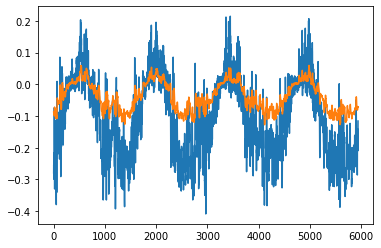

In [245]:
preds_sc = scaler.inverse_transform(np.asarray(preds).reshape(1,-1)).ravel()
y_test_2_sc = scaler.inverse_transform(np.asarray(y_test_2).reshape(1,-1)).ravel()

plt.plot(np.asarray(y_test_2_sc).ravel())
plt.plot(np.asarray(preds_sc).ravel())

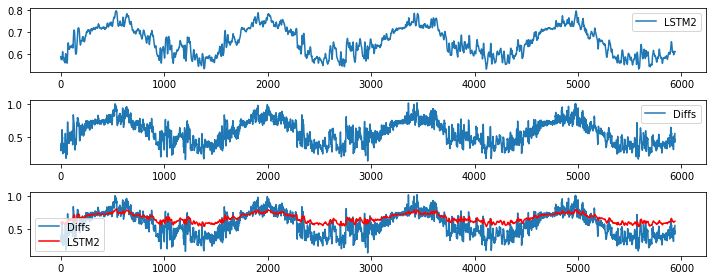

In [246]:
plt.figure(figsize = (10,4))
plt.subplot(3,1,1)
plt.plot(preds, label = "LSTM2")
plt.legend()

plt.subplot(3,1,2)
plt.plot(np.asarray(y_test_2).ravel(), label = "Diffs")
plt.legend()
 
plt.subplot(3,1,3)

plt.plot(np.asarray(y_test_2).ravel(), label = "Diffs")
plt.plot(preds, label = "LSTM2", color = 'r')
plt.legend()

plt.tight_layout()

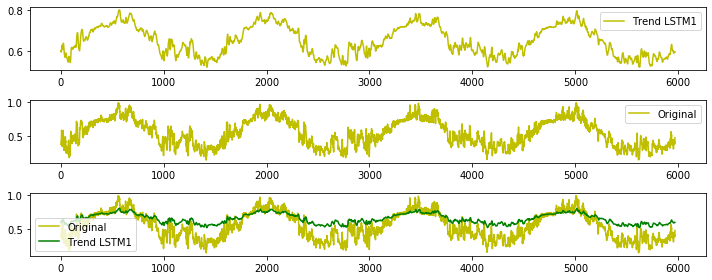

In [247]:
plt.figure(figsize = (10,4))
plt.subplot(3,1,1)
plt.plot(predicted_trend_test, label = "Trend LSTM1", color = 'y')
plt.legend()
plt.subplot(3,1,2)
plt.plot(np.asarray(y_test).ravel(), label = "Original", color = 'y')
plt.legend()

plt.subplot(3,1,3)

plt.plot(np.asarray(y_test).ravel(), label = "Original", color = 'y')
plt.plot(predicted_trend_test, label = "Trend LSTM1", color = 'g')
plt.legend()

plt.tight_layout()

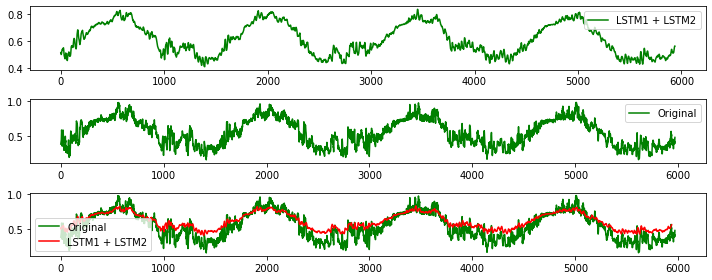

In [249]:
summation = predicted_trend_test[:-31] + np.asarray(preds_sc).ravel()
plt.figure(figsize = (10,4))
plt.subplot(3,1,1)
plt.plot(summation, label = "LSTM1 + LSTM2", color = 'g')
plt.legend()
plt.subplot(3,1,2)
plt.plot(np.asarray(y_test).ravel(), label = "Original", color = 'g')
plt.legend()

plt.subplot(3,1,3)

plt.plot(np.asarray(y_test).ravel(), label = "Original", color = 'g')
plt.plot(summation, label = "LSTM1 + LSTM2", color = 'r')
plt.legend()

plt.tight_layout()

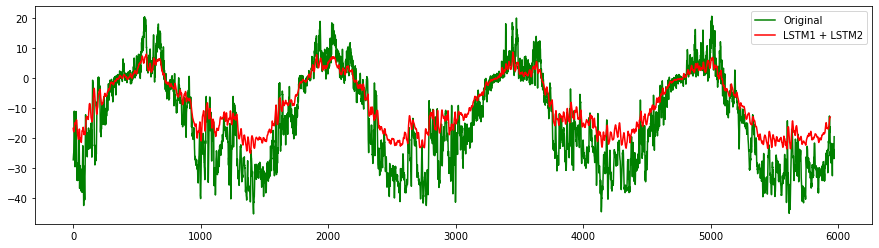

In [250]:
plt.figure(figsize = (15,4))
summation_sc = scaler_orig.inverse_transform(np.asarray(summation).ravel().reshape(-1,1))
test_data_sc = scaler_orig.inverse_transform(np.asarray(y_test).ravel().reshape(-1,1))

plt.plot(test_data_sc, label= "Original", color = 'g')
plt.plot(summation_sc, label = "LSTM1 + LSTM2", color = 'r')
plt.legend()

In [160]:
torch.save(model.state_dict(), "models/last_best_waves.pth")

Text(0.5, 1.0, 'Synthetic VS Original')

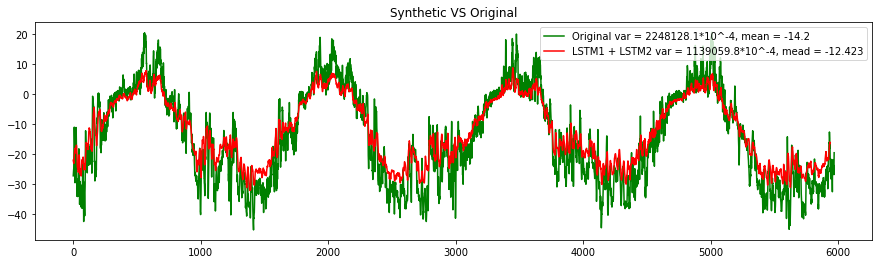

In [158]:
plt.figure(figsize = (15,4))
mu, sigma = 0, 0.04 # mean and standard deviation
s = np.random.normal(mu, sigma, len(summation_sc))

#print(summation_sc)
orig_var, orig_mean = np.var(test_data_sc)*10**4, np.mean(test_data_sc)
lstm_var, lstm_mean = np.var(summation_sc)*10**4, np.mean(summation_sc)

plt.plot(test_data_sc, color = 'g', label = "Original var = %.1f*10^-4, mean = %.1f"%(orig_var, orig_mean))
plt.plot(summation_sc.ravel() + s, label = "LSTM1 + LSTM2 var = %.1f*10^-4, mead = %.3f"%(lstm_var, lstm_mean), color = 'r')
plt.legend()

plt.title("Synthetic VS Original")

### Разные отрезки

In [71]:
def predict_summation_batch(data, lstm, lstm2, slice_size = 20):    
    """
    data - time series for forecasting.
    lstm - model for predicting trend.
    lstm2 - model for predictin diff.
    sclice_size - count of data to prediction
    """
    series_lstm1 =[]
    differs = []
    series_lstm2 = []
    for i in range(slice_size, len(data)):
        numval = np.asarray(data[i-slice_size:i]).reshape(1,slice_size)
        val = torch.from_numpy(numval).float()
        predict_1 = lstm(val[:1]).item() 
       # print(predict_1)
        series_lstm1.append(predict_1)
        differs.append(data[i] - predict_1) 
        if len(series_lstm1) >= slice_size:
            lenght = len(series_lstm1)
            numval = scaler.transform(np.asarray(differs[lenght-slice_size:lenght]).reshape(1,slice_size))
           # print(numval)
            val = torch.from_numpy(numval).float()
            predict_2 = lstm2(val[:1]) 
            series_lstm2.append(predict_2)
    series_lstm2 = scaler.inverse_transform(np.asarray(series_lstm2).reshape(-1,1))
  #  series_lstm1 = scaler.inverse_transform(np.asarray(series_lstm1).reshape(-1,1))
    return np.asarray(series_lstm1[:len(series_lstm2)]), series_lstm2, differs

In [63]:
def plot_predicted(seriries_original, prediction, scaler = scaler_orig):
    """
    seriries_original 
    prediction - array from function predict_summation_batch
    scaler - scaler for transform data to original state
    """
    test_data_sc = scaler.inverse_transform(np.asarray(seriries_original).ravel().reshape(-1,1))
    summation_sc = scaler.inverse_transform(np.asarray(prediction[0].ravel() + prediction[1].ravel()).ravel().reshape(-1,1))
    
    orig_mean =  np.mean(test_data_sc)
    lstm_mean =  np.mean(summation_sc)

    plt.figure(figsize = (15,4))
    
    plt.plot(test_data_sc, label = "Original data, mean %.2f"%orig_mean)
    plt.plot(summation_sc, label = "Predicted data, mean %.2f"%lstm_mean)
    
    plt.legend()
    
    return test_data_sc, summation_sc
    

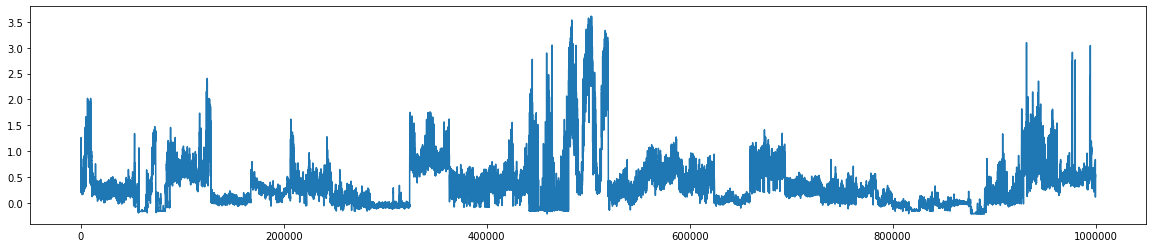

In [22]:
# Скейлим все данные
plt.figure(figsize = (20, 4))
values_mean_sc = scaler_orig.transform(np.expand_dims(values_mean, axis=1))
plt.plot(values_mean_sc)

In [57]:
#Скейлим только кусочек
scaler_2 = MinMaxScaler()
data = values_mean.ravel()[600000:800000]
scaler_2 = scaler_2.fit(np.expand_dims(data, axis=1))
data = scaler_2.transform(np.expand_dims(data.ravel(), axis=1)) 


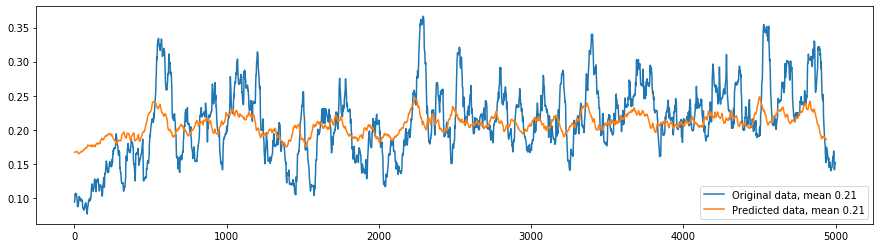

In [66]:
data_pr = data[10000:15000]
prediction = predict_summation_batch(data_pr, model, model, slice_size = 30)
plot_predicted(data_pr, prediction, scaler = scaler_2)

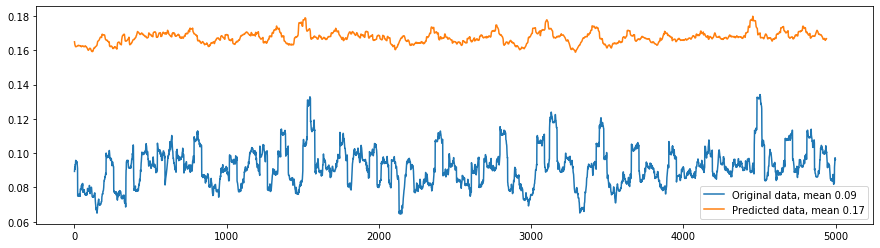

In [65]:
data_pr = data[30000:35000]
prediction = predict_summation_batch(data_pr, model,model, slice_size = 30)
plot_predicted(data_pr, prediction, scaler = scaler_2)

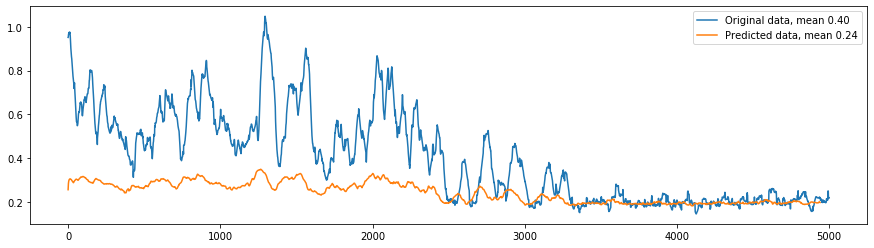

In [69]:
data_pr = values_mean_sc[505000:510000]
prediction = predict_summation_batch(data_pr, model, model, slice_size = 30)
plot_predicted(data_pr, prediction)

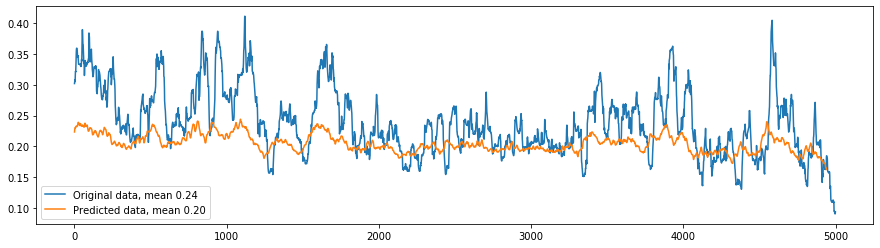

In [70]:
data_pr = values_mean_sc[605000:610000]
prediction = predict_summation_batch(data_pr, model,model, slice_size = 30)
plot_predicted(data_pr, prediction)

#### Две модели

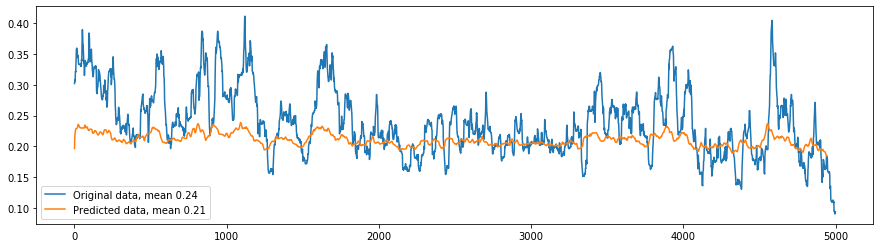

In [78]:
data_pr = values_mean_sc[605000:610000]
prediction = predict_summation_batch(data_pr, model,model_2, slice_size = 30)
plot_predicted(data_pr, prediction)

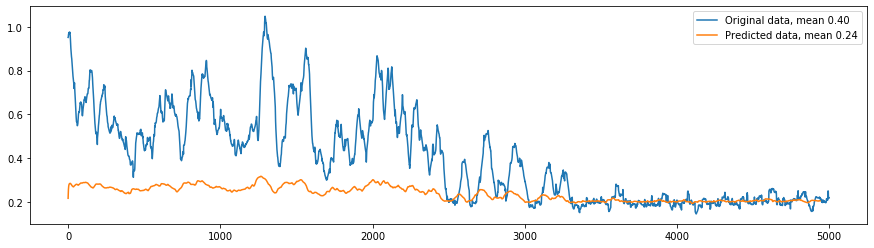

In [79]:
data_pr = values_mean_sc[505000:510000]
prediction = predict_summation_batch(data_pr, model,model_2, slice_size = 30)
plot_predicted(data_pr, prediction)

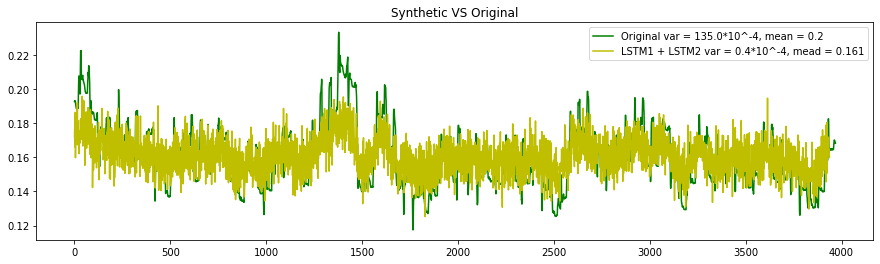

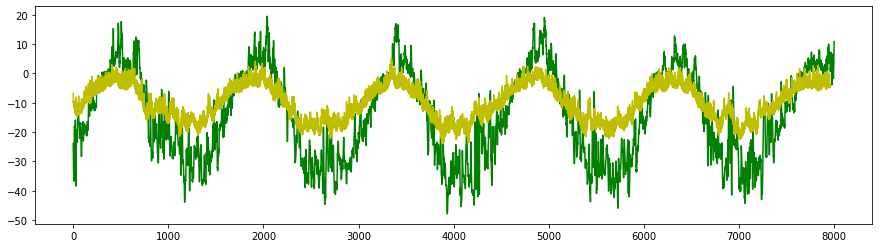